# Data Modelling (Base Data)

---

The `functions.py` script is first run. This script contains all the relevant imports as well as useful functions for the modelling step. The details of these functions can be viewed within the script. These functions will help to evaluate the models. Additionally, this notebook will only deal with the data modelling for the `base` dataset. This notebook will be the most detailed concerning the modelling process. Each additional dataset will have their own modelling notebook and will include only relevant information to the analysis of the models for that dataset or any relevant changes that are pertinent to that particular dataset. The data was then read into the notebook as DataFrames.

In [2]:
%run ../functions.py

In [3]:
X_train_base_scaled = pd.read_csv('../Data/base/X_train_base_scaled.csv')
y_train_base = pd.read_csv('../Data/base/y_train_base.csv')
X_val_base_scaled = pd.read_csv('../Data/base/X_val_base_scaled.csv')
y_val_base = pd.read_csv('../Data/base/y_val_base.csv')
X_test_base_scaled = pd.read_csv('../Data/base/X_test_base_scaled.csv')
y_test_base = pd.read_csv('../Data/base/y_test_base.csv')

---

### Baseline Model

Since we are dealing with a classification problem, a DummyClassifier will be used in order to determine how well the model performs. As can be seen below, the model's F1 score is only 0.0113 which is not very good. This indicates that the model is missing nearly 99 percent of fraud accounts.

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

b_baseline_model = DummyClassifier(random_state=21)

b_baseline_model.fit(X_train_base_scaled, y_train_base)

b_baseline_results = cross_val_score(b_baseline_model,
                                     X_train_base_scaled,
                                     y_train_base,
                                     scoring='recall',
                                     cv=10).mean()

print(f"Train recall: {b_baseline_results}")

Train recall: 0.011286839889329967


---

### First Model Iteration

For this project, we will be utilizing deep-learning neural networks to predict fraudulent bank accounts based on the details present at account opening. Before instantiating the first model, `early_stop` and `n_features` are instantiated. `early_stop` defines an early stopping callback for all future models and `n_features` is simply the dimensionality of the features for `X_train_base_scaled`. 

The first iteration of the model is a basic Seqential neural network and is defined to take arguments for `X_train`, `y_train`, `X_val`, `y_val`, and `name`. `epochs`, `batch_size`, and `threshold` have predefined values but can also be set. For now, we will use the default values. The model consists of an input layer the shape of `n_features`, followed by two dense layers with relu activation of dimensionality 32 and 16 respectively, and finishes off with a dense layer with sigmoid activation, the activation used for binary classification. 

The model is then compiled using `adam` as the optimizer algorithm and `binary_crossentropy` as the loss function. The metrics chosen are AUC, precision, recall, and false positive rate. Our performance metric is going to be recall. We also want to minimize the false positive rate. The information used to compile the models will be the same going forward unless otherwise stated. The model is then fit using the arguments provided to the function and the history is instatiated as a variable. An evaluation function, defined in `functions.py` is then used to print out useful information regarding the model

In [6]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [110]:
n_features = X_train_base_scaled.shape[1]

In [6]:
def modelling_v1(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    model_v1 = models.Sequential()

    model_v1.add(layers.Input(shape=(n_features, )))
    model_v1.add(layers.Dense(32, activation='relu'))
    model_v1.add(layers.Dense(16, activation='relu'))
    model_v1.add(layers.Dense(1, activation='sigmoid'))

    model_v1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v1_history = model_v1.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    epochs=epochs,
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v1,
             name,
             model_v1_history,
             X_val,
             y_val,
             threshold=threshold)

Now we call our function, `modelling_v1` with the relevant parameters. This model does not appear to pick up on the fraud as the recall score on the validation data is only 0.026, which indicates that the model only picks up 2.6% of fraud cases. While this model performs extremely well on false positive rate, with a score of 0.0004 on the validation data, it does not achieve our goal of predicting fraud cases.

Epoch 00014: early stopping
Results for Base Model V1 with threshold = 0.5.

 Train f1: 0.04519640271699452 
 Val f1: 0.04960835361075557 

 Train Recall: 0.02343270741403103 
 Val Recall: 0.02620689570903778 

 Train FPR: 0.00013980006042402238 
 Val FPR: 0.0004123015678487718


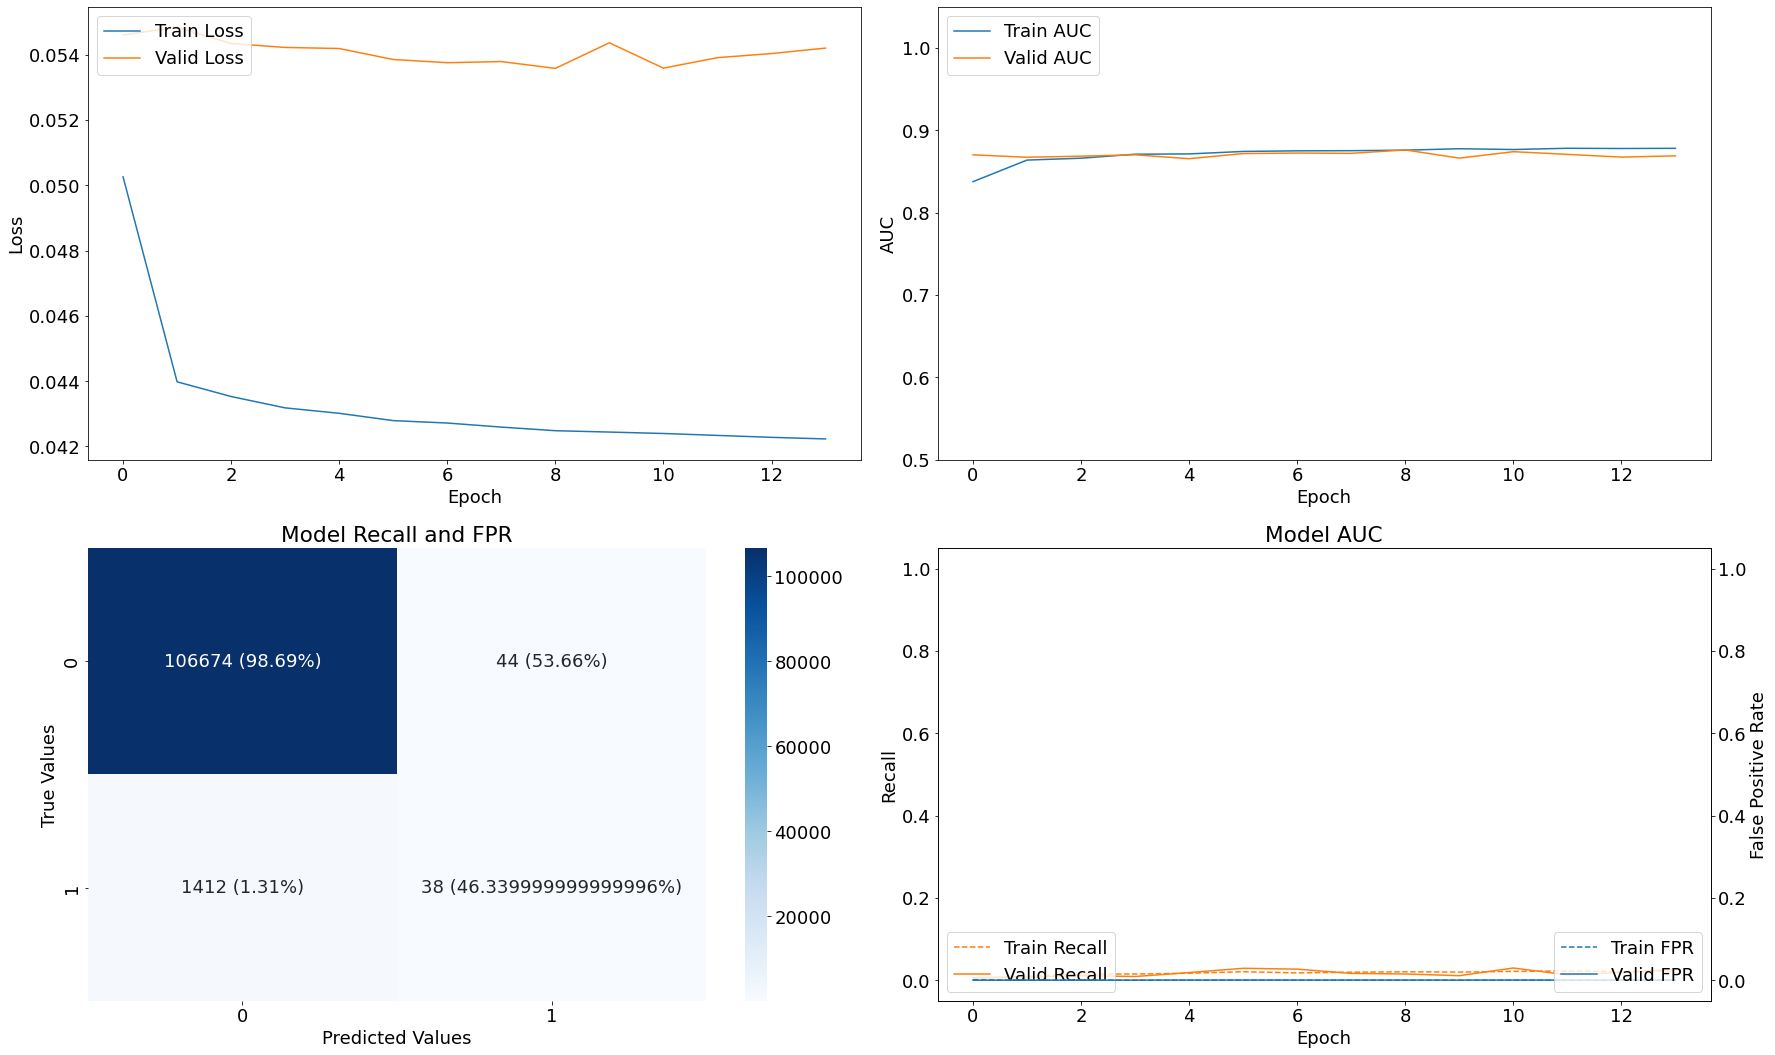

In [7]:
modelling_v1(X_train_base_scaled,
             y_train_base,
             X_val_base_scaled,
             y_val_base,
             'Base Model V1')

---

### Second Model Iteration

The second iteration of the model adds 50% dropout layers following the dense 32 layer and the dense 16 layer. Everything else remains the same.

In [8]:
def modelling_v2(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    model_v2 = models.Sequential()

    model_v2.add(layers.Input(shape=(n_features, )))
    model_v2.add(layers.Dense(32, activation='relu'))
    model_v2.add(layers.Dropout(0.5))
    model_v2.add(layers.Dense(16, activation='relu'))
    model_v2.add(layers.Dropout(0.5))
    model_v2.add(layers.Dense(1, activation='sigmoid'))

    model_v2.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['AUC',
                                   tf.keras.metrics.Precision(thresholds=threshold),
                                   tf.keras.metrics.Recall(thresholds=threshold),
                                   FalsePositiveRate(threshold=threshold)])

    model_v2_history = model_v2.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    epochs=epochs, 
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v2,
             name,
             model_v2_history,
             X_val,
             y_val,
             threshold=threshold)

As can be seen below, it appears that this model does not pick up on the fraud at all. It predicts the majority class for every value.

Epoch 00008: early stopping
Results for Base Model V2 with threshold = 0.5.

 Train f1: N/A 
 Val f1: N/A 

 Train Recall: 0.00907864049077034 
 Val Recall: 0.0 

 Train FPR: 0.00013725824828725308 
 Val FPR: 0.0


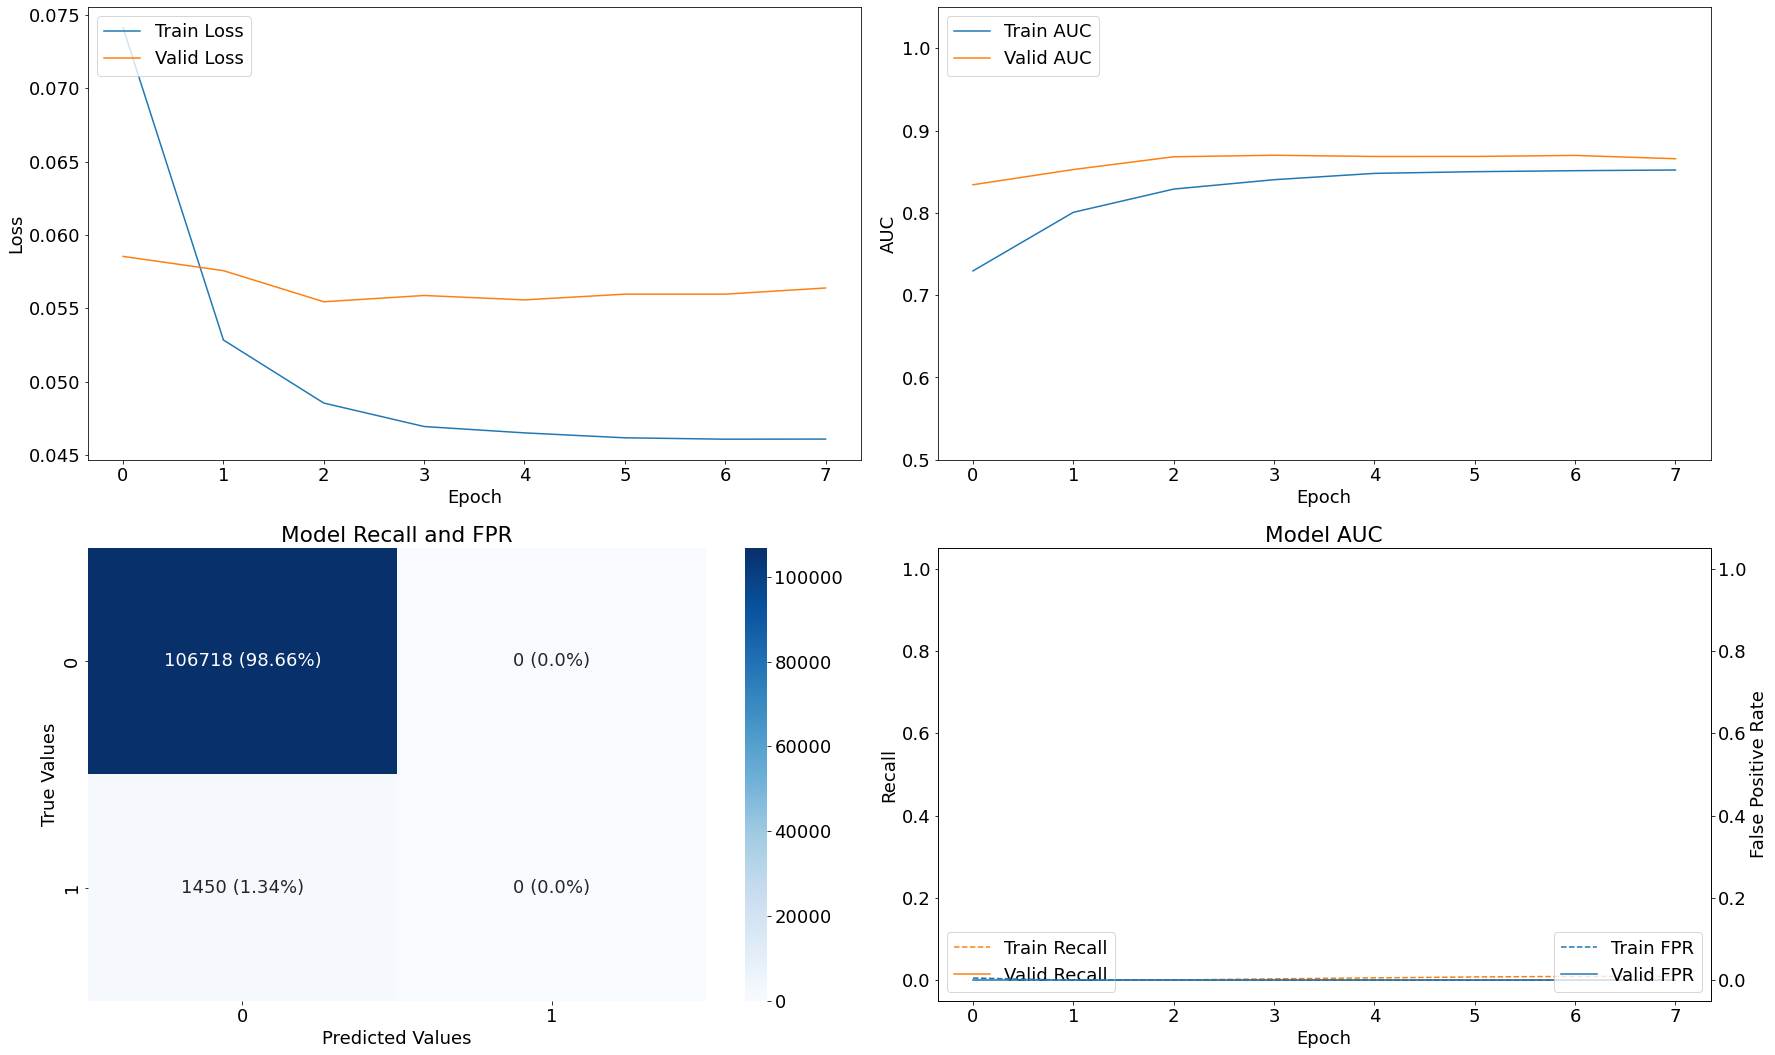

In [9]:
modelling_v2(X_train_base_scaled,
             y_train_base,
             X_val_base_scaled,
             y_val_base,
            'Base Model V2')

---

### Third Model Iteration
The only change for the third iteration of the model is adding class weights. This can help to deal with the imbalanced data. The `creat_class_weight` functions from the functions script is utlized here.

In [7]:
class_weight = create_class_weight({0: len(y_train_base == 0), 1: len(y_train_base == 1)})

In [38]:
def modelling_v3(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    model_v3 = models.Sequential()

    model_v3.add(layers.Input(shape=(n_features, )))
    model_v3.add(layers.Dense(32, activation='relu'))
    model_v3.add(layers.Dropout(0.5))
    model_v3.add(layers.Dense(16, activation='relu'))
    model_v3.add(layers.Dropout(0.5))
    model_v3.add(layers.Dense(1, activation='sigmoid'))

    model_v3.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v3_history = model_v3.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs, 
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v3,
             name,
             model_v3_history,
             X_val,
             y_val,
             threshold=threshold)

Despite the new `class_weights`, this model does not appear to pick up on fraud either. Since this method does not appear to have worked, the data may require some oversampling of the minority class.

Epoch 00017: early stopping
Results for Base Model V3 with threshold = 0.5.

 Train f1: N/A 
 Val f1: N/A 

 Train Recall: 0.012636486440896988 
 Val Recall: 0.0 

 Train FPR: 0.00016903098730836064 
 Val FPR: 9.370490261062514e-06


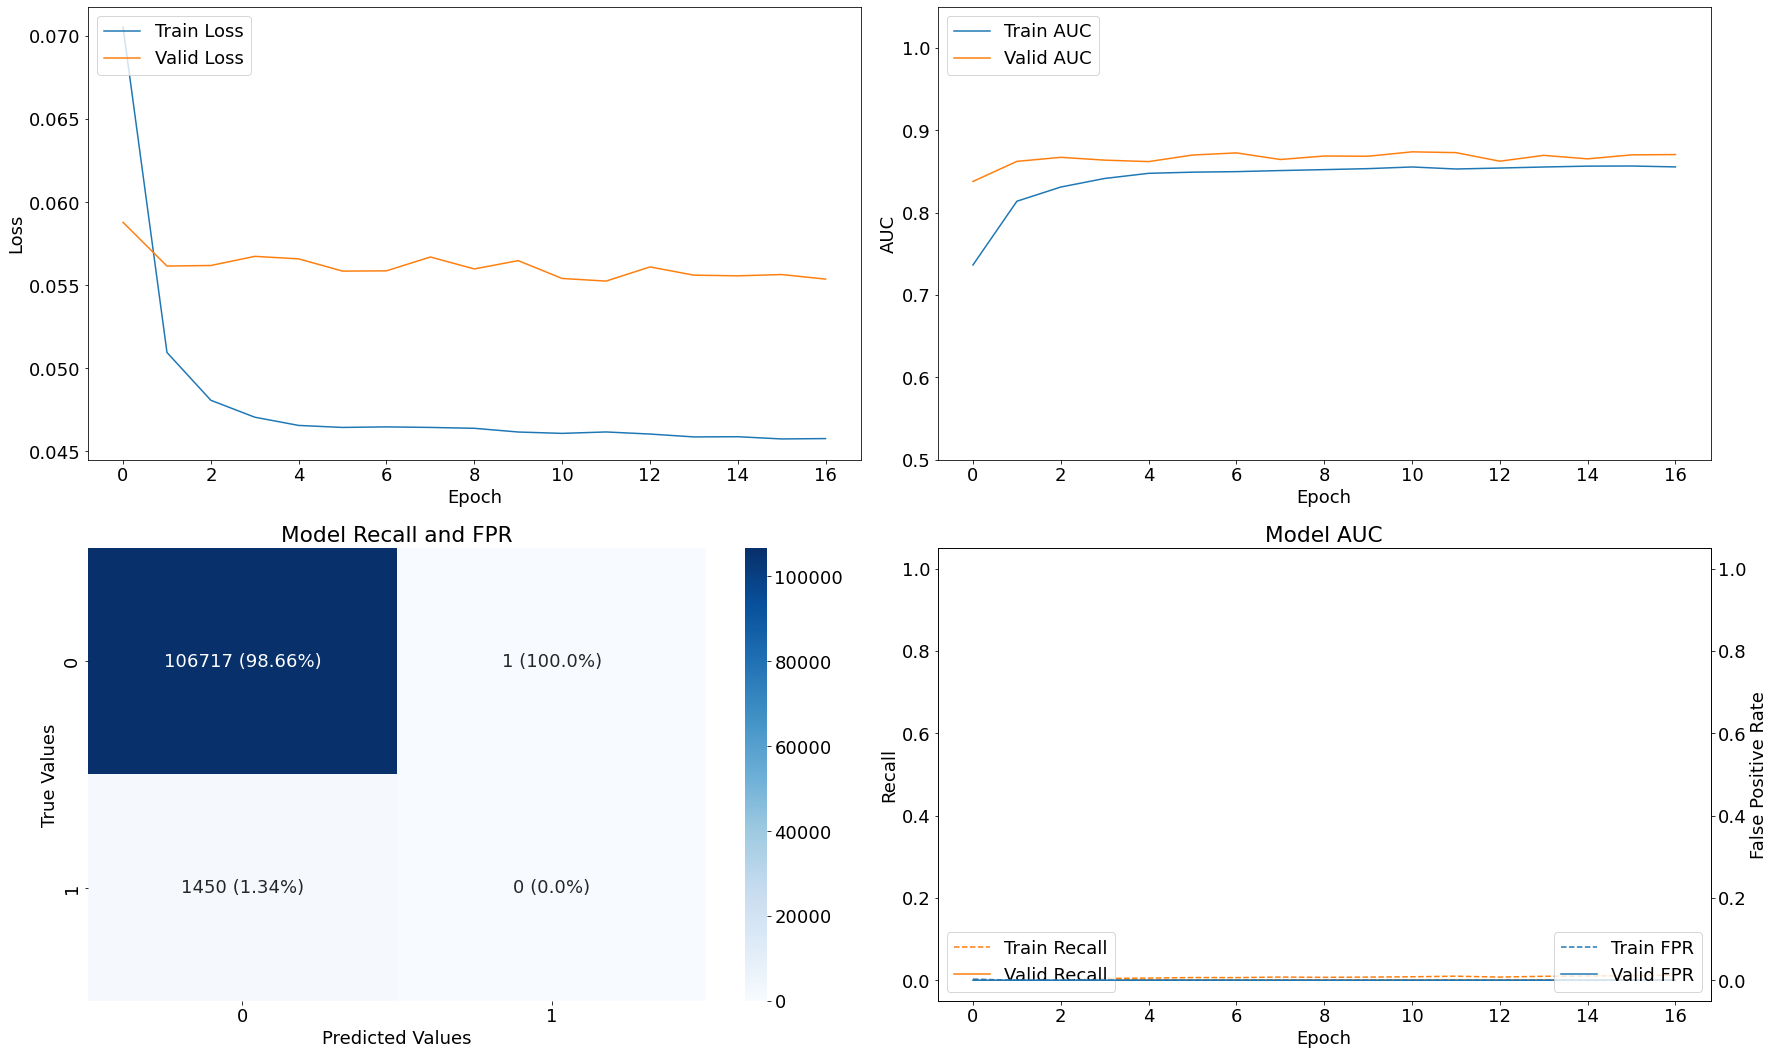

In [12]:
modelling_v3(X_train_base_scaled,
             y_train_base,
             X_val_base_scaled,
             y_val_base,
            'Base Model V3')

---

### Fourth Model Iteration

For the fourth iteration of the model, the SMOTE resampled data will be utilized. This was resampled with a strategy of 0.25, i.e., the the minority class, fraud, was oversampled by 25 percent. The actual model structure used is the same as the second and third iterations.

In [8]:
X_train_base_scaled_resampled = pd.read_csv('../Data/base/X_train_base_scaled_resampled.csv')
y_train_base_resampled = pd.read_csv('../Data/base/y_train_base_resampled.csv')

In [58]:
def modelling_v4(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):    
    
    model_v4 = models.Sequential()

    model_v4.add(layers.Input(shape=(n_features, )))
    model_v4.add(layers.Dense(32, activation='relu'))
    model_v4.add(layers.Dropout(0.5))
    model_v4.add(layers.Dense(16, activation='relu'))
    model_v4.add(layers.Dropout(0.5))
    model_v4.add(layers.Dense(1, activation='sigmoid'))

    model_v4.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v4_history = model_v4.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs,
                                    callbacks=[early_stop],
                                    verbose=0).history

    evaluate(model_v4,
             'Base Model V4',
             model_v4_history,
             X_val,
             y_val,
             threshold=threshold)

The resampling of the data appears to have had the intended effect on our data. The model is now able to predict the minority class and, considering the low false positive rate, does a decent job. This model is able to predict 46.4 percent of fraud in the validation data. While this number is not perfect, it is a good starting point.

Epoch 00016: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.7218537214870853 
 Val f1: 0.19867158397733717 

 Train Recall: 0.689063549041748 
 Val Recall: 0.4641379415988922 

 Train FPR: 0.0550214909017086 
 Val FPR: 0.04359152168035507


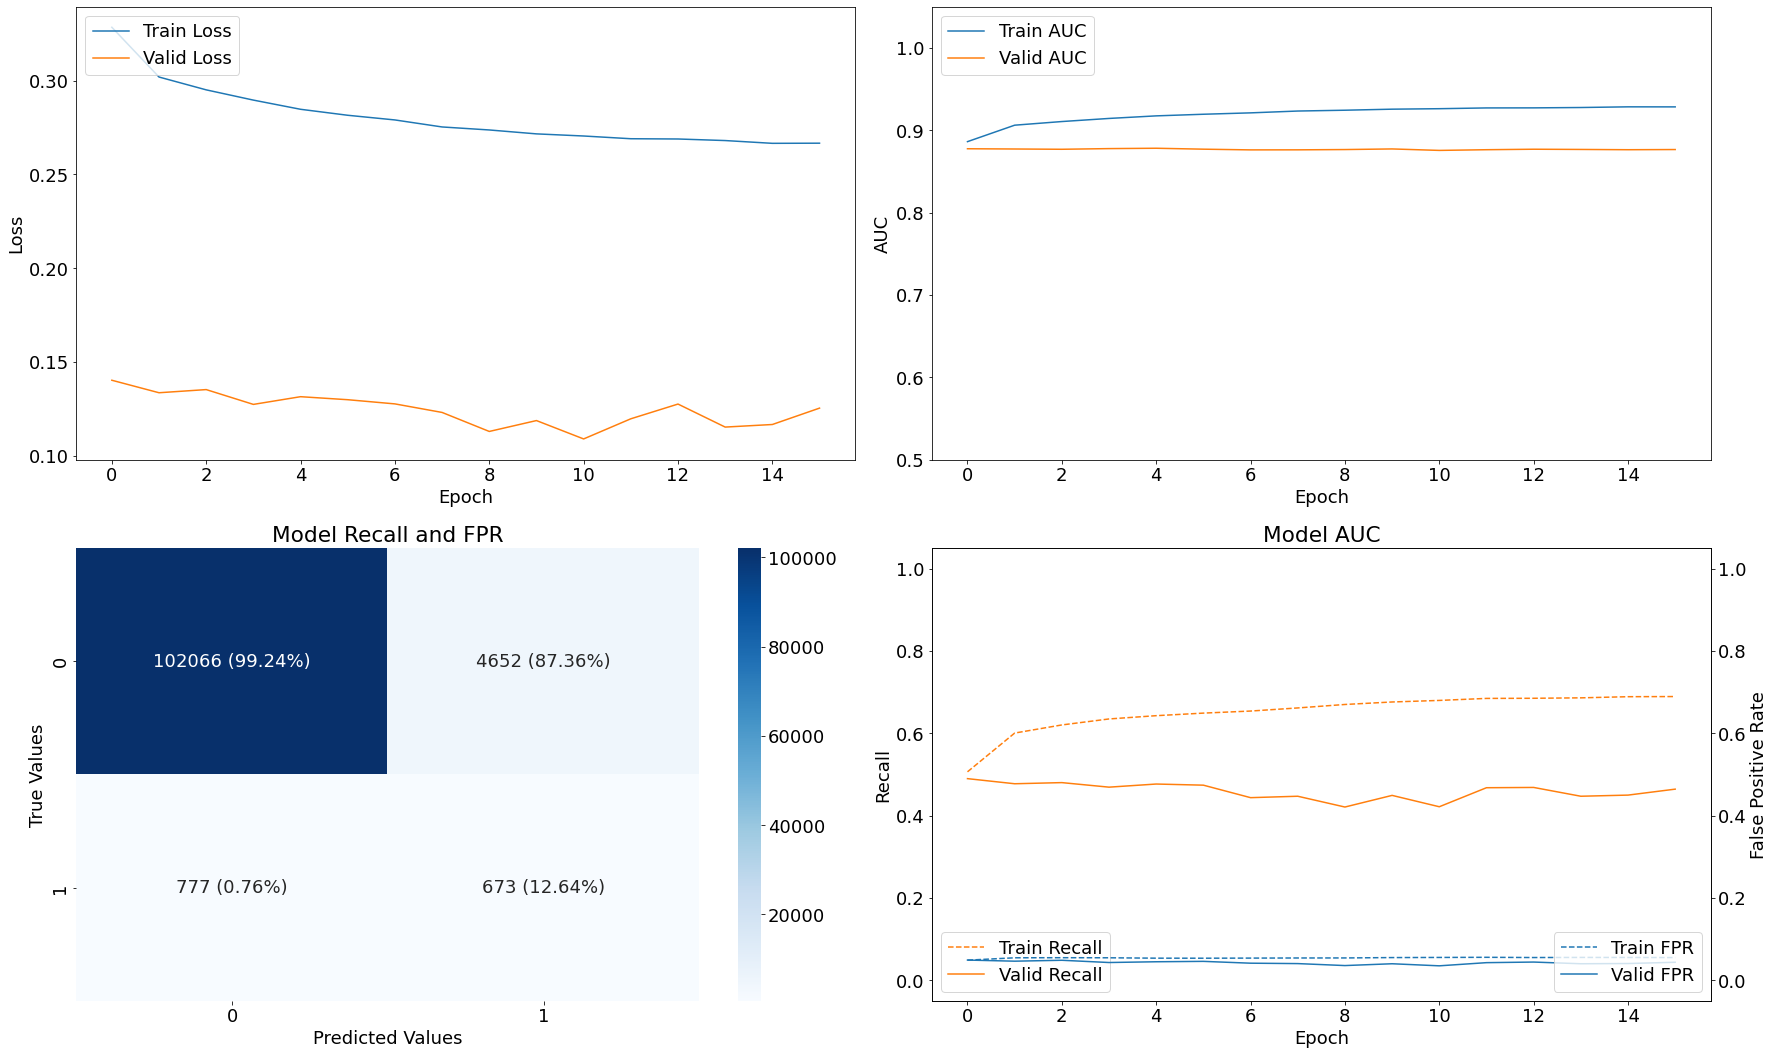

In [59]:
modelling_v4(X_train_base_scaled_resampled,
             y_train_base_resampled,
             X_val_base_scaled,
             y_val_base,
            'Base Model V4')

Since this model is actually able to predict fraud, the next step is to find the optimal `mu` for the `class_weights`. This `mu` is a simple constant which determines how heavily one class is weighed compared to the other. To achieve this, a list of `mu` is created and looped over. The results were then analysed and found that `mu` of 0.2 is the optimal value.

Epoch 00012: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.68582634304325 
 Val f1: 0.20109626014630247 

 Train Recall: 0.6170027852058411 
 Val Recall: 0.4048275947570801 

 Train FPR: 0.04557354748249054 
 Val FPR: 0.03561723604798317


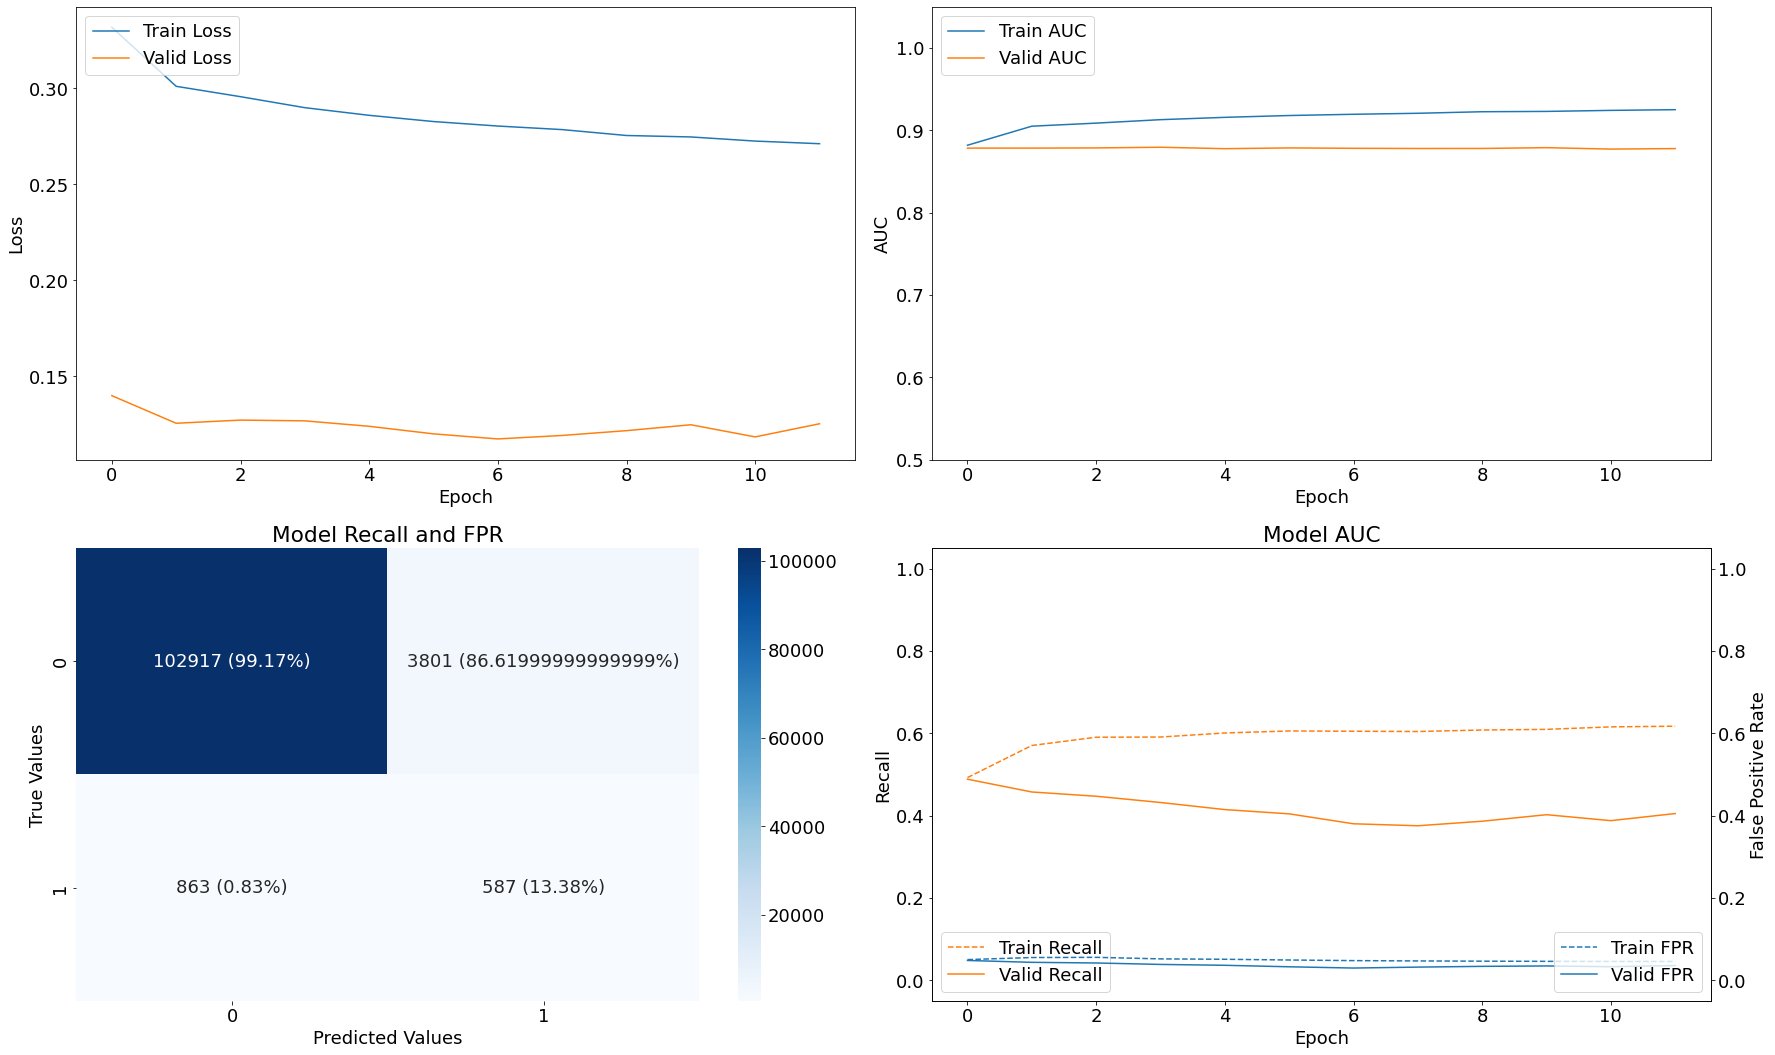

Epoch 00020: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6954042745355296 
 Val f1: 0.20127222293520672 

 Train Recall: 0.6287358403205872 
 Val Recall: 0.4255172312259674 

 Train FPR: 0.044880904257297516 
 Val FPR: 0.03808167204260826


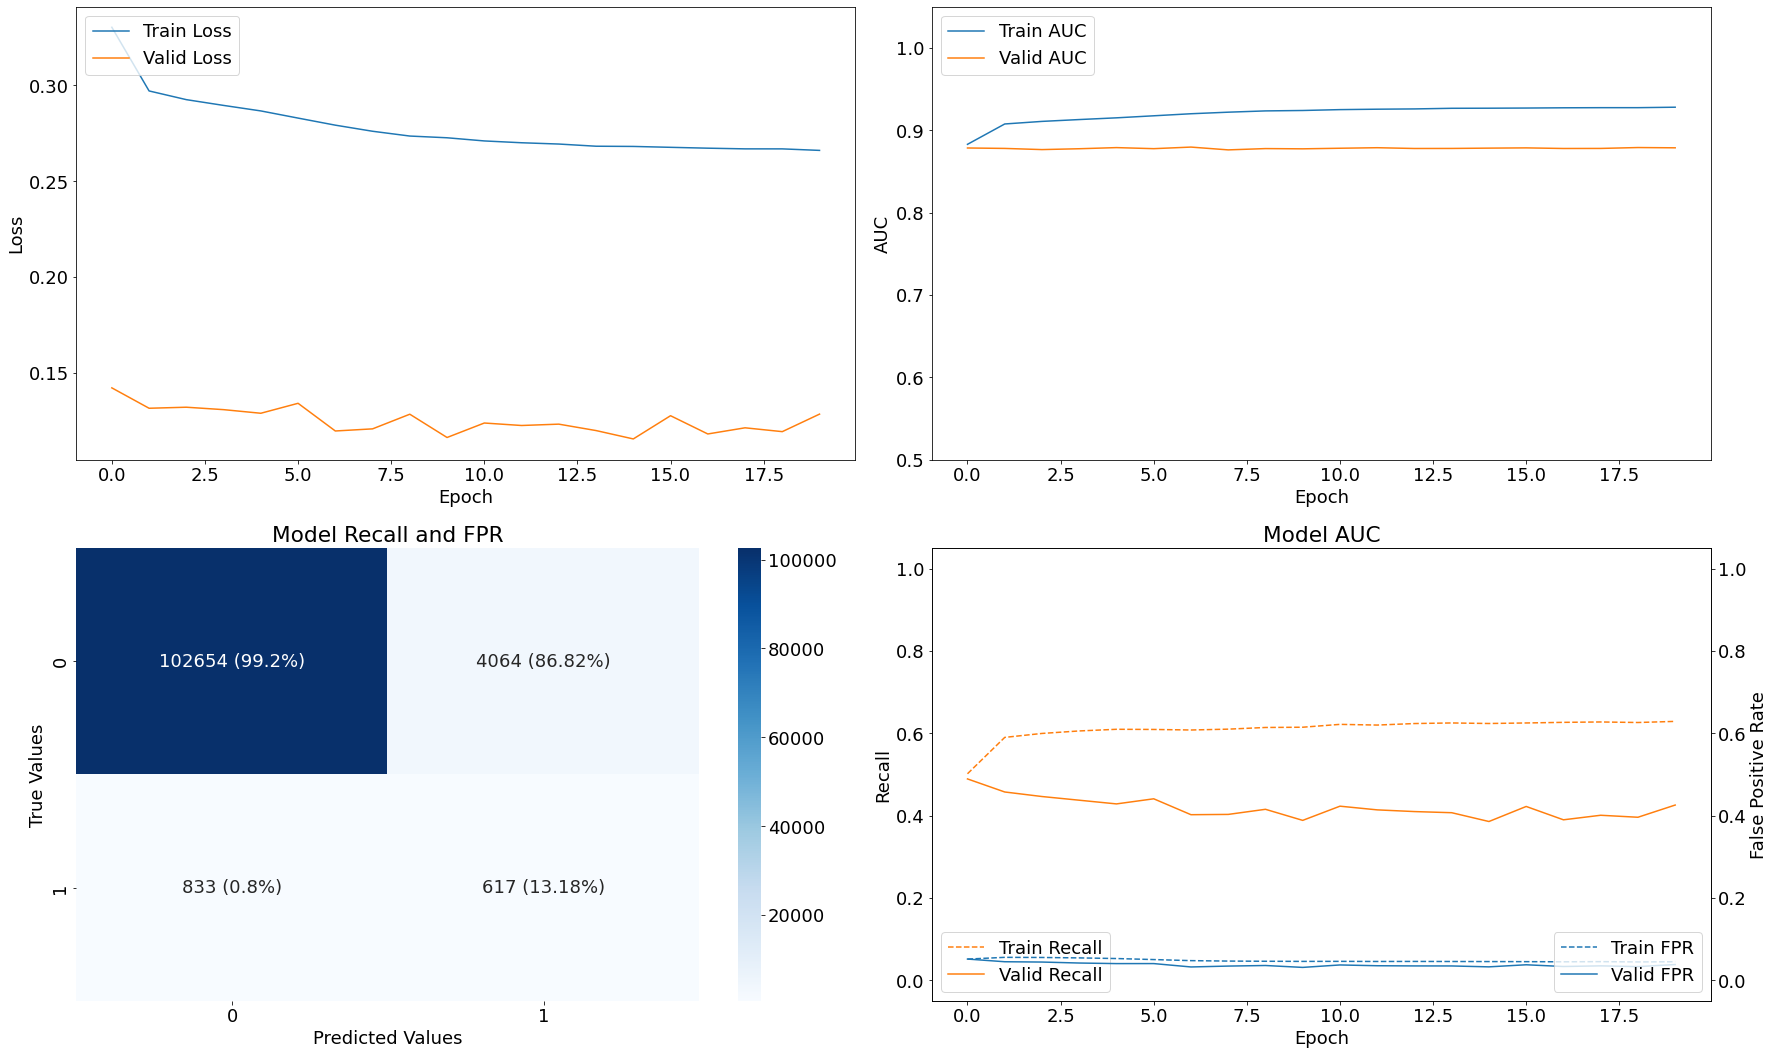

Epoch 00026: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.7061278100349048 
 Val f1: 0.21994255708996185 

 Train Recall: 0.6417804956436157 
 Val Recall: 0.36965516209602356 

 Train FPR: 0.043991267681121826 
 Val FPR: 0.027061976492404938


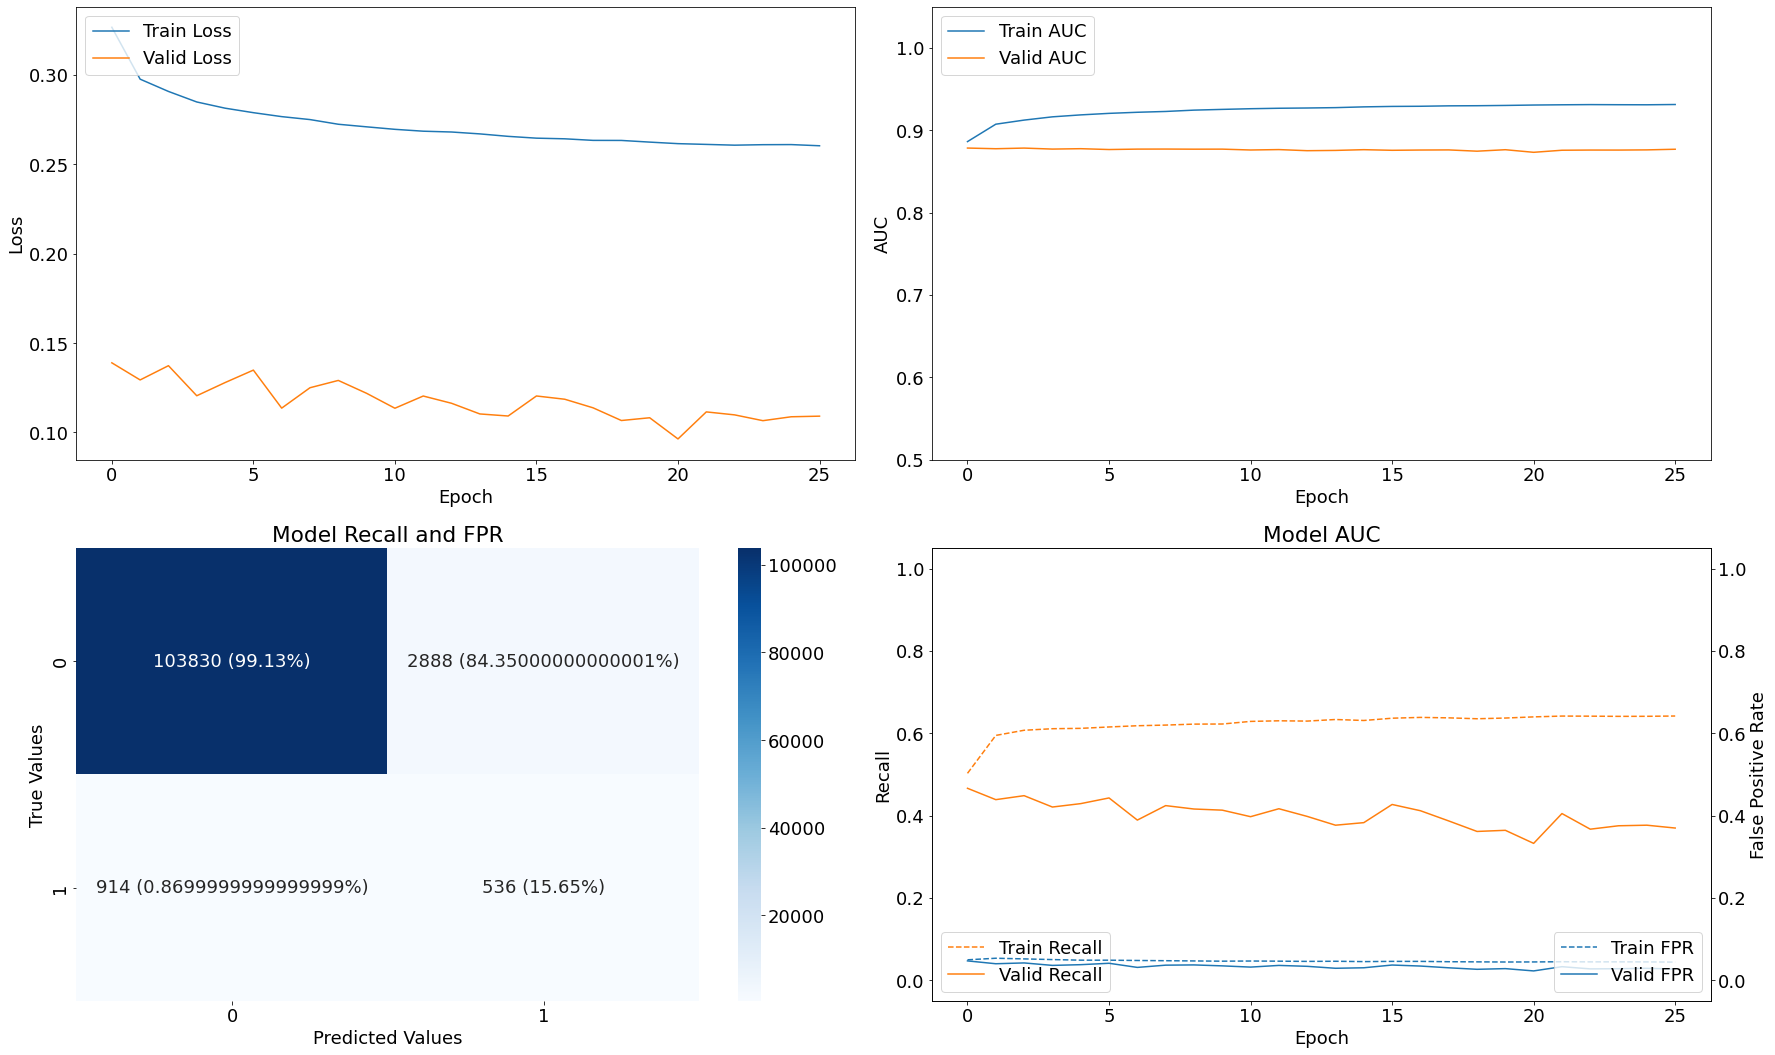

Epoch 00021: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.696542333549091 
 Val f1: 0.2048450294753987 

 Train Recall: 0.6297169923782349 
 Val Recall: 0.3965517282485962 

 Train FPR: 0.04460130259394646 
 Val FPR: 0.03363069146871567


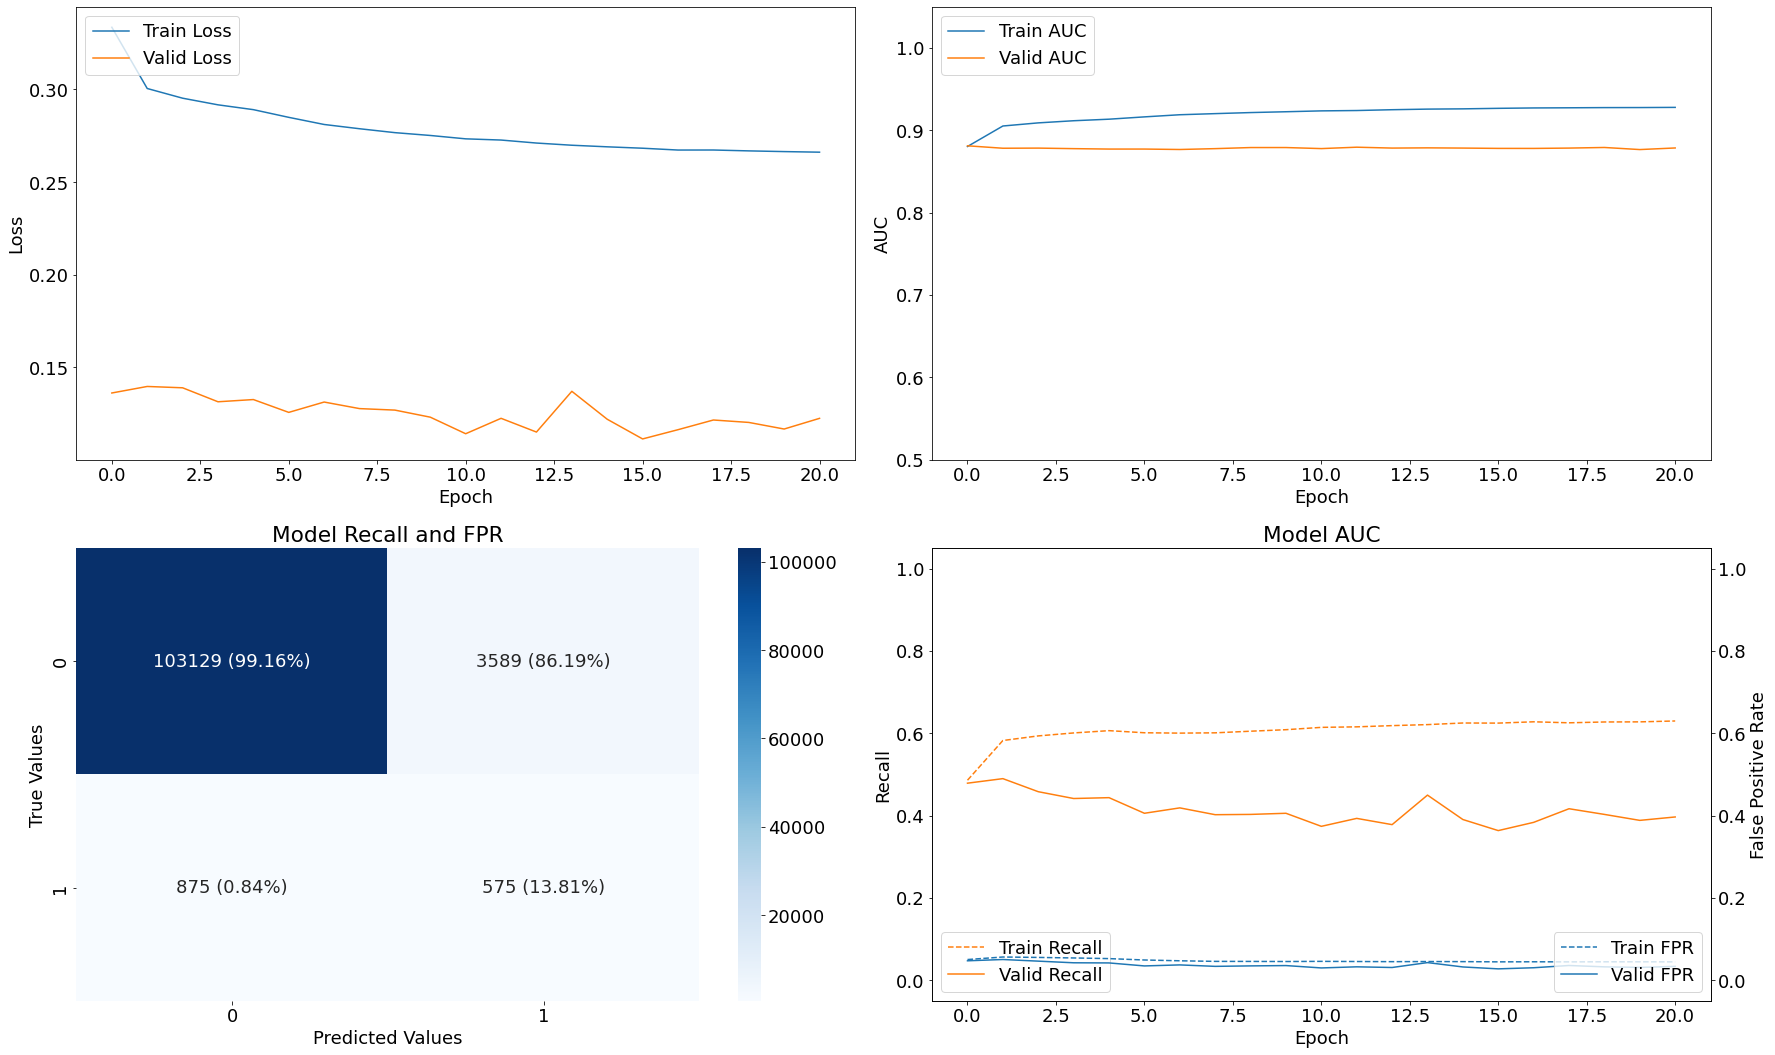

Epoch 00021: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6912476312894084 
 Val f1: 0.2084339566259237 

 Train Recall: 0.622061014175415 
 Val Recall: 0.386896550655365 

 Train FPR: 0.044439896941185 
 Val FPR: 0.03159729391336441


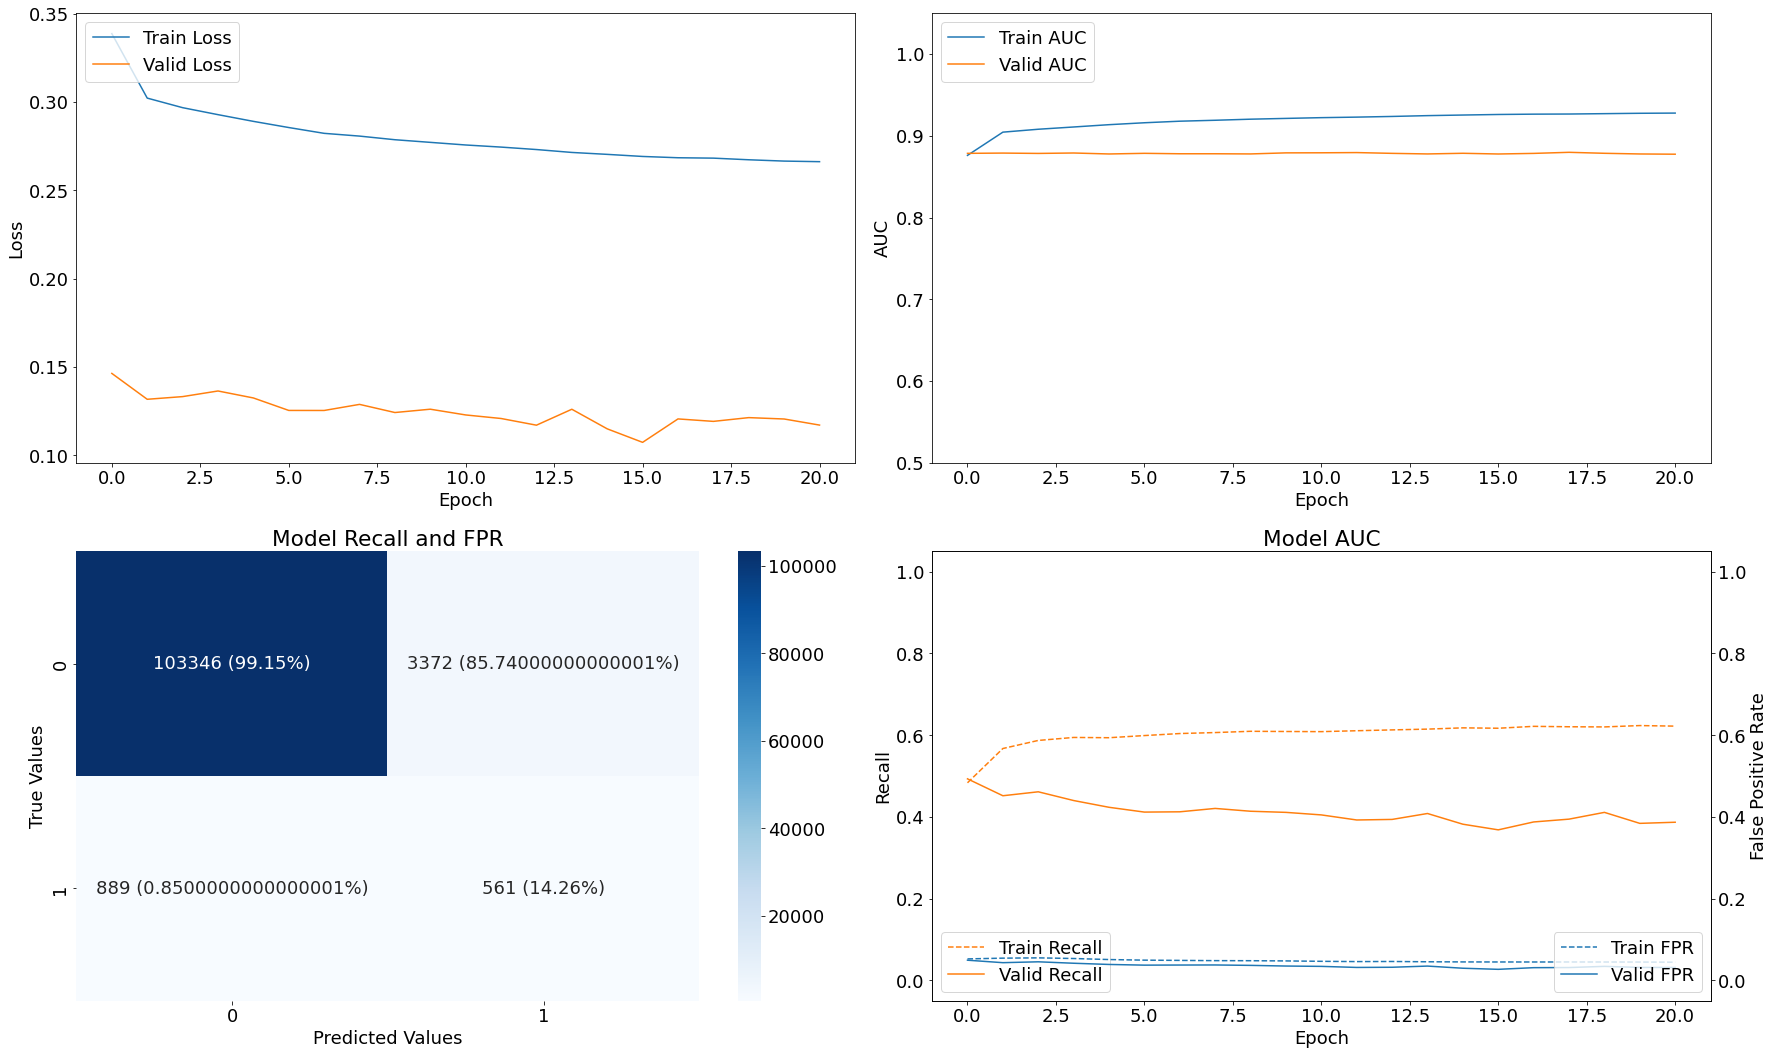

Epoch 00009: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6763719609886387 
 Val f1: 0.20143405288108826 

 Train Recall: 0.6101957559585571 
 Val Recall: 0.41655173897743225 

 Train FPR: 0.048530954867601395 
 Val FPR: 0.03694784268736839


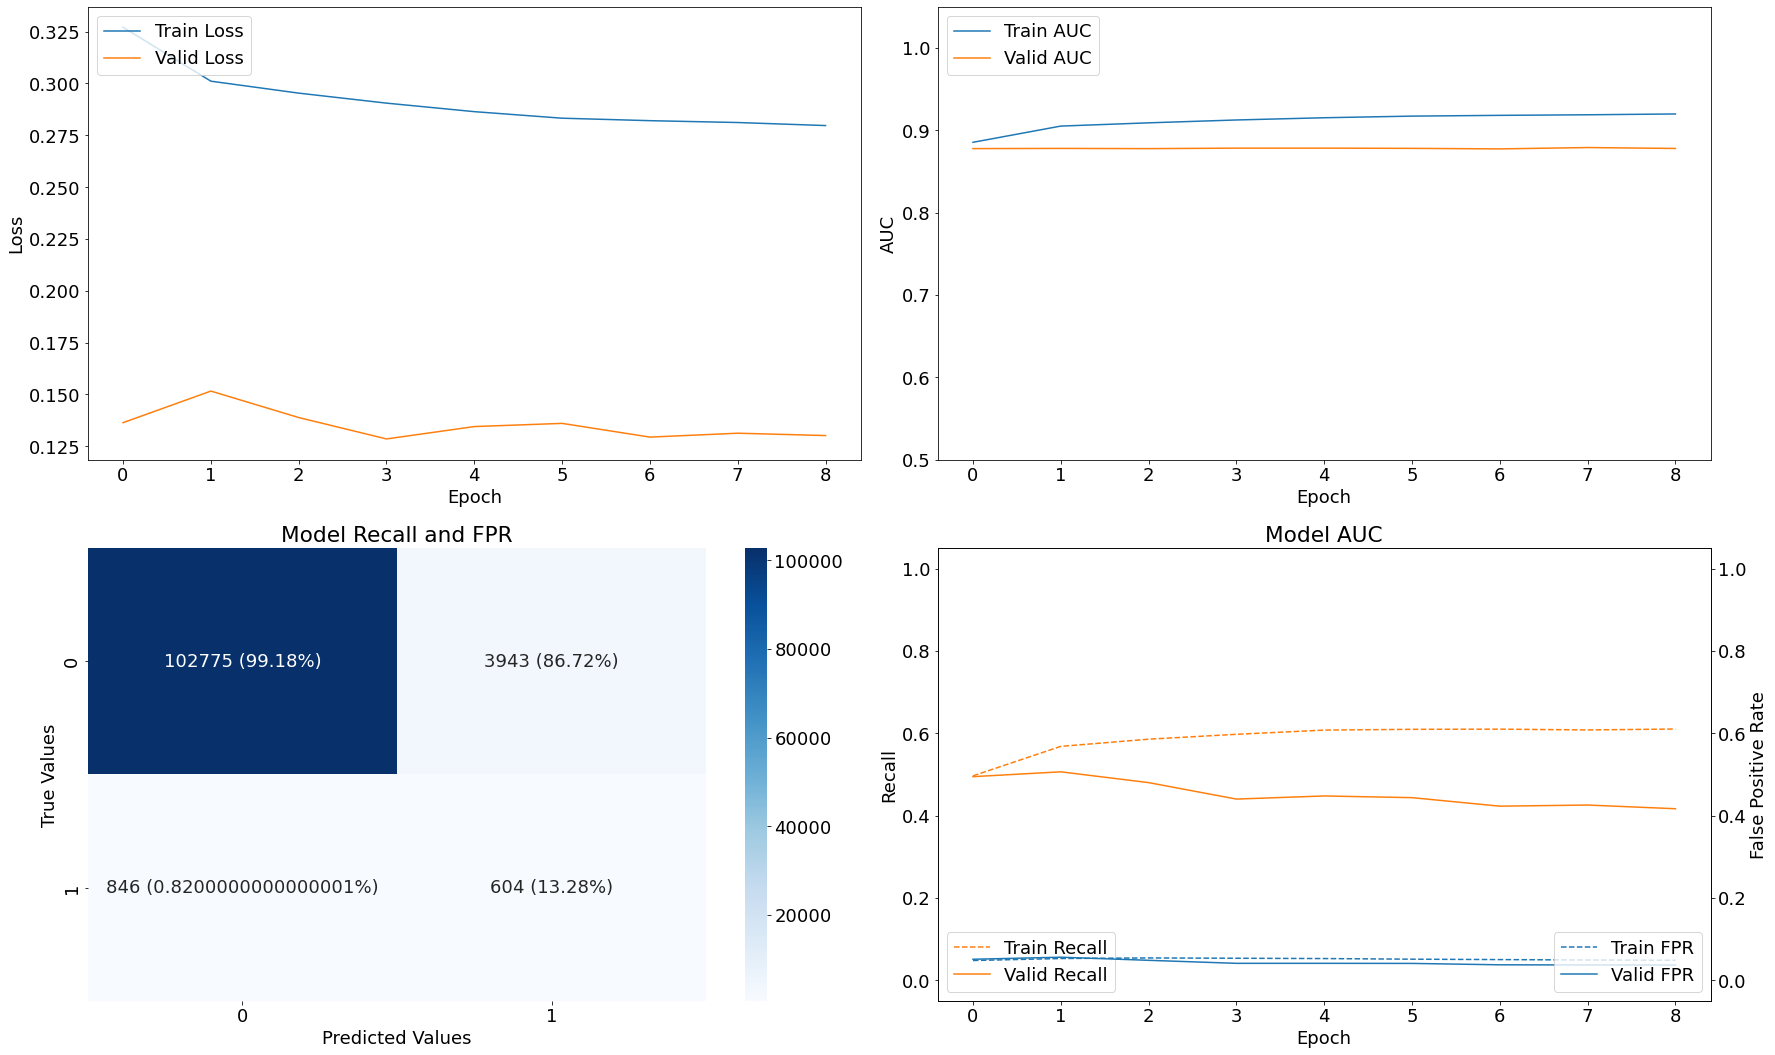

Epoch 00015: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6807251798465742 
 Val f1: 0.2112858433917453 

 Train Recall: 0.6099721193313599 
 Val Recall: 0.39379310607910156 

 Train FPR: 0.04553796350955963 
 Val FPR: 0.031709738075733185


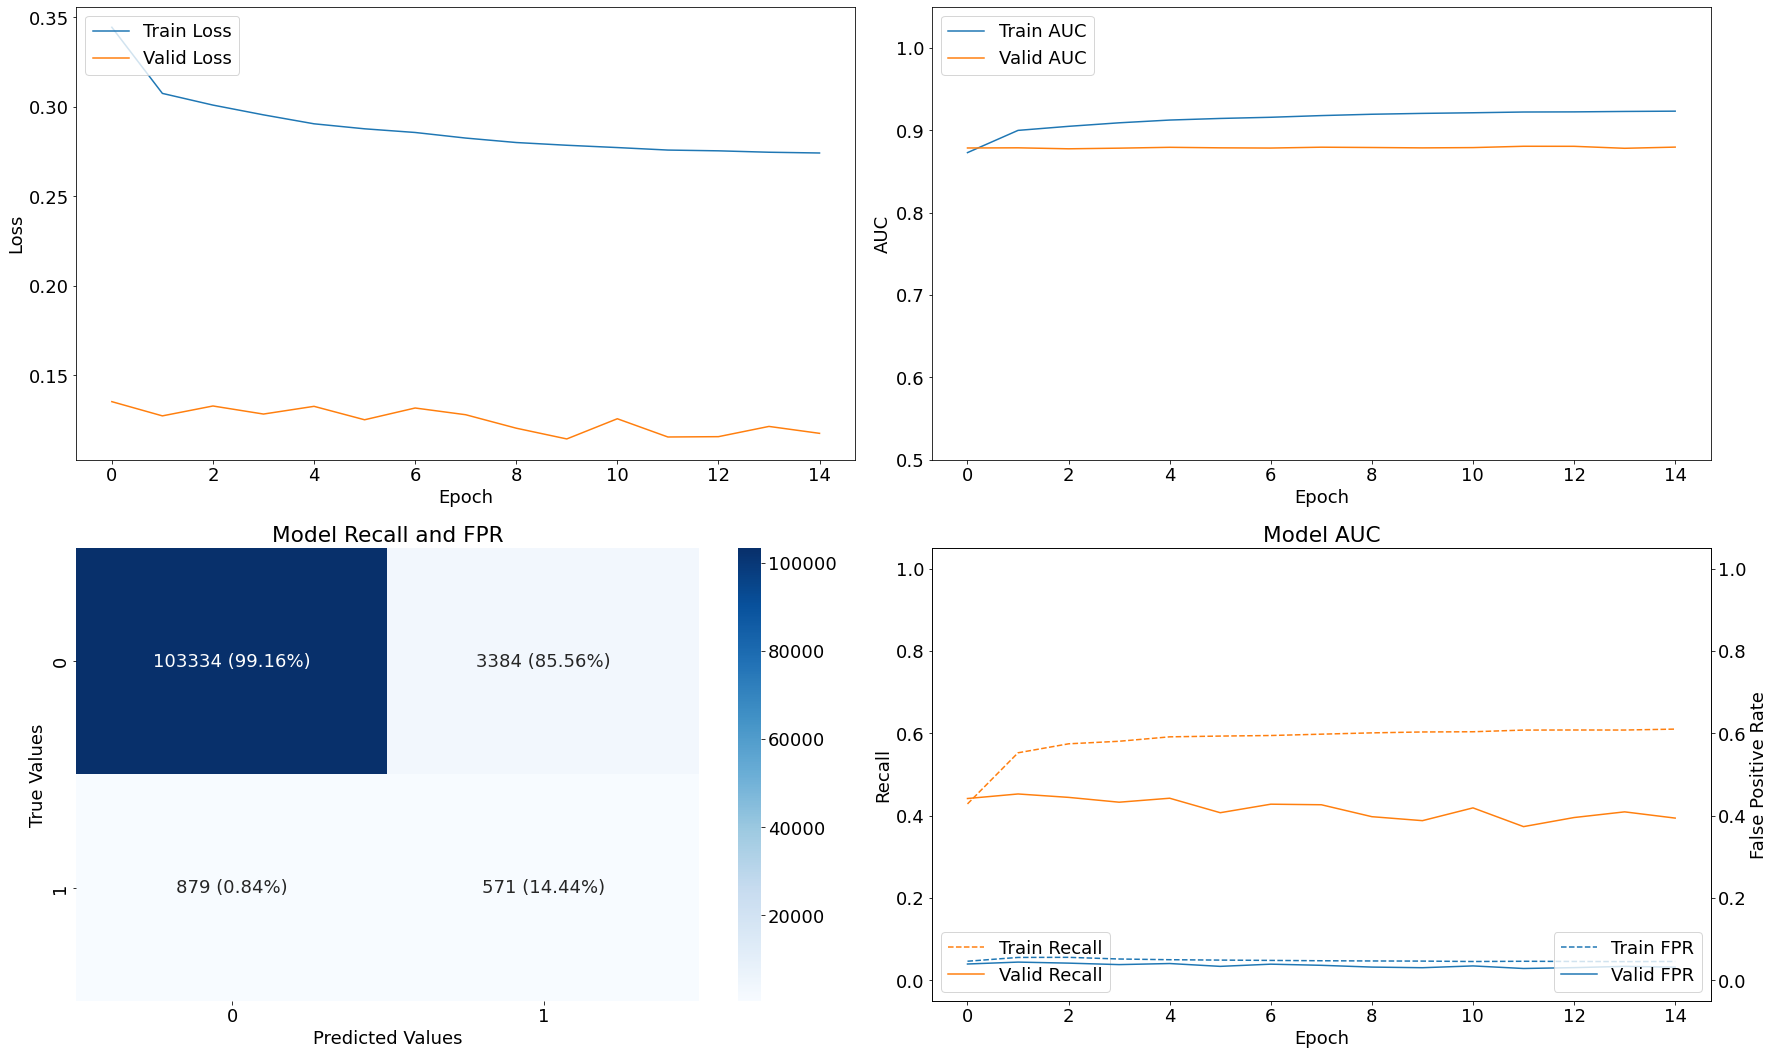

Epoch 00021: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6898386809618757 
 Val f1: 0.20823421380480664 

 Train Recall: 0.6253450512886047 
 Val Recall: 0.39241379499435425 

 Train FPR: 0.04691944271326065 
 Val FPR: 0.032290708273649216


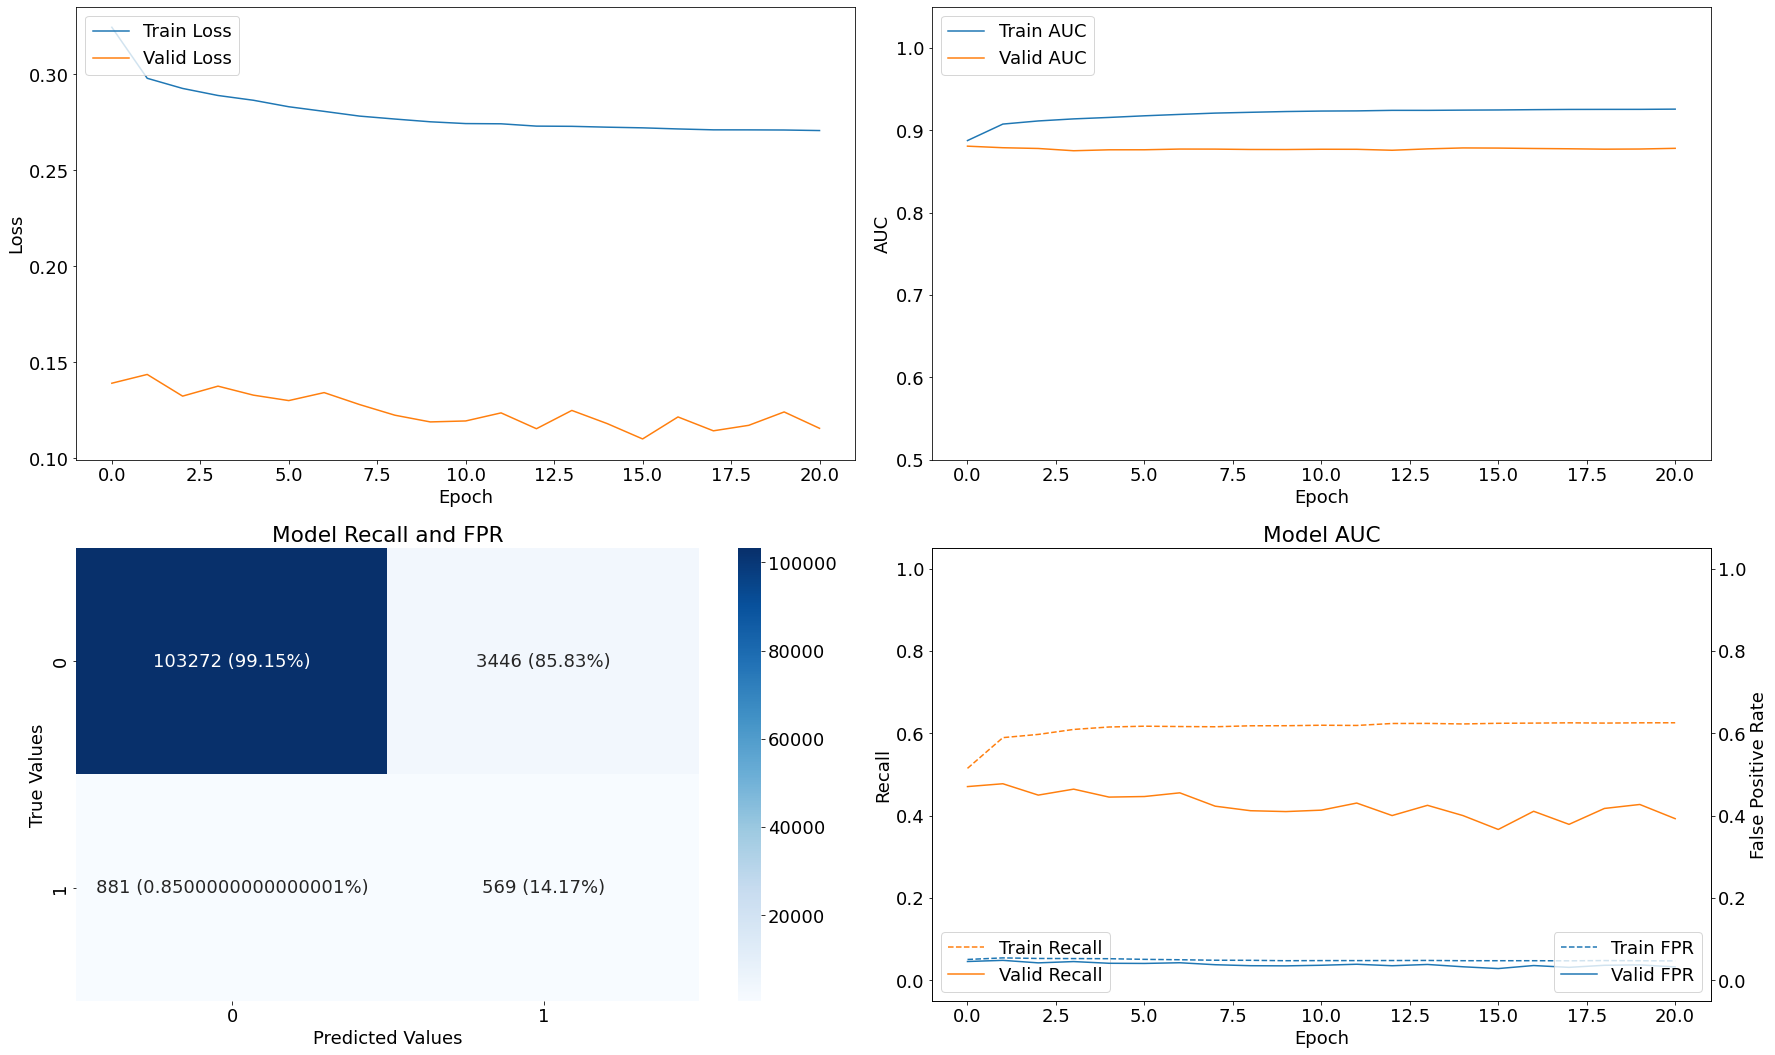

Epoch 00020: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6842587089157827 
 Val f1: 0.20905673668865438 

 Train Recall: 0.6154776811599731 
 Val Recall: 0.4027586281299591 

 Train FPR: 0.04587094113230705 
 Val FPR: 0.03329335153102875


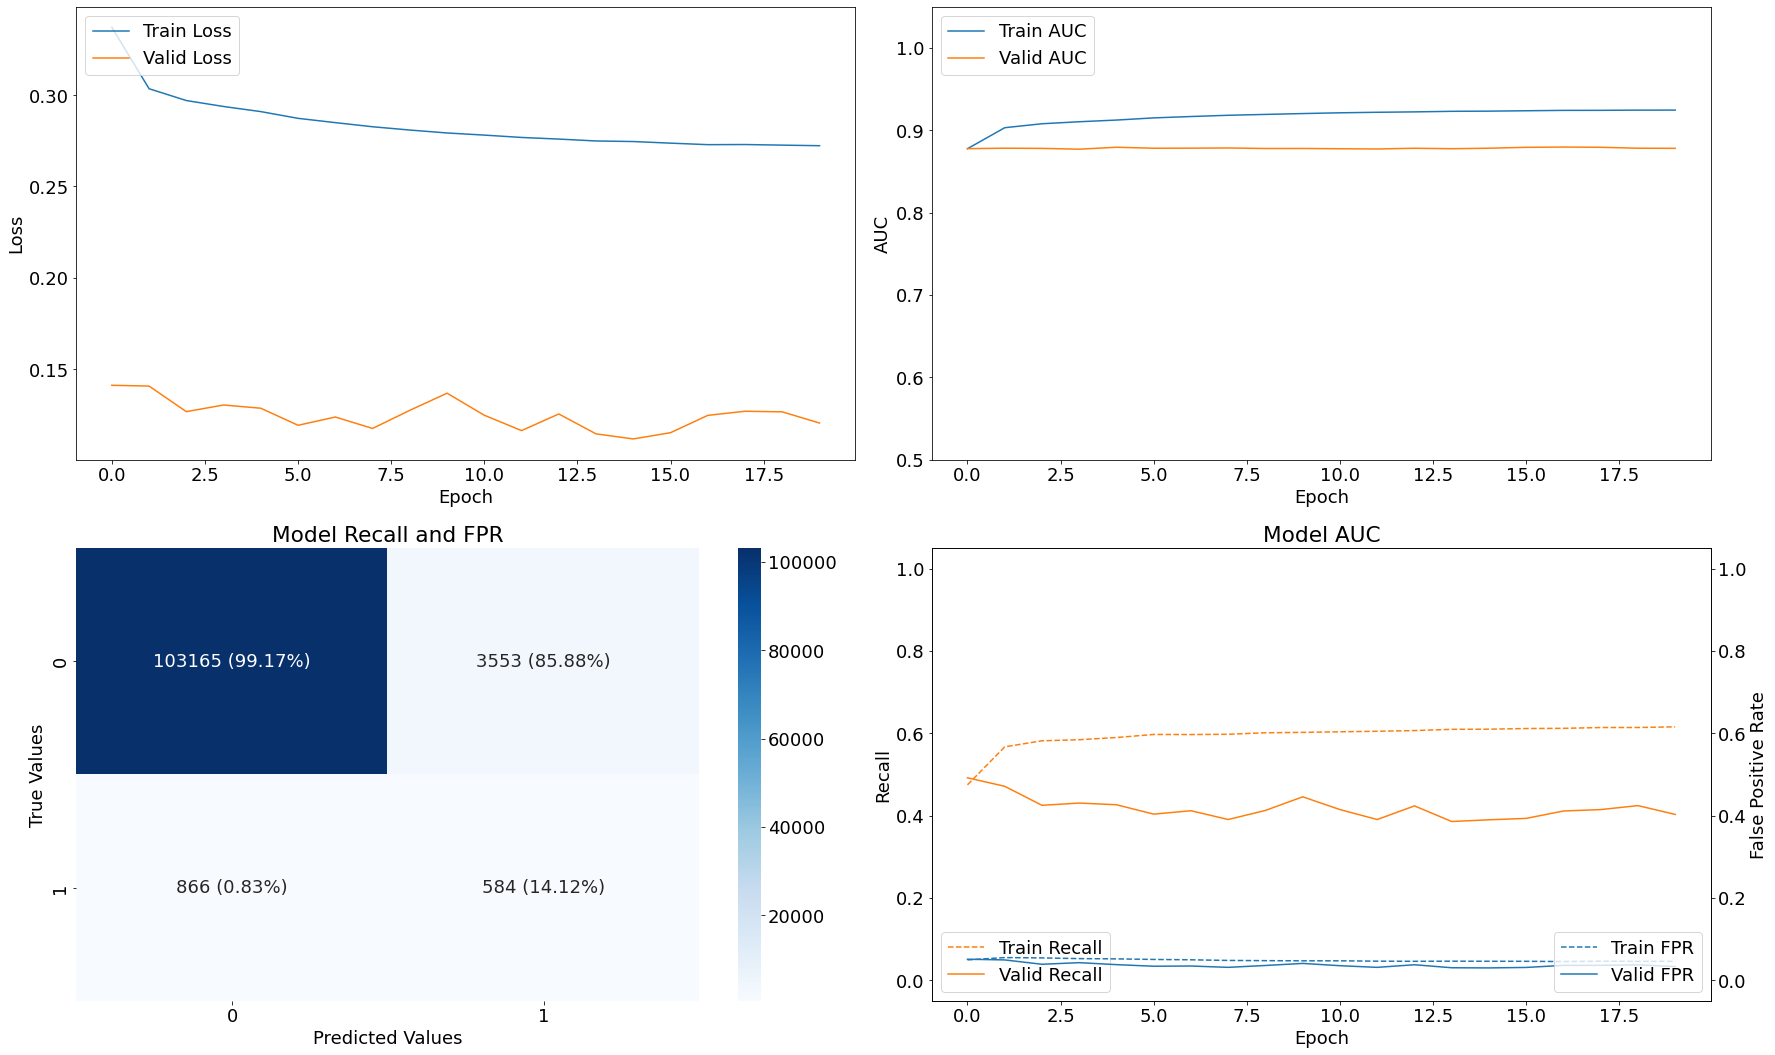

Epoch 00016: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6848764407501987 
 Val f1: 0.21191820025208127 

 Train Recall: 0.6151472330093384 
 Val Recall: 0.4144827723503113 

 Train FPR: 0.04530665650963783 
 Val FPR: 0.033930547535419464


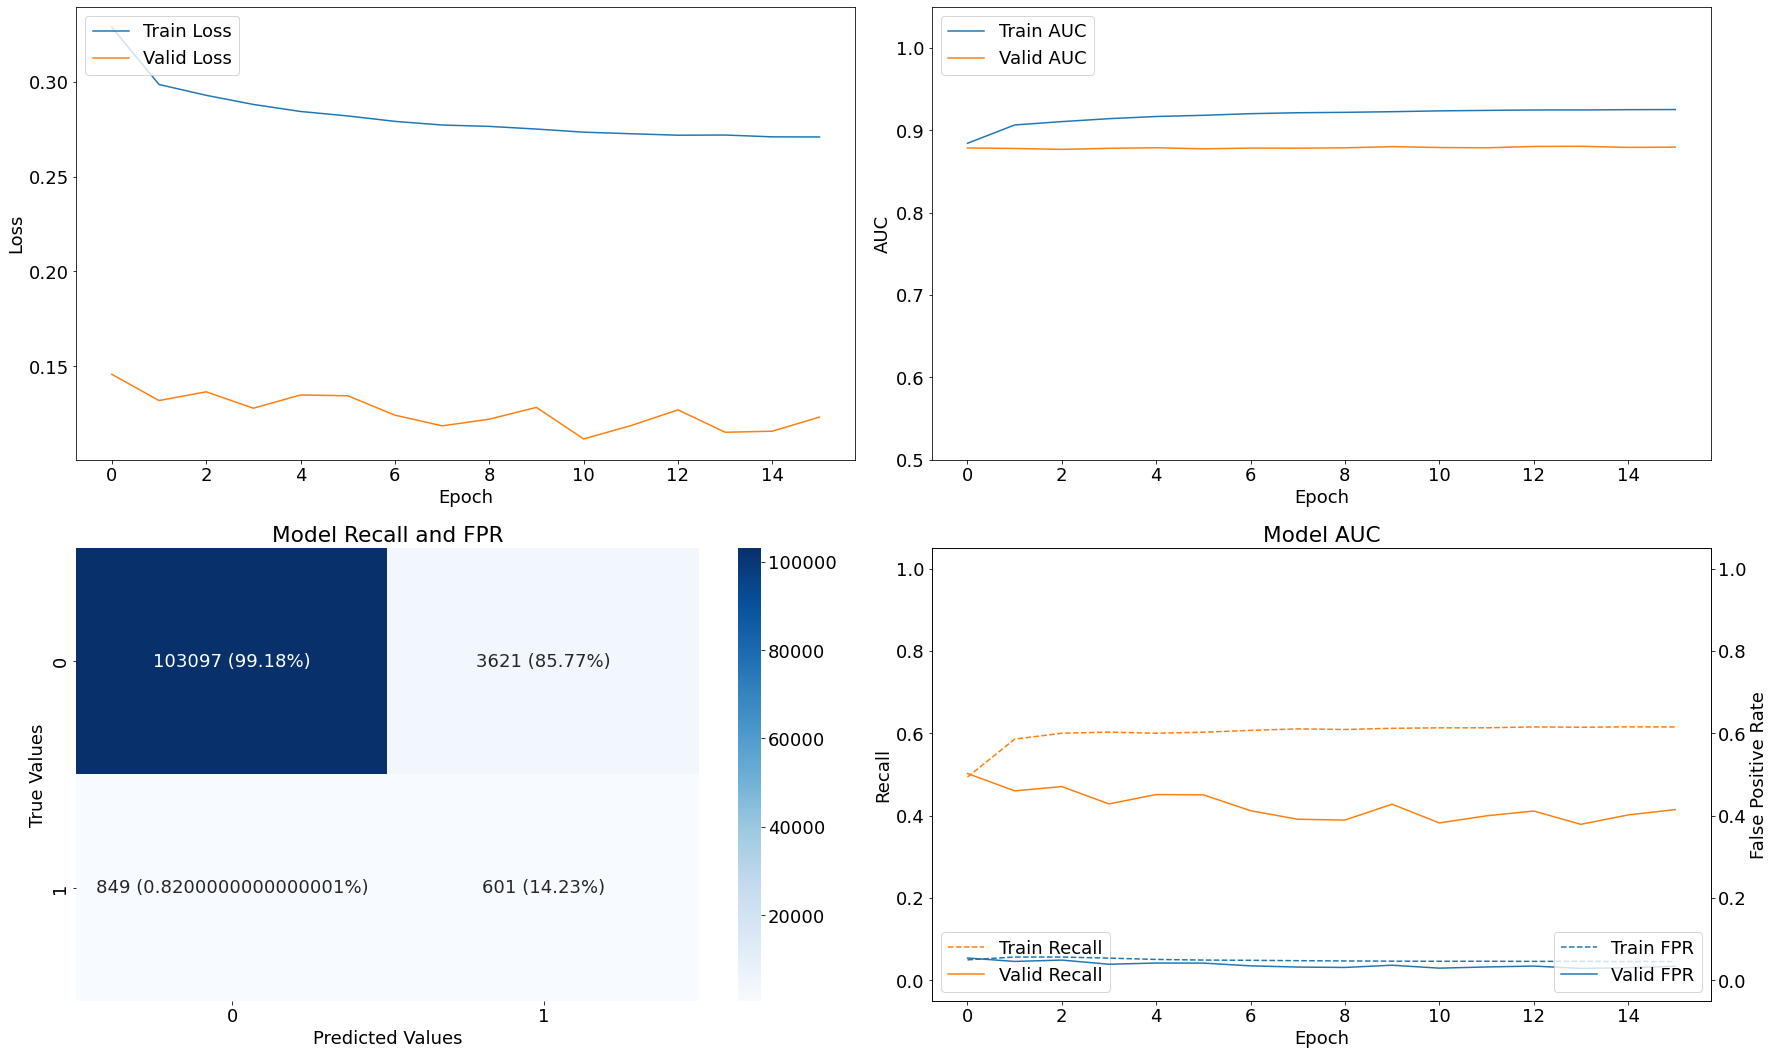

In [81]:
mu = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for m in mu:

    class_weight = create_class_weight({0: len(y_train_base == 0), 1: len(y_train_base == 1)}, mu=m)
    
    modelling_v4(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V4')

In [9]:
class_weight = create_class_weight({0: len(y_train_base == 0), 1: len(y_train_base == 1)}, mu=0.2)

Finally, a list of thresholds is created to loop over with the model. This will be a value inputted by the financial institution and represents the threshold for predicting fraud. For example, a value of 0.5 indicates that any prediction the model makes above 0.5 will be classified as fraud. A lower value will mean that less instances of account opening fraud will be missed at the cost of false positives. This can clearly be seen from the model evaluations below. This threshold would likely be set based on the number of false positives that the institution is comfortable with.

In [10]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

Epoch 00014: early stopping
Results for Base Model V4 with threshold = 0.5.

 Train f1: 0.6914158565589767 
 Val f1: 0.2119068164069159 

 Train Recall: 0.623616635799408 
 Val Recall: 0.42344826459884644 

 Train FPR: 0.045066457241773605 
 Val FPR: 0.03496129810810089


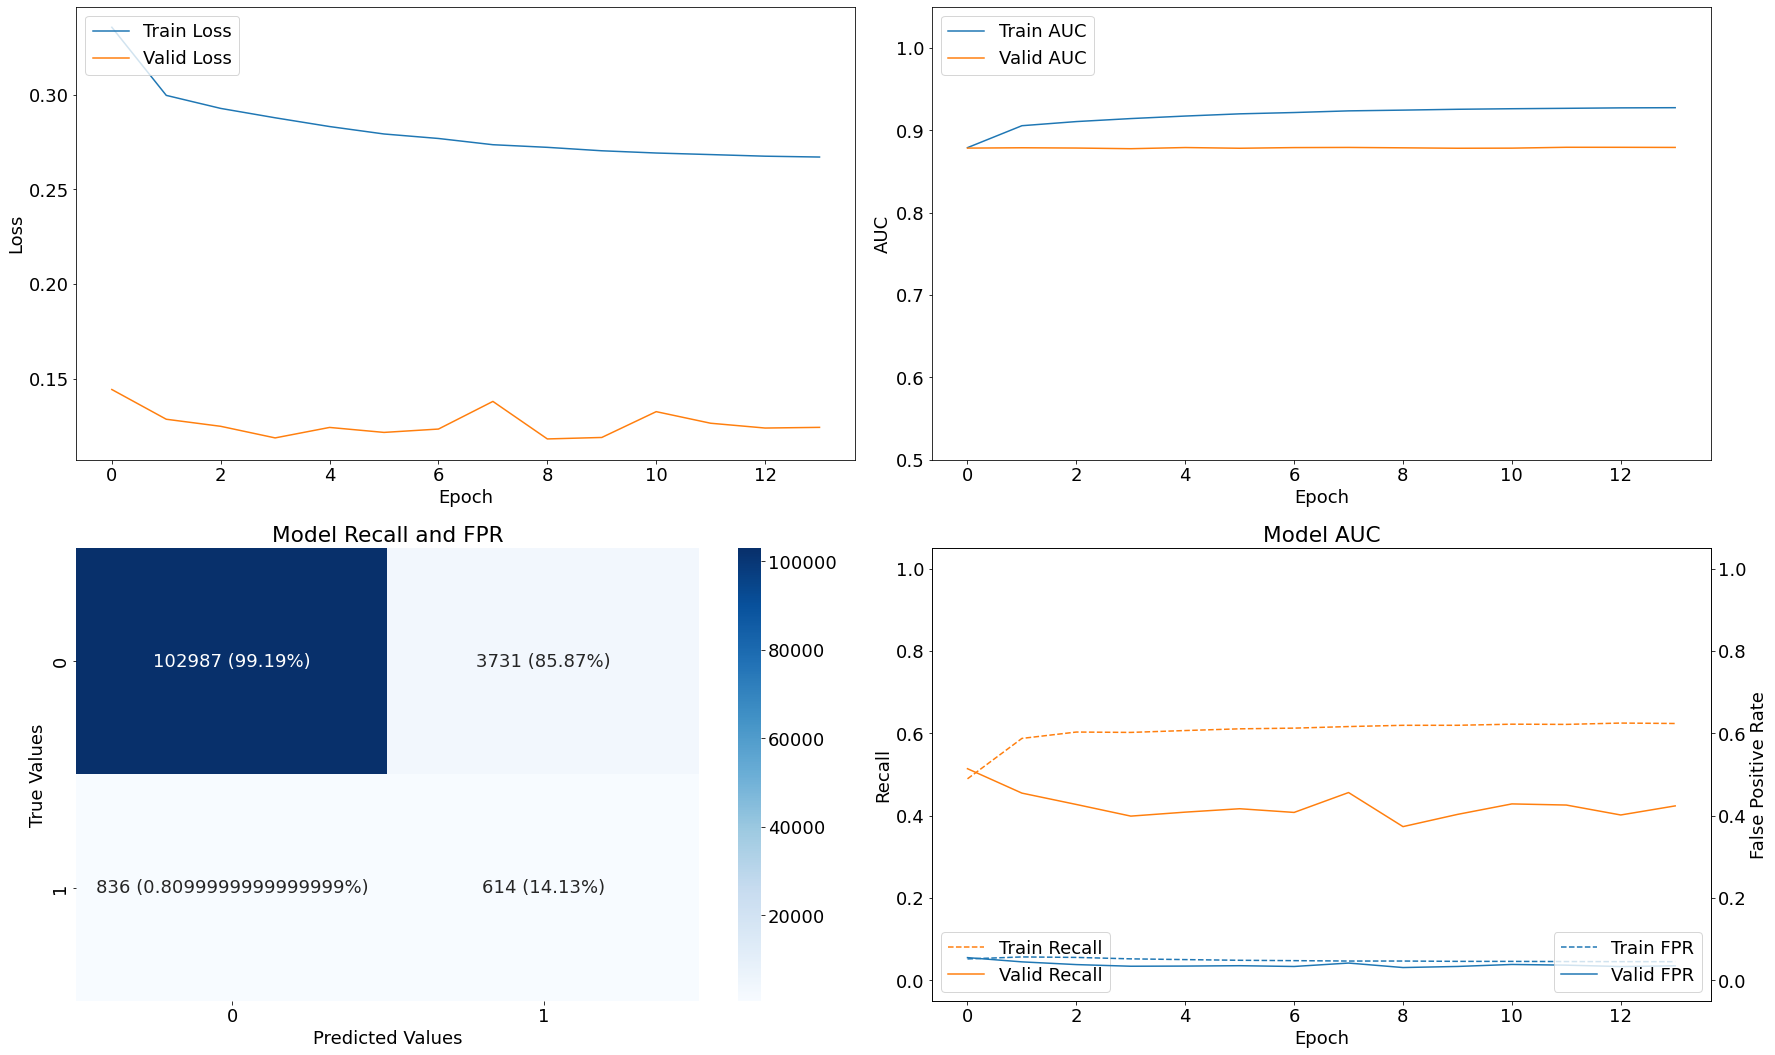

Epoch 00012: early stopping
Results for Base Model V4 with threshold = 0.4.

 Train f1: 0.7106175544984763 
 Val f1: 0.18783638605257028 

 Train Recall: 0.7018336653709412 
 Val Recall: 0.48137930035591125 

 Train FPR: 0.06836096197366714 
 Val FPR: 0.049513671547174454


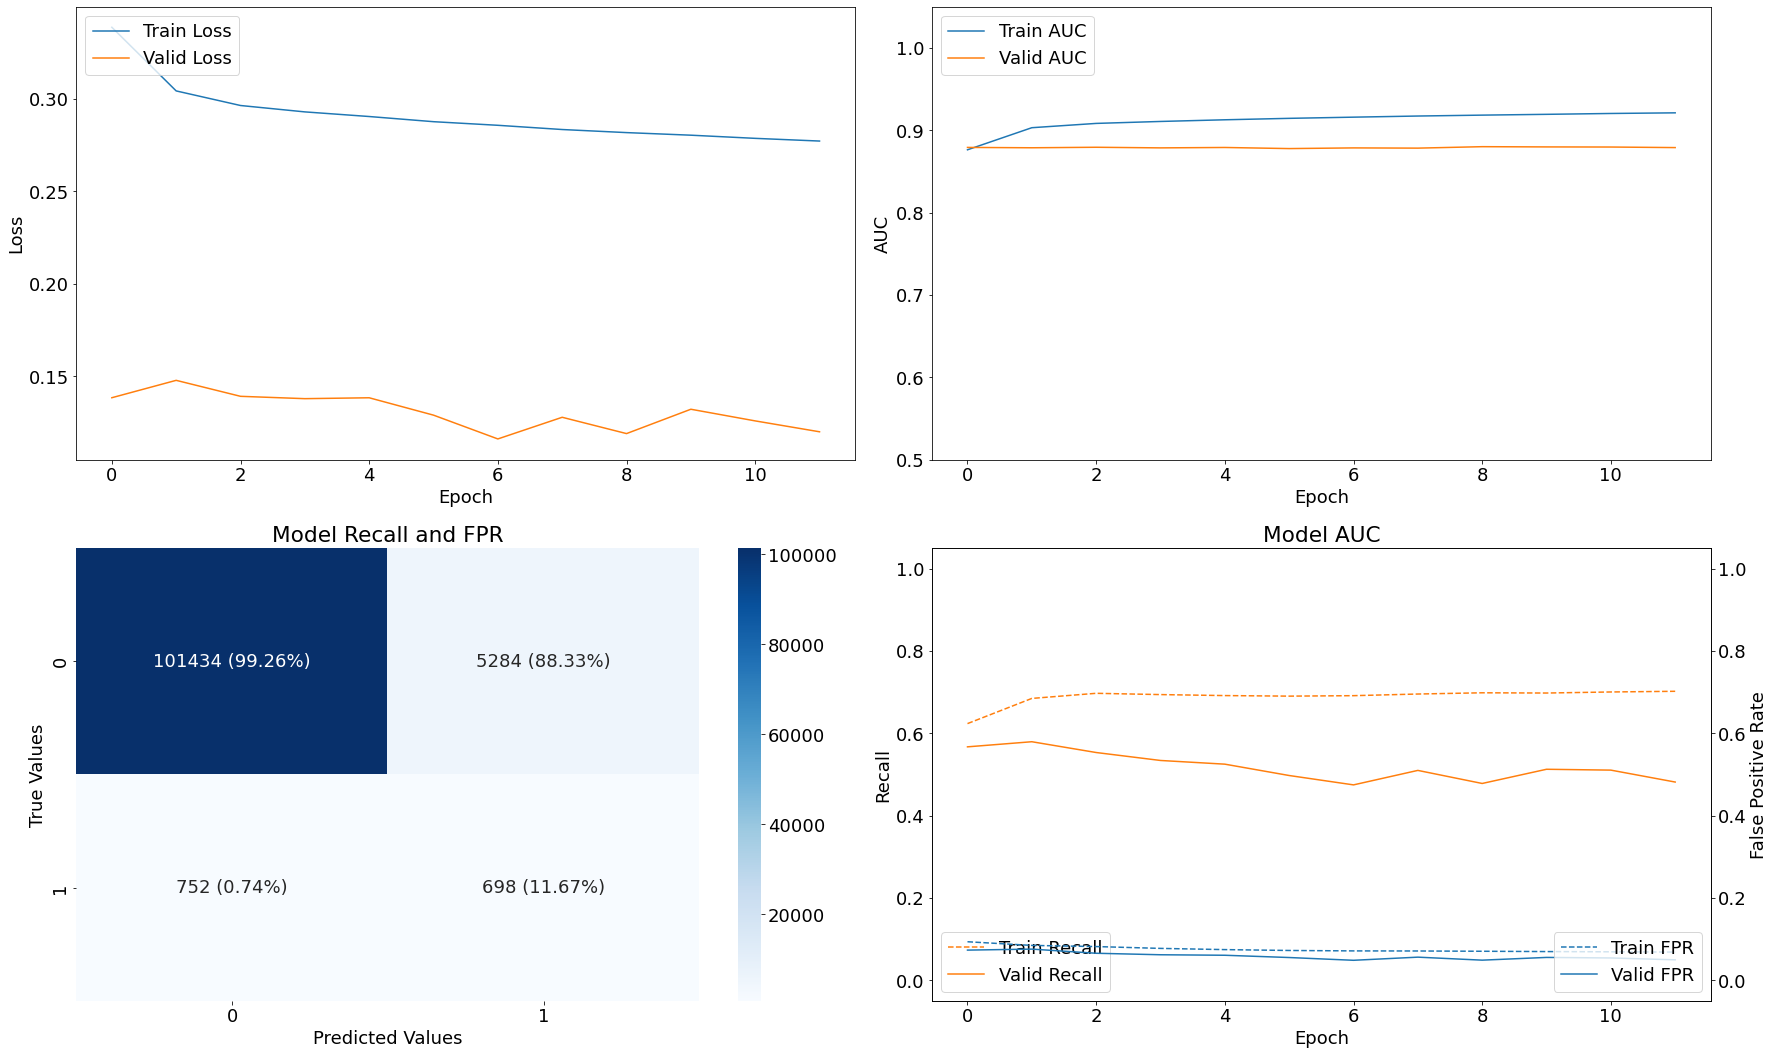

Epoch 00016: early stopping
Results for Base Model V4 with threshold = 0.3.

 Train f1: 0.7221236698246002 
 Val f1: 0.16114892881772636 

 Train Recall: 0.811076283454895 
 Val Recall: 0.595862090587616 

 Train FPR: 0.10882163792848587 
 Val FPR: 0.07879645377397537


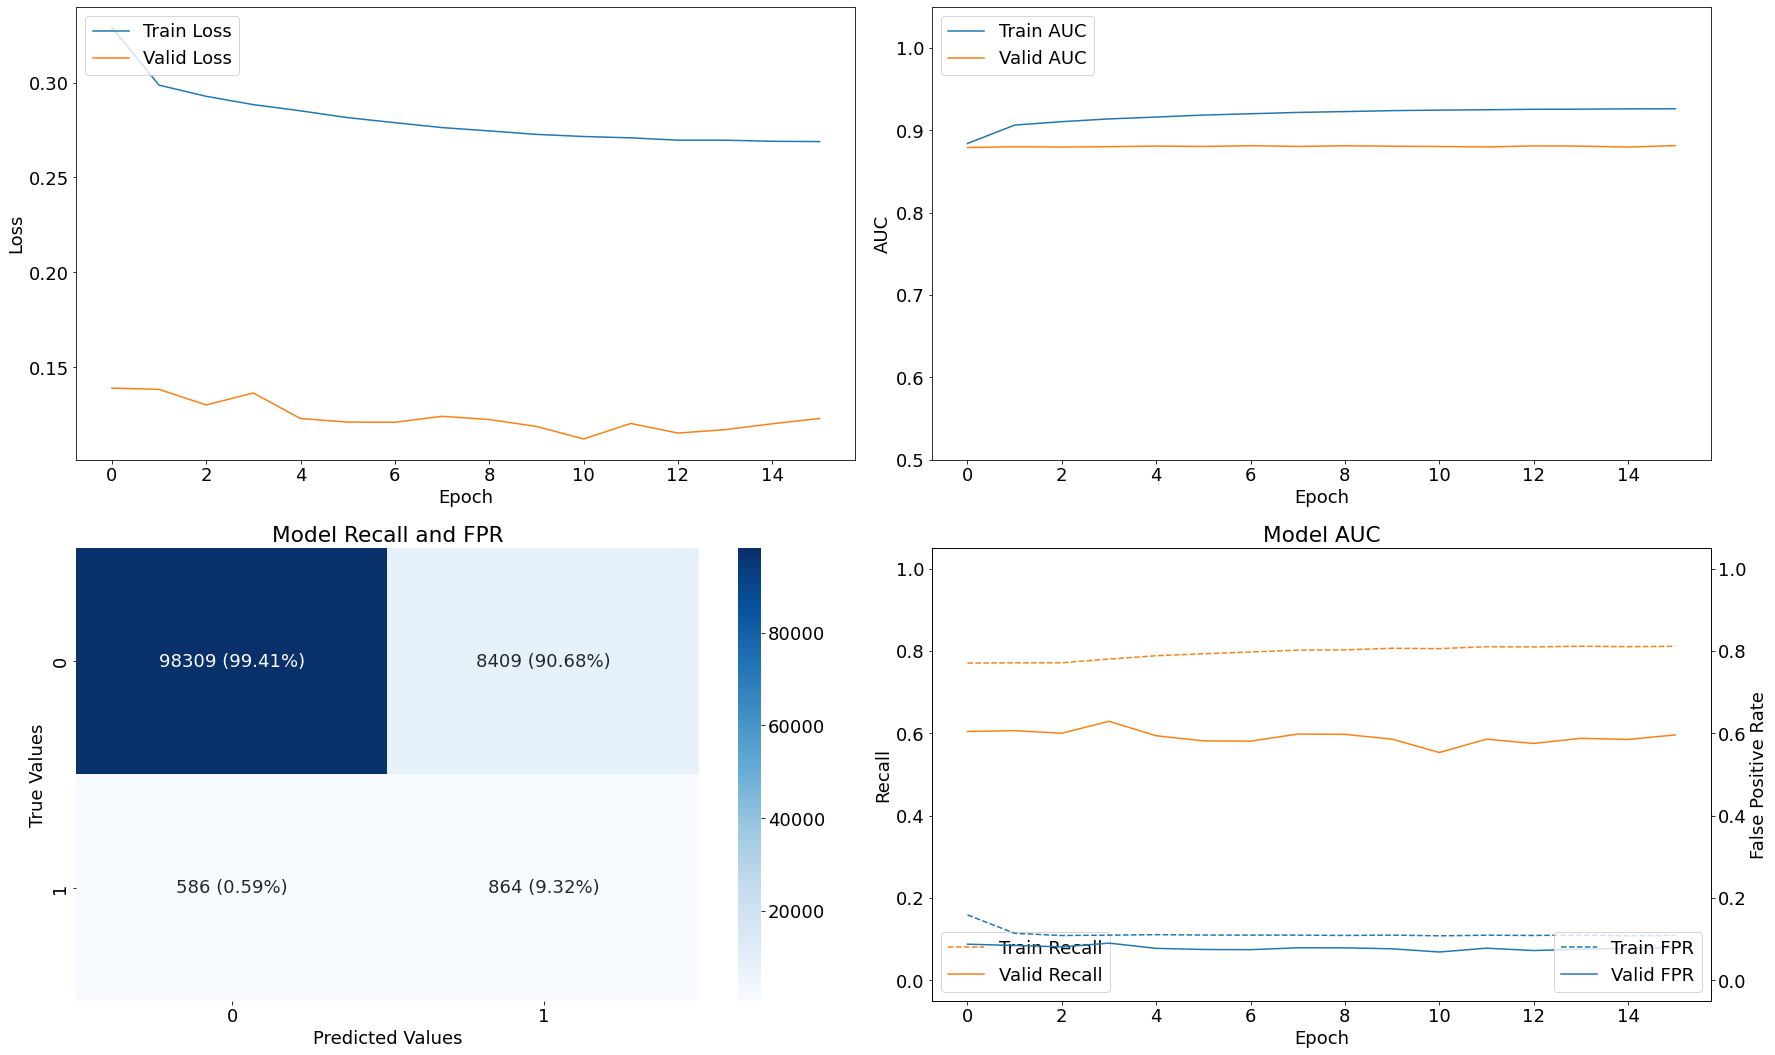

Epoch 00015: early stopping
Results for Base Model V4 with threshold = 0.2.

 Train f1: 0.6782496314731848 
 Val f1: 0.1300675653804488 

 Train Recall: 0.8895576596260071 
 Val Recall: 0.6903448104858398 

 Train FPR: 0.18338464200496674 
 Val FPR: 0.1212635189294815


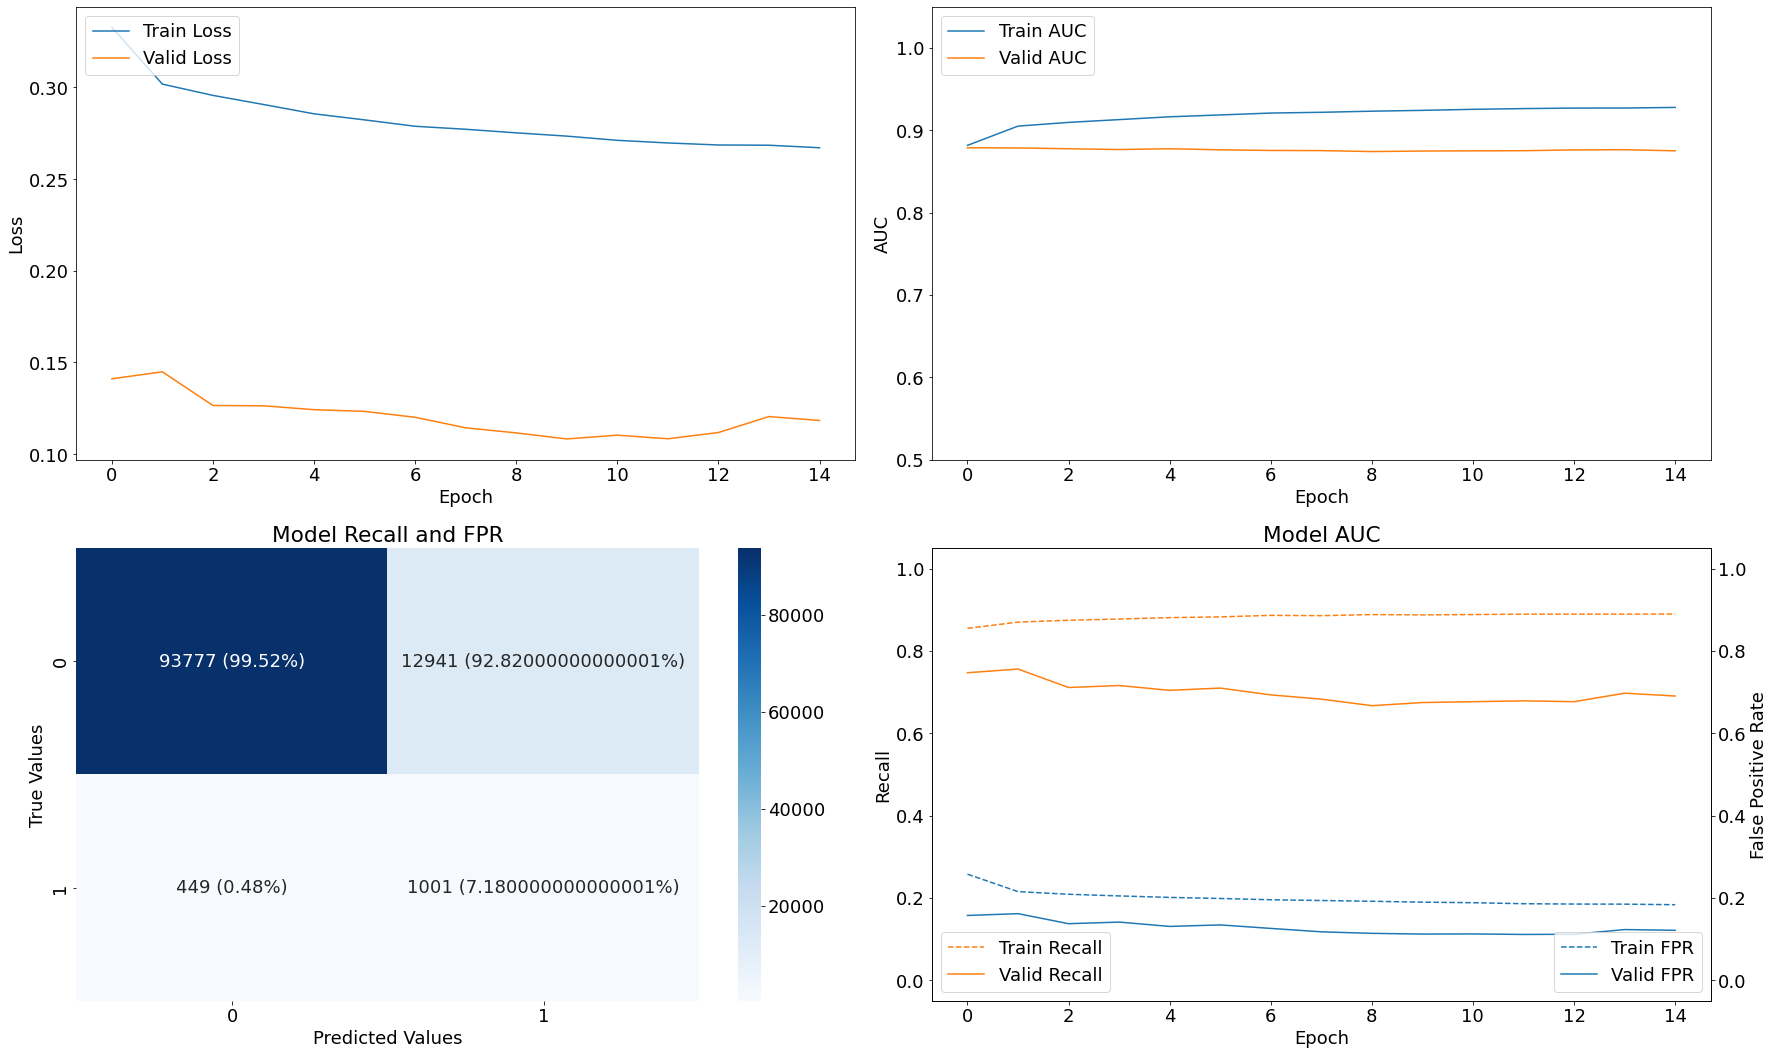

Epoch 00013: early stopping
Results for Base Model V4 with threshold = 0.1.

 Train f1: 0.5939856711837427 
 Val f1: 0.09437719342252443 

 Train Recall: 0.9389707446098328 
 Val Recall: 0.817241370677948 

 Train FPR: 0.30565503239631653 
 Val FPR: 0.21062050759792328


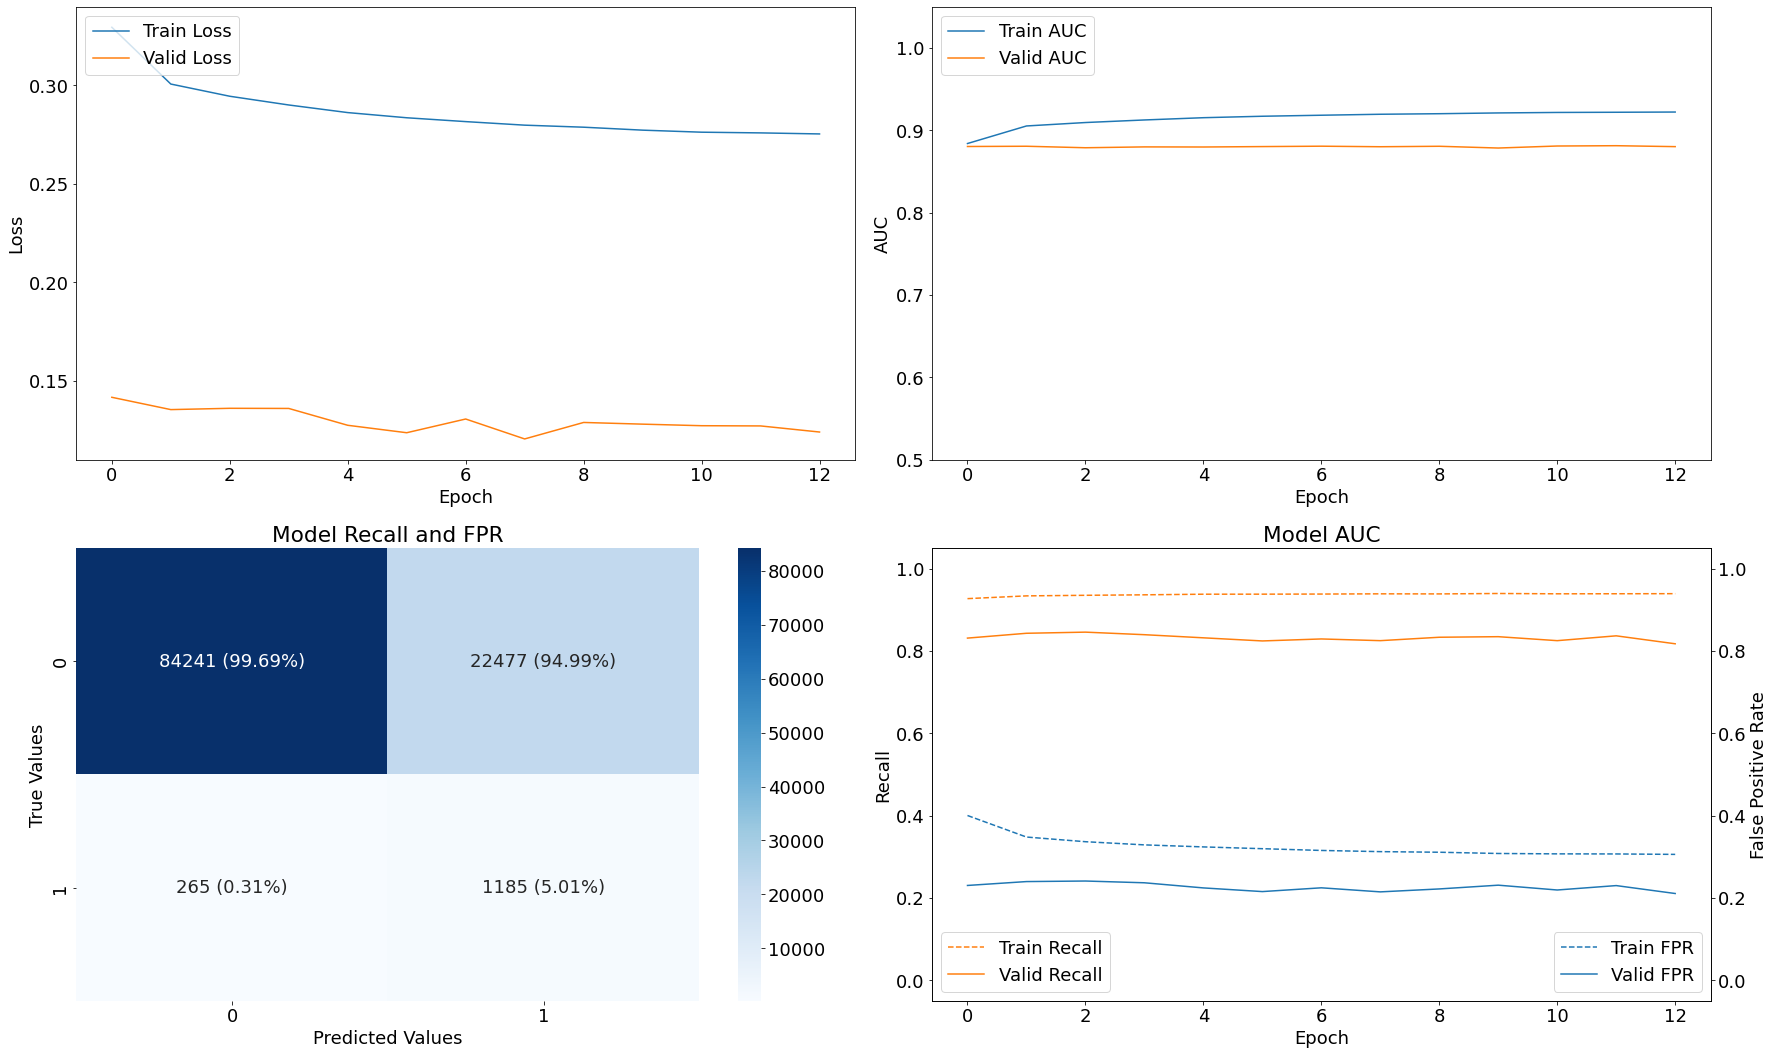

In [83]:
for t in thresholds:
    
    modelling_v4(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V4',
                 threshold=t)

---

### Fifth Model Iteration

For the fifth iteration of the model, a dense relu layer with dimensionality 8 is added after the second dropout layer. This layer is followed by another 50% dropout and then two dense relu layers with dimensionality 4 and 2 respectively, which are followed by the output layer. This addition of layers makes the model more complex and could yield better results.

In [84]:
def modelling_v5(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):

    model_v5 = models.Sequential()

    model_v5.add(layers.Input(shape=(n_features, )))
    model_v5.add(layers.Dense(32, activation='relu'))
    model_v5.add(layers.Dropout(0.5))
    model_v5.add(layers.Dense(16, activation='relu'))
    model_v5.add(layers.Dropout(0.5))
    model_v5.add(layers.Dense(8, activation='relu'))
    model_v5.add(layers.Dropout(0.5))
    model_v5.add(layers.Dense(4, activation='relu'))
    model_v5.add(layers.Dense(2, activation='relu'))
    model_v5.add(layers.Dense(1, activation='sigmoid'))

    model_v5.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v5_history = model_v5.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs,
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v5,
             name,
             model_v5_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00007: early stopping
Results for Base Model V5 with threshold = 0.5.

 Train f1: 0.6645008562960303 
 Val f1: 0.1543575938582216 

 Train Recall: 0.6322130560874939 
 Val Recall: 0.5924137830734253 

 Train FPR: 0.06765179336071014 
 Val FPR: 0.0826570987701416


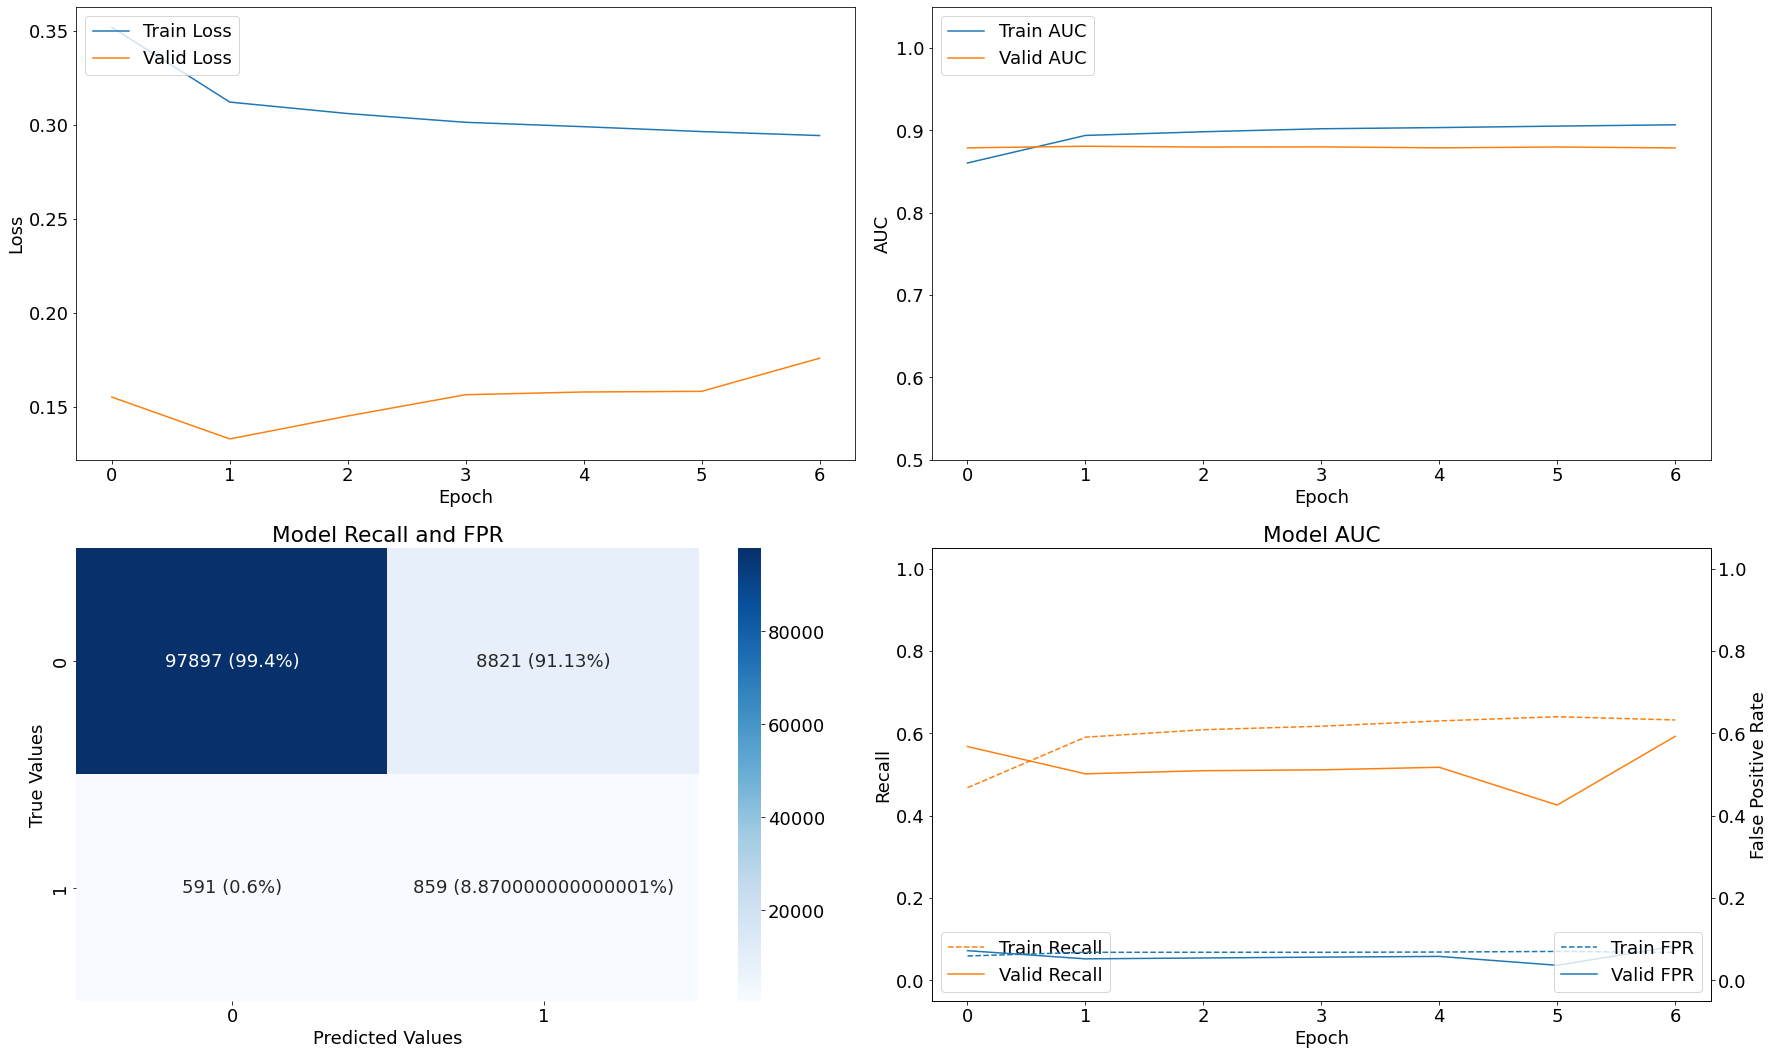

Epoch 00011: early stopping
Results for Base Model V5 with threshold = 0.4.

 Train f1: 0.6750816451191829 
 Val f1: 0.1780341556187835 

 Train Recall: 0.6693847179412842 
 Val Recall: 0.5427586436271667 

 Train FPR: 0.07843419164419174 
 Val FPR: 0.06188271939754486


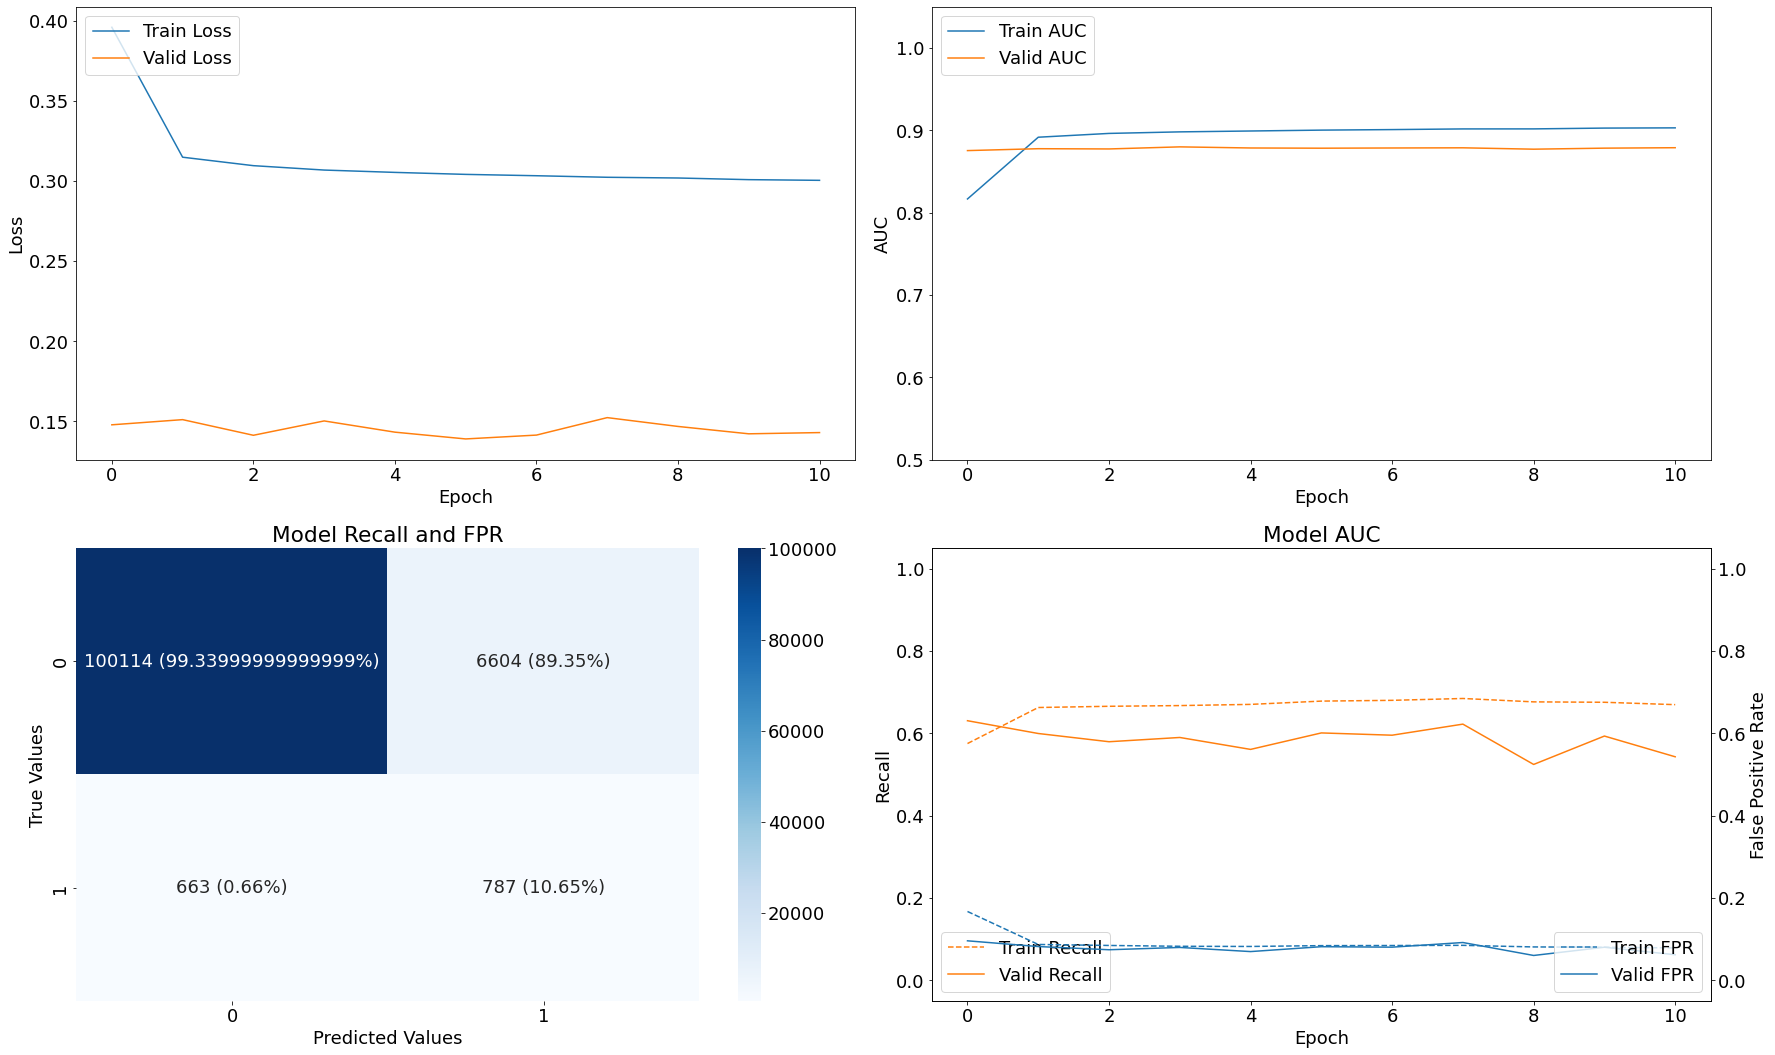

Epoch 00007: early stopping
Results for Base Model V5 with threshold = 0.3.

 Train f1: 0.6901027529089233 
 Val f1: 0.04764274824077533 

 Train Recall: 0.815483808517456 
 Val Recall: 0.9572413563728333 

 Train FPR: 0.13697101175785065 
 Val FPR: 0.5193969011306763


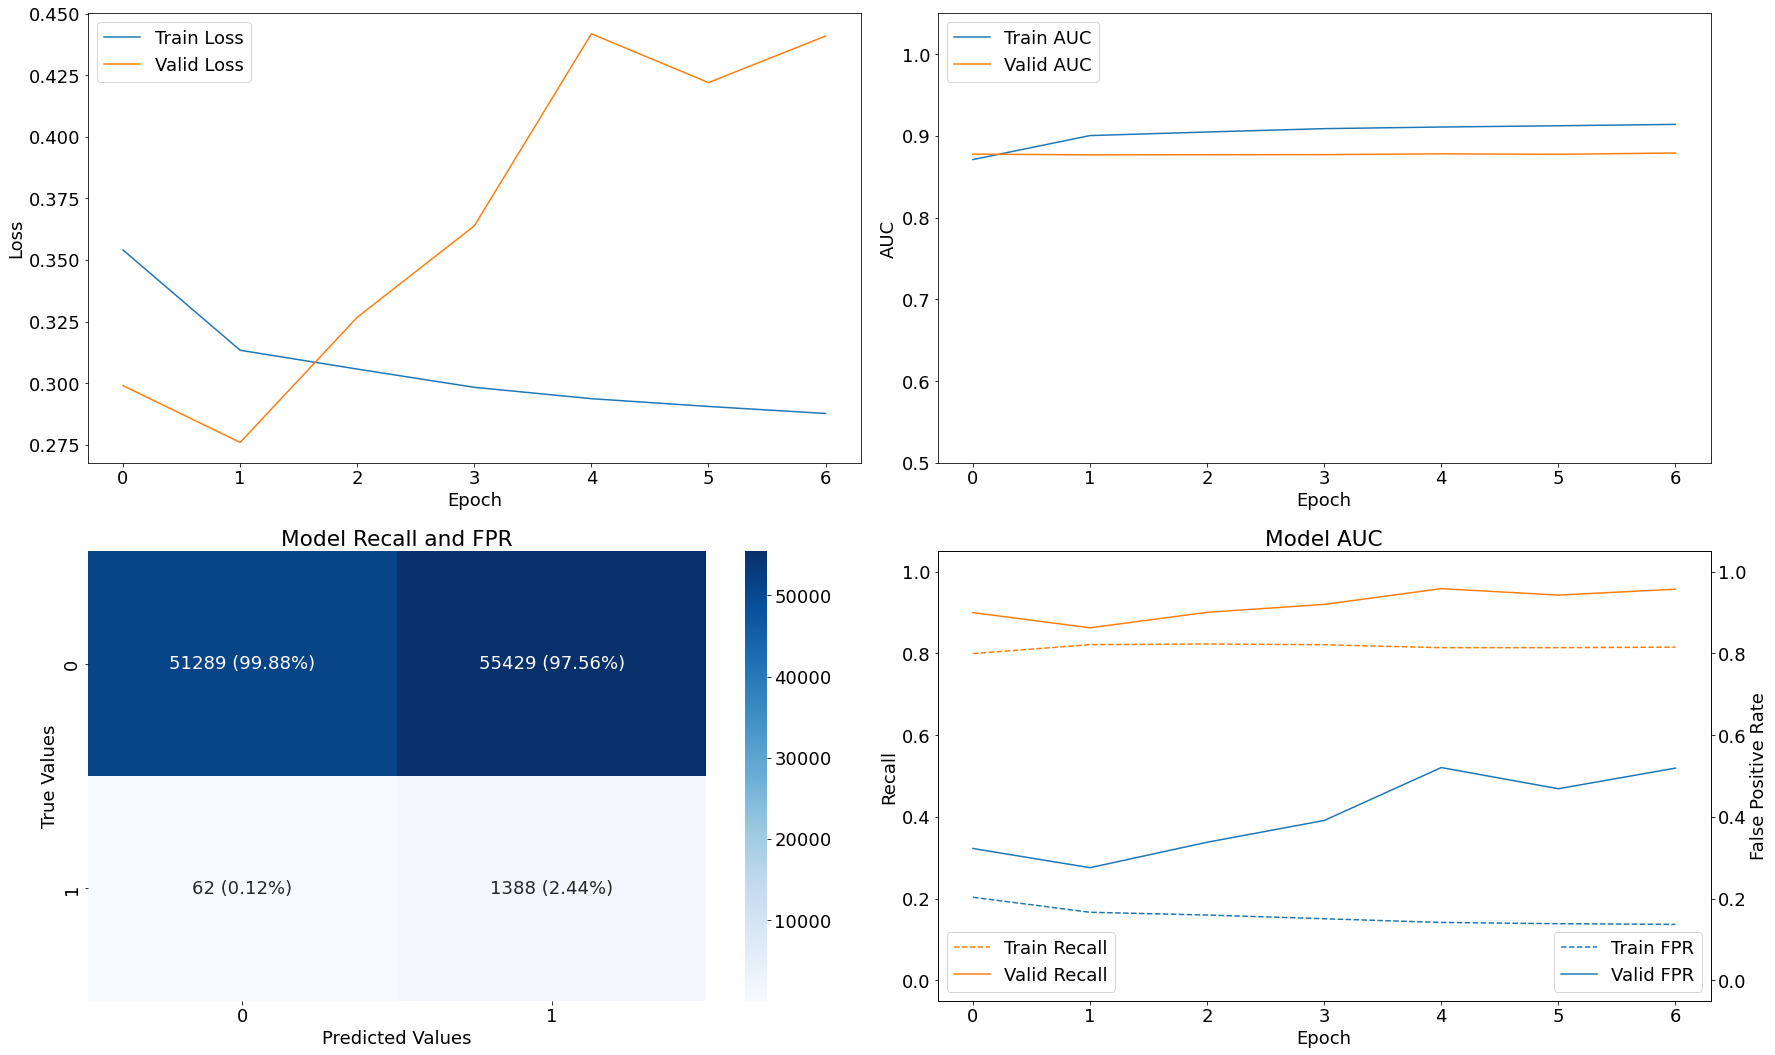

Epoch 00006: early stopping
Results for Base Model V5 with threshold = 0.2.

 Train f1: 0.64782951911868 
 Val f1: 0.06554999651161487 

 Train Recall: 0.8887900114059448 
 Val Recall: 0.904137909412384 

 Train FPR: 0.21377716958522797 
 Val FPR: 0.3489477038383484


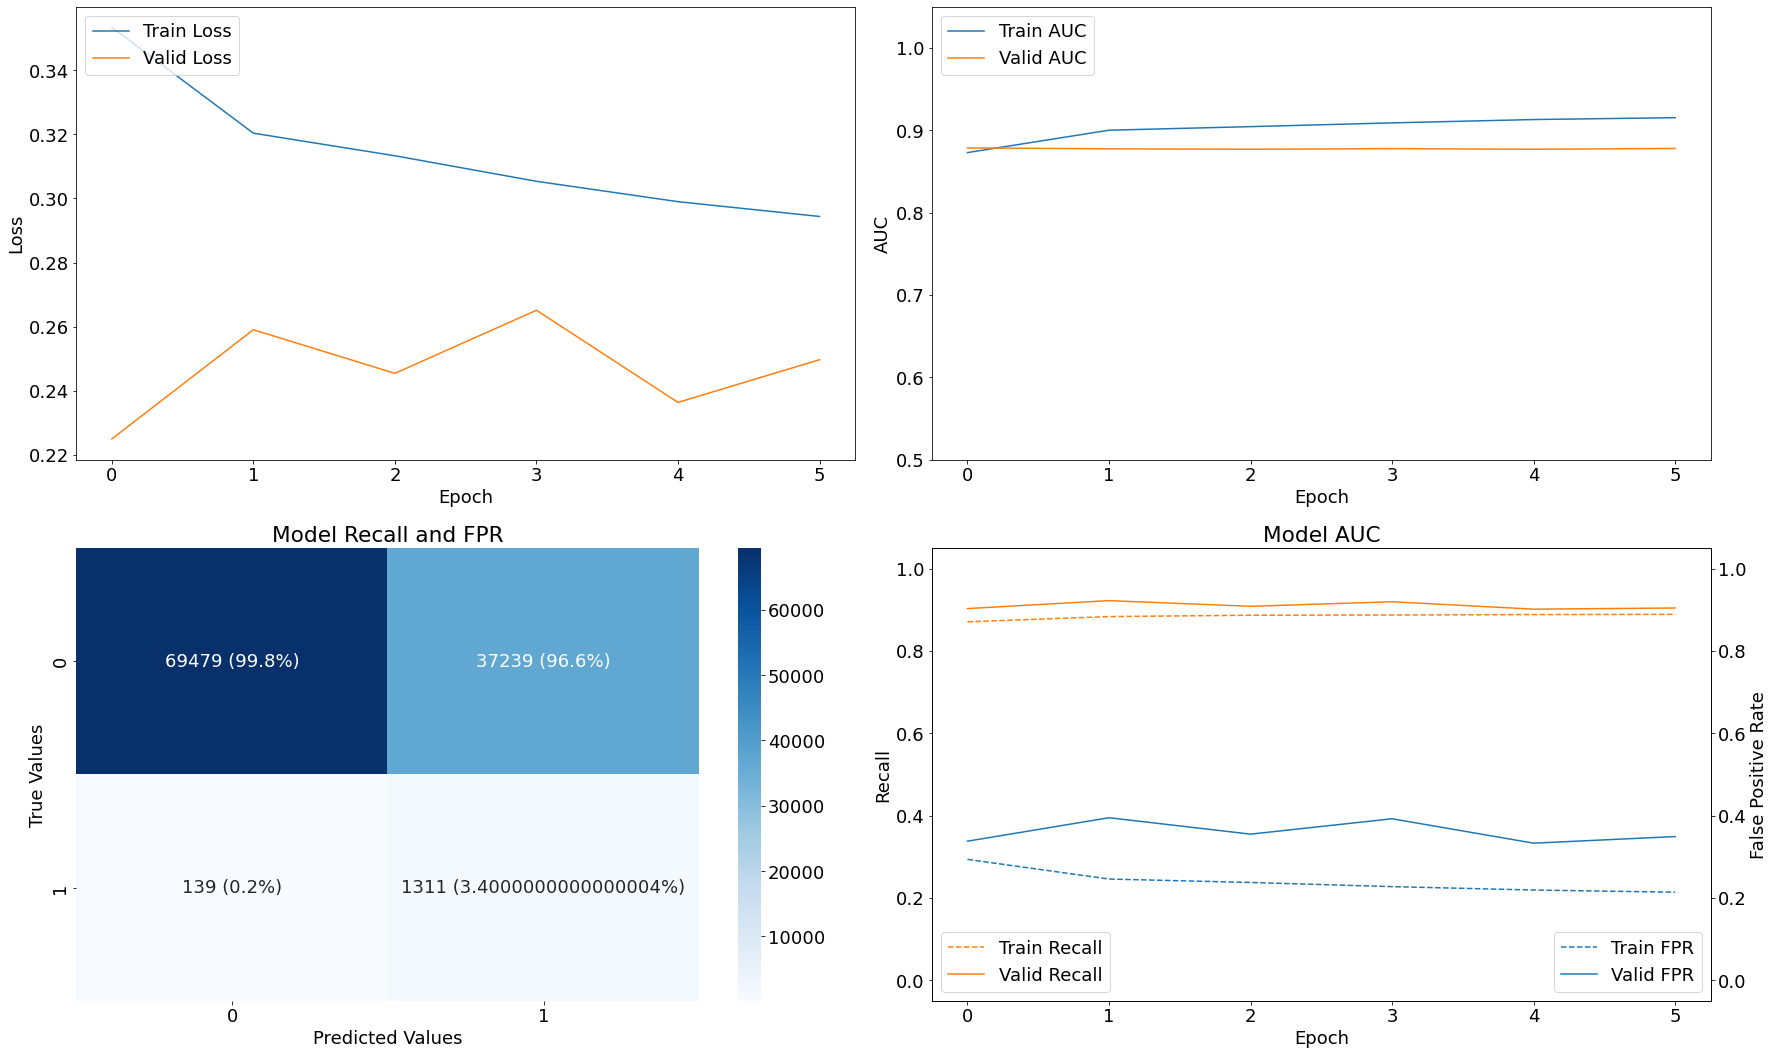

Epoch 00015: early stopping
Results for Base Model V5 with threshold = 0.1.

 Train f1: 0.6028124217619856 
 Val f1: 0.10214167978418412 

 Train Recall: 0.9308674335479736 
 Val Recall: 0.791034460067749 

 Train FPR: 0.289386123418808 
 Val FPR: 0.18611668050289154


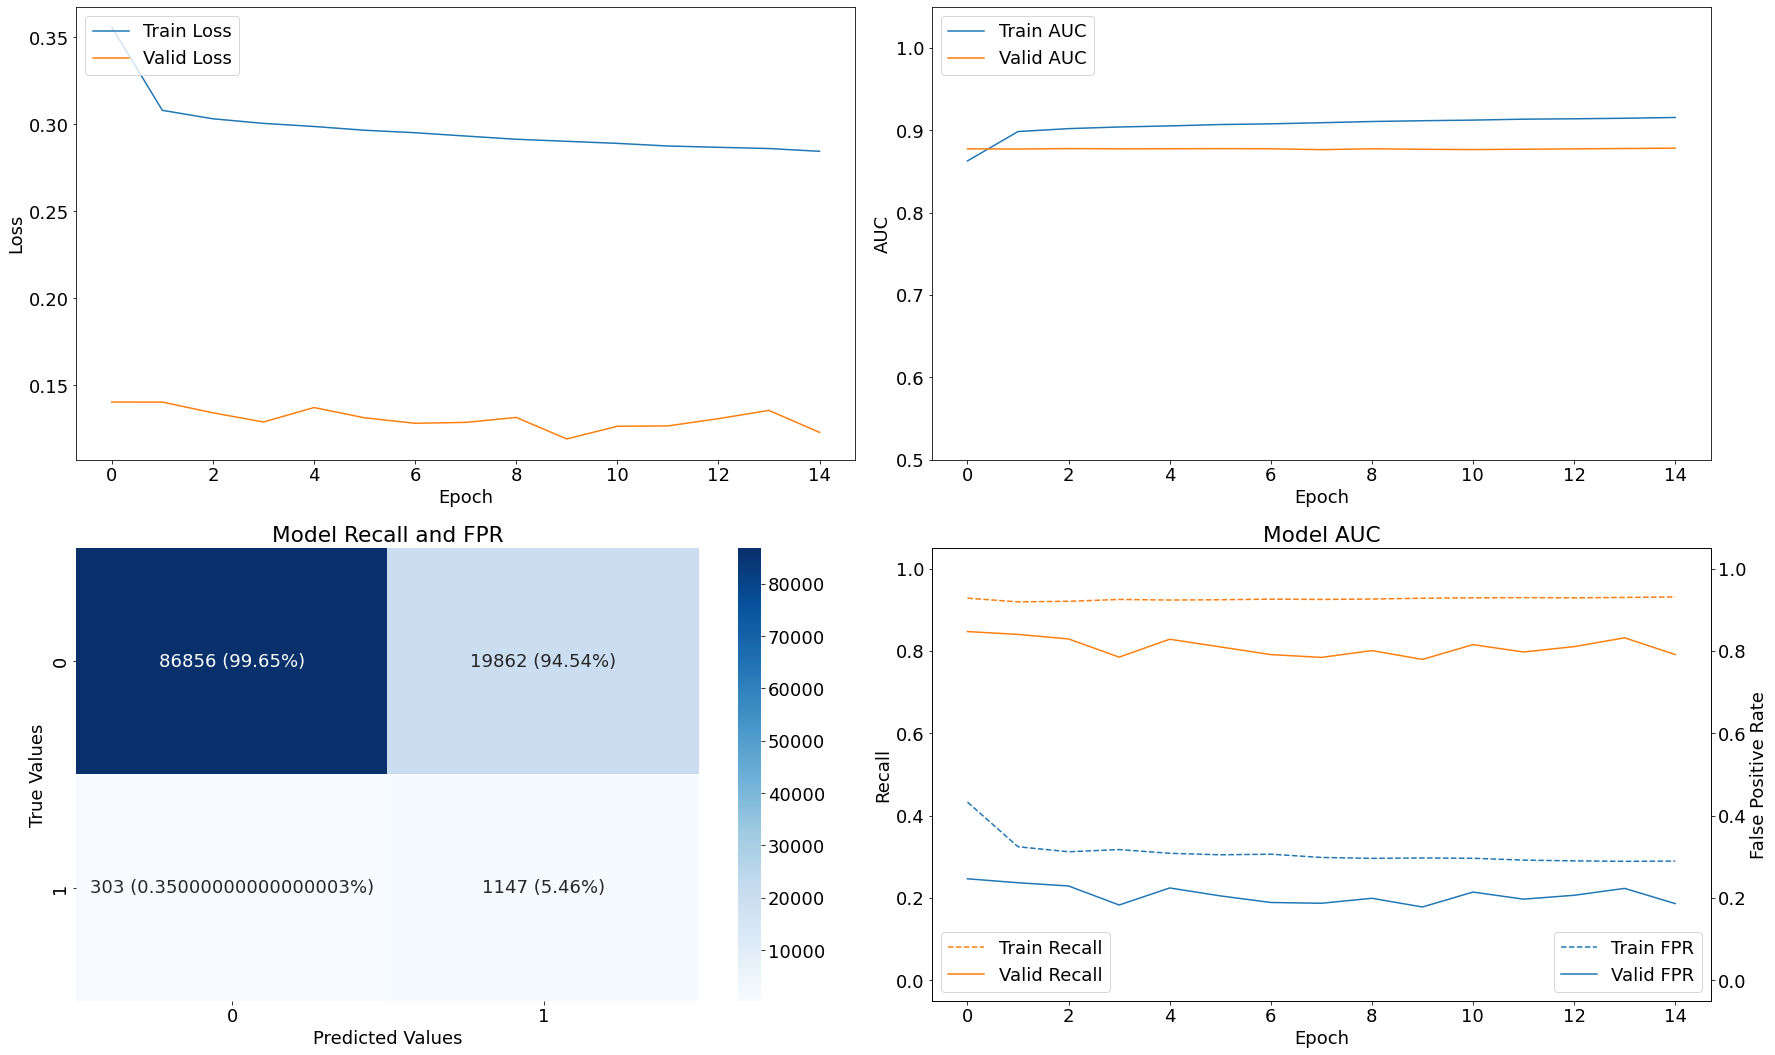

In [85]:
for t in thresholds:
    
    modelling_v5(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V5',
                 threshold=t)

---

### Sixth Model Iteration

For the next iteration, we are going to use the same model structure as `modelling_v4`. However, the activation of the dense layers will be changed to selu and with a lecun normal kernel initializer, which helps to normalize the output variance. The dropout layers are also changed to 25% alpha dropout layers, which preserve self-normalizing properties even after dropout.

In [86]:
def modelling_v6(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):     
    
    model_v6 = models.Sequential()

    model_v6.add(layers.Input(shape=(n_features, )))
    model_v6.add(layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'))
    model_v6.add(layers.AlphaDropout(0.25))
    model_v6.add(layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    model_v6.add(layers.AlphaDropout(0.25))
    model_v6.add(layers.Dense(1, activation='sigmoid'))

    model_v6.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v6_history = model_v6.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs, 
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v6,
             name,
             model_v6_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00025: early stopping
Results for Base Model V6 with threshold = 0.5.

 Train f1: 0.7631849155955076 
 Val f1: 0.20395387529780368 

 Train Recall: 0.7175472378730774 
 Val Recall: 0.4268965423107147 

 Train FPR: 0.0407135896384716 
 Val FPR: 0.0374913327395916


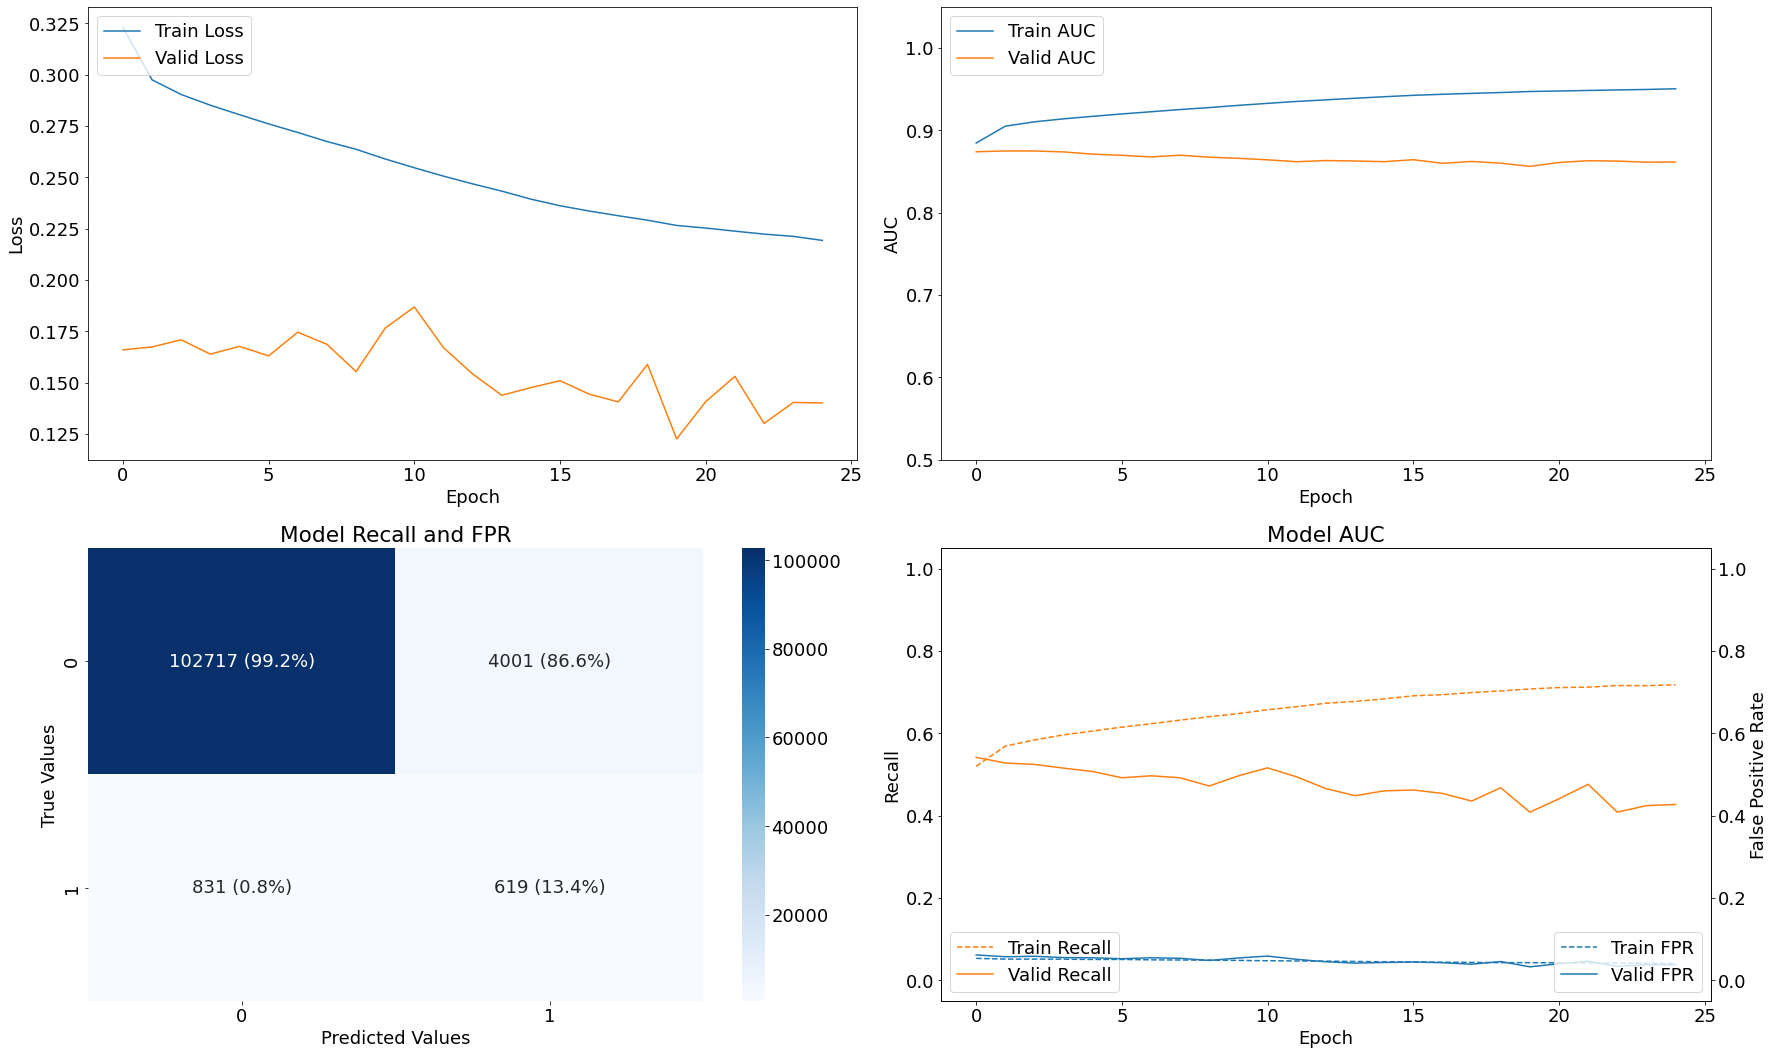

Epoch 00006: early stopping
Results for Base Model V6 with threshold = 0.4.

 Train f1: 0.7013516805936296 
 Val f1: 0.1553802120869943 

 Train Recall: 0.7203839421272278 
 Val Recall: 0.6179310083389282 

 Train FPR: 0.08347207307815552 
 Val FPR: 0.0860866978764534


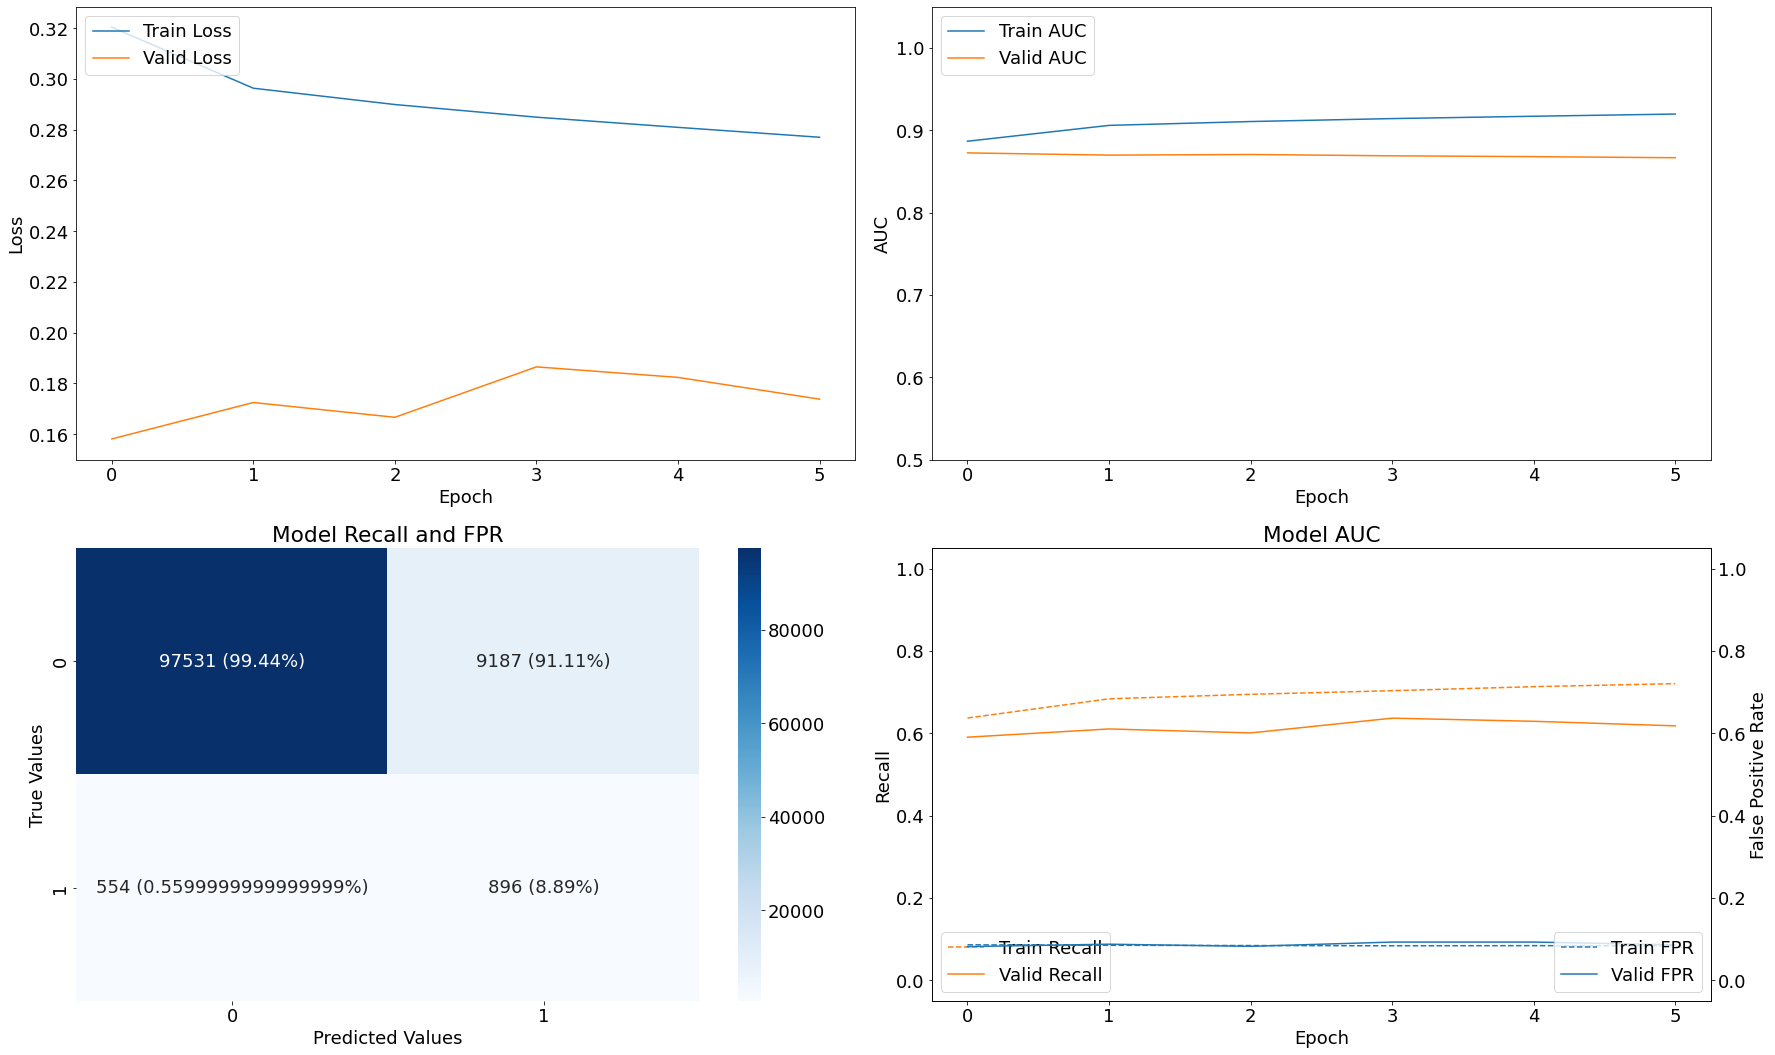

Epoch 00010: early stopping
Results for Base Model V6 with threshold = 0.3.

 Train f1: 0.7185087272800663 
 Val f1: 0.1688176524133668 

 Train Recall: 0.7929022312164307 
 Val Recall: 0.5593103170394897 

 Train FPR: 0.10354354977607727 
 Val FPR: 0.0688449963927269


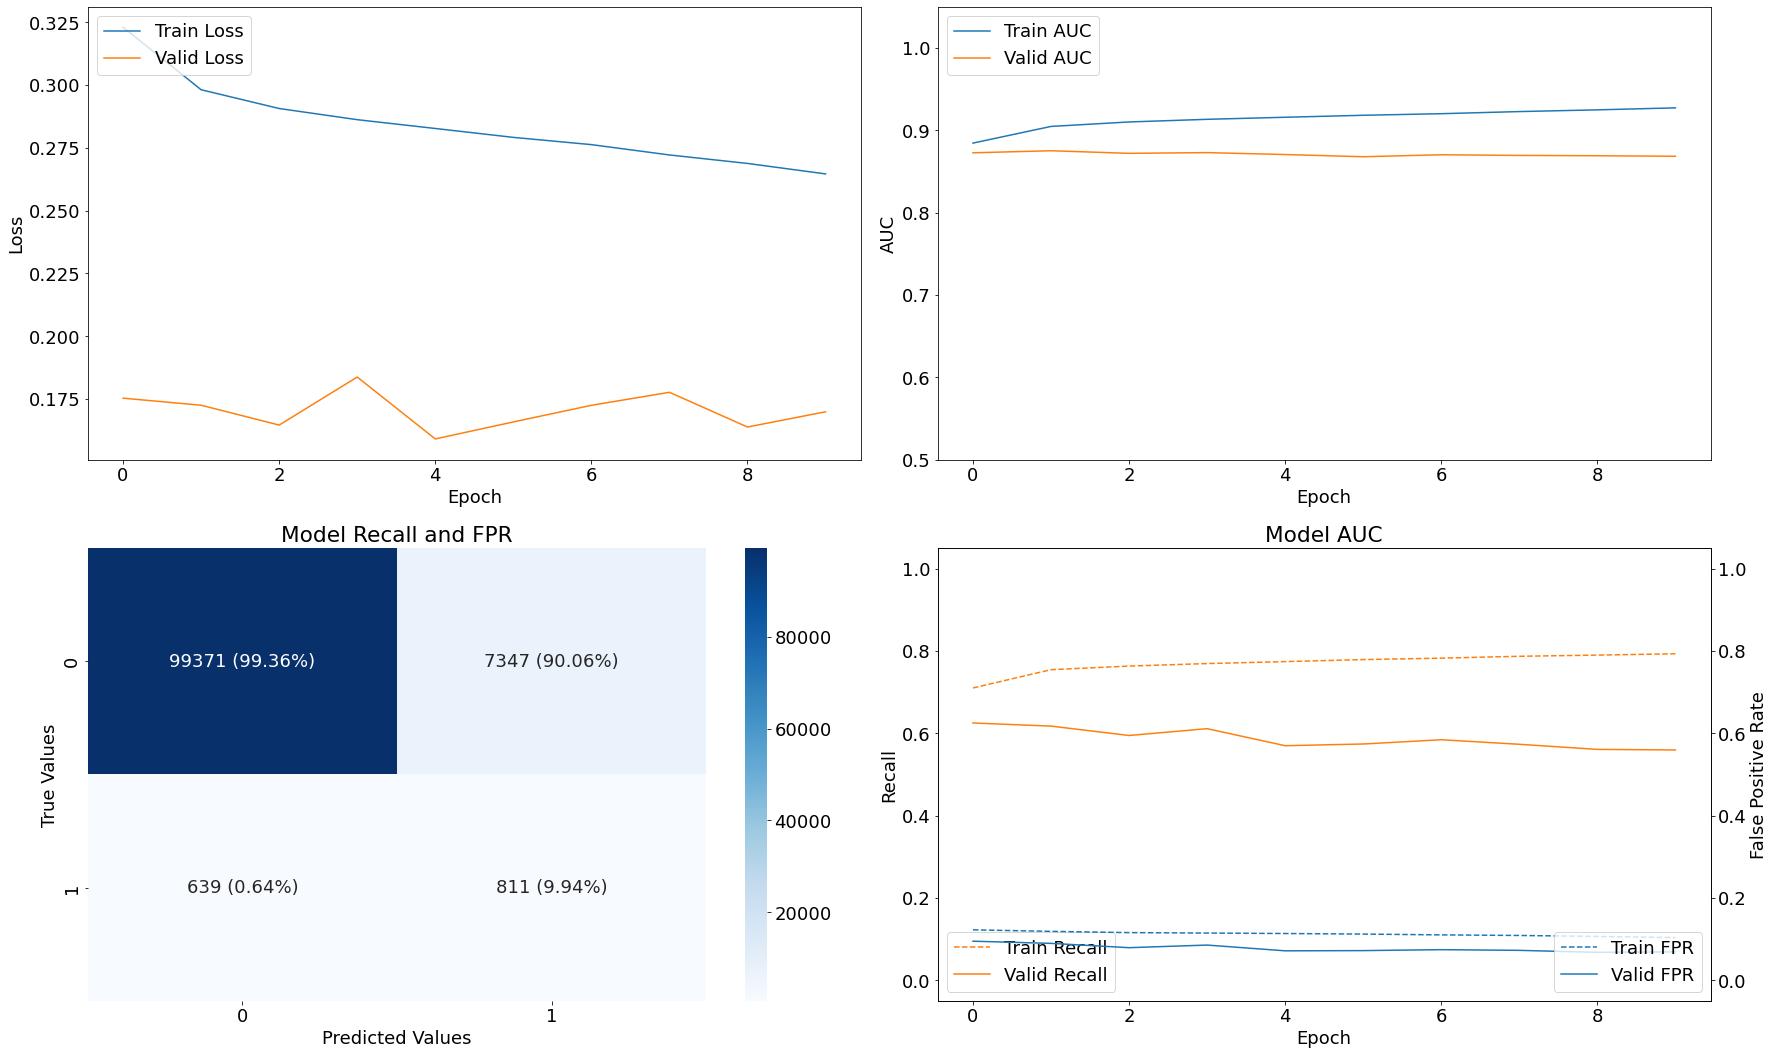

Epoch 00007: early stopping
Results for Base Model V6 with threshold = 0.2.

 Train f1: 0.6740830287085967 
 Val f1: 0.14458211353001307 

 Train Recall: 0.8691366314888 
 Val Recall: 0.6317241191864014 

 Train FPR: 0.17739610373973846 
 Val FPR: 0.09656290709972382


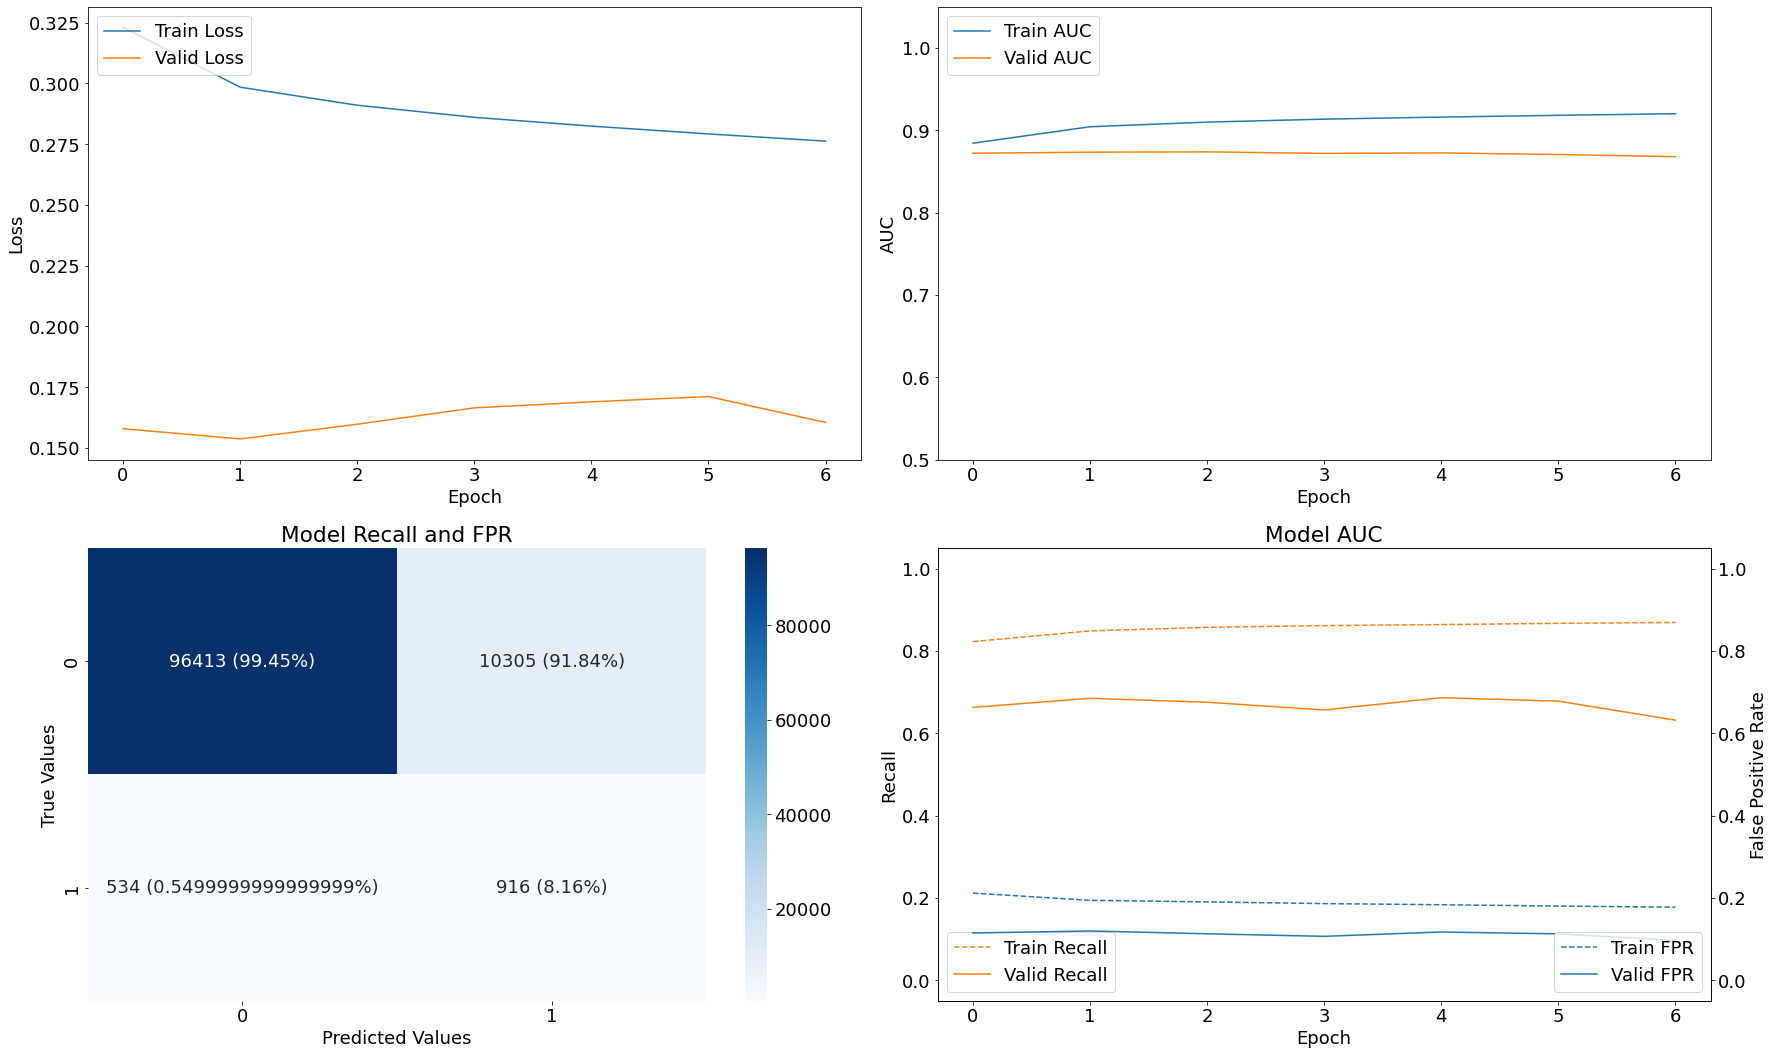

Epoch 00007: early stopping
Results for Base Model V6 with threshold = 0.1.

 Train f1: 0.6104042321204389 
 Val f1: 0.1042763481222508 

 Train Recall: 0.9312334656715393 
 Val Recall: 0.7786206603050232 

 Train FPR: 0.2799915671348572 
 Val FPR: 0.17874211072921753


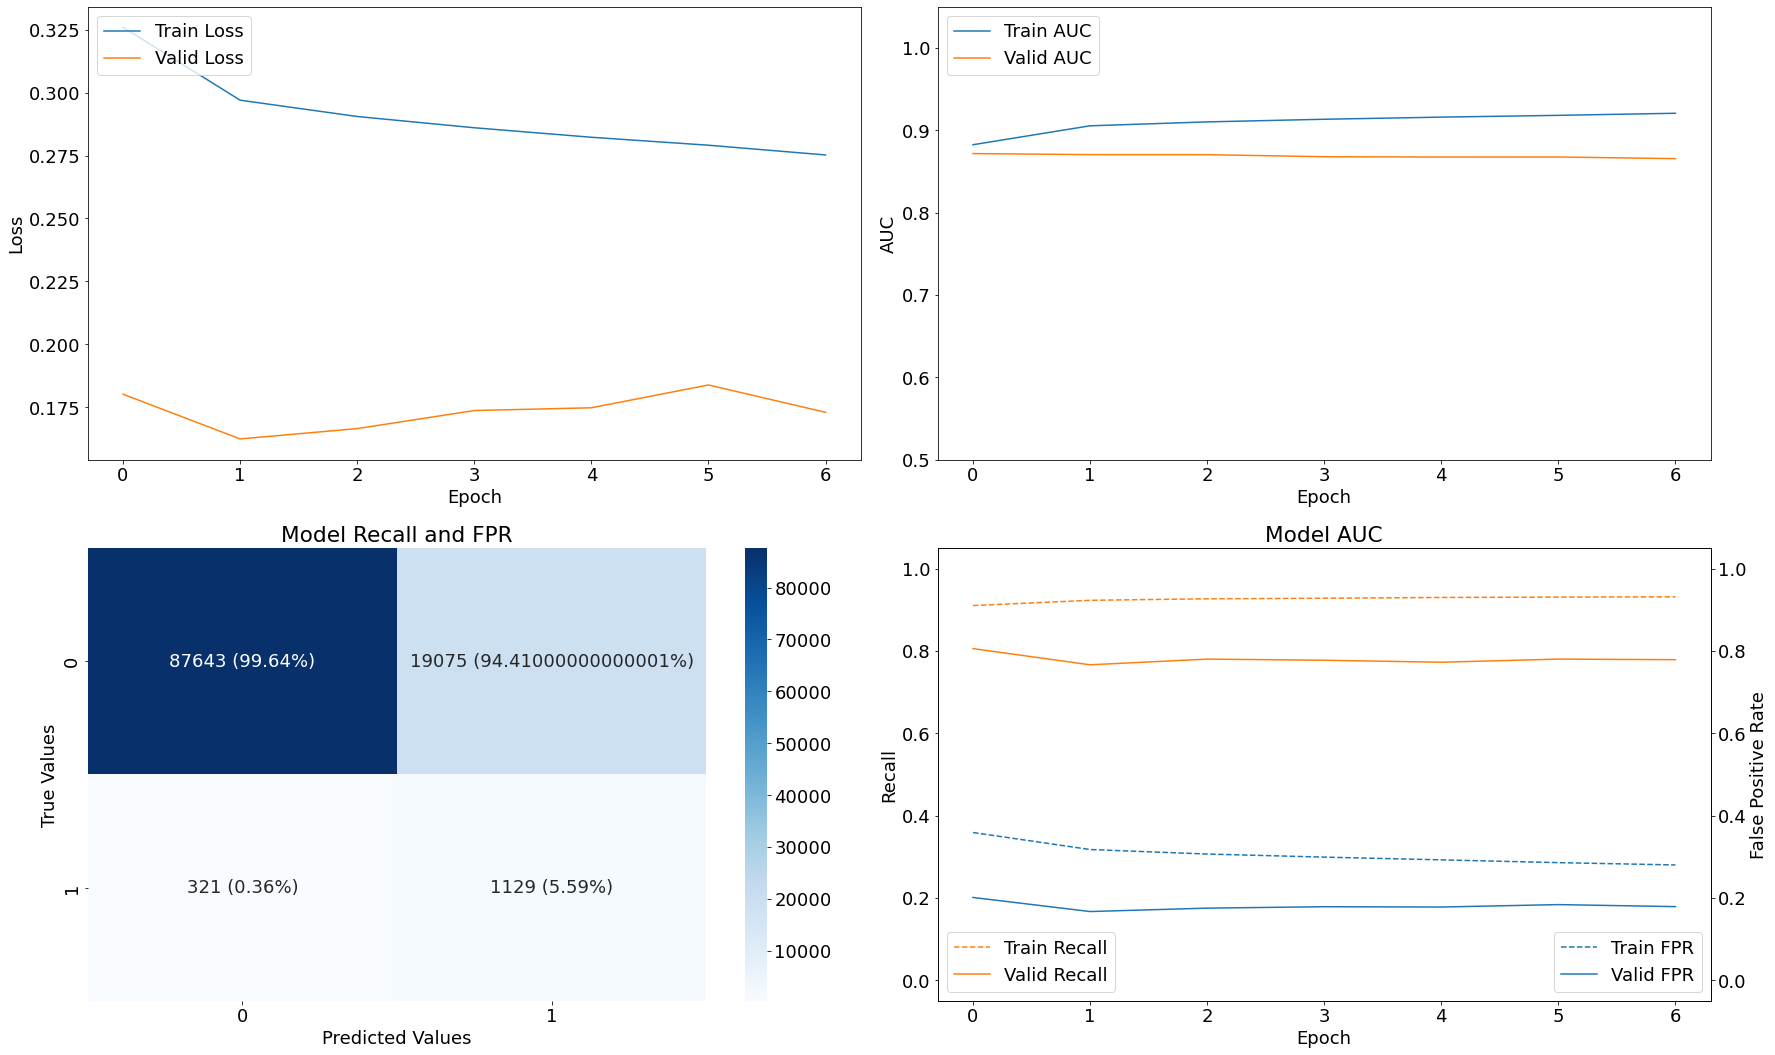

In [87]:
for t in thresholds:

    modelling_v6(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V6',
                 threshold=t)

---

### Seventh Model Iteration

For the seventh iteration, L2 regularization was added to the dense layers of the previous iteration. Overall, this model performs very well given the data and appears to be less overfit than the previous iteration

In [80]:
def modelling_v7(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5): 

    model_v7 = models.Sequential()

    model_v7.add(layers.Input(shape=(n_features, )))
    model_v7.add(layers.Dense(32,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v7.add(layers.AlphaDropout(0.25))
    model_v7.add(layers.Dense(16,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v7.add(layers.AlphaDropout(0.25))
    model_v7.add(layers.Dense(1, activation='sigmoid'))

    model_v7.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v7_history = model_v7.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs, 
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v7,
             name,
             model_v7_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00006: early stopping
Results for Base Model V7 with threshold = 0.5.

 Train f1: 0.5069780758236239 
 Val f1: 0.17019852379798078 

 Train Recall: 0.40045955777168274 
 Val Recall: 0.526206910610199 

 Train FPR: 0.044832609593868256 
 Val FPR: 0.0632789209485054


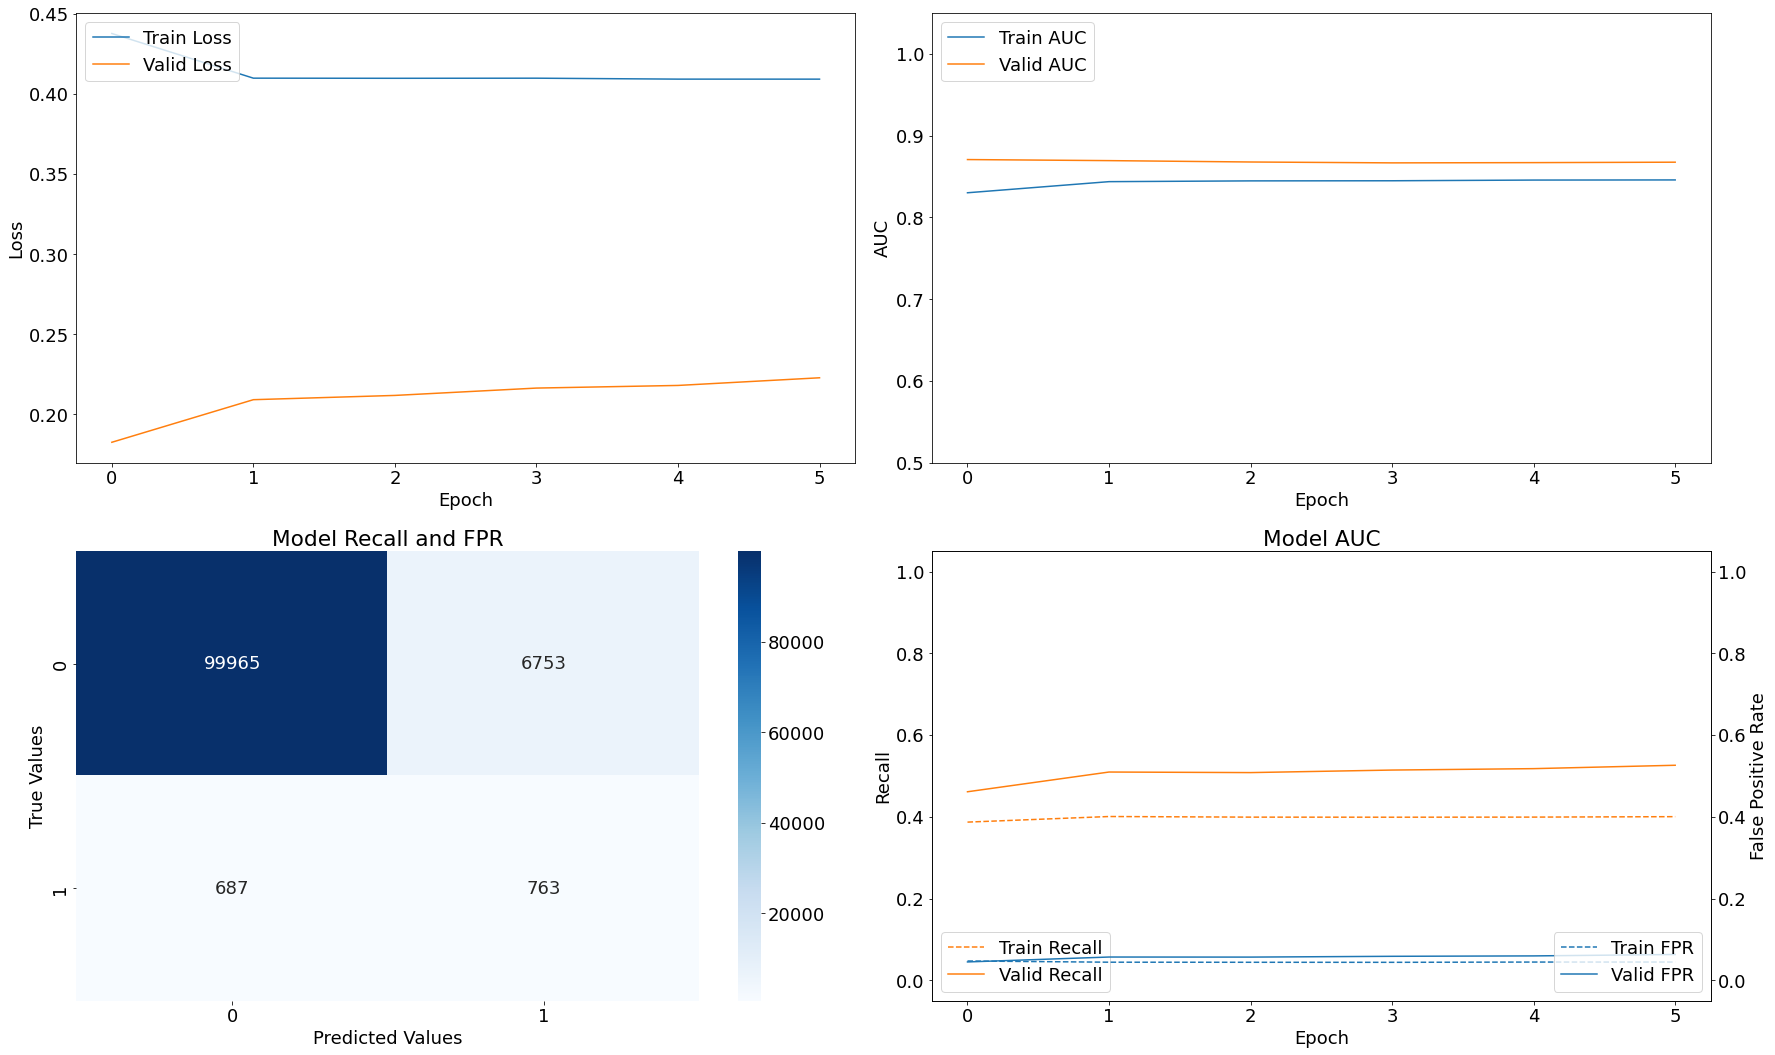

Epoch 00012: early stopping
Results for Base Model V7 with threshold = 0.4.

 Train f1: 0.5668257275467582 
 Val f1: 0.15687739077231963 

 Train Recall: 0.5151365995407104 
 Val Recall: 0.5793103575706482 

 Train FPR: 0.07562039792537689 
 Val FPR: 0.07889015972614288


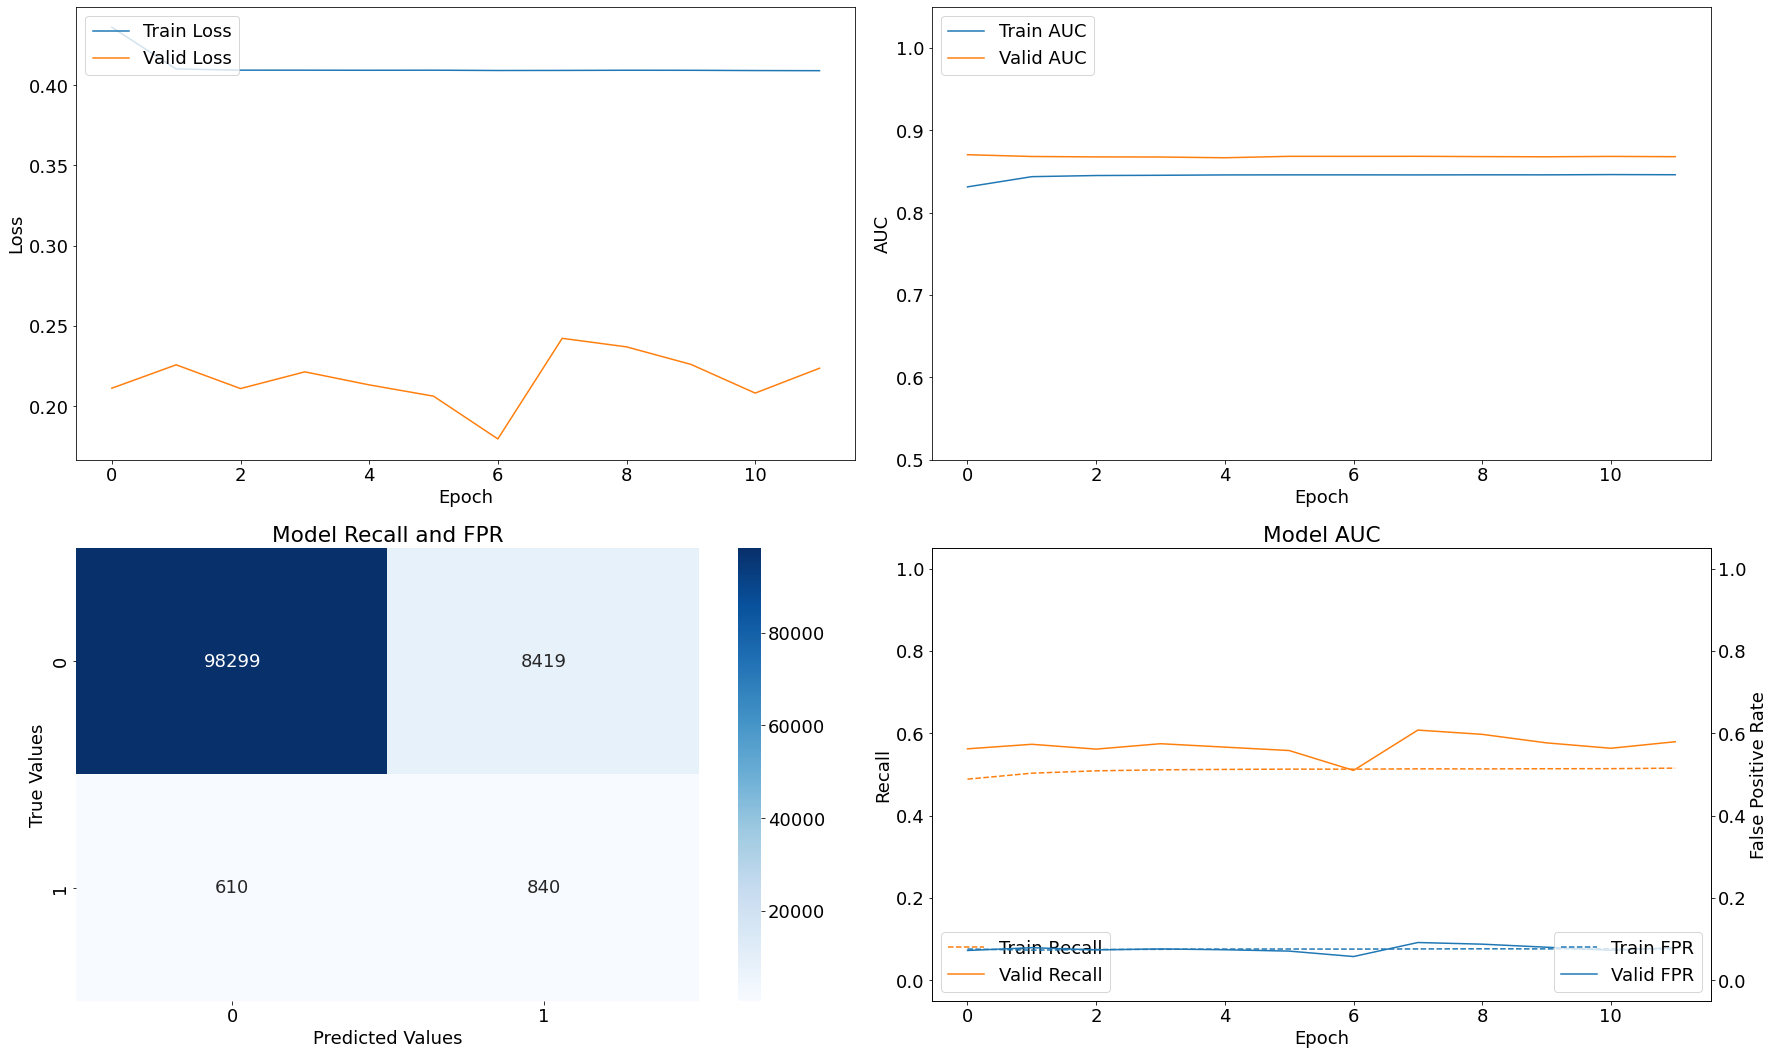

Epoch 00006: early stopping
Results for Base Model V7 with threshold = 0.3.

 Train f1: 0.5903785423897778 
 Val f1: 0.12998160937814326 

 Train Recall: 0.6351006031036377 
 Val Recall: 0.6579310297966003 

 Train FPR: 0.1291002780199051 
 Val FPR: 0.11502277106046677


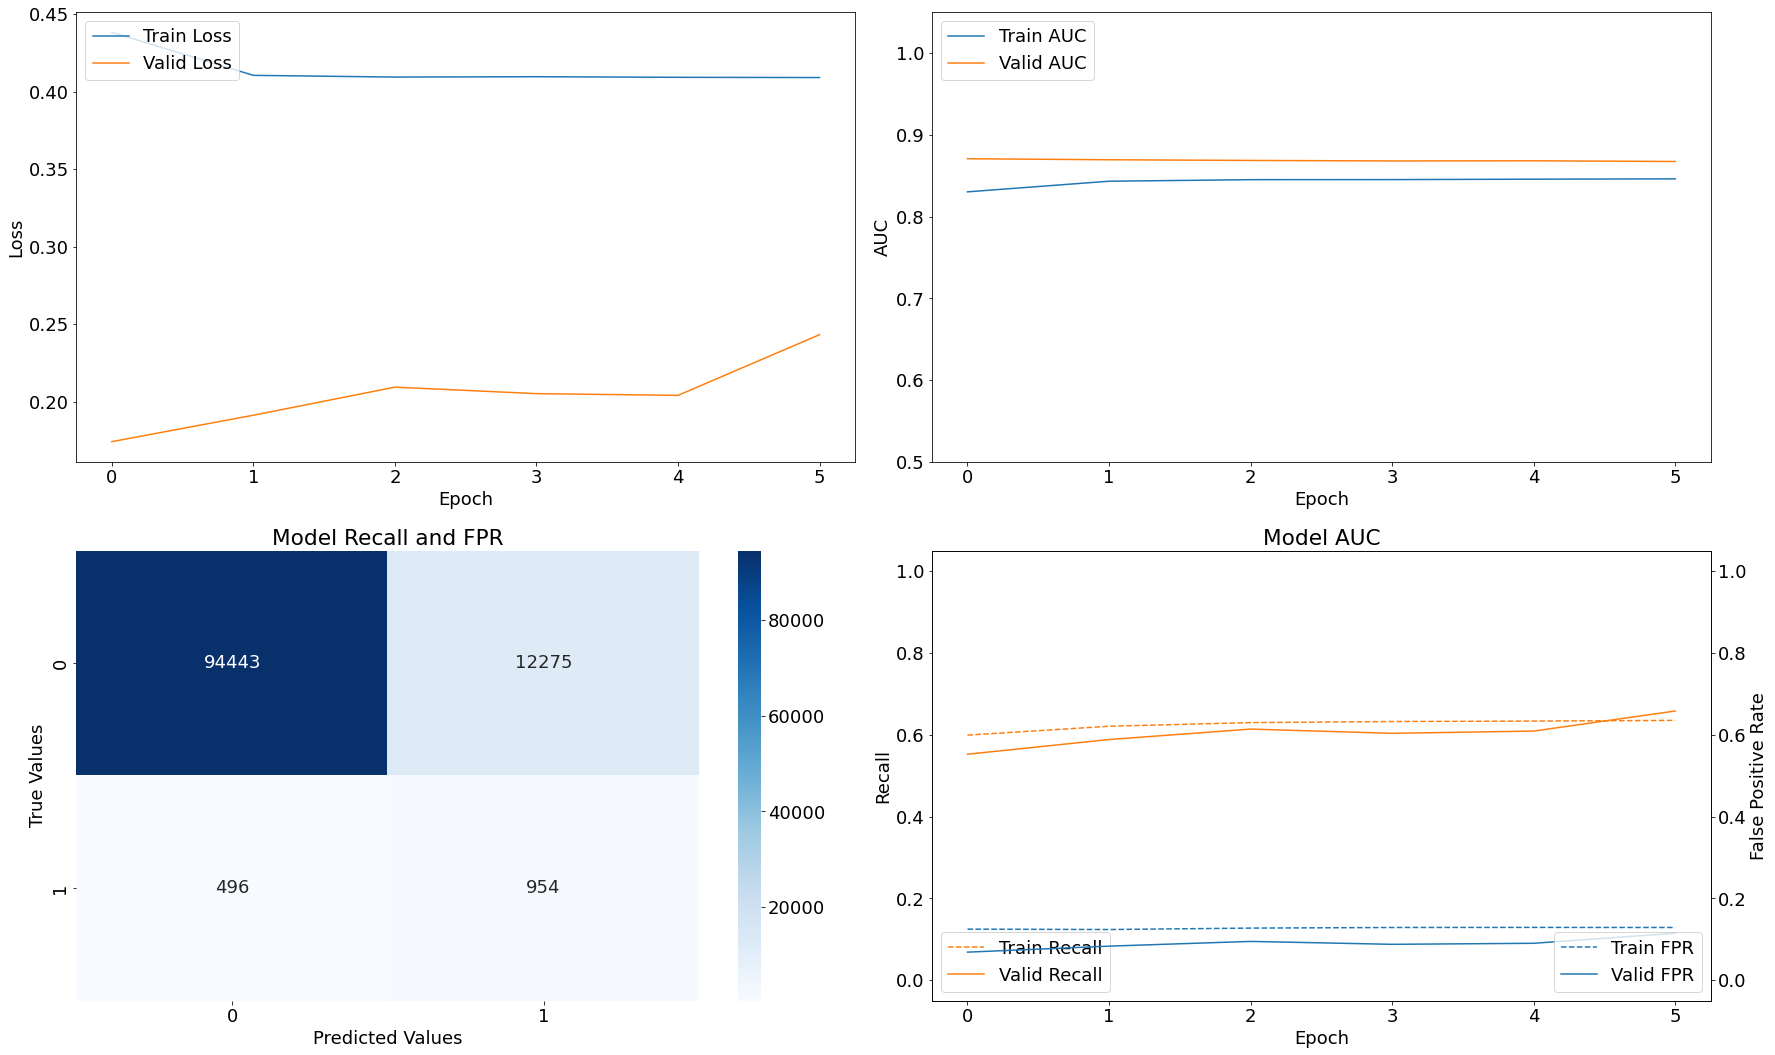

Epoch 00008: early stopping
Results for Base Model V7 with threshold = 0.2.

 Train f1: 0.568493910014017 
 Val f1: 0.121327134747699 

 Train Recall: 0.7685616612434387 
 Val Recall: 0.6834482550621033 

 Train FPR: 0.23382195830345154 
 Val FPR: 0.13020296394824982


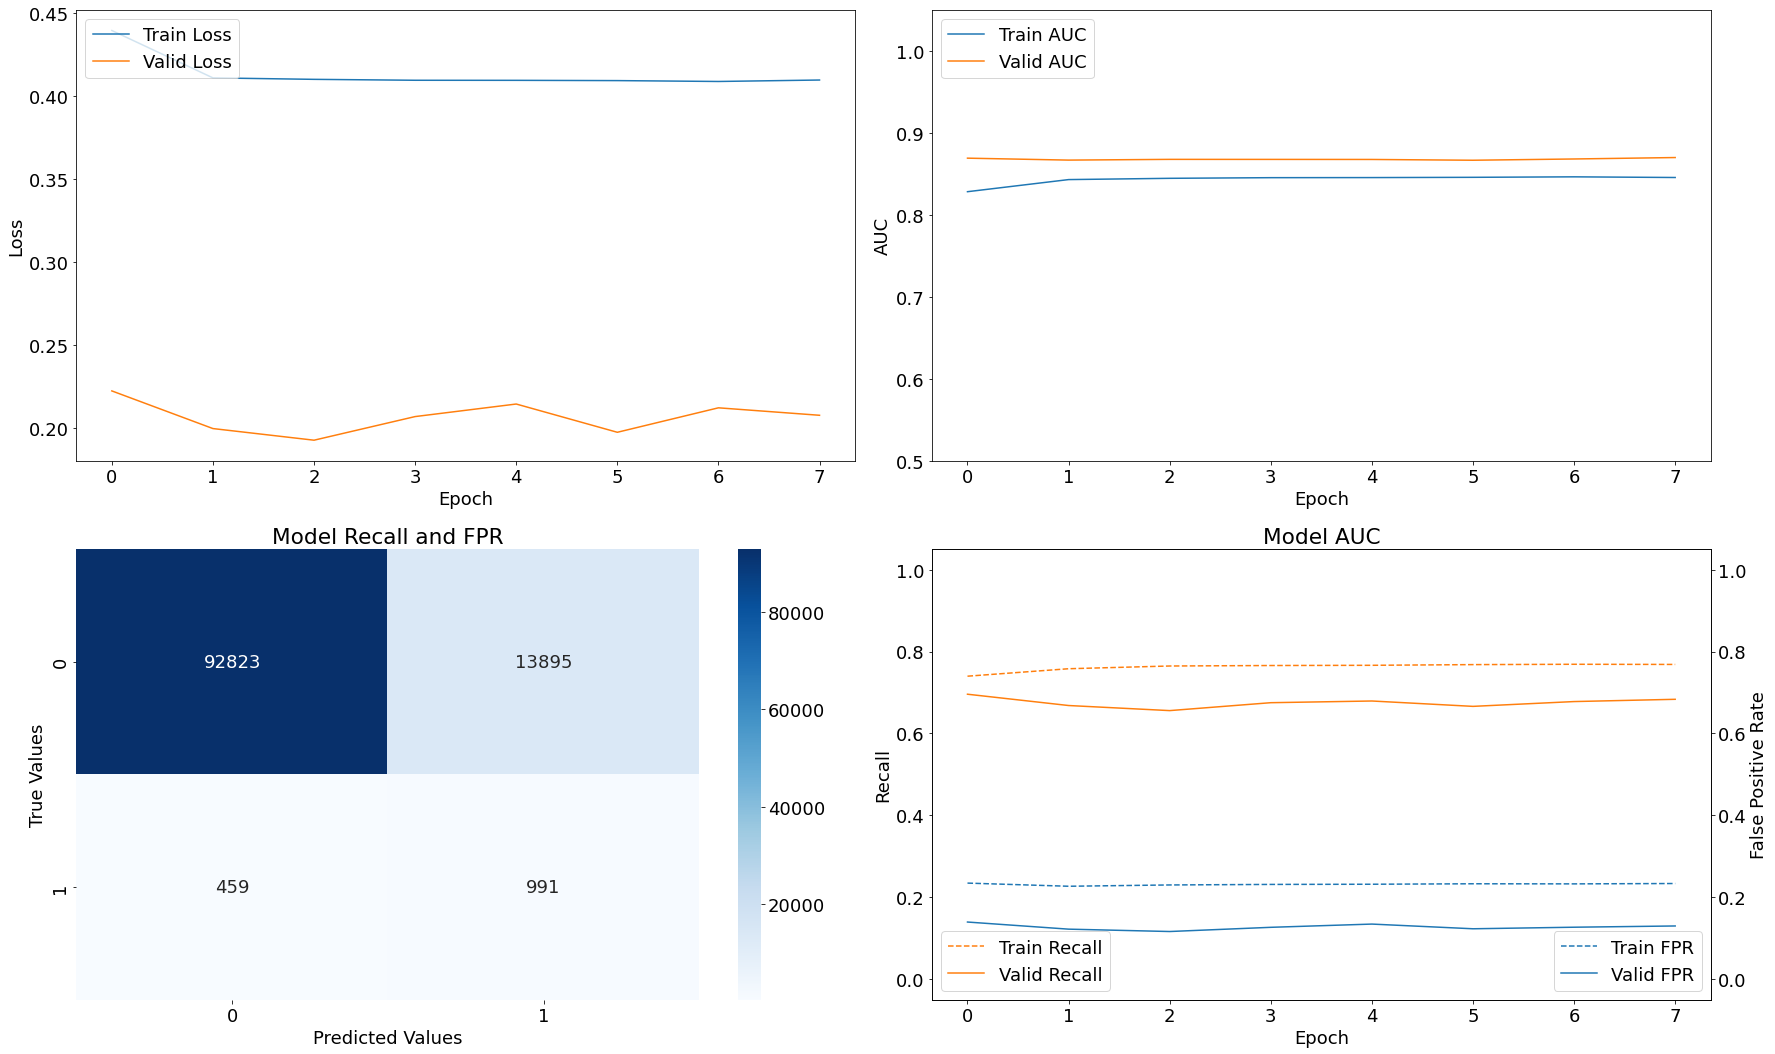

Epoch 00009: early stopping
Results for Base Model V7 with threshold = 0.1.

 Train f1: 0.48967207063809665 
 Val f1: 0.06816798623379768 

 Train Recall: 0.9033750295639038 
 Val Recall: 0.8882758617401123 

 Train FPR: 0.44658365845680237 
 Val FPR: 0.32844504714012146


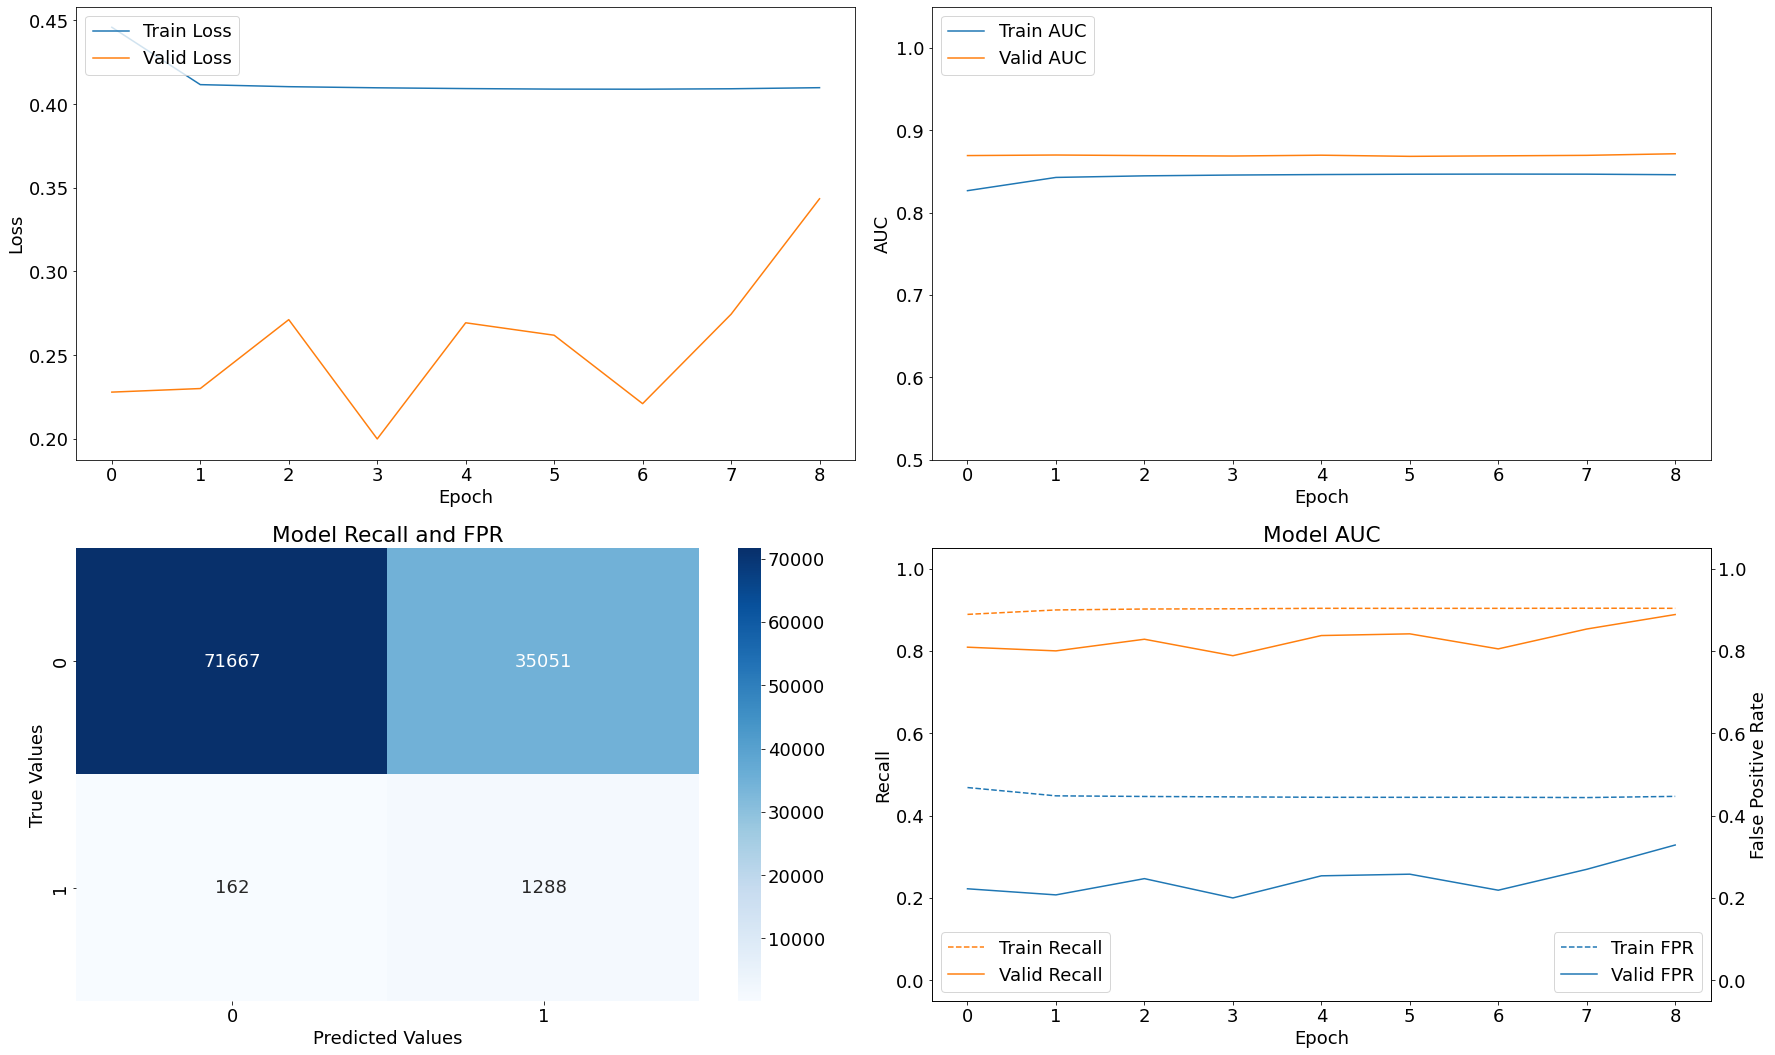

In [81]:
for t in thresholds:
    
    modelling_v7(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V7',
                 threshold=t)

---

### Eighth Model Iteration

The eighth iteration of the model adds two additional dense layers, with dimesionality 8 and 4 respectively, with a 25% alpha dropout layer inbetween. This model appears to give slightly better results for both of our metrics than the seventh iteration.

In [84]:
def modelling_v8(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):   
    
    model_v8 = models.Sequential()

    model_v8.add(layers.Input(shape=(n_features, )))
    model_v8.add(layers.Dense(32,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v8.add(layers.AlphaDropout(0.25))
    model_v8.add(layers.Dense(16,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v8.add(layers.AlphaDropout(0.25))
    model_v8.add(layers.Dense(8,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v8.add(layers.AlphaDropout(0.25))
    model_v8.add(layers.Dense(4,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2()))
    model_v8.add(layers.Dense(1, activation='sigmoid'))

    model_v8.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v8_history = model_v8.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs, 
                                    verbose=0).history
    
    evaluate(model_v8,
             name,
             model_v8_history,
             X_val,
             y_val,
             threshold=threshold)

Results for Base Model V8 with threshold = 0.5.

 Train f1: 0.4903981967830209 
 Val f1: 0.18381414588009048 

 Train Recall: 0.3875775933265686 
 Val Recall: 0.4965517222881317 

 Train FPR: 0.04827168956398964 
 Val FPR: 0.05307445675134659


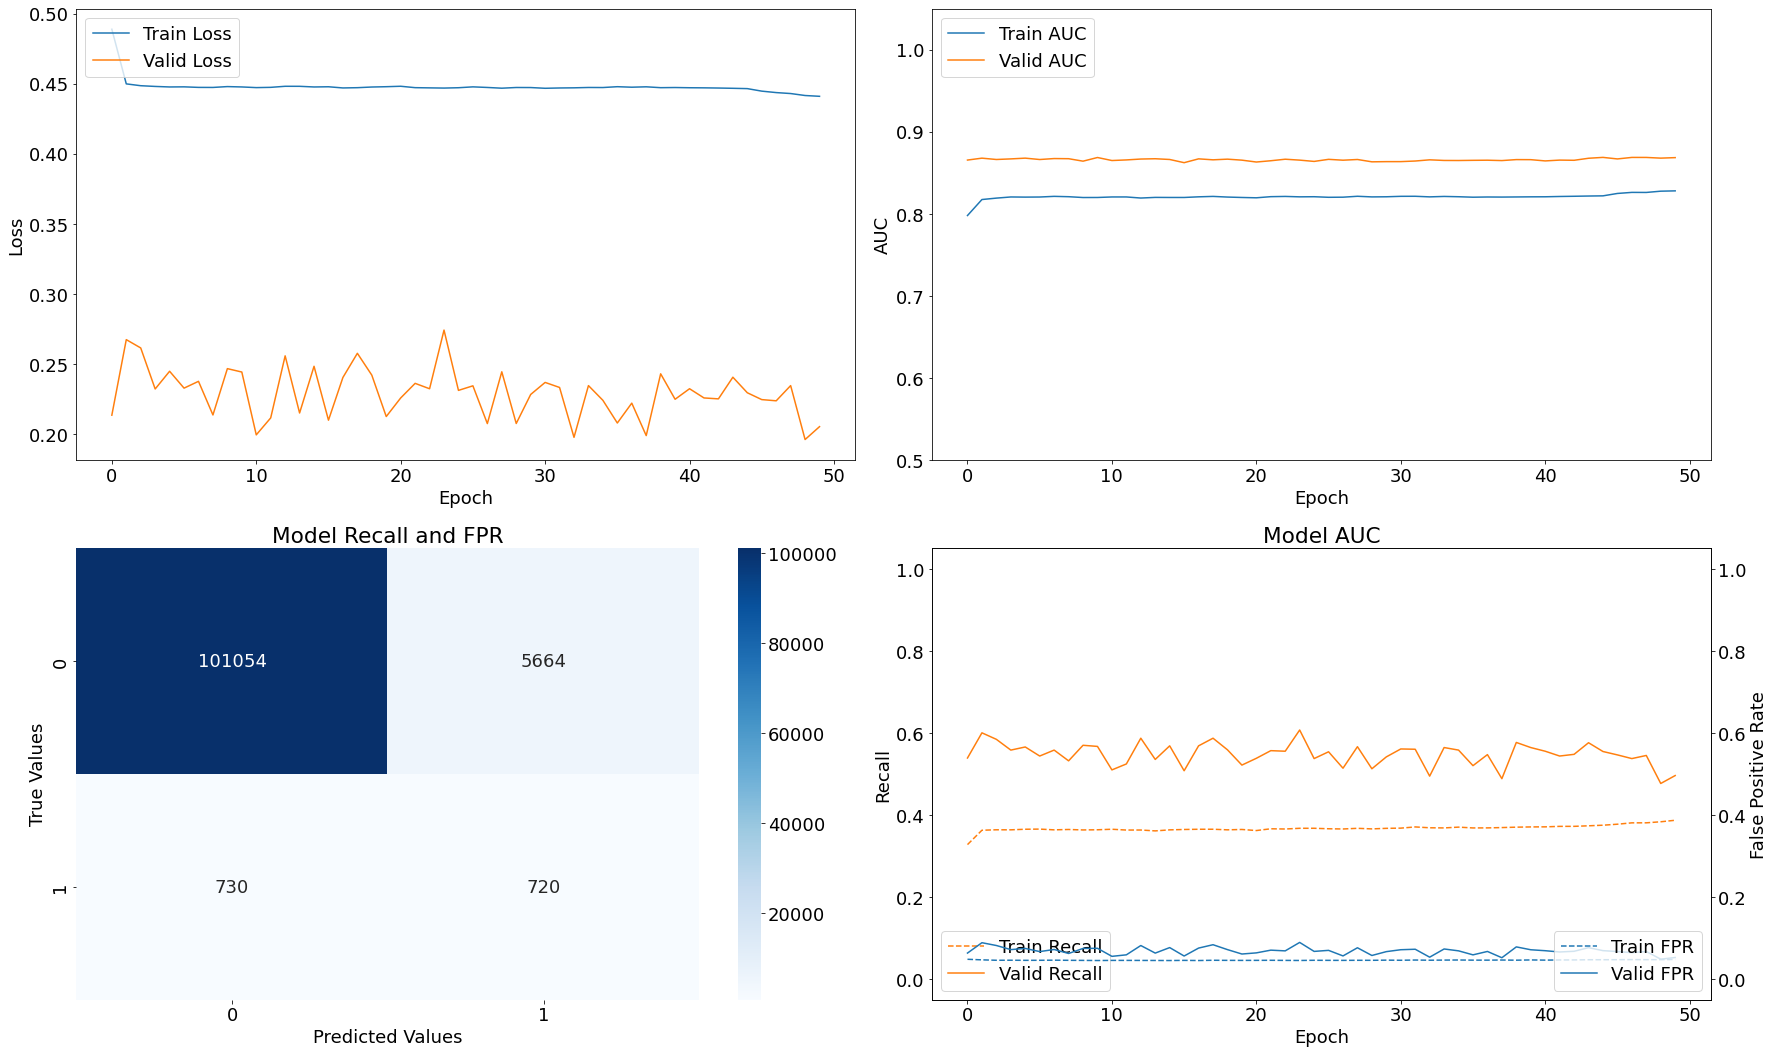

Results for Base Model V8 with threshold = 0.4.

 Train f1: 0.5376571245410652 
 Val f1: 0.17220008279585058 

 Train Recall: 0.4771413505077362 
 Val Recall: 0.5365517139434814 

 Train FPR: 0.07443717867136002 
 Val FPR: 0.06379429996013641


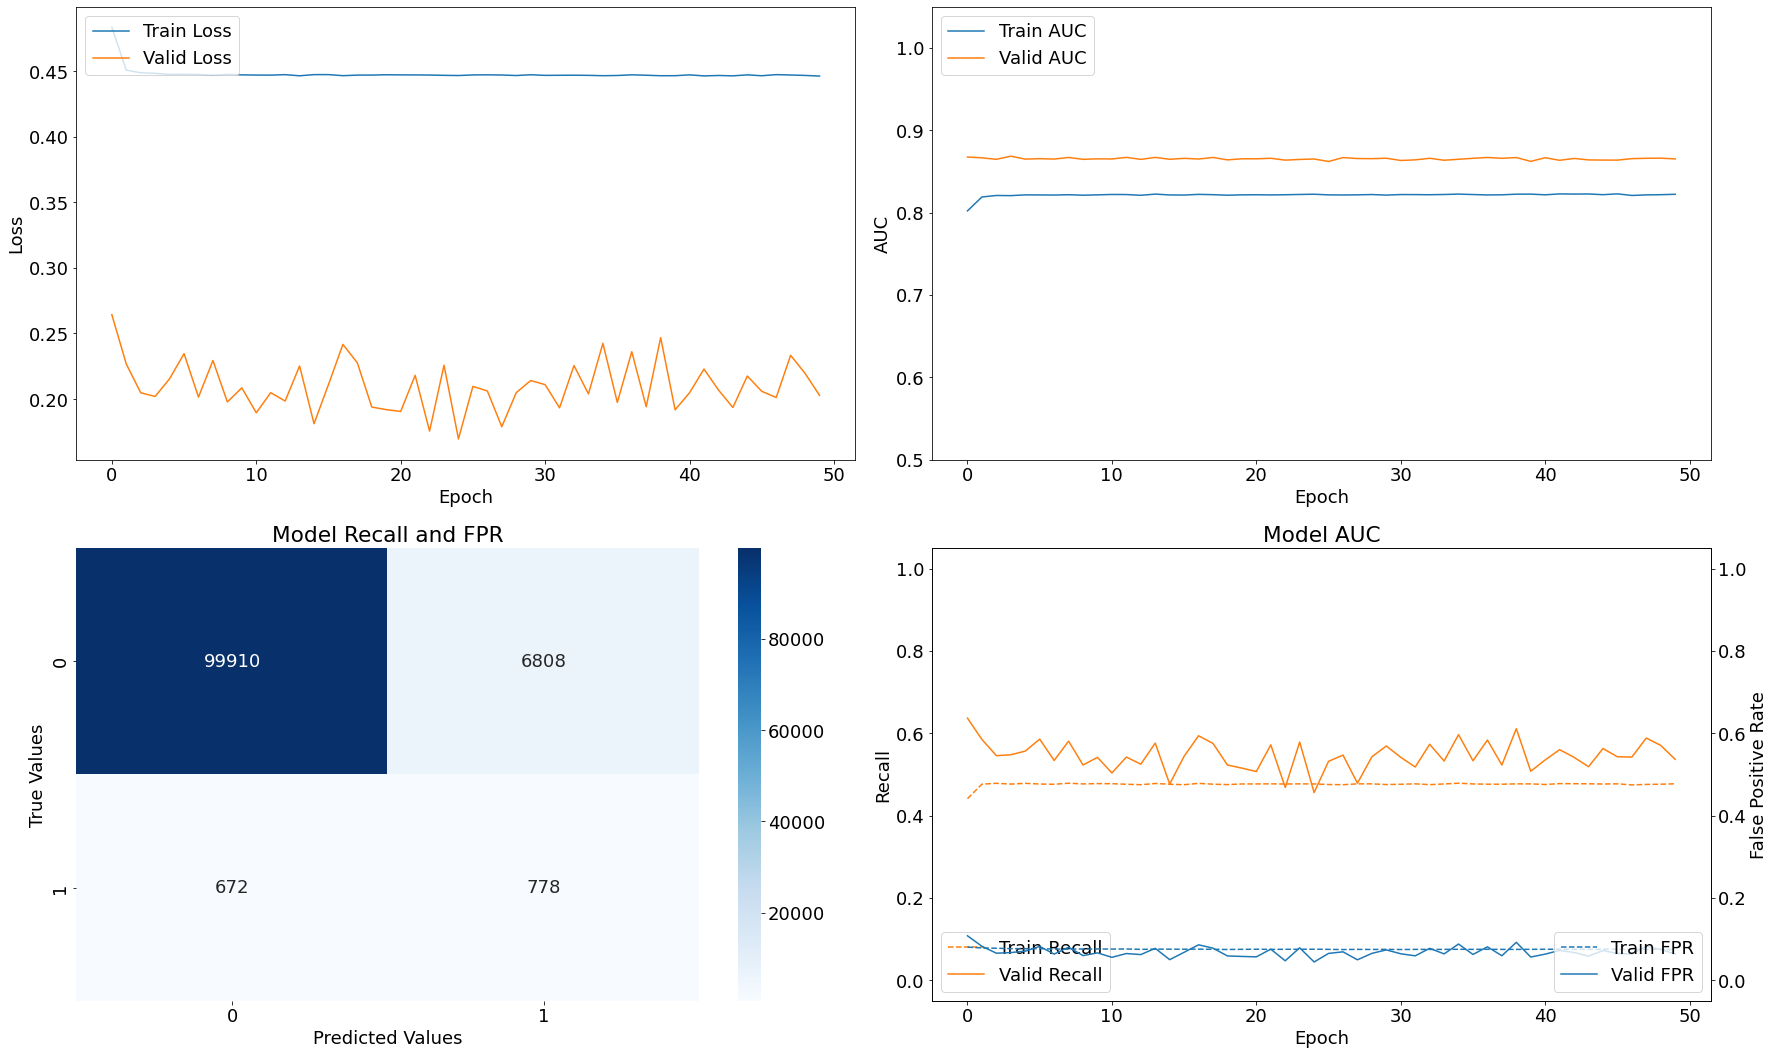

Results for Base Model V8 with threshold = 0.3.

 Train f1: 0.5775592386480695 
 Val f1: 0.16721069698923358 

 Train Recall: 0.6185634732246399 
 Val Recall: 0.54758620262146 

 Train FPR: 0.13085666298866272 
 Val FPR: 0.06796416640281677


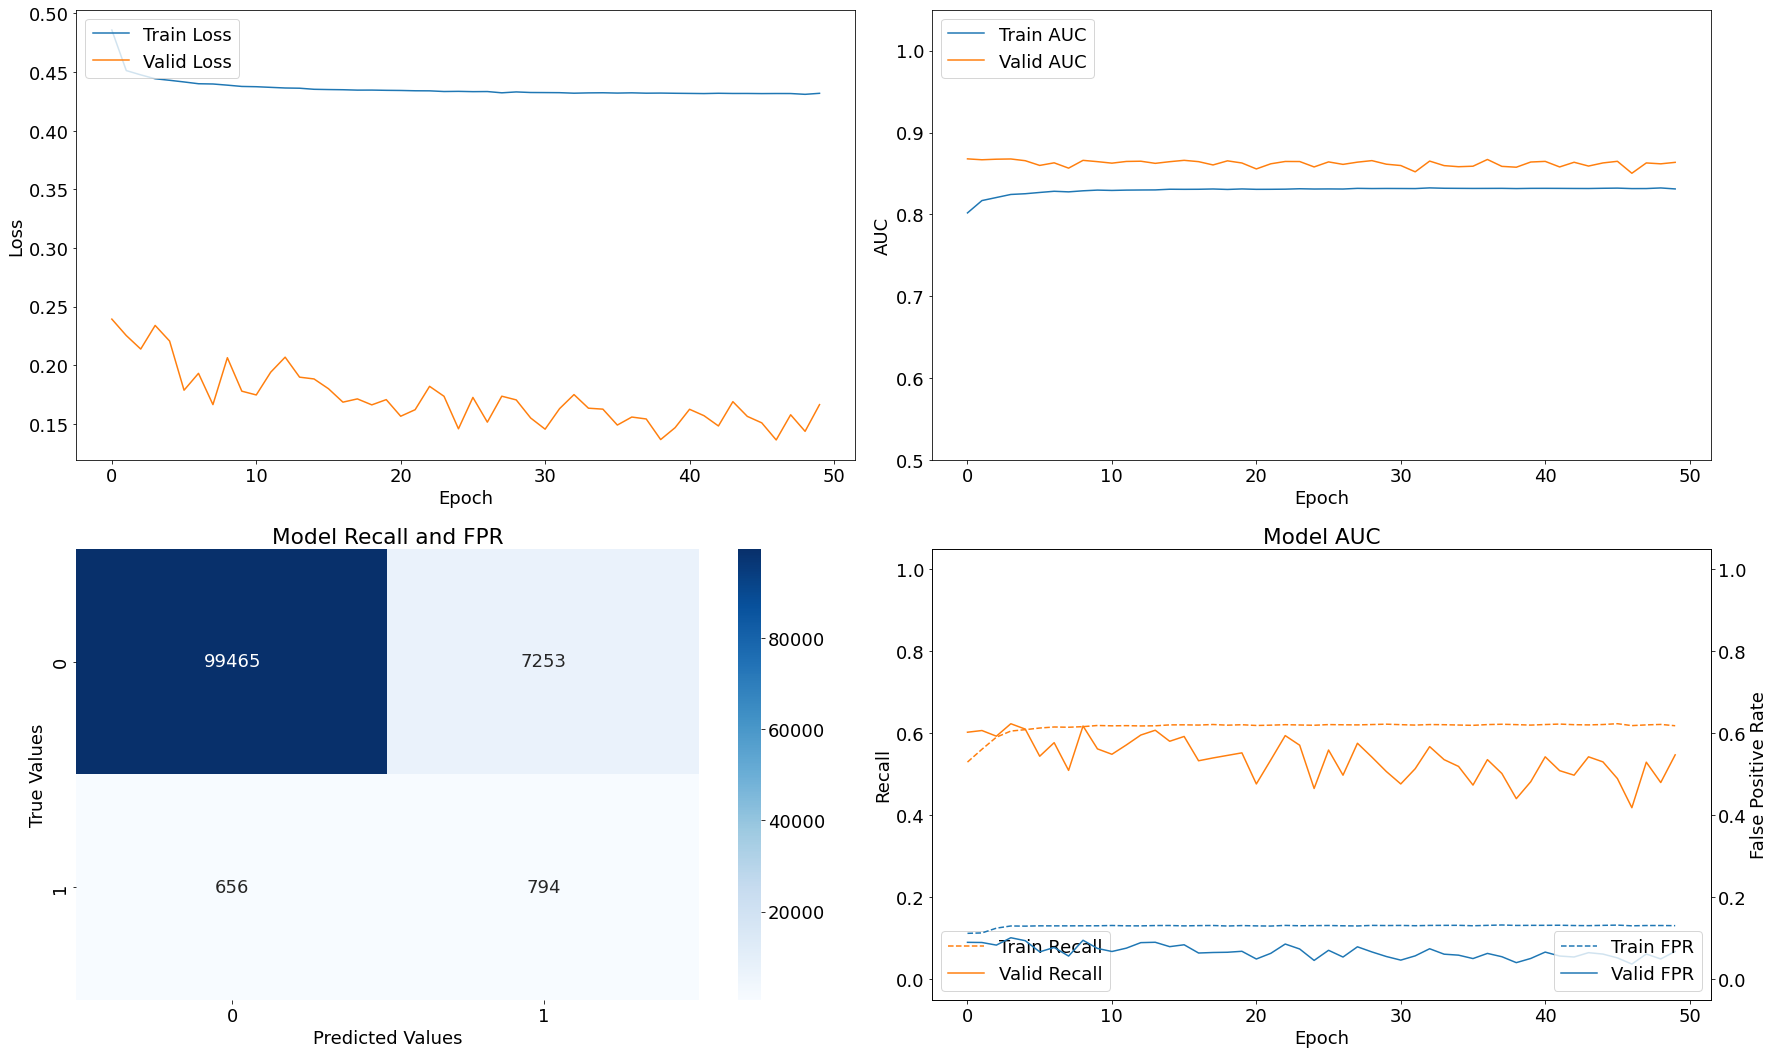

Results for Base Model V8 with threshold = 0.2.

 Train f1: 0.5524787533355168 
 Val f1: 0.15111506985983936 

 Train Recall: 0.7296107411384583 
 Val Recall: 0.5841379165649414 

 Train FPR: 0.2279033362865448 
 Val FPR: 0.08351918309926987


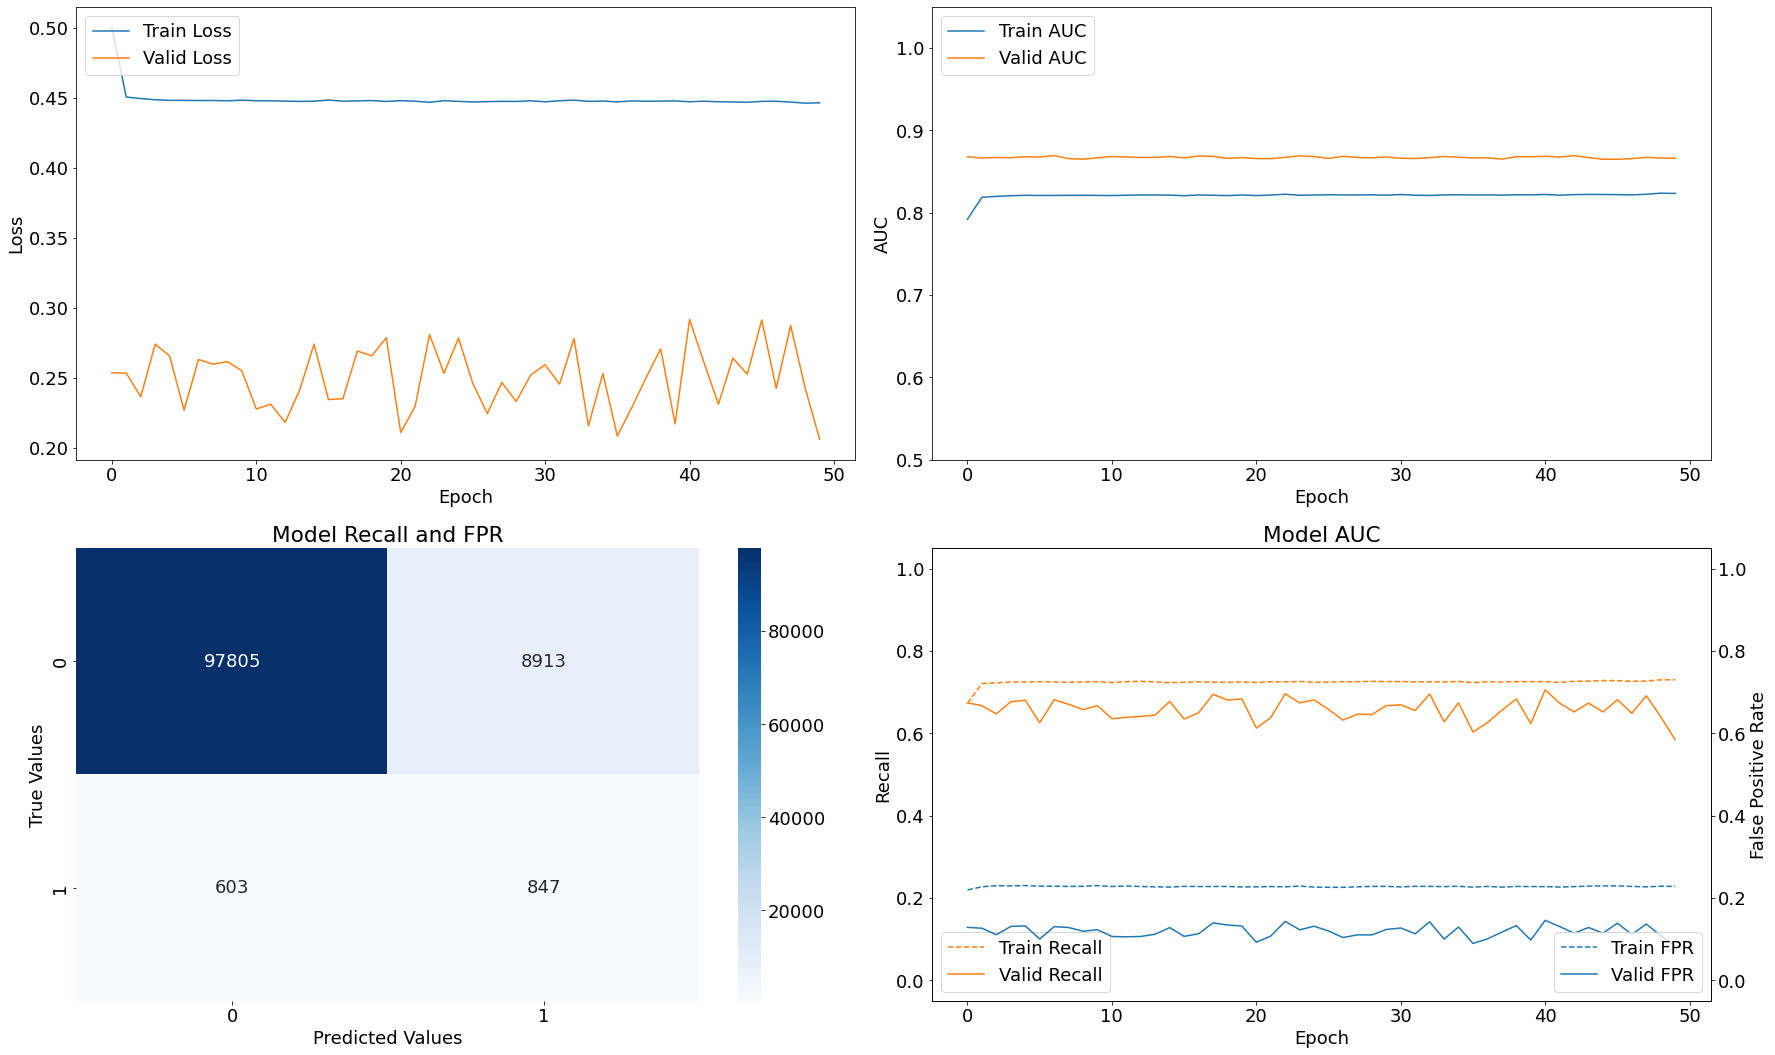

Results for Base Model V8 with threshold = 0.1.

 Train f1: 0.4689483261809424 
 Val f1: 0.08571844966512732 

 Train Recall: 0.8920791745185852 
 Val Recall: 0.8117241263389587 

 Train FPR: 0.478127658367157 
 Val FPR: 0.2327161282300949


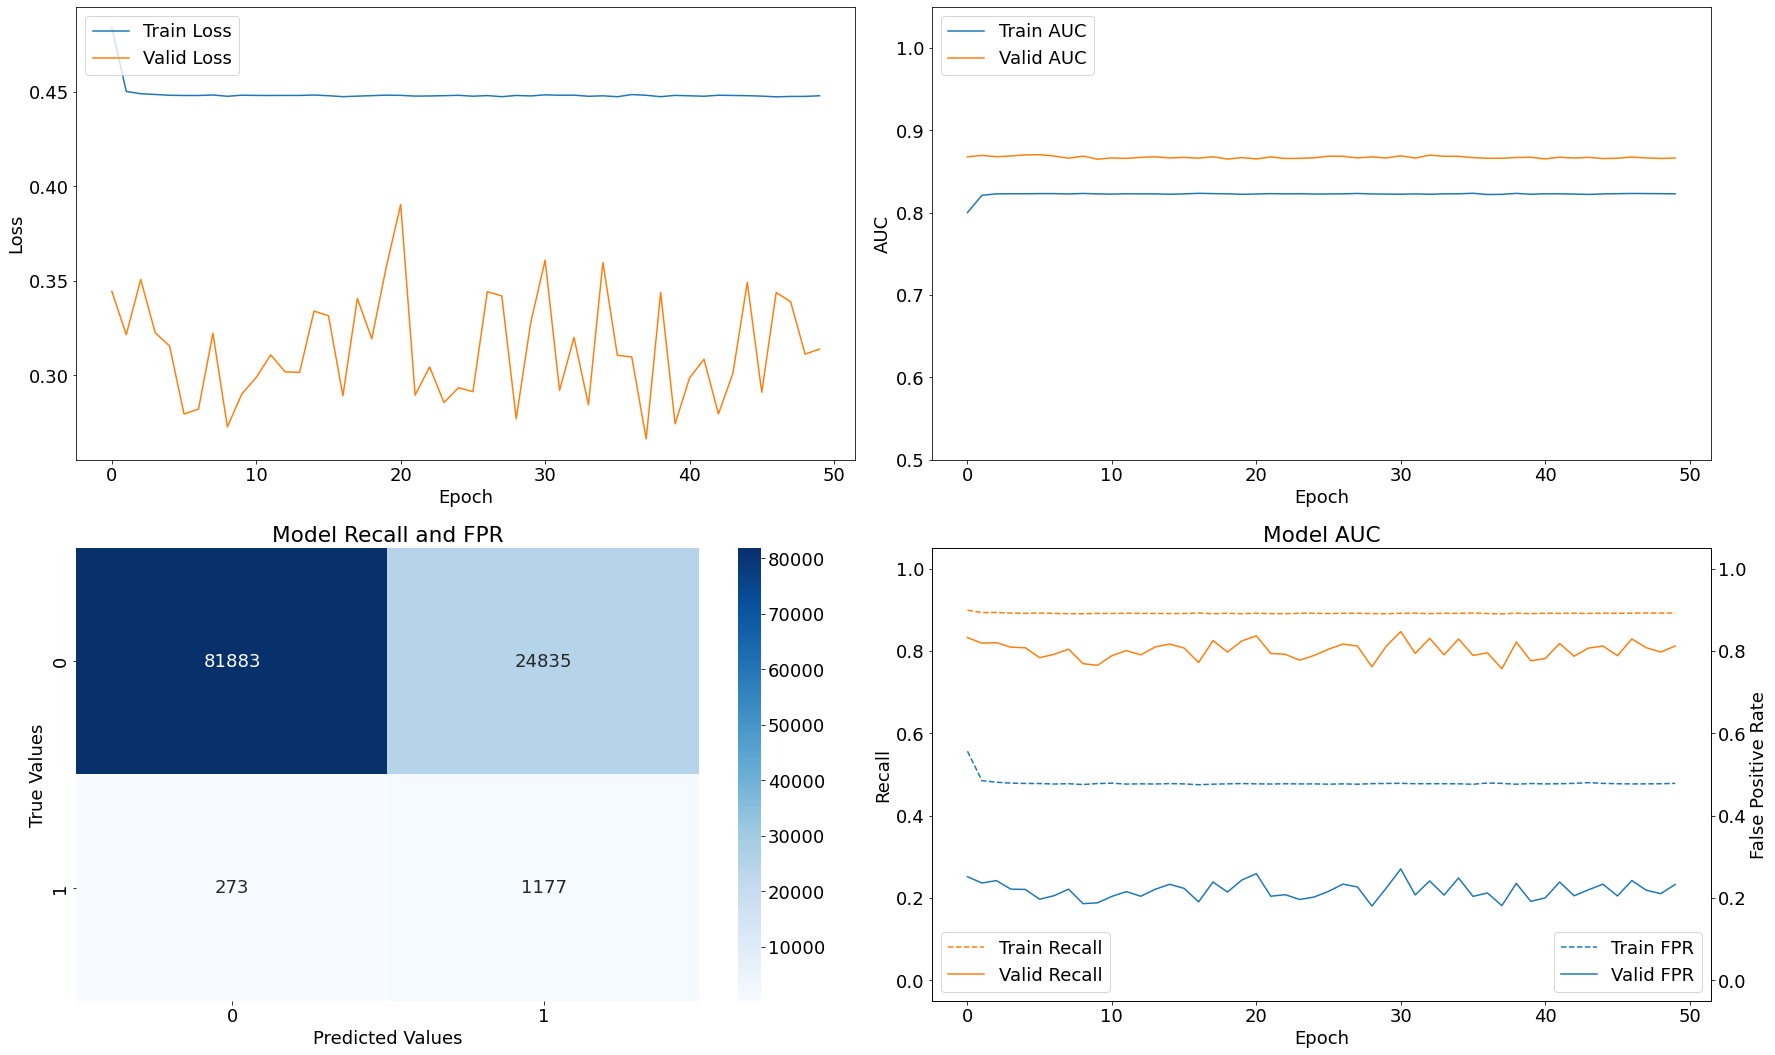

In [85]:
for t in thresholds: 
    
    modelling_v8(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V8',
                 threshold=t)

---

### Ninth Model Iteration

The ninth iteration of the model updated the L2 regularization value from the default of 0.01 to 0.005 in order to try to get a better fit. This did not have the intended effect and it appears than the eighth iteration overall performed better.

In [94]:
def modelling_v9(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):

    model_v9 = models.Sequential()

    model_v9.add(layers.Input(shape=(n_features, )))
    model_v9.add(layers.Dense(32,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2(l2=0.005)))
    model_v9.add(layers.AlphaDropout(0.25))
    model_v9.add(layers.Dense(16,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2(l2=0.005)))
    model_v9.add(layers.AlphaDropout(0.25))
    model_v9.add(layers.Dense(8,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2(l2=0.005)))
    model_v9.add(layers.AlphaDropout(0.25))
    model_v9.add(layers.Dense(4,
                              kernel_initializer='lecun_normal',
                              activation='selu',
                              kernel_regularizer=regularizers.L2(l2=0.005)))
    model_v9.add(layers.Dense(1, activation='sigmoid'))

    model_v9.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['AUC',
                              tf.keras.metrics.Precision(thresholds=threshold),
                              tf.keras.metrics.Recall(thresholds=threshold),
                              FalsePositiveRate(threshold=threshold)])

    model_v9_history = model_v9.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_val, y_val),
                                    class_weight=class_weight,
                                    epochs=epochs,
                                    callbacks=[early_stop],
                                    verbose=0).history
    
    evaluate(model_v9,
             name,
             model_v9_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00008: early stopping
Results for Base Model V9 with threshold = 0.5.

 Train f1: 0.5279704119473668 
 Val f1: 0.11628842670132518 

 Train Recall: 0.4348148703575134 
 Val Recall: 0.6979310512542725 

 Train FPR: 0.053075727075338364 
 Val FPR: 0.14002323150634766


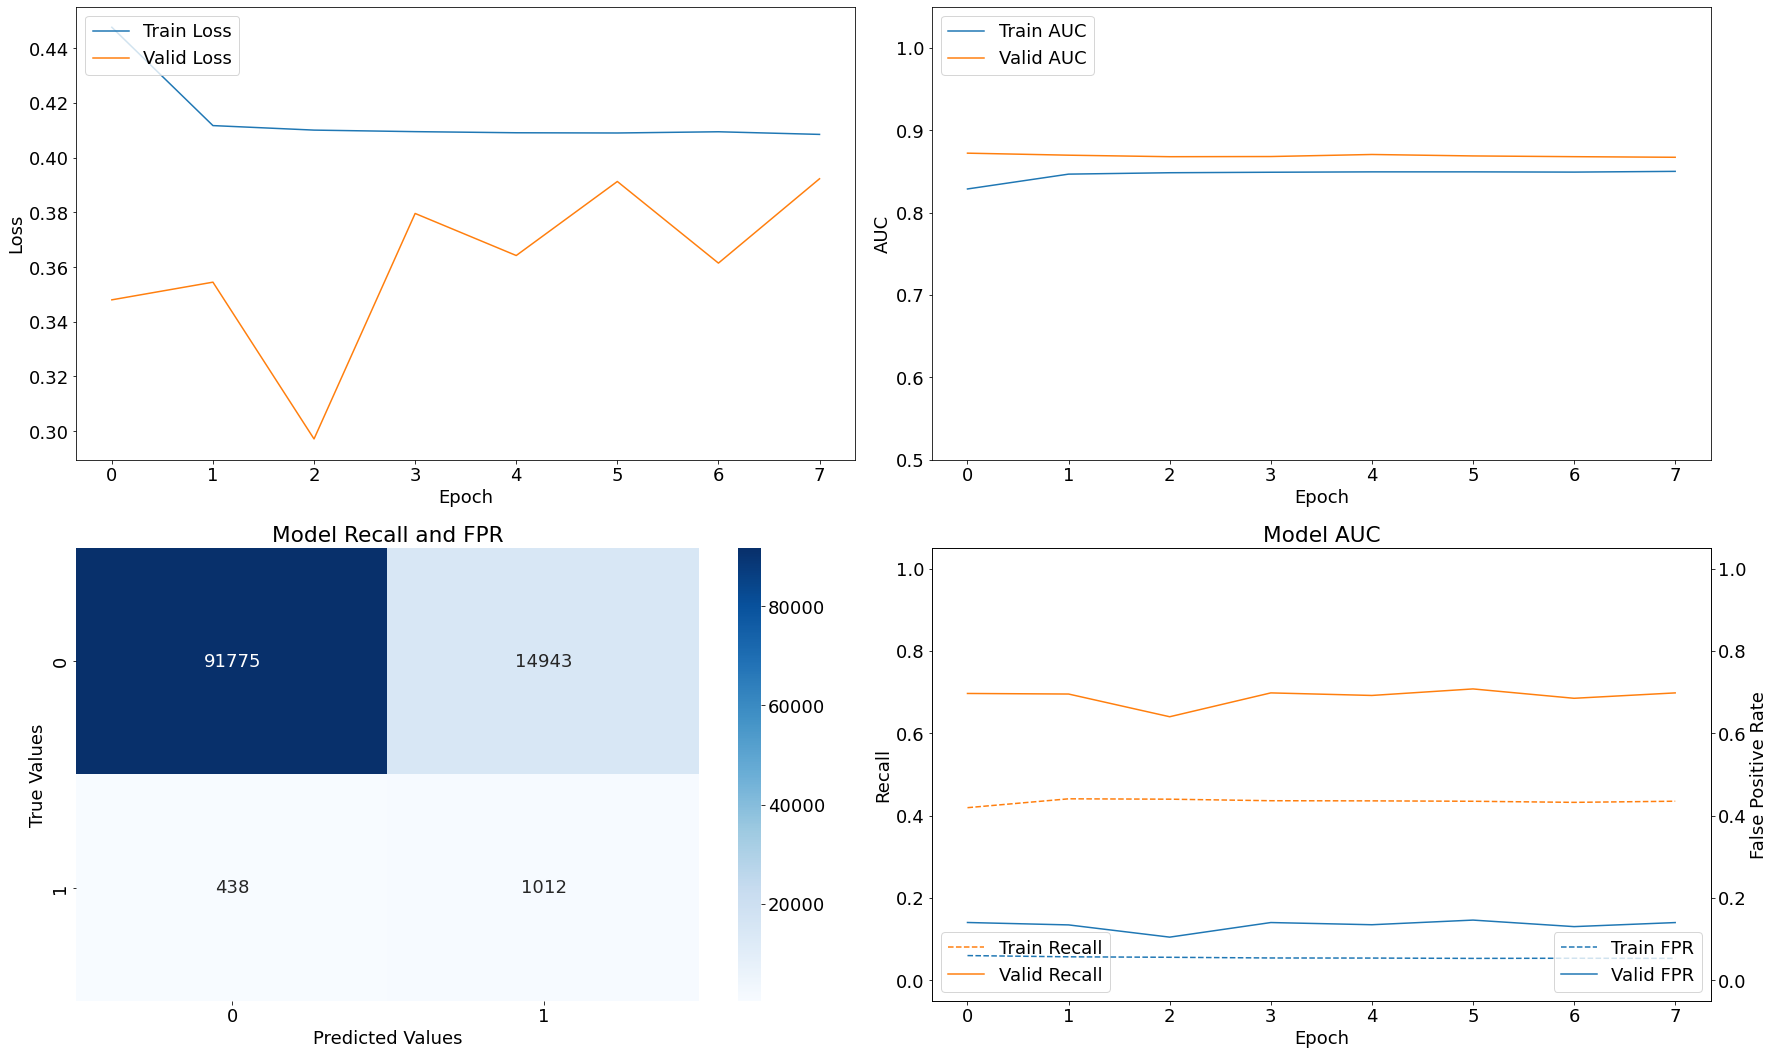

Epoch 00011: early stopping
Results for Base Model V9 with threshold = 0.4.

 Train f1: 0.585226122759653 
 Val f1: 0.12305966138491761 

 Train Recall: 0.5535385012626648 
 Val Recall: 0.6806896328926086 

 Train FPR: 0.0845421776175499 
 Val FPR: 0.12747615575790405


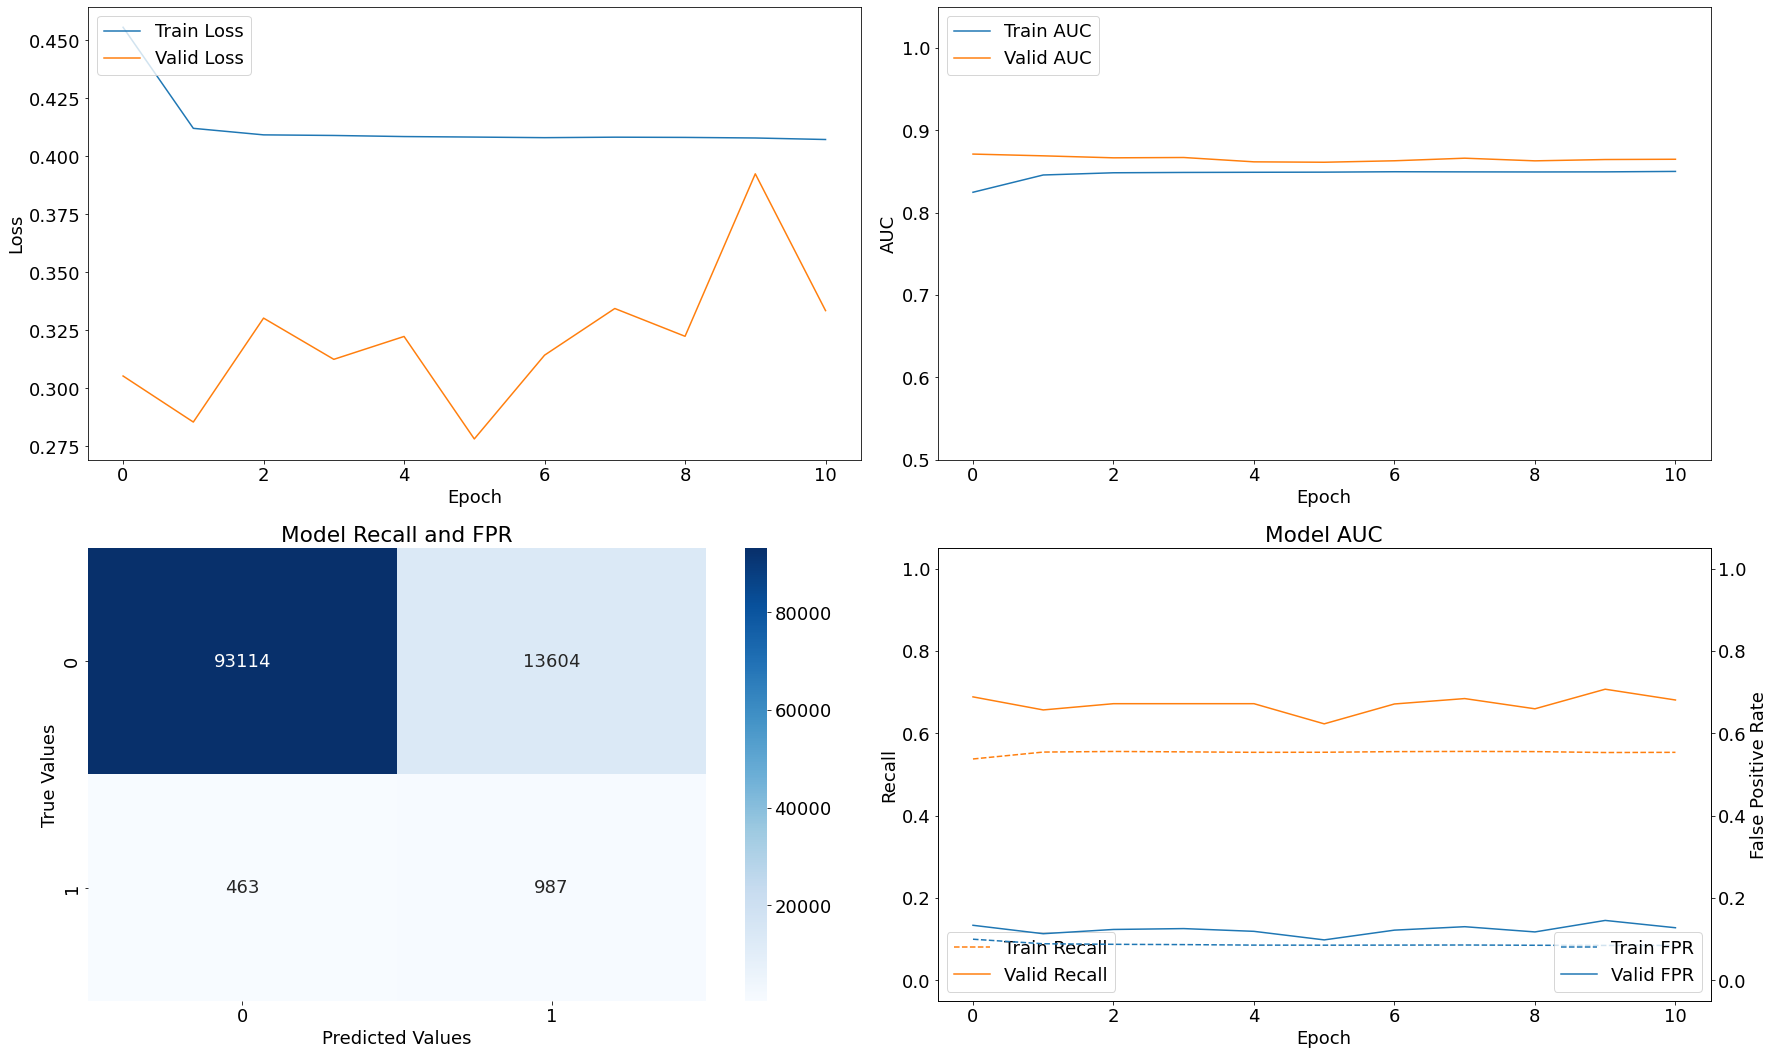

Epoch 00009: early stopping
Results for Base Model V9 with threshold = 0.3.

 Train f1: 0.6011825208078544 
 Val f1: 0.11360986171585453 

 Train Recall: 0.6657753586769104 
 Val Recall: 0.7055172324180603 

 Train FPR: 0.13727730512619019 
 Val FPR: 0.14557993412017822


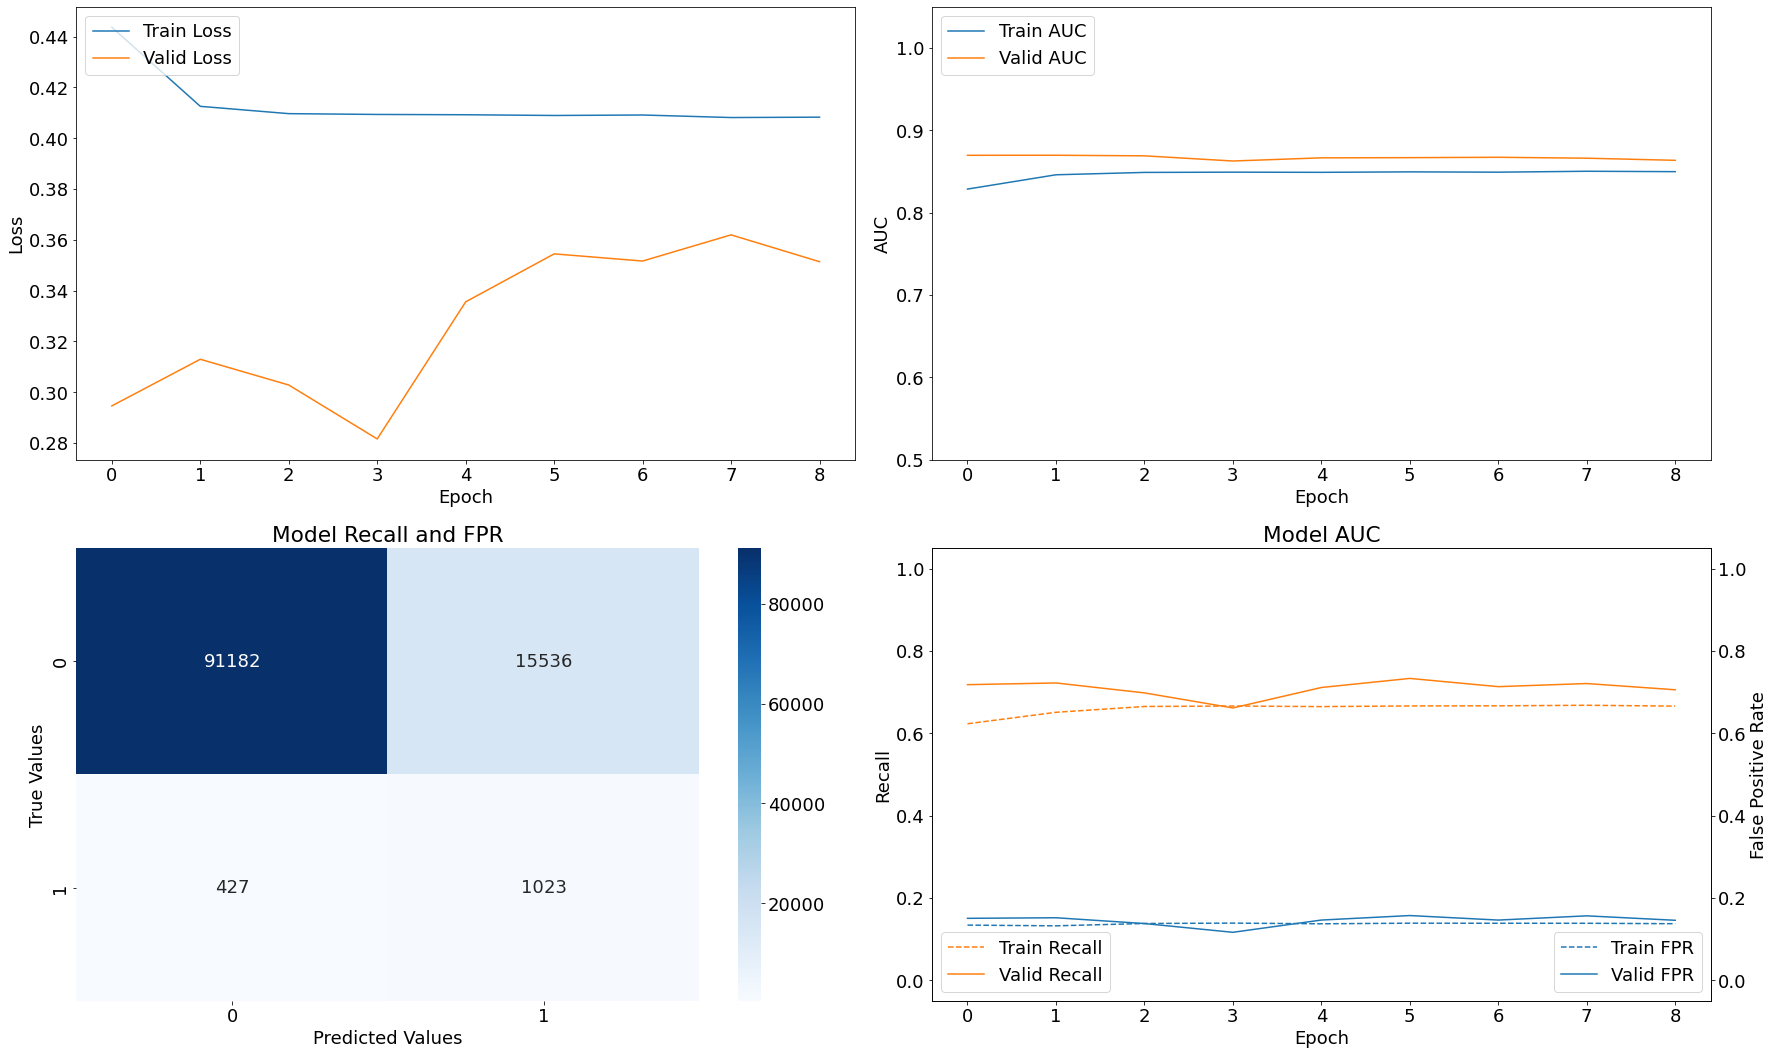

Epoch 00008: early stopping
Results for Base Model V9 with threshold = 0.2.

 Train f1: 0.5892860470456506 
 Val f1: 0.10420200933109729 

 Train Recall: 0.7692632079124451 
 Val Recall: 0.7413793206214905 

 Train FPR: 0.21039146184921265 
 Val FPR: 0.16968083381652832


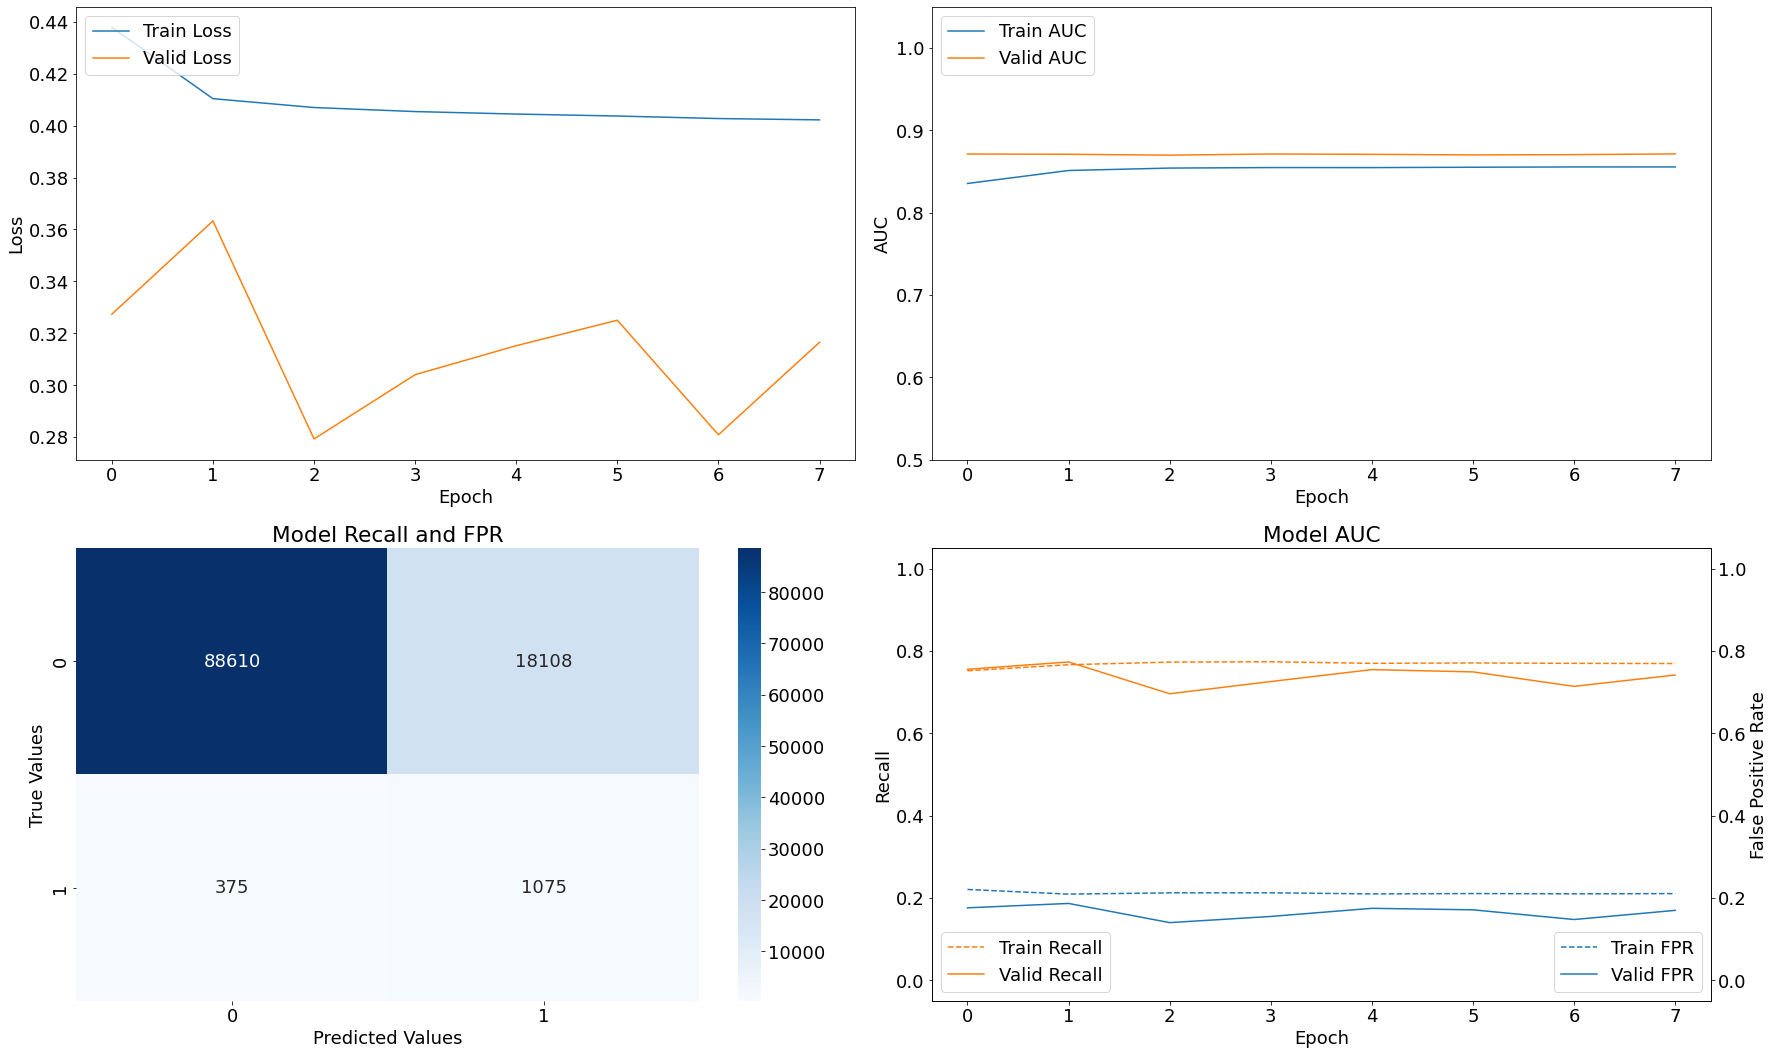

Epoch 00008: early stopping
Results for Base Model V9 with threshold = 0.1.

 Train f1: 0.5040430637306761 
 Val f1: 0.1096348978325534 

 Train Recall: 0.8885460495948792 
 Val Recall: 0.7227585911750793 

 Train FPR: 0.4092811942100525 
 Val FPR: 0.15573754906654358


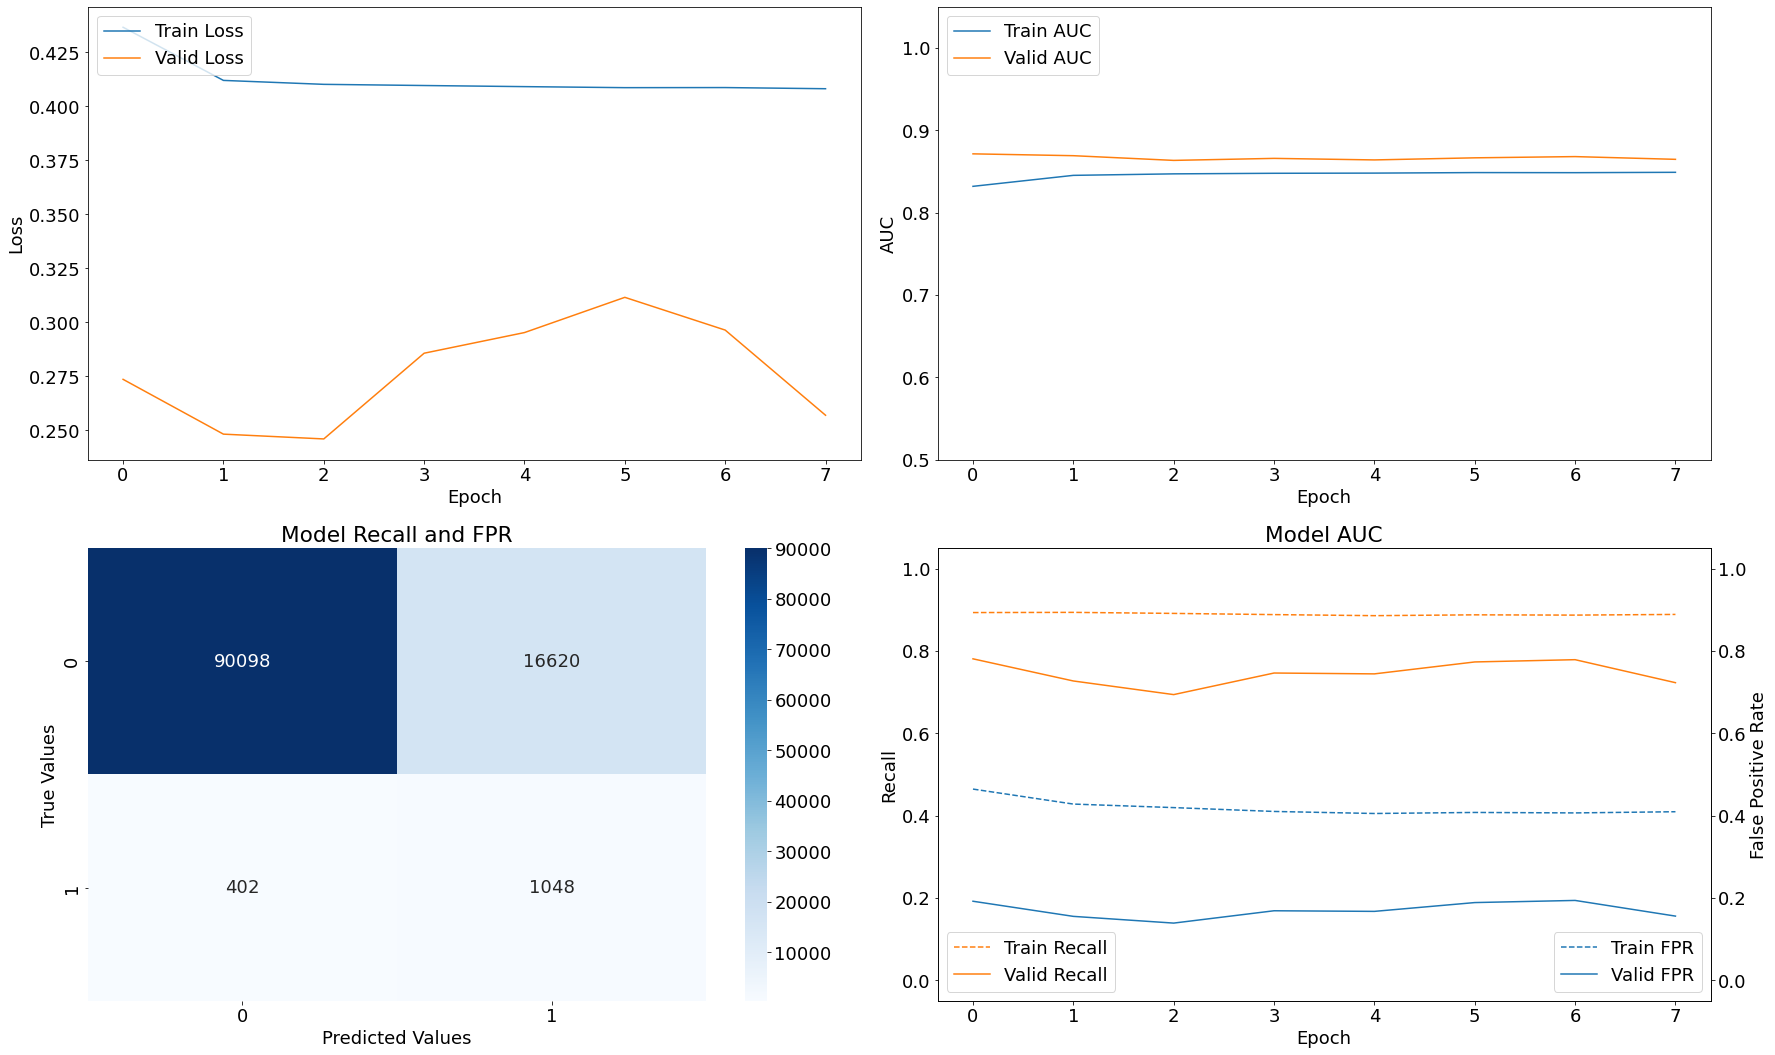

In [99]:
for t in thresholds:

    modelling_v9(X_train_base_scaled_resampled,
                 y_train_base_resampled,
                 X_val_base_scaled,
                 y_val_base,
                'Base Model V9',
                 threshold=t)

---

## Cross Feature Modelling

In addition to modelling on the base dataset, some feature engineering was explored. The first method to be tested was cross features, multiplying the features with one another to obtain new features. This process was only utilized on the base dataset due to time restraints and no noticable improvements on performance. The features were read in from the files created in `Data Prep` and `cross_n_features`, the number of cross features, was created for the input layer.

In [94]:
Xc_train_base_scaled_resampled = \
pd.read_csv('../Data/base/Xc_train_base_scaled_resampled.csv')
Xc_val_base_scaled = pd.read_csv('../Data/base/Xc_val_base_scaled.csv')

In [95]:
cross_n_features = Xc_train_base_scaled_resampled.shape[1]

---

### First Model Iteration (Cross)

The first model is a basic sequential model with an input layer of dimensionality `cross_n_features`, followed by two pairings of a relu activation dense layer followed by a 50% dropout layer. These dense layers had dimensionality 128 and 64 respectively. These higher values were chosen as the input dimension is larger here. Finally, the model's output layer is the same as the above models, a dense layer with sigmoid activation and dimensionality 1.

In terms of performance, this model did an incredible job of minimizing the false positive rate; however, performed very poorly in terms of recall. This model also appears to be extremely overfit.

In [96]:
def cross_modelling_v1(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    cross_model_v1 = models.Sequential()

    cross_model_v1.add(layers.Input(shape=(cross_n_features, )))
    cross_model_v1.add(layers.Dense(128, activation='relu'))
    cross_model_v1.add(layers.Dropout(0.5))
    cross_model_v1.add(layers.Dense(64, activation='relu'))
    cross_model_v1.add(layers.Dropout(0.5))
    cross_model_v1.add(layers.Dense(1, activation='sigmoid'))

    cross_model_v1.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['AUC',
                                    tf.keras.metrics.Precision(thresholds=threshold),
                                    tf.keras.metrics.Recall(thresholds=threshold),
                                    FalsePositiveRate(threshold=threshold)])

    cross_model_v1_history = cross_model_v1.fit(X_train,
                                                y_train,
                                                batch_size=batch_size,
                                                validation_data=(X_val, y_val),
                                                class_weight=class_weight,
                                                epochs=epochs,
                                                callbacks=[early_stop],
                                                verbose=0).history
    
    evaluate(cross_model_v1,
             name, 
             cross_model_v1_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00037: early stopping
Results for Cross Feature Model V1 with threshold = 0.5.

 Train f1: 0.8574007488258837 
 Val f1: 0.054794519792290525 

 Train Recall: 0.8064603209495544 
 Val Recall: 0.033103447407484055 

 Train FPR: 0.018678558990359306 
 Val FPR: 0.0023801045026630163


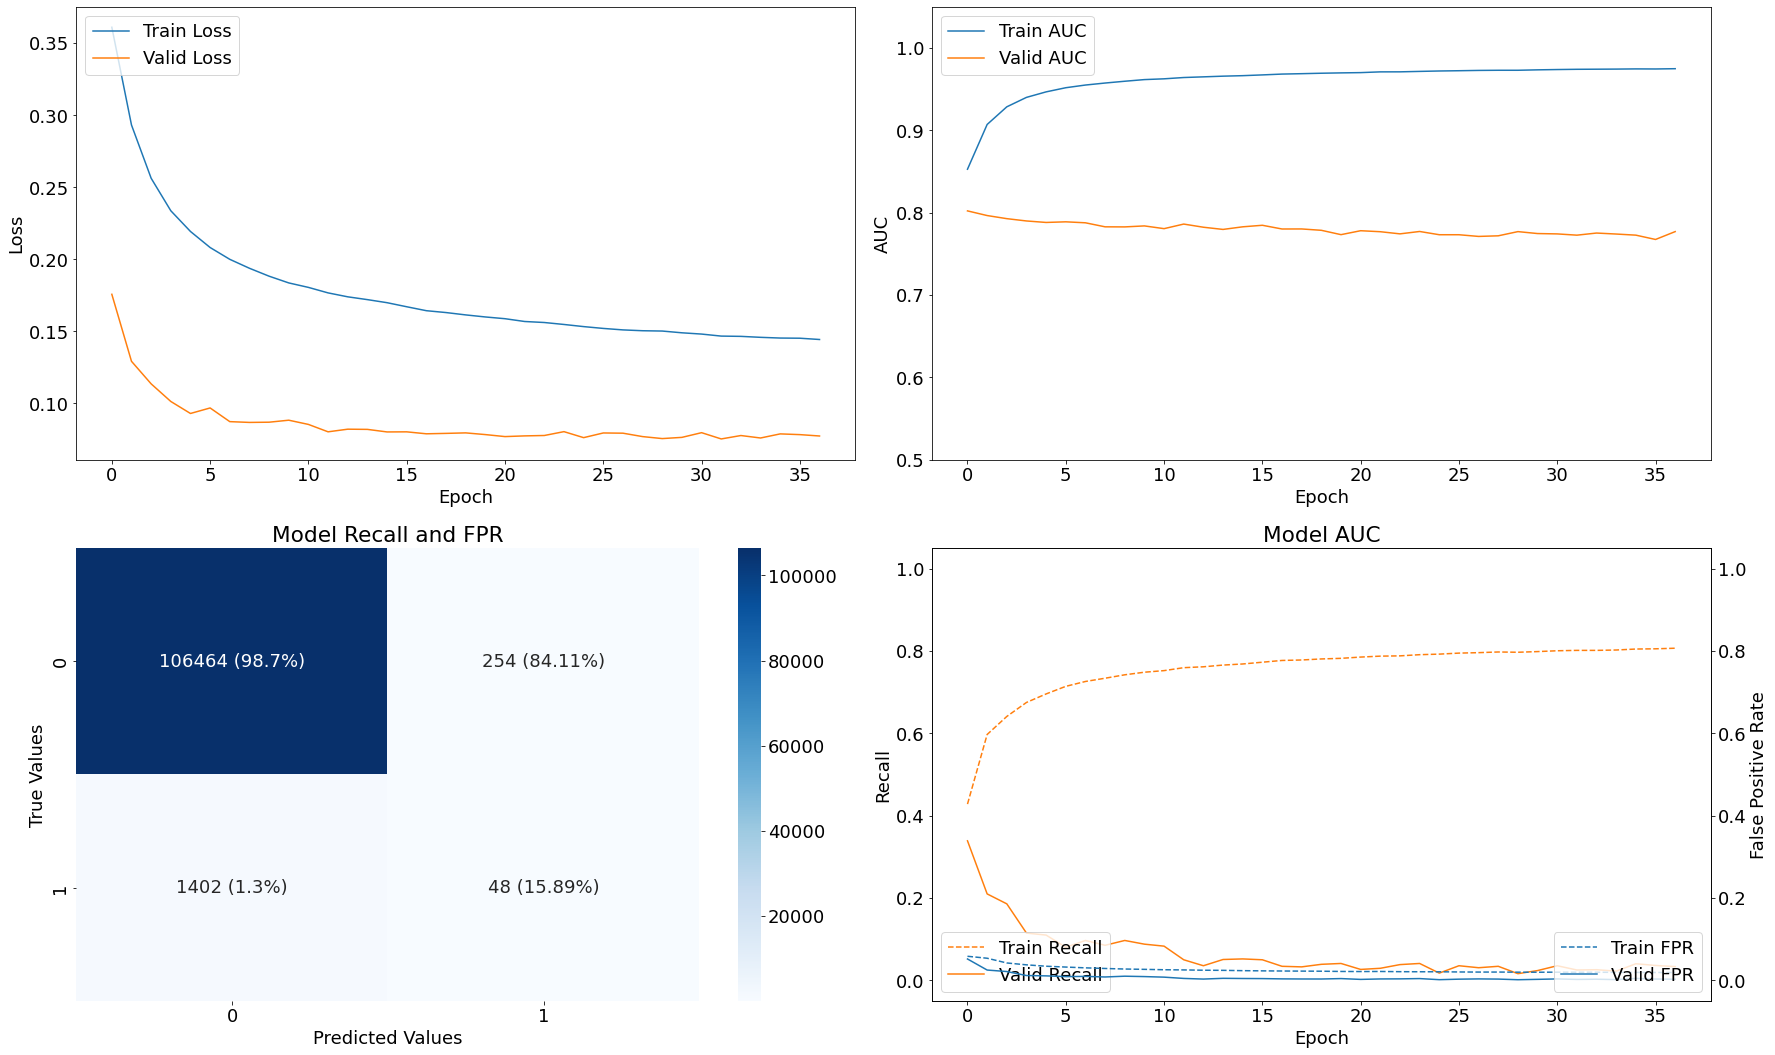

Epoch 00029: early stopping
Results for Cross Feature Model V1 with threshold = 0.4.

 Train f1: 0.8541665618968542 
 Val f1: 0.0997001487895536 

 Train Recall: 0.8347305059432983 
 Val Recall: 0.09172413498163223 

 Train FPR: 0.029940089210867882 
 Val FPR: 0.010166982188820839


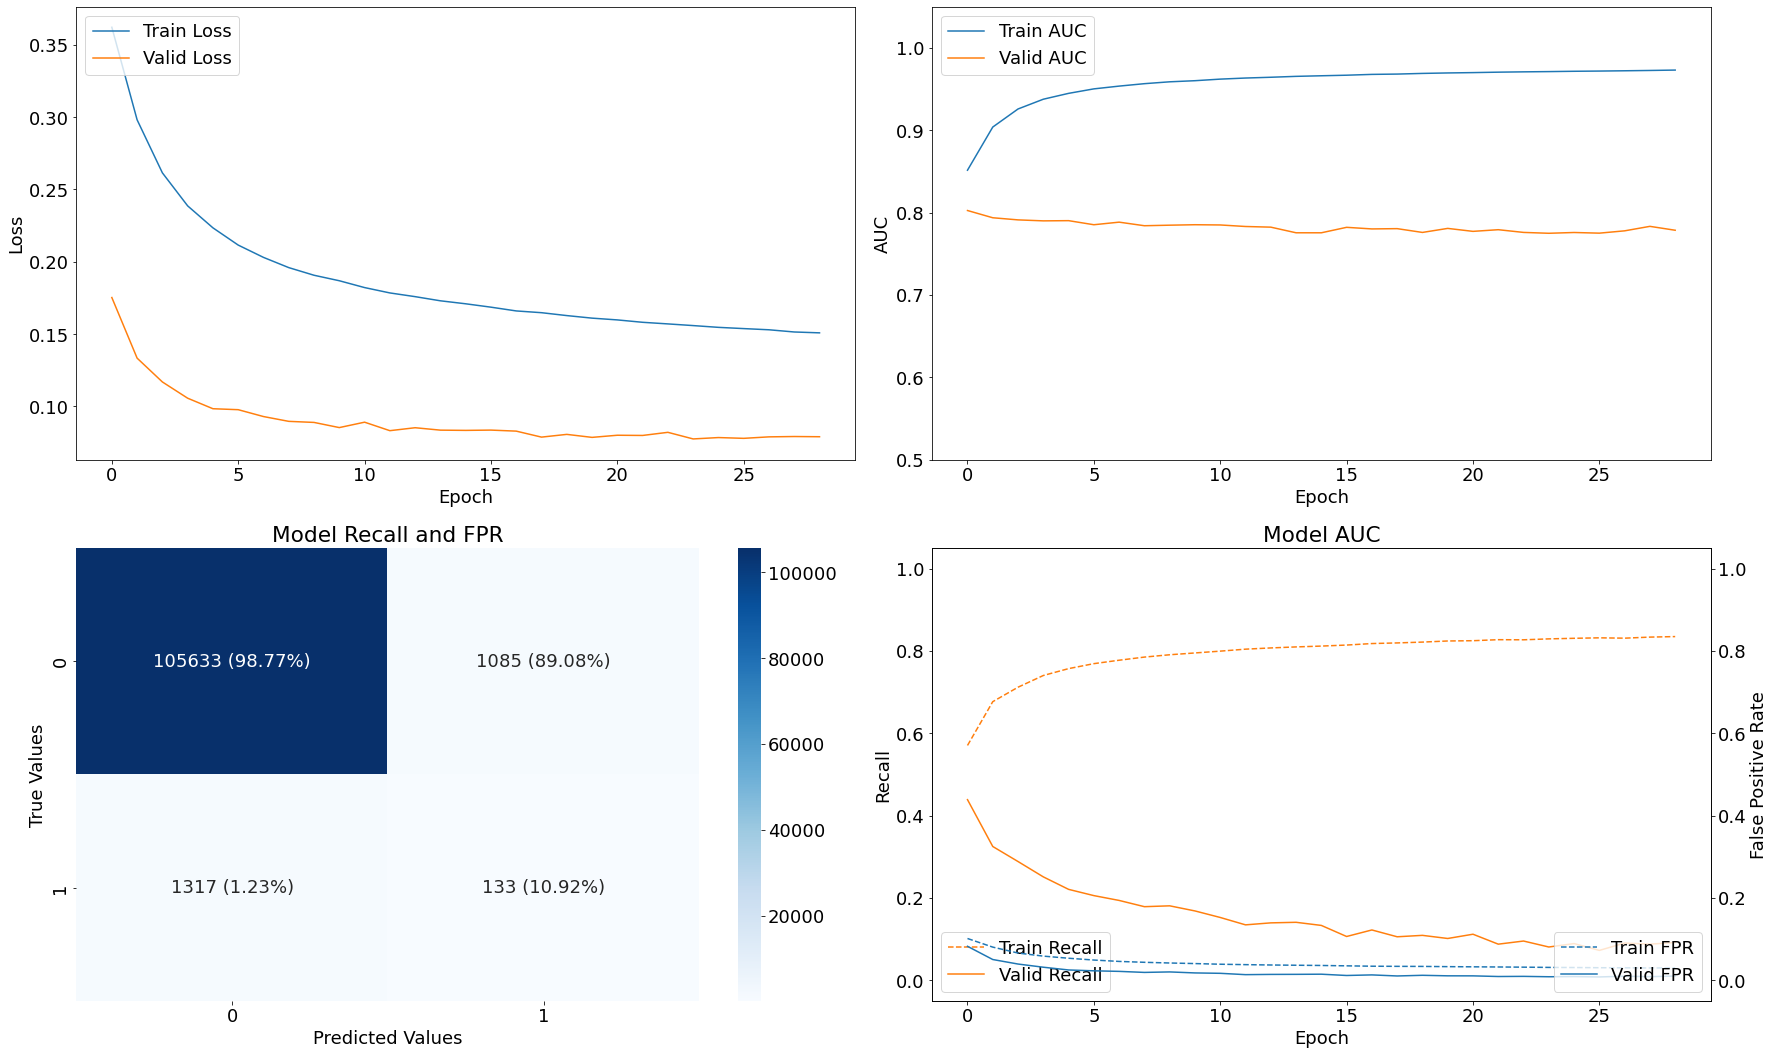

Epoch 00033: early stopping
Results for Cross Feature Model V1 with threshold = 0.3.

 Train f1: 0.8547376289347328 
 Val f1: 0.12107748312329056 

 Train Recall: 0.8746320605278015 
 Val Recall: 0.1503448337316513 

 Train FPR: 0.04297962039709091 
 Val FPR: 0.018113158643245697


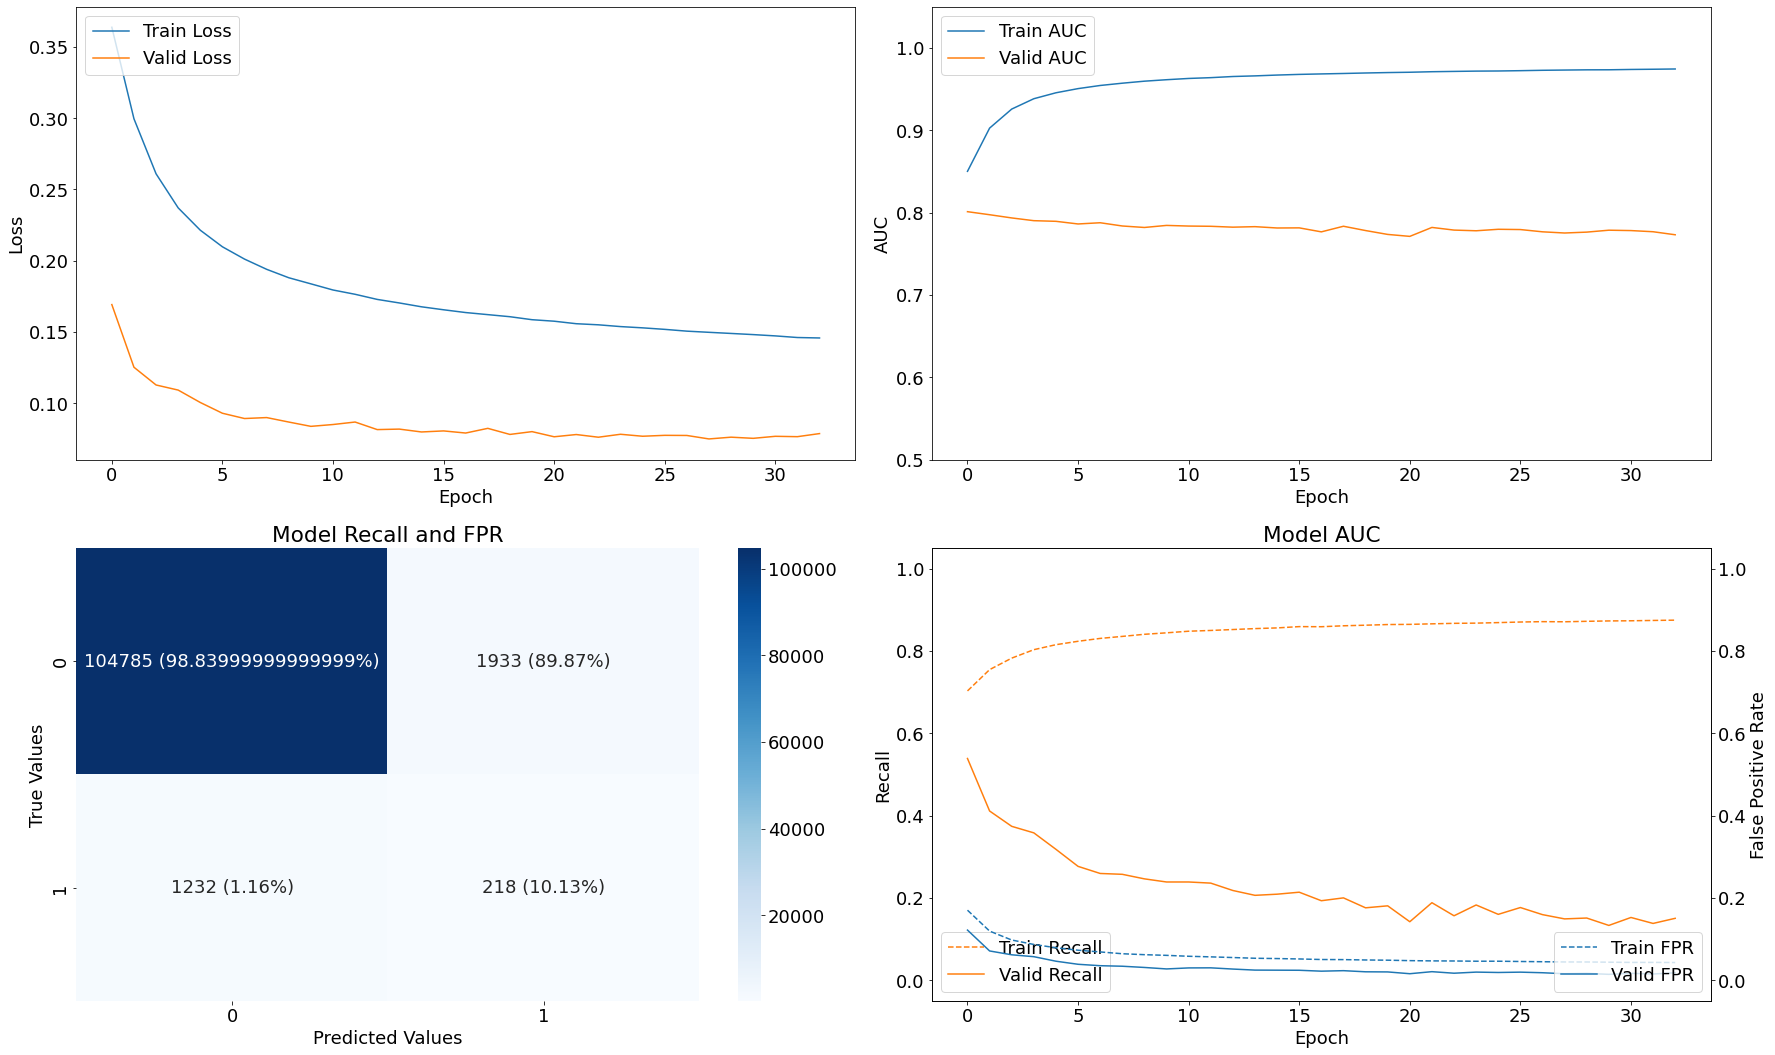

Epoch 00020: early stopping
Results for Cross Feature Model V1 with threshold = 0.2.

 Train f1: 0.812694650993482 
 Val f1: 0.13454296723785097 

 Train Recall: 0.9040969014167786 
 Val Recall: 0.27103447914123535 

 Train FPR: 0.0802096500992775 
 Val FPR: 0.03747259080410004


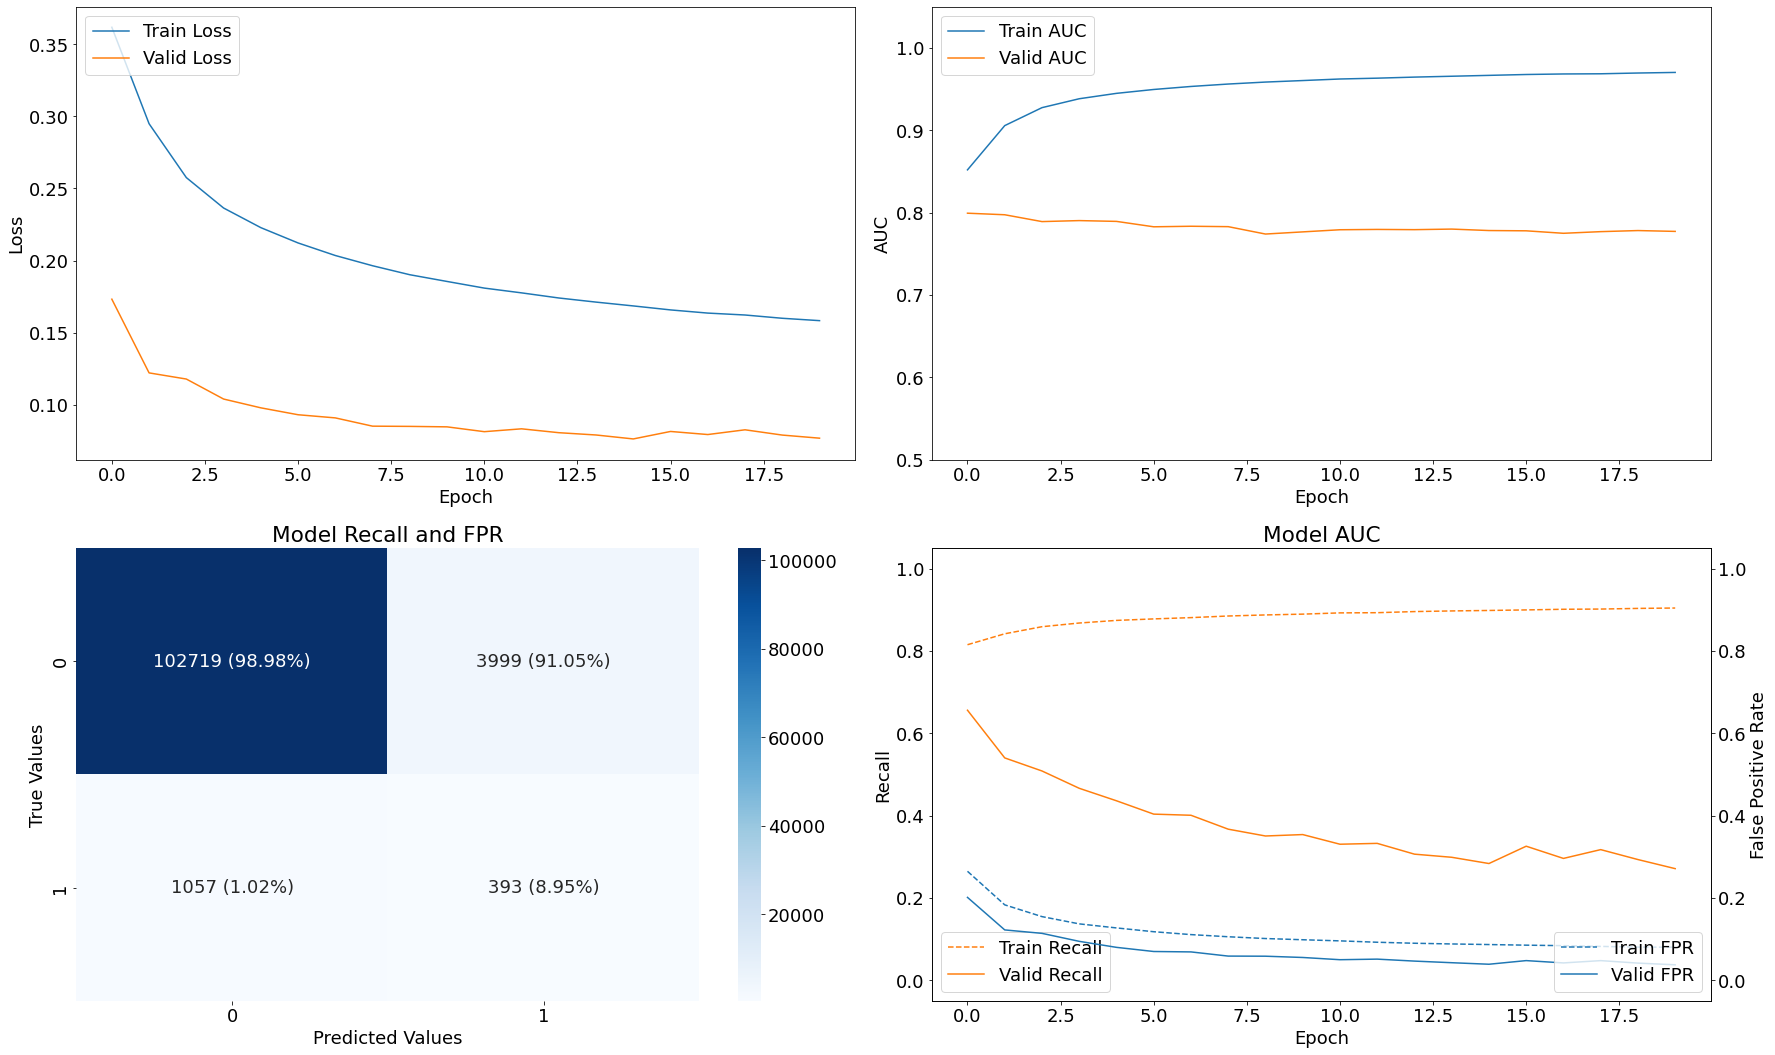

Epoch 00032: early stopping
Results for Cross Feature Model V1 with threshold = 0.1.

 Train f1: 0.7511592813012635 
 Val f1: 0.11070487546745282 

 Train Recall: 0.9490770697593689 
 Val Recall: 0.44896551966667175 

 Train FPR: 0.1444719284772873 
 Val FPR: 0.09051893651485443


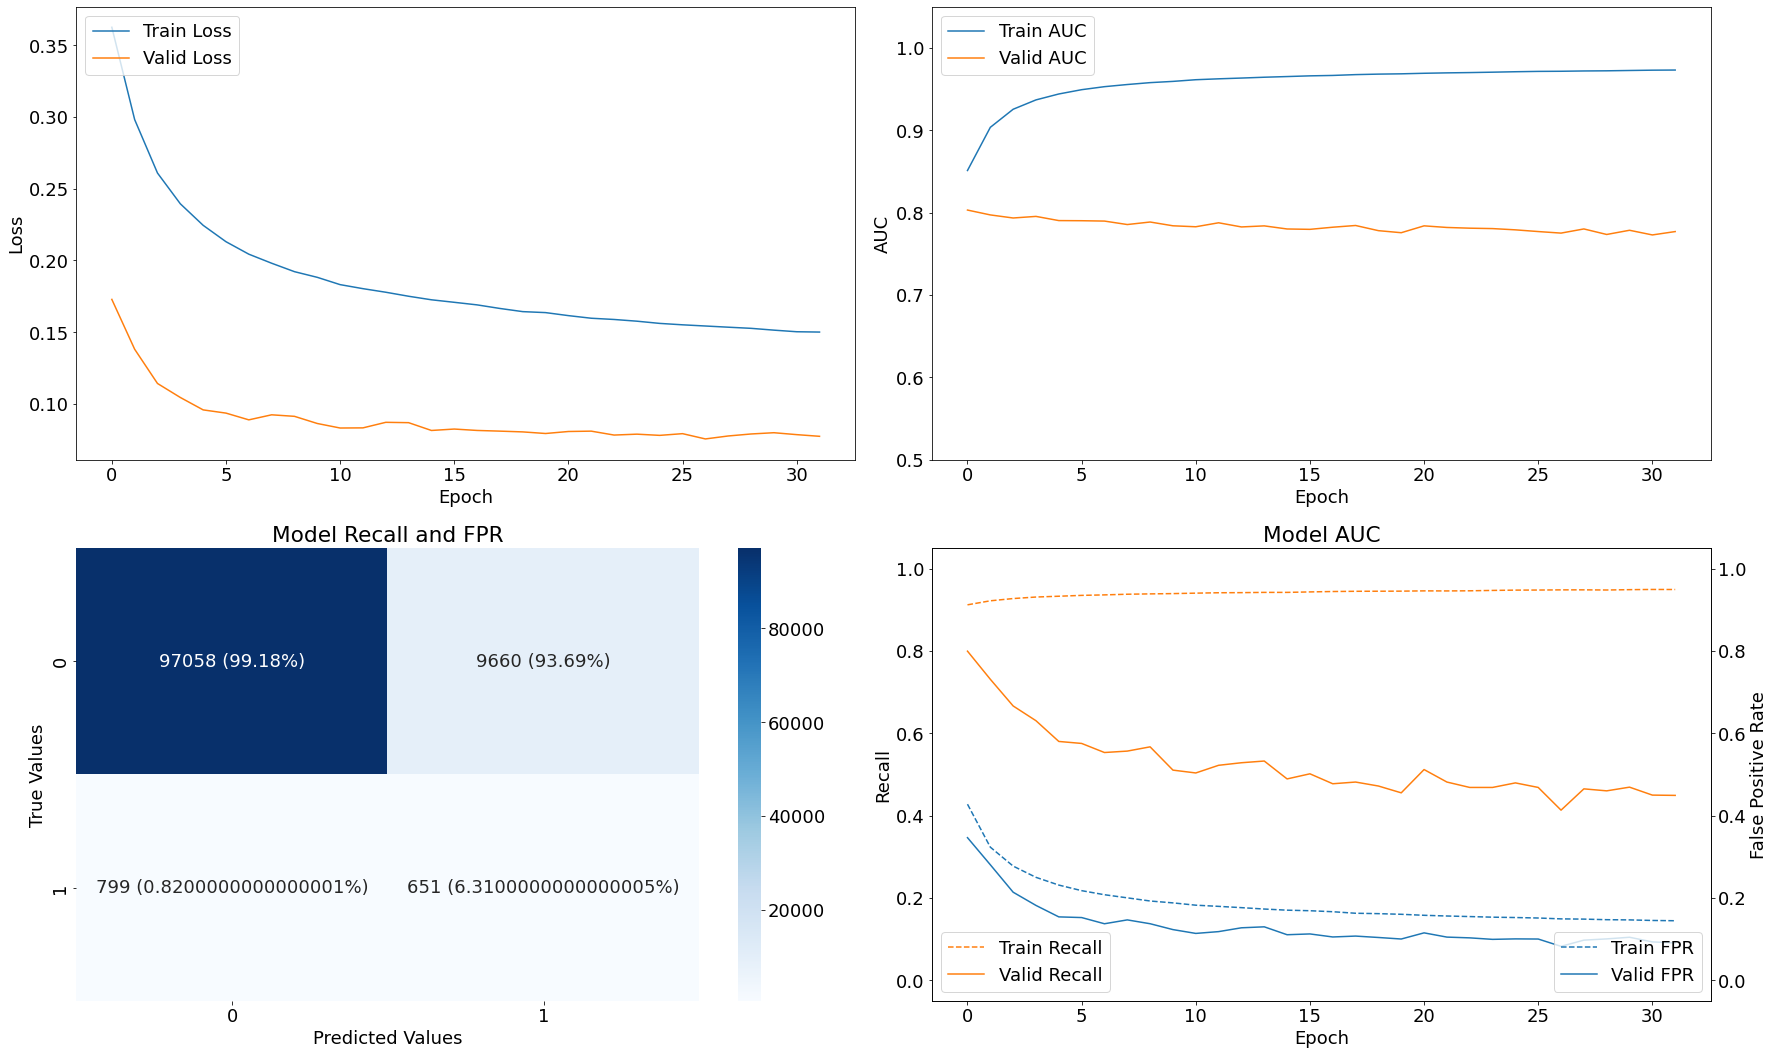

In [97]:
for t in thresholds:

    cross_modelling_v1(Xc_train_base_scaled_resampled,
                      y_train_base_resampled,
                      Xc_val_base_scaled,
                      y_val_base,
                      'Cross Feature Model V1',
                      threshold=t)

---

### Second Model Iteration (Cross)

The second iteration of the cross features model added L2 regularization as well as an additional relu activation dense layer preceding the output layer. This model did a much better job in terms of our performance metrics; however, as the threshold decreases, the false positive rate sky rockets. Due to this behavior, this model will not provide useful for a final evaluation.

In [98]:
def cross_modelling_v2(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    cross_model_v2 = models.Sequential()

    cross_model_v2.add(layers.Input(shape=(cross_n_features, )))
    cross_model_v2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v2.add(layers.Dropout(0.5))
    cross_model_v2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v2.add(layers.Dropout(0.5))
    cross_model_v2.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v2.add(layers.Dense(1, activation='sigmoid'))

    cross_model_v2.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['AUC',
                                    tf.keras.metrics.Precision(thresholds=threshold),
                                    tf.keras.metrics.Recall(thresholds=threshold),
                                    FalsePositiveRate(threshold=threshold)])

    cross_model_v2_history = cross_model_v2.fit(X_train,
                                                y_train,
                                                batch_size=batch_size,
                                                validation_data=(X_val, y_val),
                                                class_weight=class_weight,
                                                epochs=epochs,
                                                callbacks=[early_stop],
                                                verbose=0).history
    
    evaluate(cross_model_v2,
             name, 
             cross_model_v2_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00008: early stopping
Results for Cross Feature Model V2 with threshold = 0.5.

 Train f1: 0.46009655156923307 
 Val f1: 0.1282691512960264 

 Train Recall: 0.37084728479385376 
 Val Recall: 0.3365517258644104 

 Train FPR: 0.06029830873012543 
 Val FPR: 0.053140051662921906


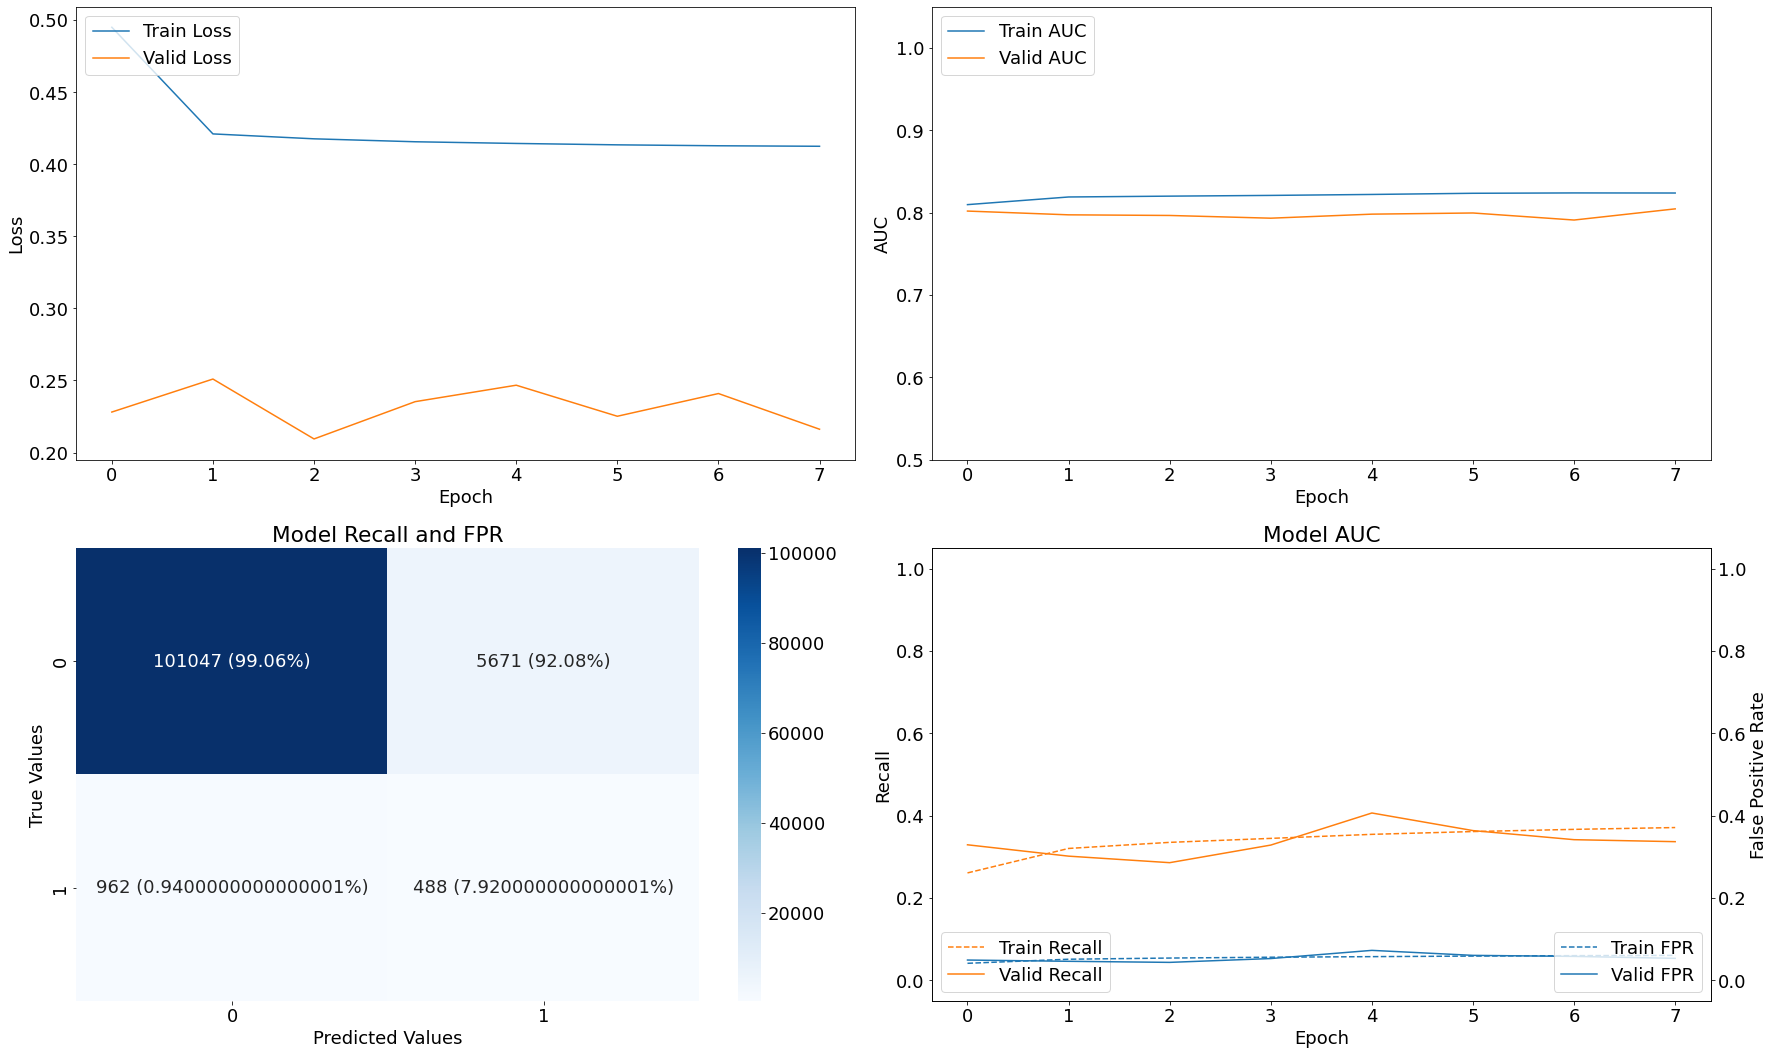

Epoch 00008: early stopping
Results for Cross Feature Model V2 with threshold = 0.4.

 Train f1: 0.5443273816692783 
 Val f1: 0.0978207643716618 

 Train Recall: 0.5434474349021912 
 Val Recall: 0.5510345101356506 

 Train FPR: 0.11332955211400986 
 Val FPR: 0.1320021003484726


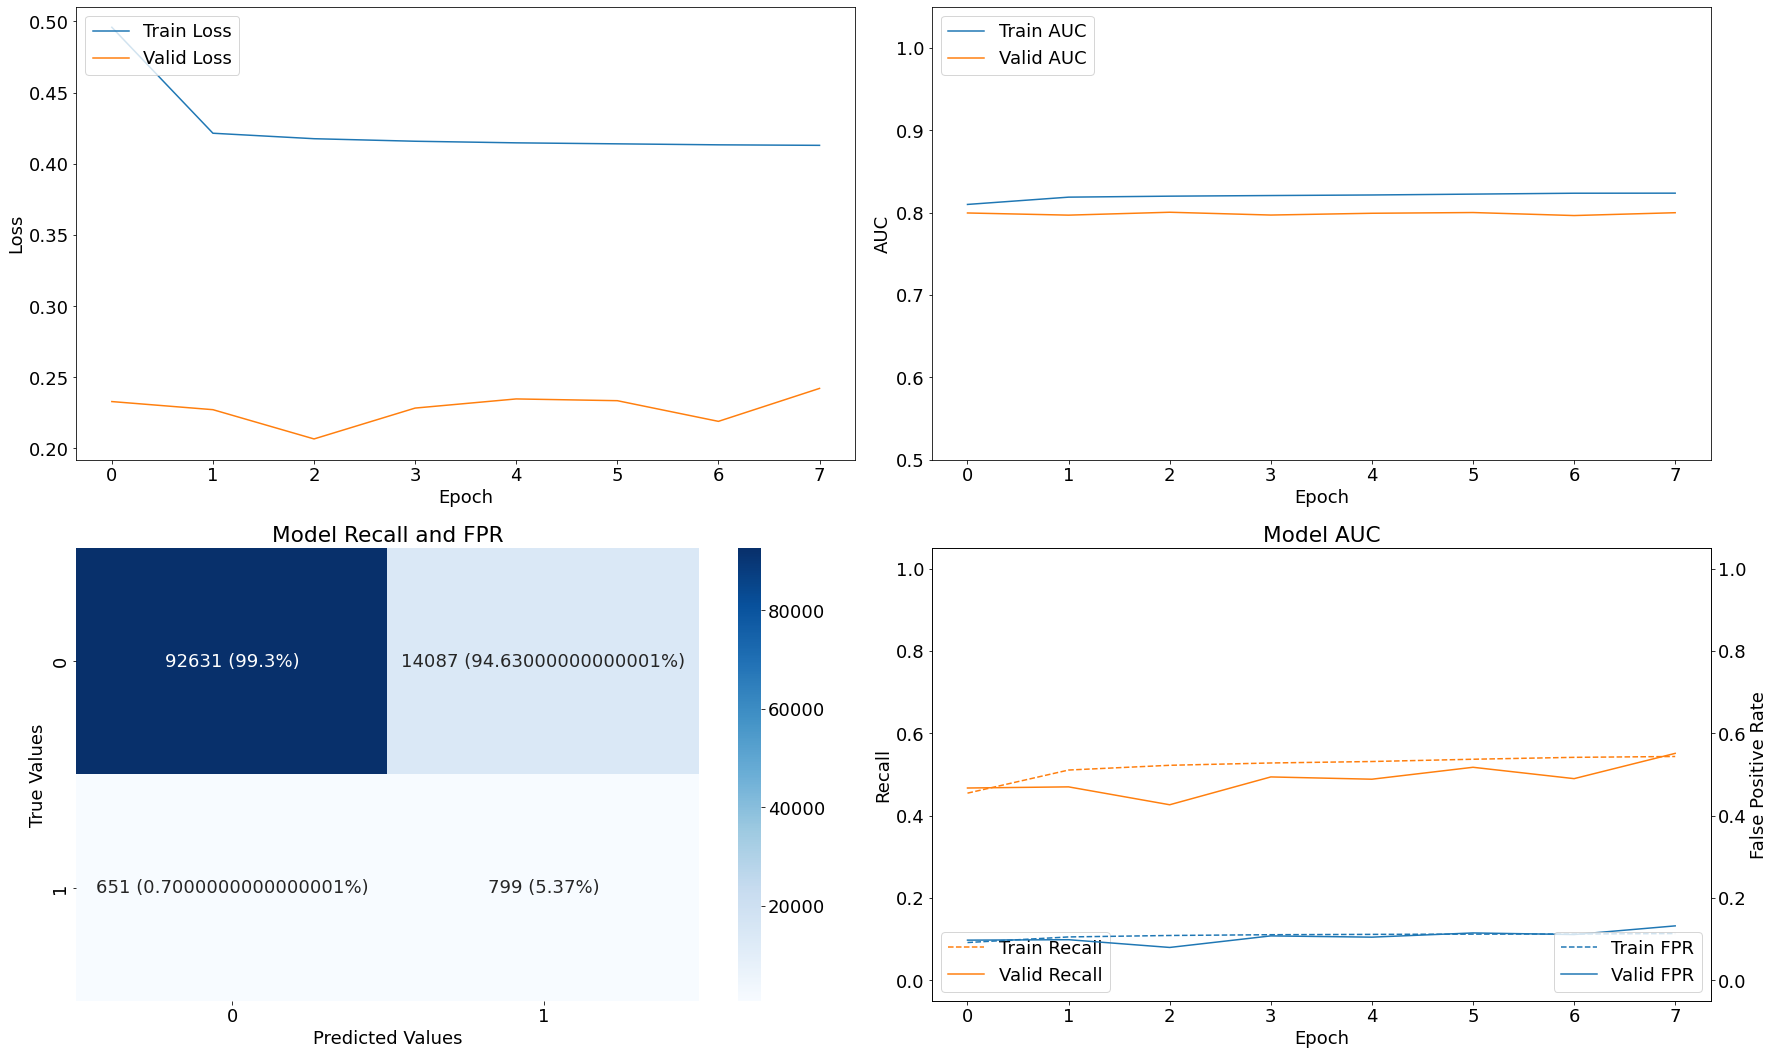

Epoch 00009: early stopping
Results for Cross Feature Model V2 with threshold = 0.3.

 Train f1: 0.5627067774709362 
 Val f1: 0.08406936397956055 

 Train Recall: 0.6713826060295105 
 Val Recall: 0.6268965601921082 

 Train FPR: 0.17871913313865662 
 Val FPR: 0.18053187429904938


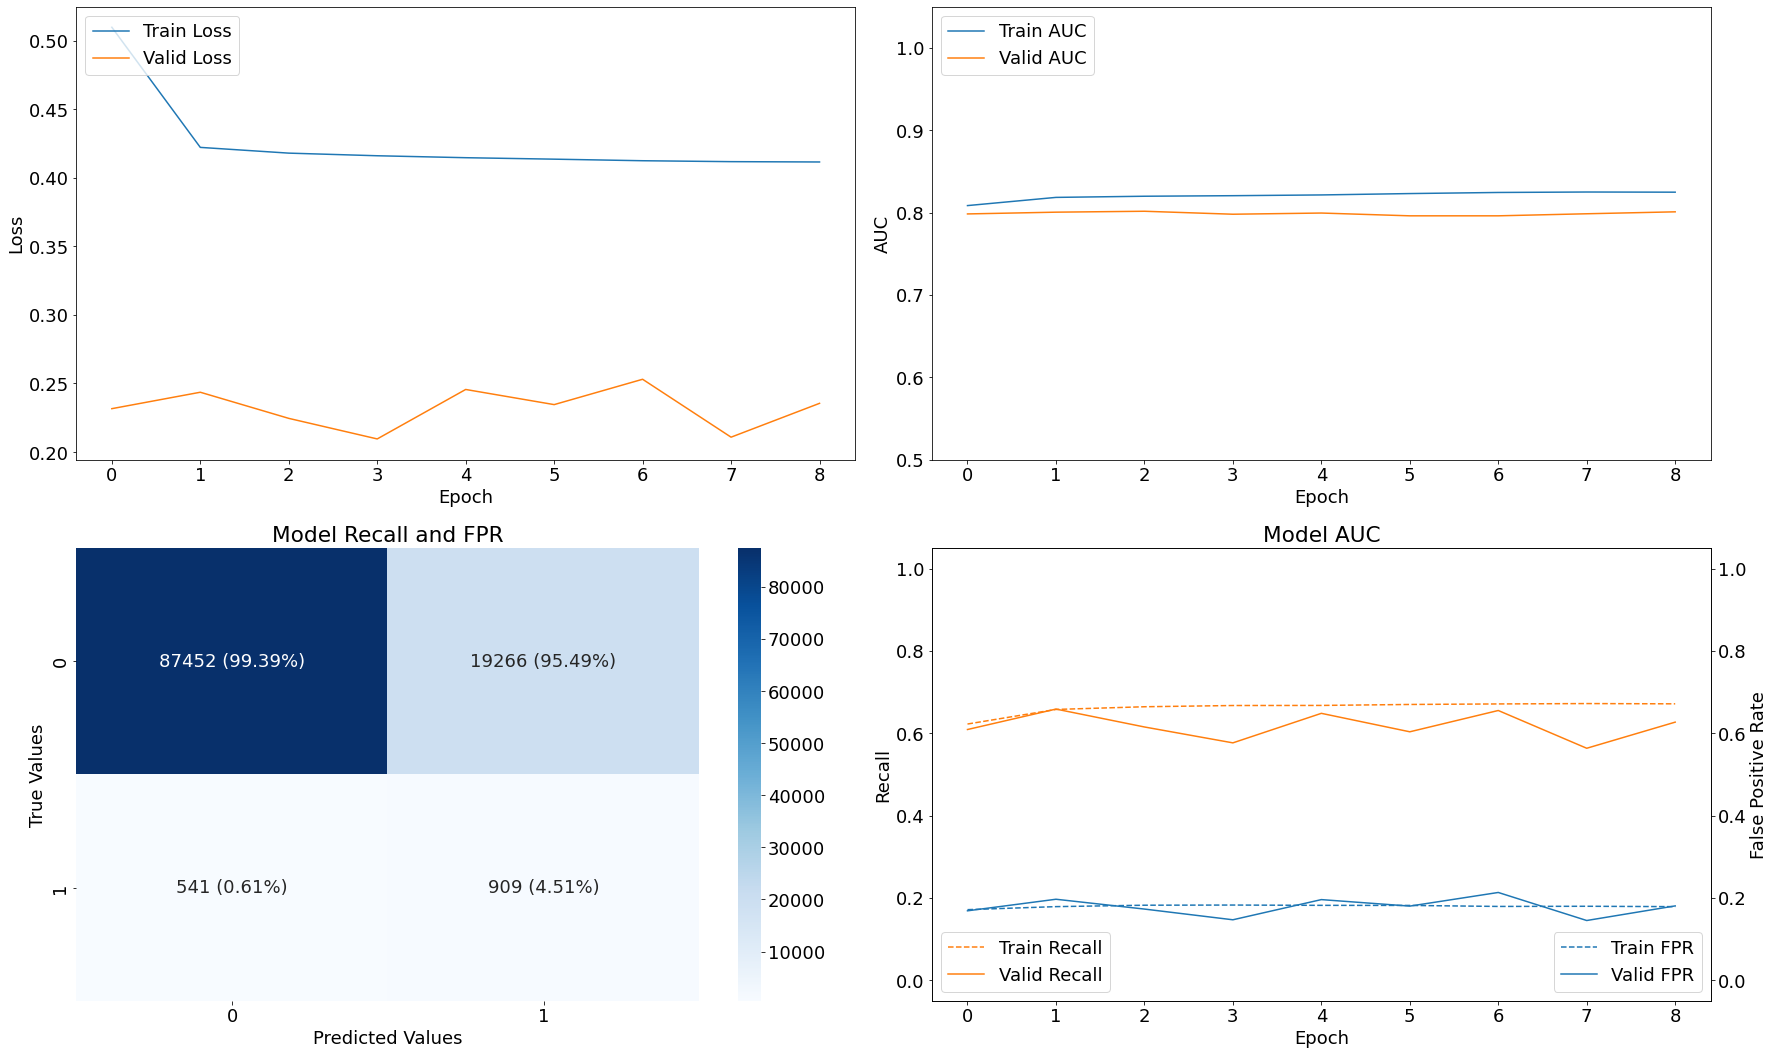

Epoch 00010: early stopping
Results for Cross Feature Model V2 with threshold = 0.2.

 Train f1: 0.5442132903889894 
 Val f1: 0.0624613464177895 

 Train Recall: 0.7792932987213135 
 Val Recall: 0.7662069201469421 

 Train FPR: 0.27115747332572937 
 Val FPR: 0.3093479871749878


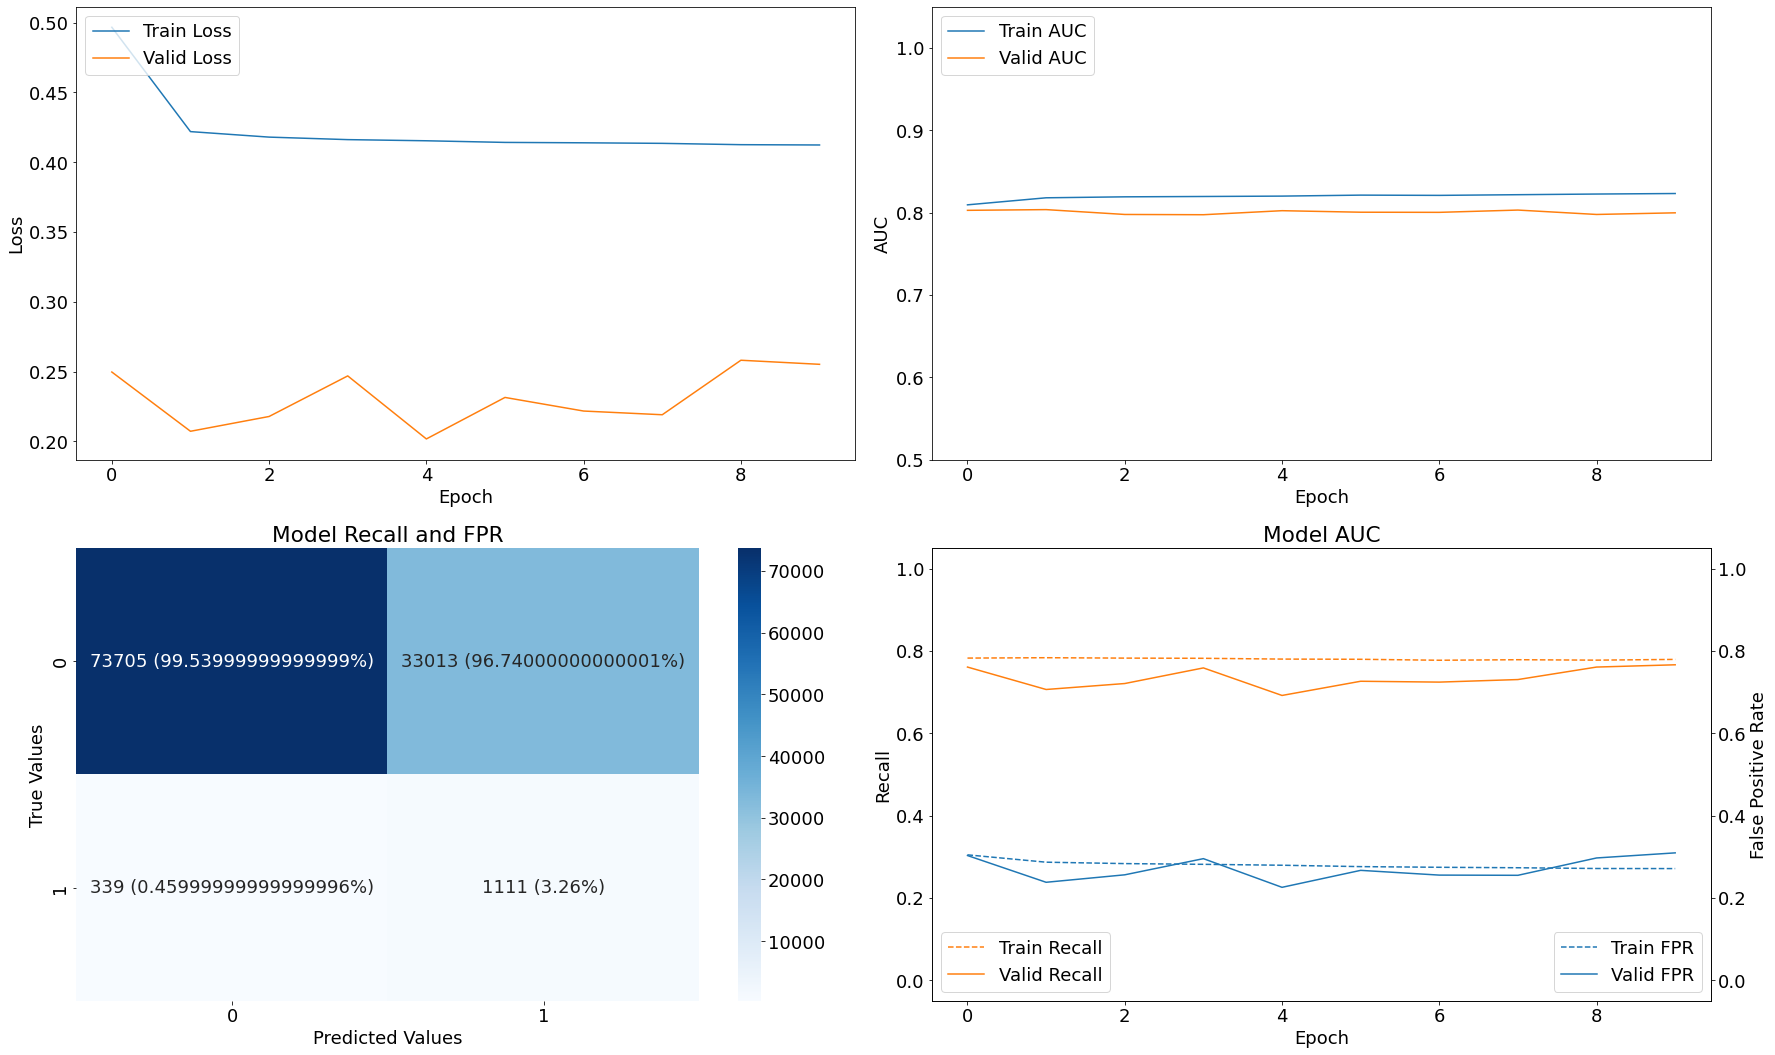

Epoch 00013: early stopping
Results for Cross Feature Model V2 with threshold = 0.1.

 Train f1: 0.49083650682568447 
 Val f1: 0.05095727776159457 

 Train Recall: 0.8866854310035706 
 Val Recall: 0.8406896591186523 

 Train FPR: 0.43156659603118896 
 Val FPR: 0.42331191897392273


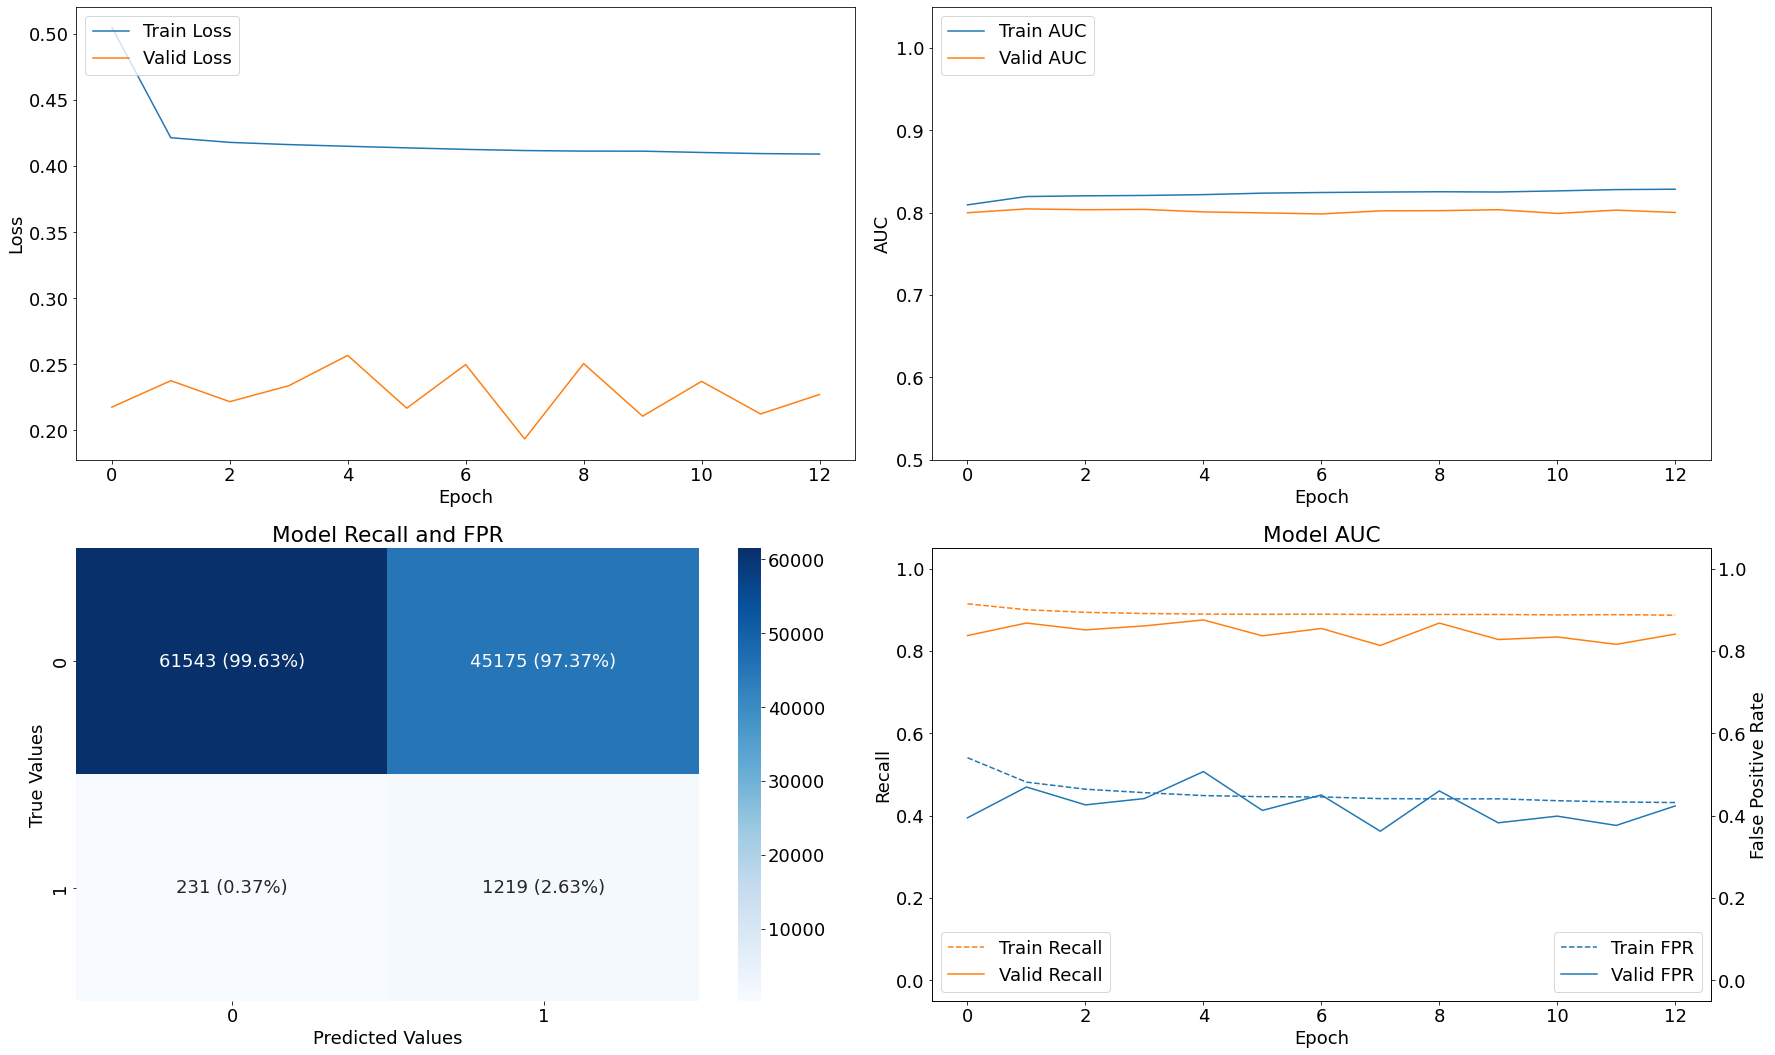

In [99]:
for t in thresholds:

    cross_modelling_v2(Xc_train_base_scaled_resampled,
                      y_train_base_resampled,
                      Xc_val_base_scaled,
                      y_val_base,
                      'Cross Feature Model V2',
                       threshold=t)

---

### Third Model Iteration (Cross)

The third iteration of the model adds an additional 50% dropout layer following the last non-output layer from the previous model. It also adds two dense layers preceding the output layer of dimensionality 16 and 8. Again, this model performs well on our given metrics and does not appear to be overfit; however, the same issue as occurred in the previous model occurs here.

In [100]:
def cross_modelling_v3(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):

    
    cross_model_v3 = models.Sequential()

    cross_model_v3.add(layers.Input(shape=(cross_n_features, )))
    cross_model_v3.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v3.add(layers.Dropout(0.5))
    cross_model_v3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v3.add(layers.Dropout(0.5))
    cross_model_v3.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v3.add(layers.Dropout(0.5))
    cross_model_v3.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v3.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2()))
    cross_model_v3.add(layers.Dense(1, activation='sigmoid'))

    cross_model_v3.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['AUC',
                                    tf.keras.metrics.Precision(thresholds=threshold),
                                    tf.keras.metrics.Recall(thresholds=threshold),
                                    FalsePositiveRate(threshold=threshold)])

    cross_model_v3_history = cross_model_v3.fit(X_train,
                                                y_train,
                                                batch_size=batch_size,
                                                validation_data=(X_val, y_val),
                                                class_weight=class_weight,
                                                epochs=epochs,
                                                callbacks=[early_stop],
                                                verbose=0).history
    
    evaluate(cross_model_v3,
             name, 
             cross_model_v3_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00012: early stopping
Results for Cross Feature Model V3 with threshold = 0.5.

 Train f1: 0.45241156699039753 
 Val f1: 0.12423679652133042 

 Train Recall: 0.3621898293495178 
 Val Recall: 0.32275861501693726 

 Train FPR: 0.05974037945270538 
 Val FPR: 0.052624672651290894


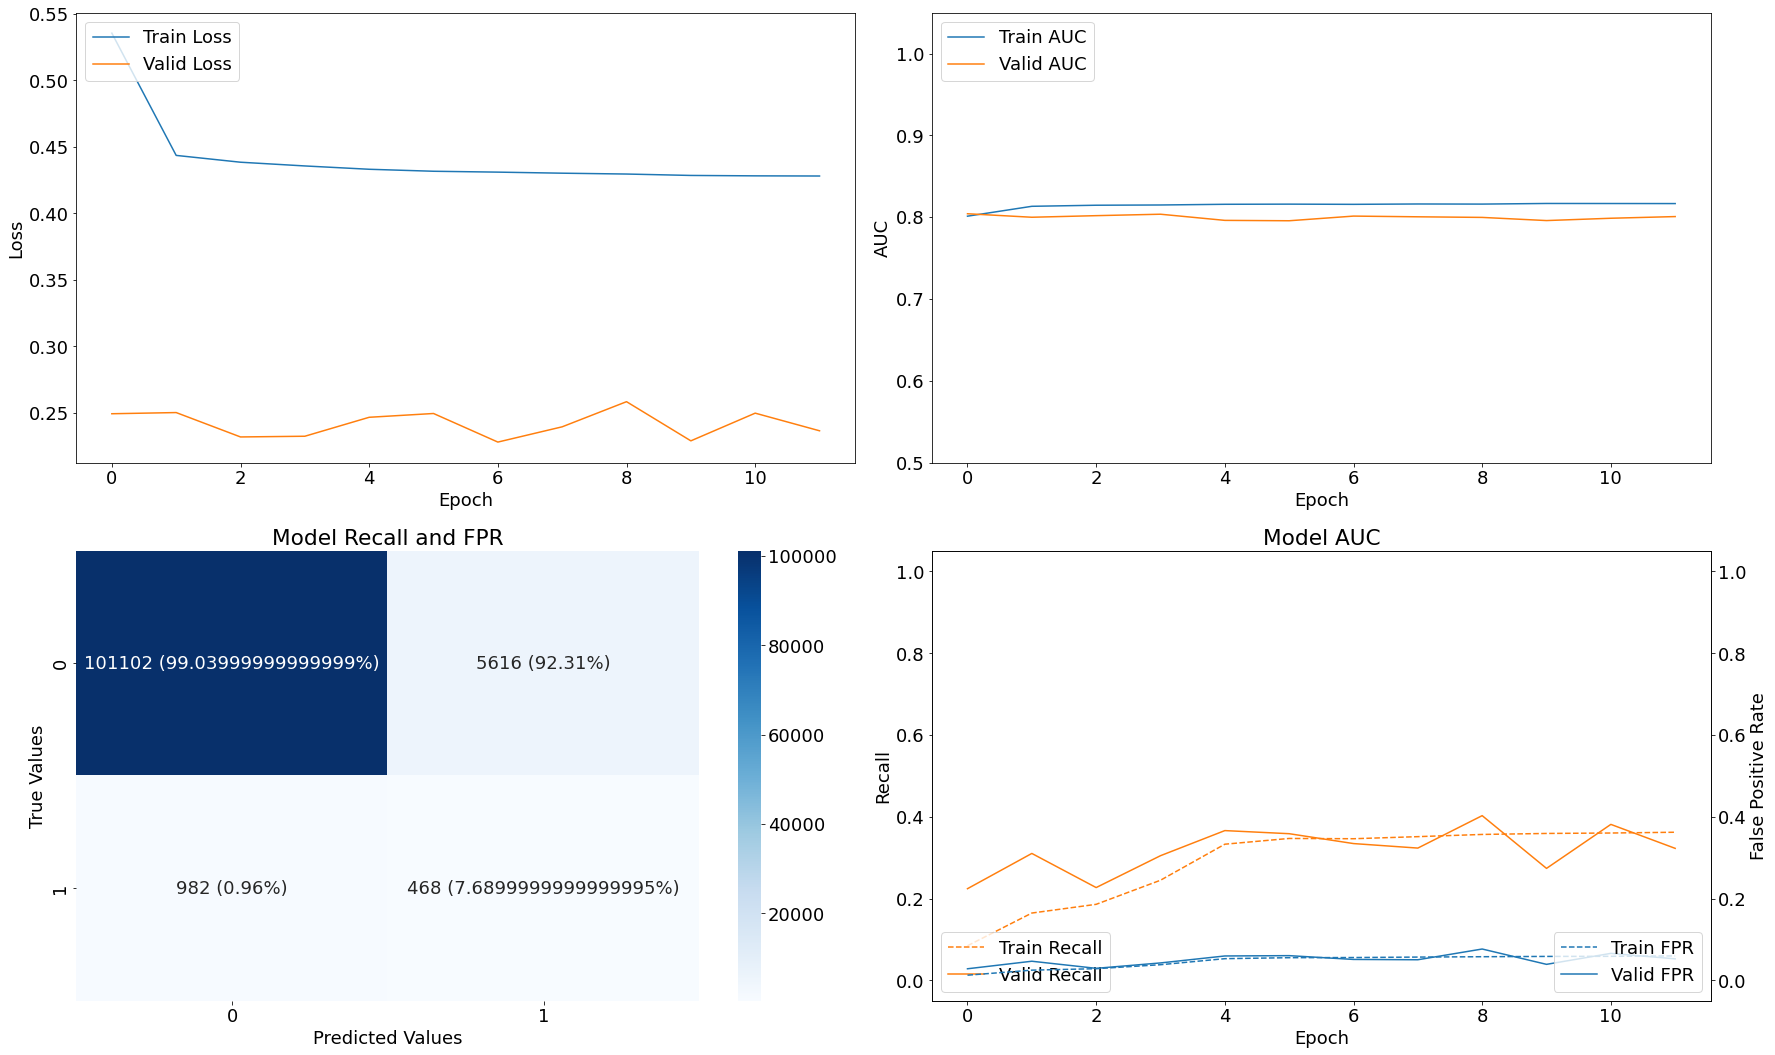

Epoch 00014: early stopping
Results for Cross Feature Model V3 with threshold = 0.4.

 Train f1: 0.540554163814143 
 Val f1: 0.10379782948789358 

 Train Recall: 0.5456791520118713 
 Val Recall: 0.5013793110847473 

 Train FPR: 0.11832041293382645 
 Val FPR: 0.11086226999759674


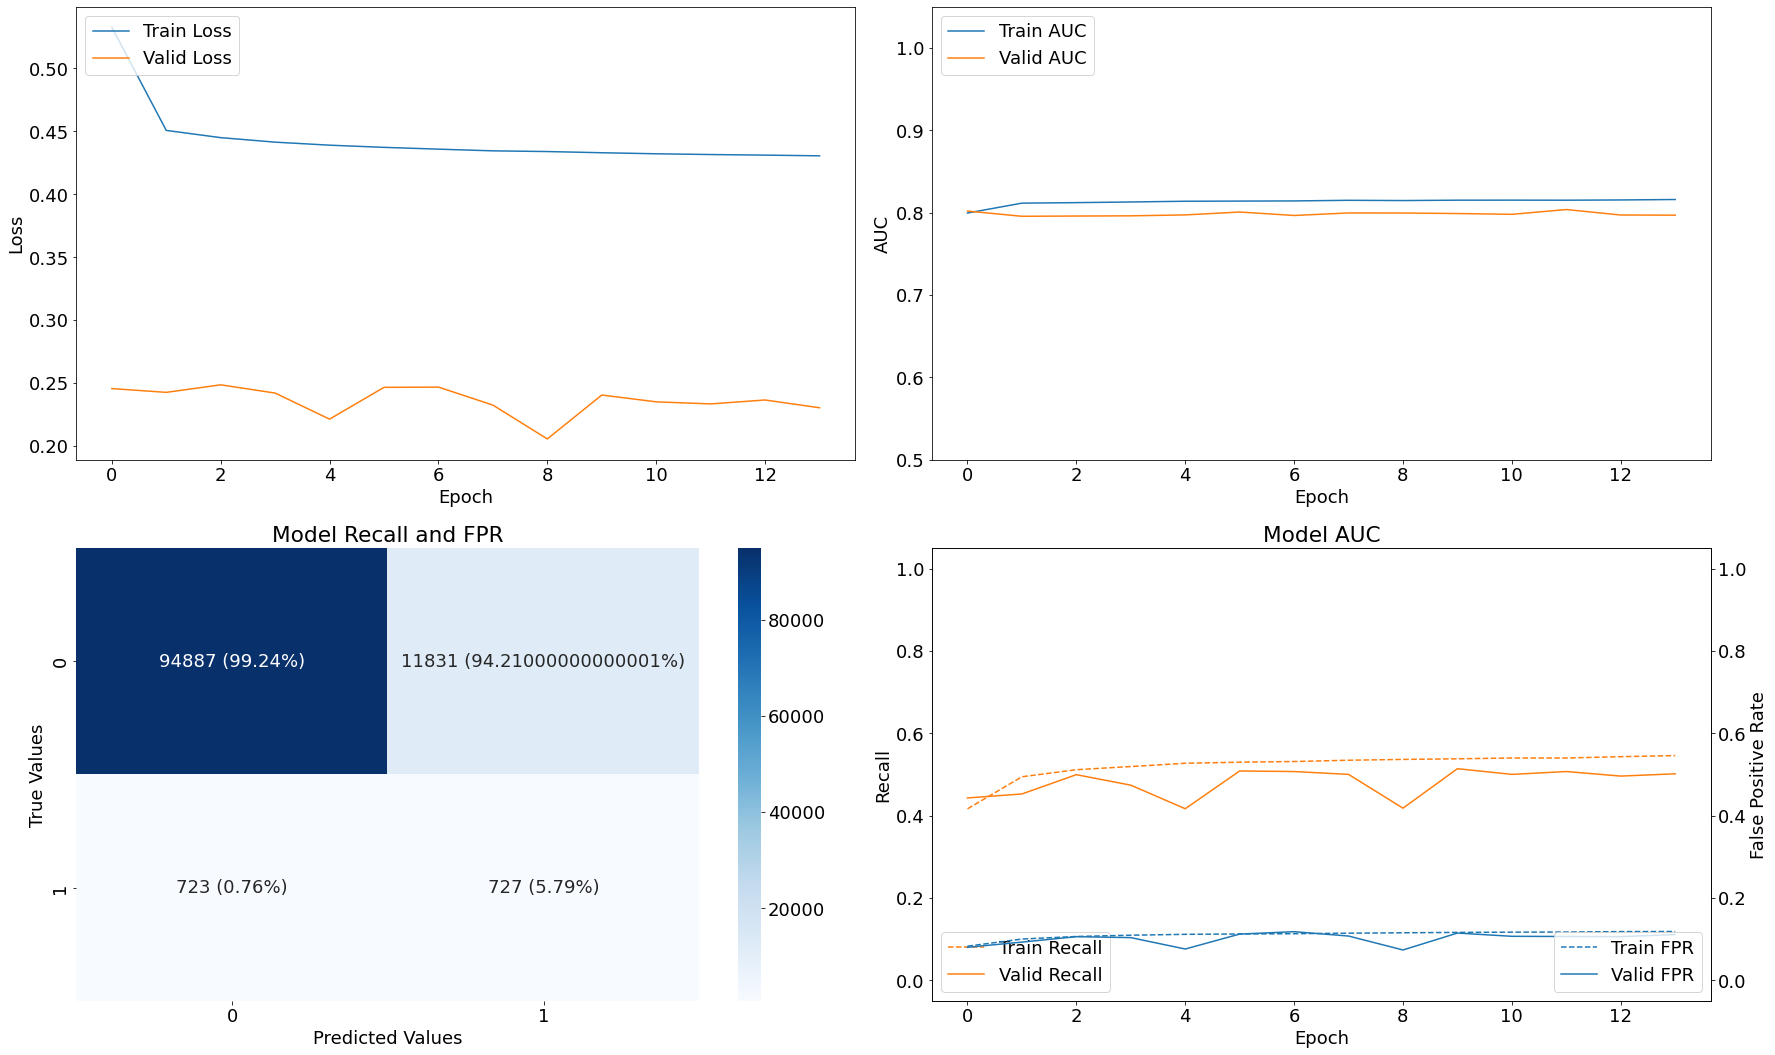

Epoch 00008: early stopping
Results for Cross Feature Model V3 with threshold = 0.3.

 Train f1: 0.5527625781911709 
 Val f1: 0.08167410080667889 

 Train Recall: 0.6714690327644348 
 Val Recall: 0.6379310488700867 

 Train FPR: 0.1895078718662262 
 Val FPR: 0.18999606370925903


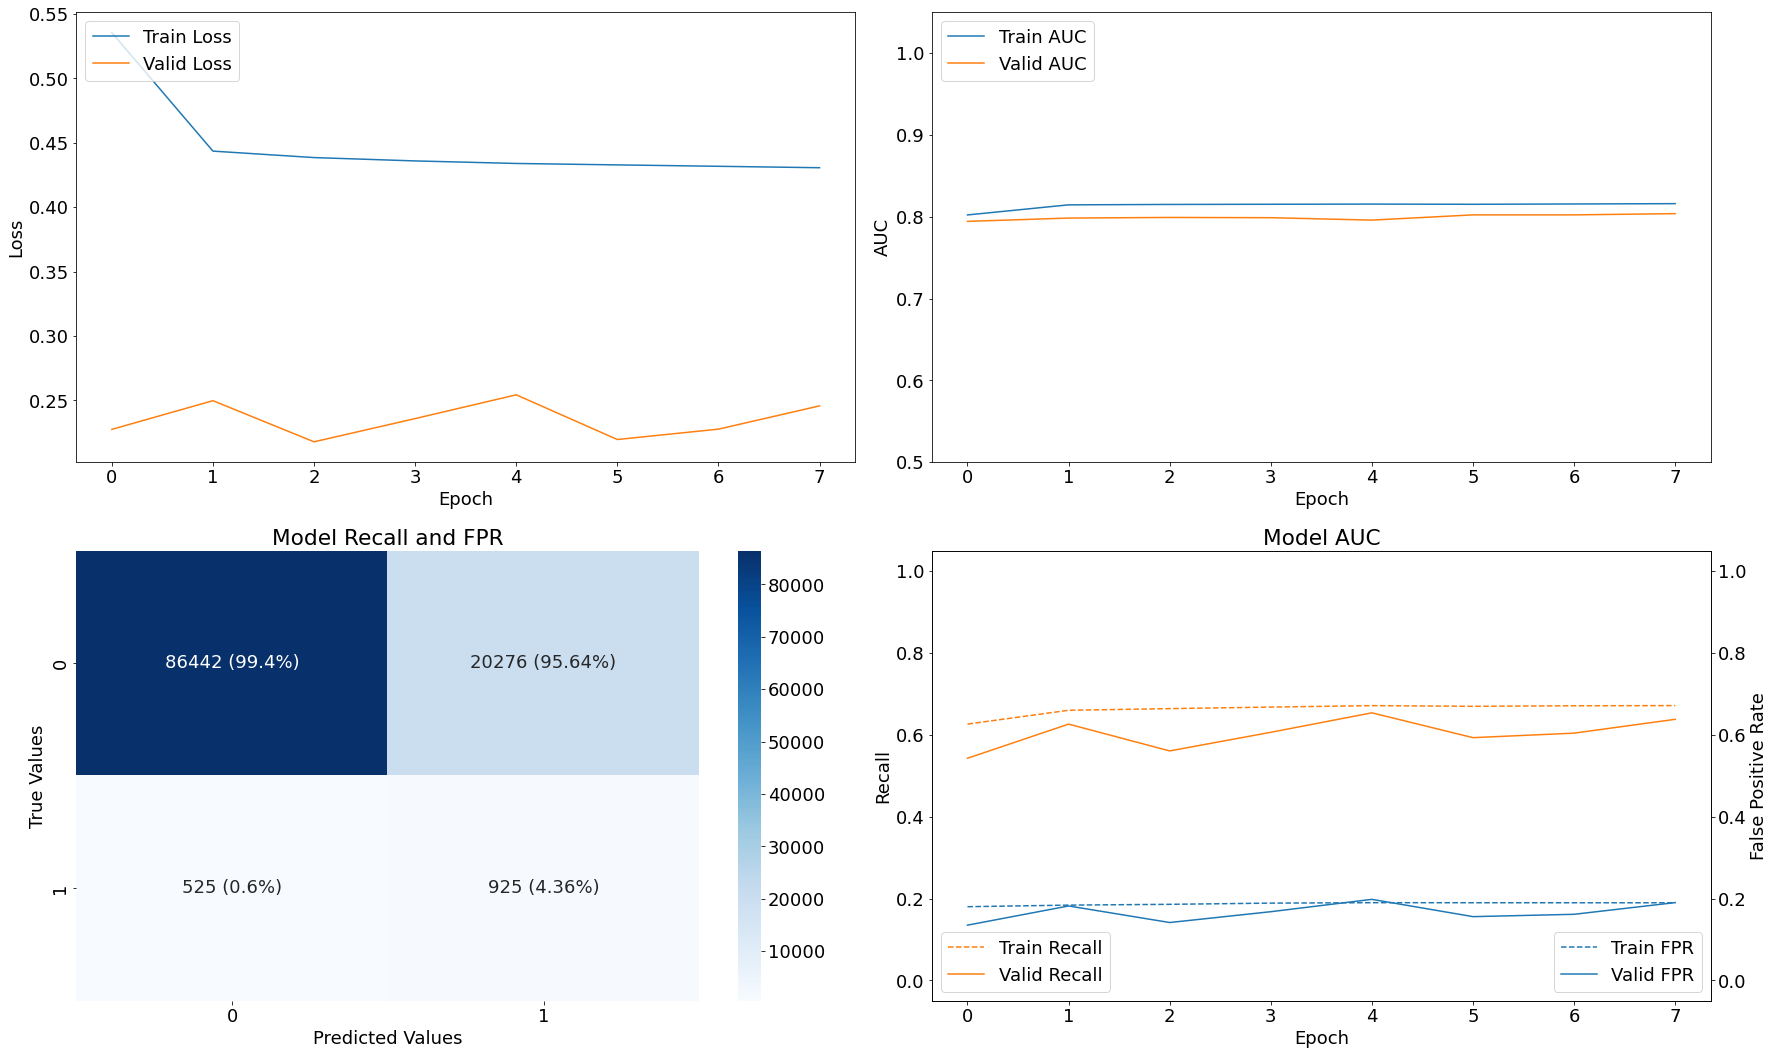

Epoch 00011: early stopping
Results for Cross Feature Model V3 with threshold = 0.2.

 Train f1: 0.5348378803568212 
 Val f1: 0.06801336026197576 

 Train Recall: 0.7774275541305542 
 Val Recall: 0.7372413873672485 

 Train FPR: 0.2824304401874542 
 Val FPR: 0.2709571123123169


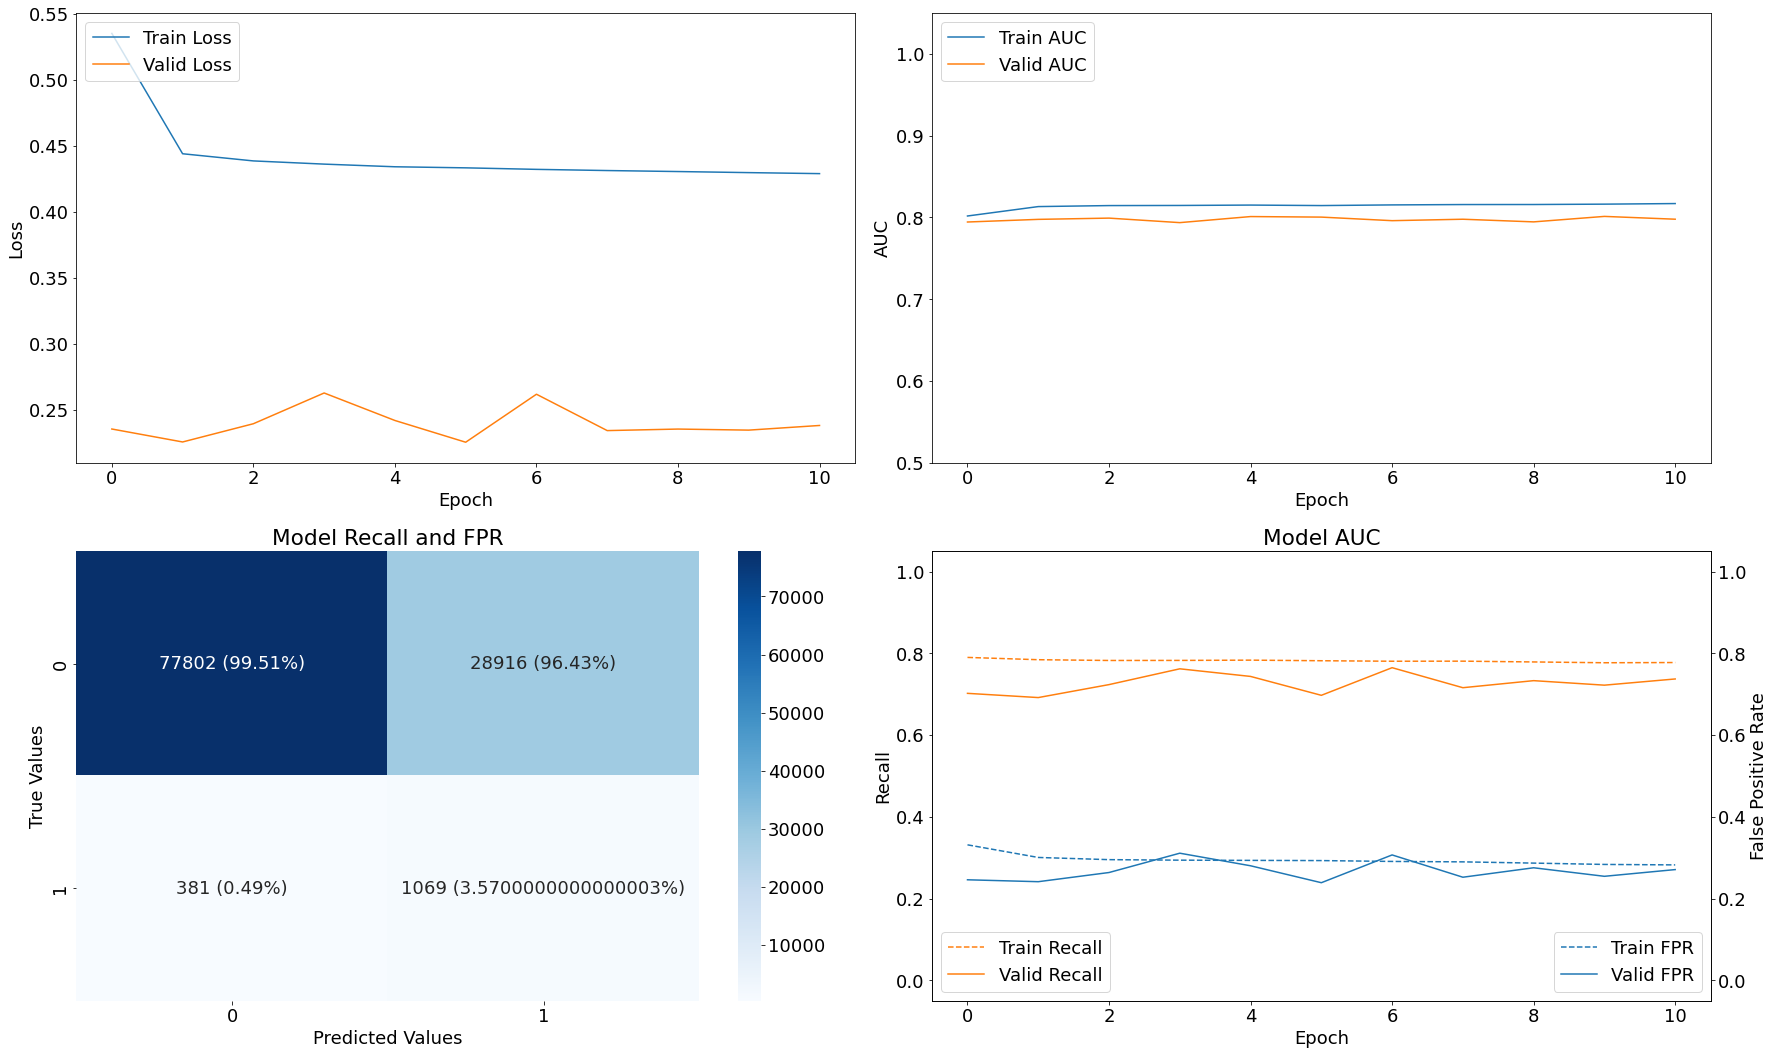

Epoch 00011: early stopping
Results for Cross Feature Model V3 with threshold = 0.1.

 Train f1: 0.4729379183625458 
 Val f1: 0.046237303441358686 

 Train Recall: 0.8849112391471863 
 Val Recall: 0.8758620619773865 

 Train FPR: 0.4643179476261139 
 Val FPR: 0.48927077651023865


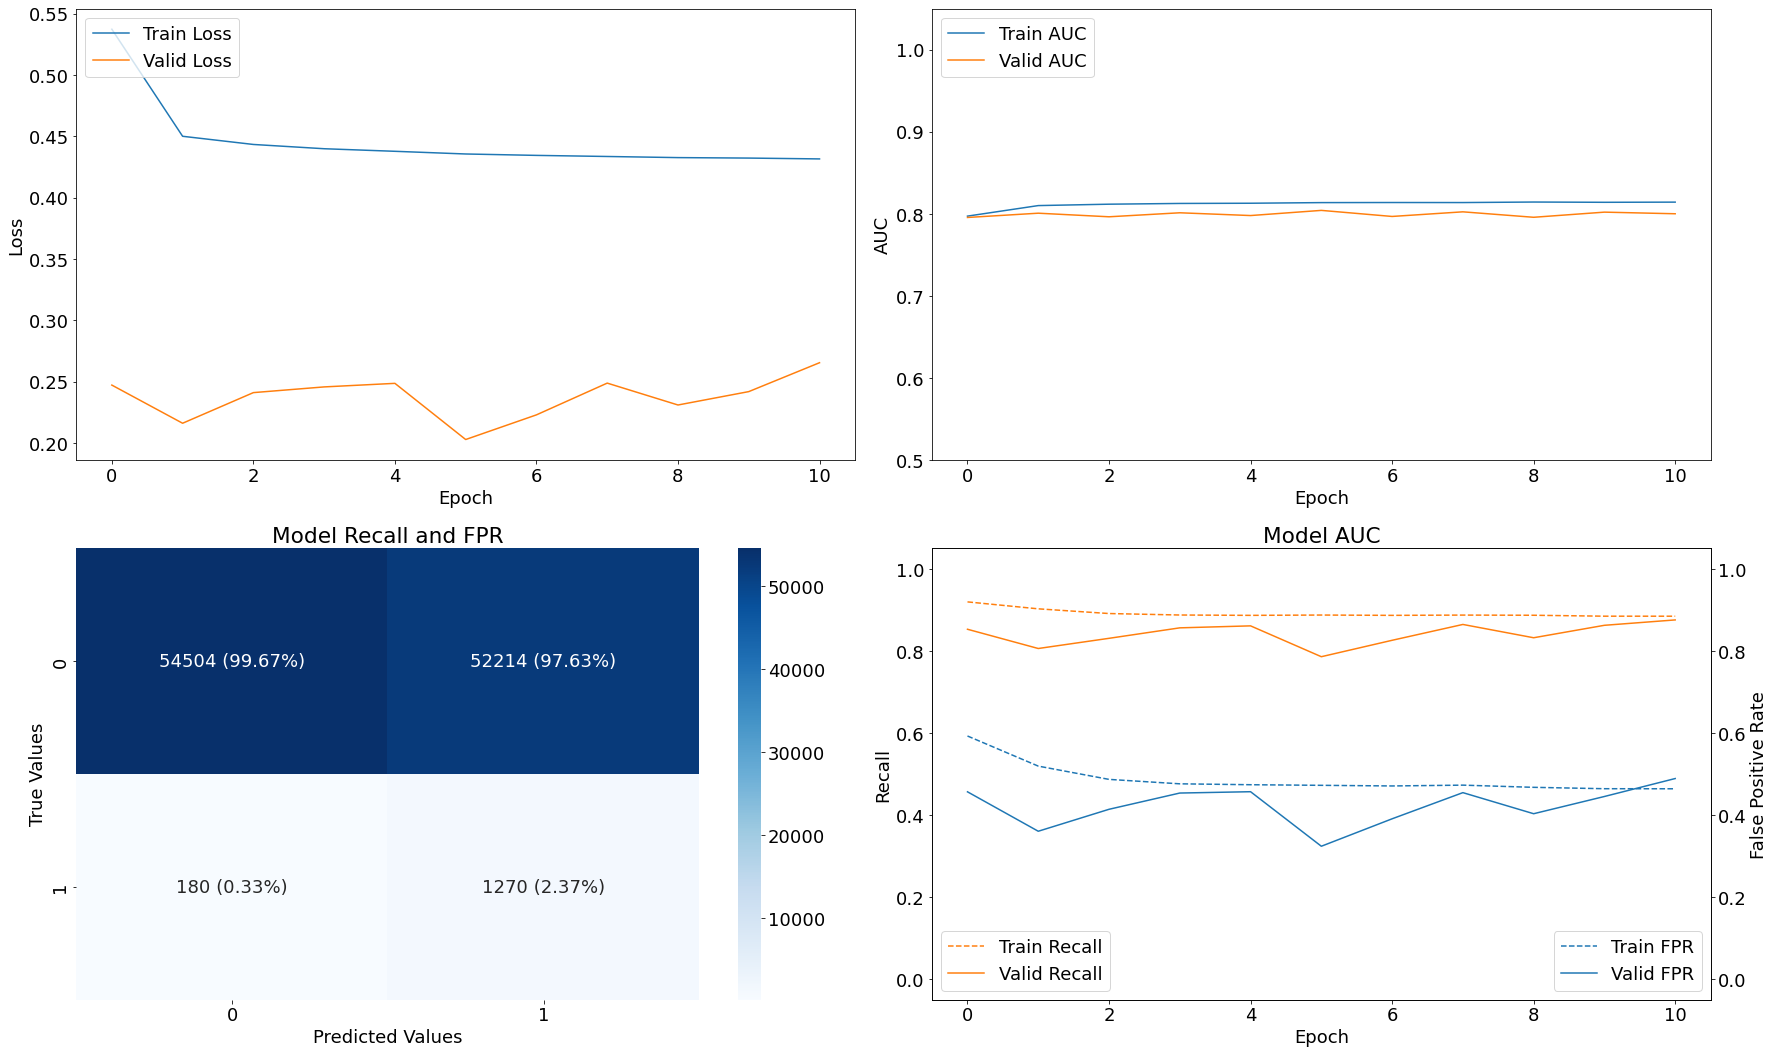

In [101]:
for t in thresholds:

    cross_modelling_v3(Xc_train_base_scaled_resampled,
                      y_train_base_resampled,
                      Xc_val_base_scaled,
                      y_val_base,
                      'Cross Feature Model V3',
                       threshold=t)

#### Cross Model Final Note

In general, these model appear to perform very well for the given metrics without being overfit. Due to the time constraints of this project, as well as the scale of the data, this method was not explored further. A follow-up evaluation would likely benefit from model tuning for these engineered features. This note also applies to the polynomial feature modelling conducted below.

---

## Polynomial Feature Modelling

The first method of feature engineering was polynomial features, the combination of features into a certain degree polynomial, in this case degree 3. This process was only utilized on the base dataset due to time restraints and no noticable improvements on performance. The features were read in from the files created in `Data Prep` and `poly_n_features`, the number of polynomial features, was created for the input layer. 

The process below follows similar logic to that of the modelling for the cross features, with some additional dense layers due to a higher input dimensionality.

In [12]:
X_train_base_poly_scaled_resampled \
= pd.read_csv('../Data/base/X_train_base_poly_scaled_resampled.csv')
X_val_base_poly_scale = pd.read_csv('../Data/base/X_val_base_poly_scaled.csv')

In [13]:
poly_n_features = X_train_base_poly_scaled_resampled.shape[1]

---

### First Model Iteration (Polynomial)

This model is a similar structure to previous model iterations, with three relu activation dense layers, dimensionality 512, 256, 128, with 50% dropout layers inbetween. Similarly to the cross features model, this model does very well at minimizing the false positive rate but does not perform well in terms of recall.

In [14]:
def poly_modelling_v1(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    poly_model_v1 = models.Sequential()

    poly_model_v1.add(layers.Input(shape=(poly_n_features, )))
    poly_model_v1.add(layers.Dense(512, activation='relu'))
    poly_model_v1.add(layers.Dropout(0.5))
    poly_model_v1.add(layers.Dense(256, activation='relu'))
    poly_model_v1.add(layers.Dropout(0.5))
    poly_model_v1.add(layers.Dense(128, activation='relu'))
    poly_model_v1.add(layers.Dense(1, activation='sigmoid'))

    poly_model_v1.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['AUC',
                                    tf.keras.metrics.Precision(thresholds=threshold),
                                    tf.keras.metrics.Recall(thresholds=threshold),
                                    FalsePositiveRate(threshold=threshold)])

    poly_model_v1_history = poly_model_v1.fit(X_train,
                                              y_train,
                                              batch_size=batch_size,
                                              validation_data=(X_val, y_val),
                                              class_weight=class_weight,
                                              epochs=epochs,
                                              callbacks=[early_stop],
                                              verbose=0).history
    
    evaluate(poly_model_v1,
             name, 
             poly_model_v1_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00014: early stopping
Results for Poly Feature Model V1 with threshold = 0.5.

 Train f1: 0.8589021409251587 
 Val f1: 0.16814650345048823 

 Train Recall: 0.8519945740699768 
 Val Recall: 0.2089655101299286 

 Train FPR: 0.03298010677099228 
 Val FPR: 0.017344778403639793


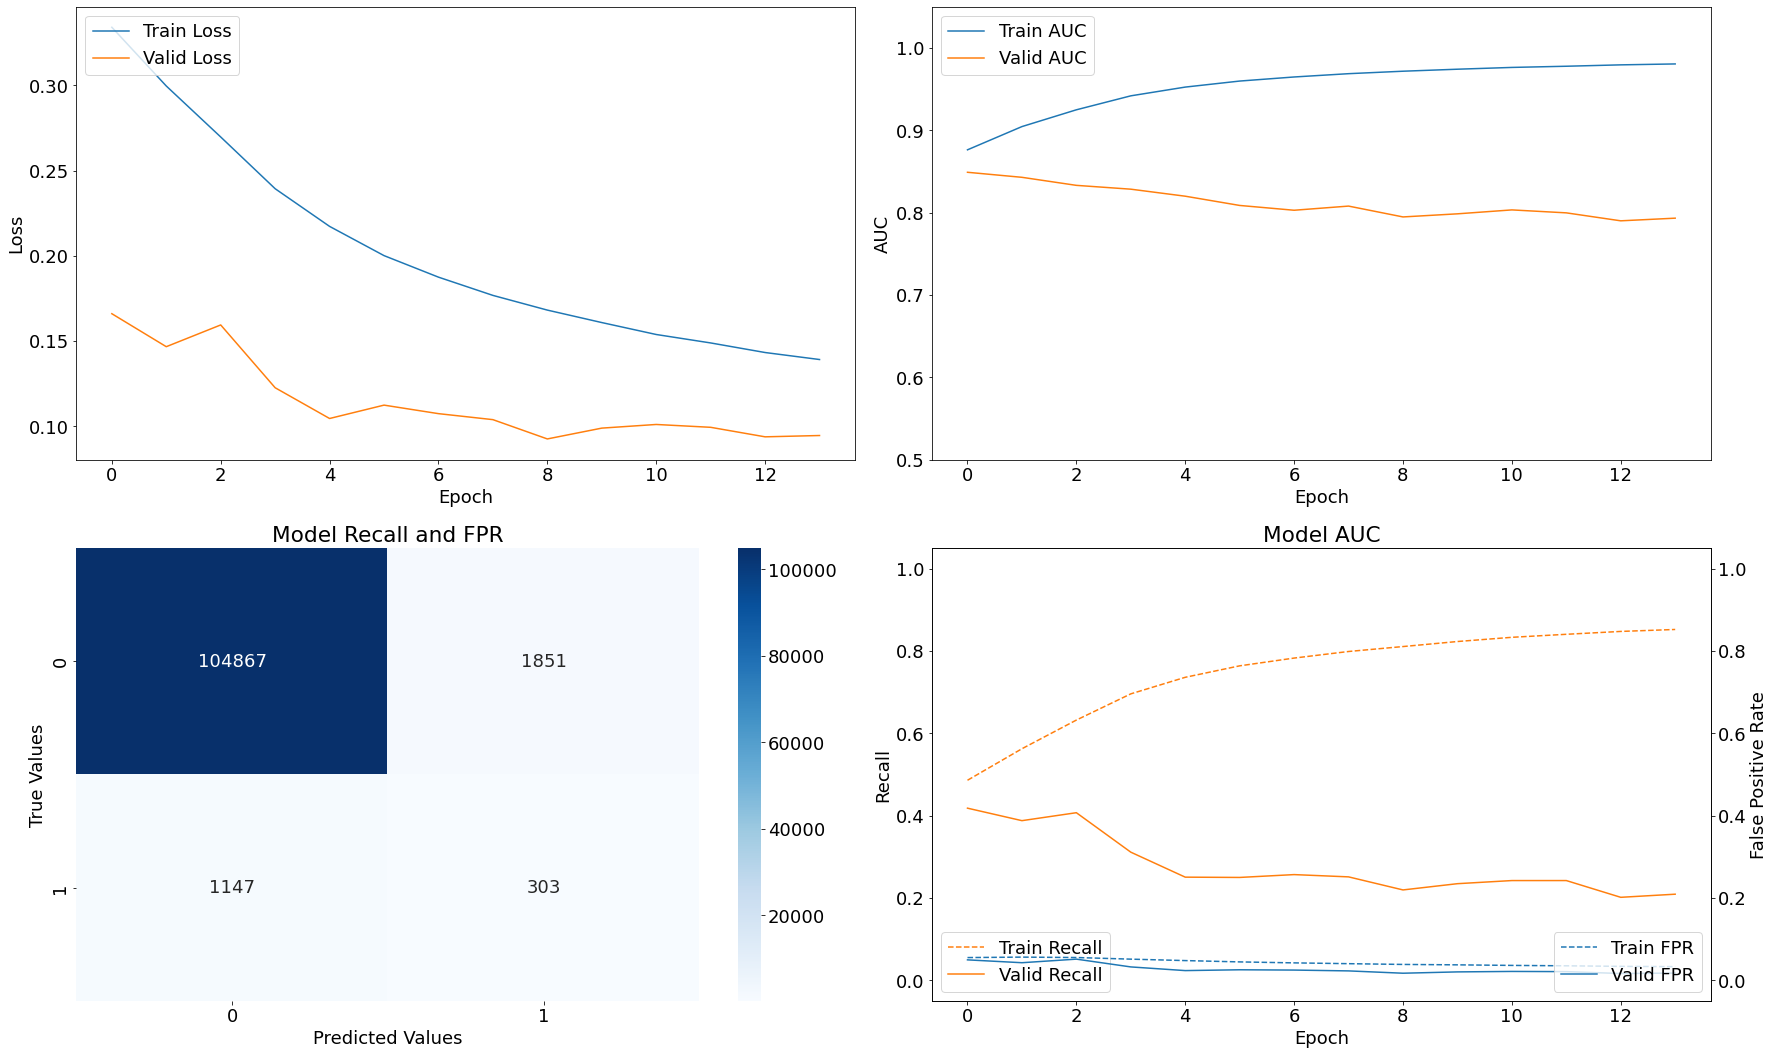

Epoch 00018: early stopping
Results for Poly Feature Model V1 with threshold = 0.4.

 Train f1: 0.8755238972355246 
 Val f1: 0.17193878113564842 

 Train Recall: 0.9021244645118713 
 Val Recall: 0.23241379857063293 

 Train FPR: 0.0396600067615509 
 Val FPR: 0.019987255334854126


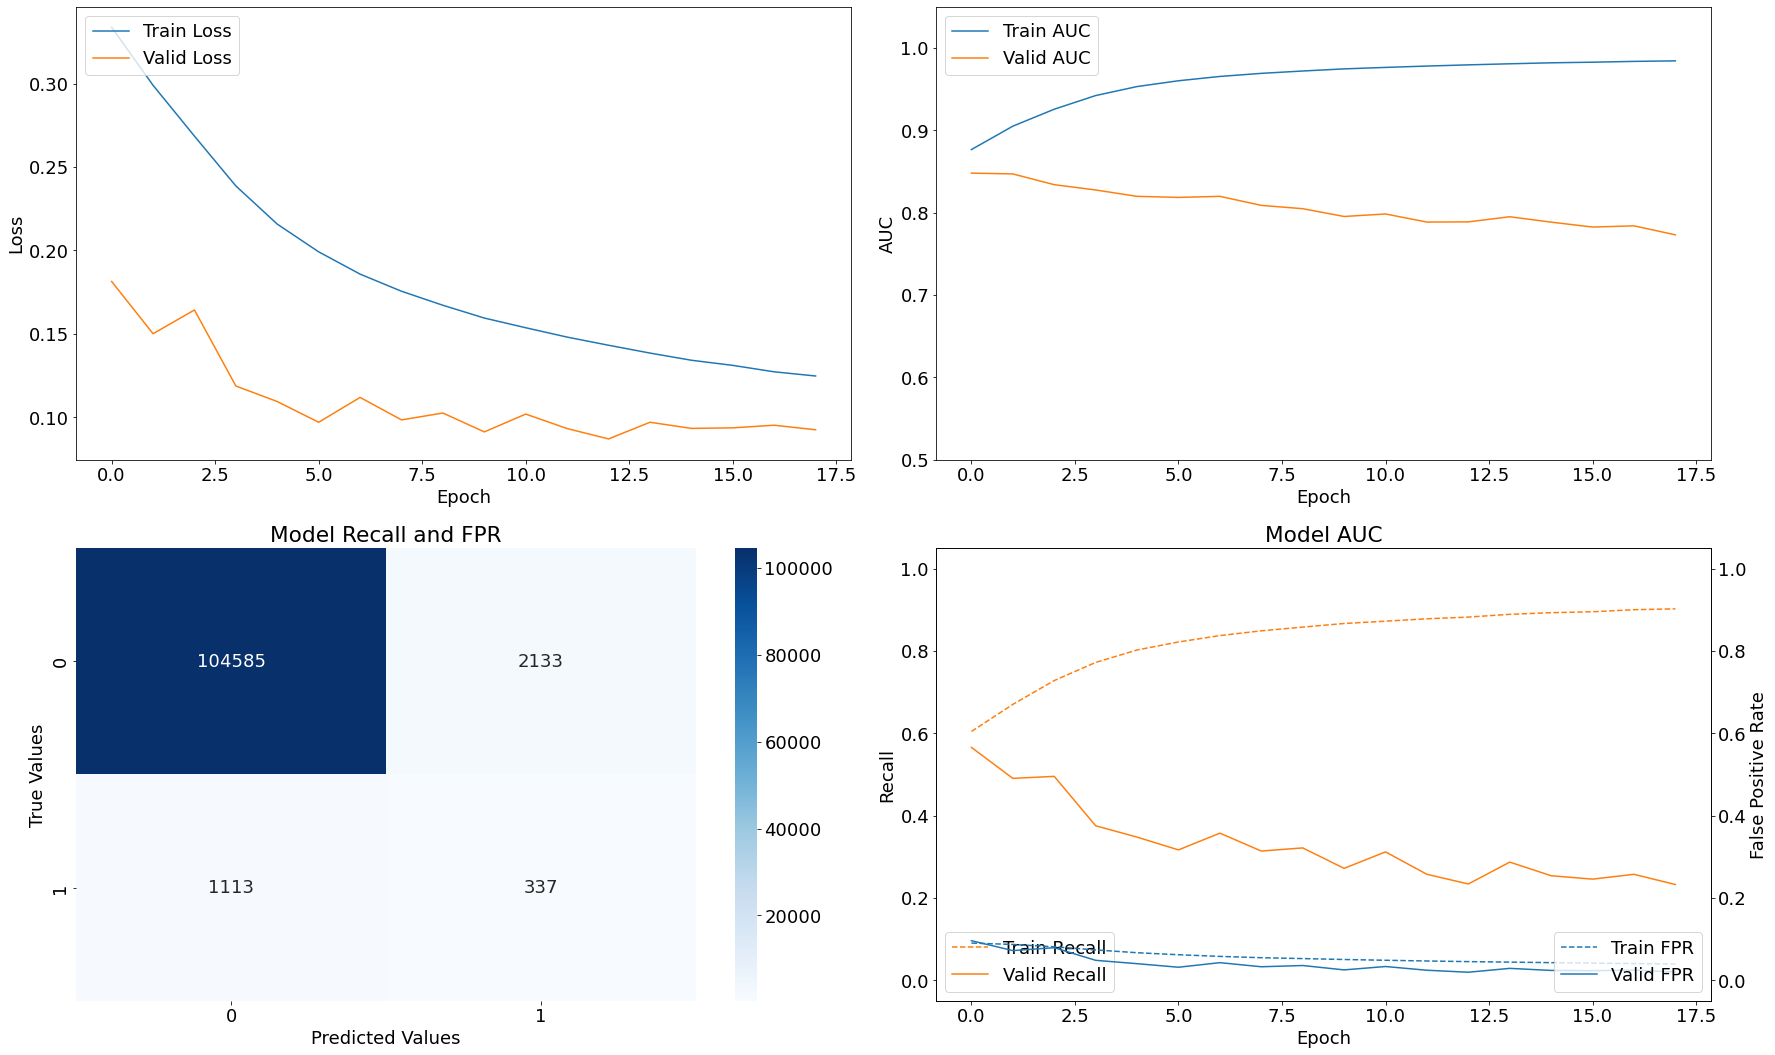

Epoch 00016: early stopping
Results for Poly Feature Model V1 with threshold = 0.3.

 Train f1: 0.8617000760565635 
 Val f1: 0.1501642455668861 

 Train Recall: 0.923755407333374 
 Val Recall: 0.33103448152542114 

 Train FPR: 0.05506851524114609 
 Val FPR: 0.041820500046014786


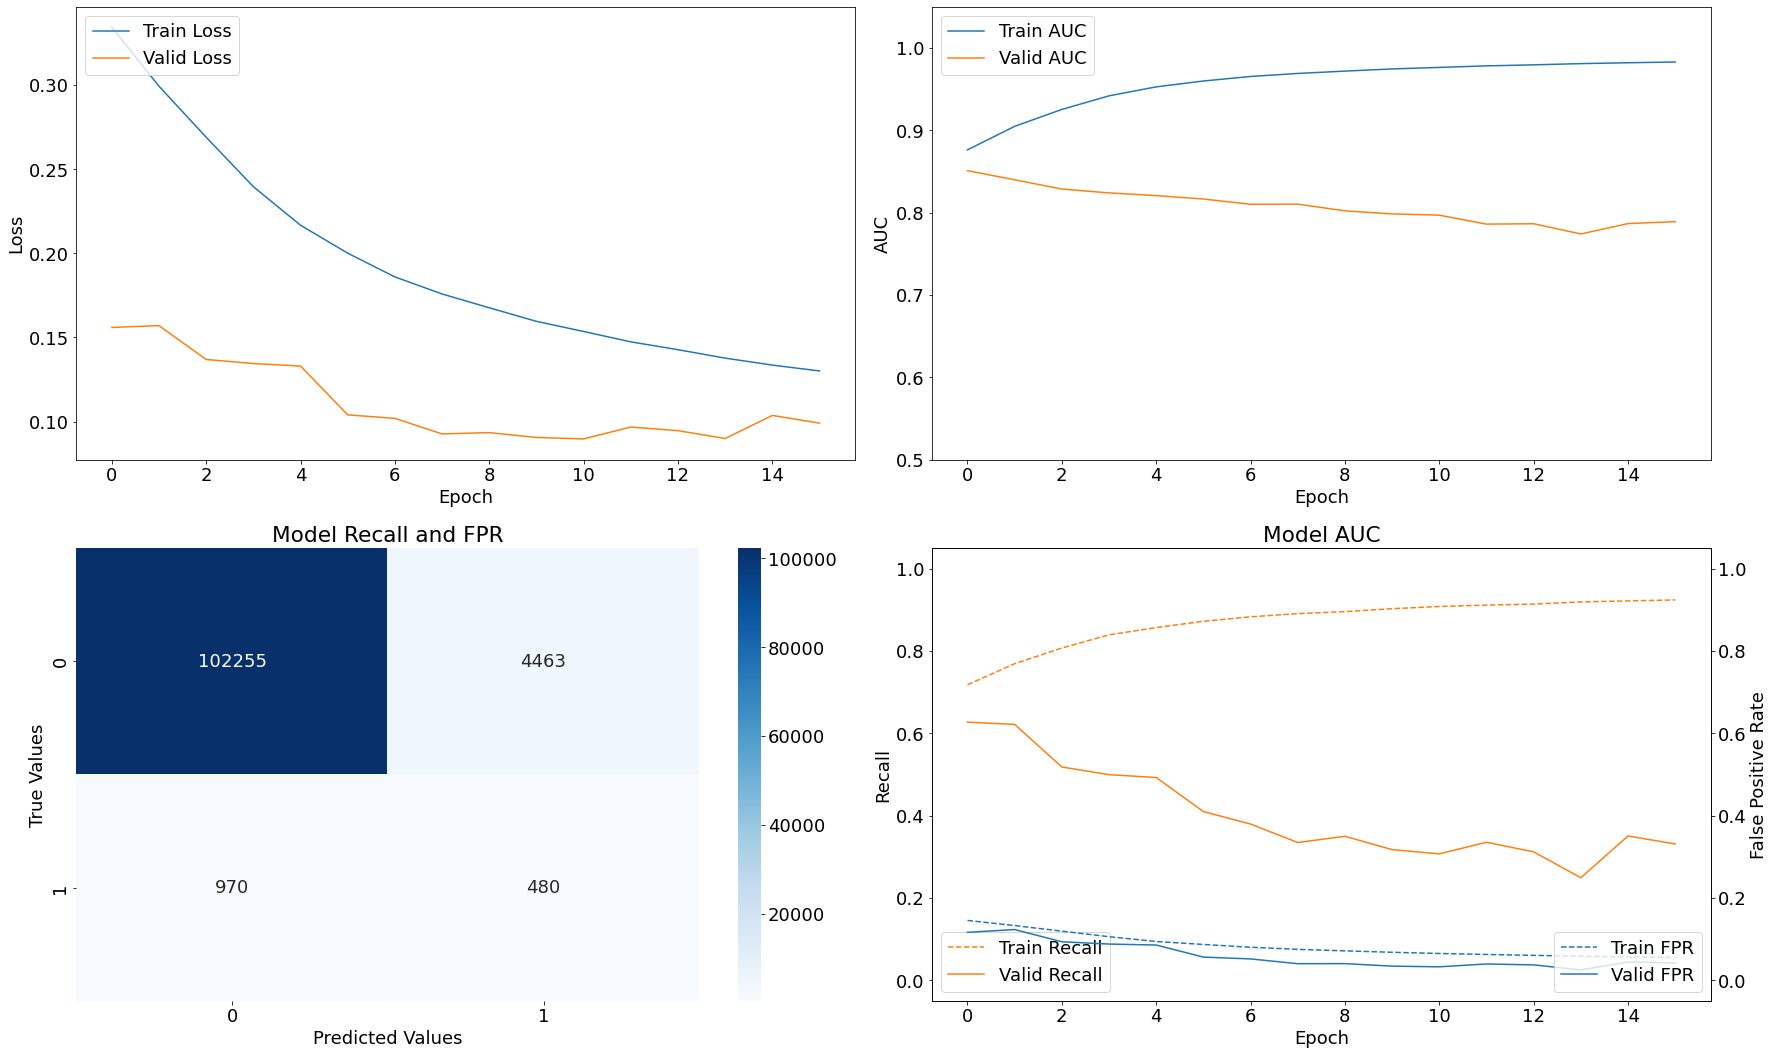

Epoch 00017: early stopping
Results for Poly Feature Model V1 with threshold = 0.2.

 Train f1: 0.8468052708973559 
 Val f1: 0.1480895873303511 

 Train Recall: 0.9498142004013062 
 Val Recall: 0.38758620619773865 

 Train FPR: 0.07336834073066711 
 Val FPR: 0.05226859450340271


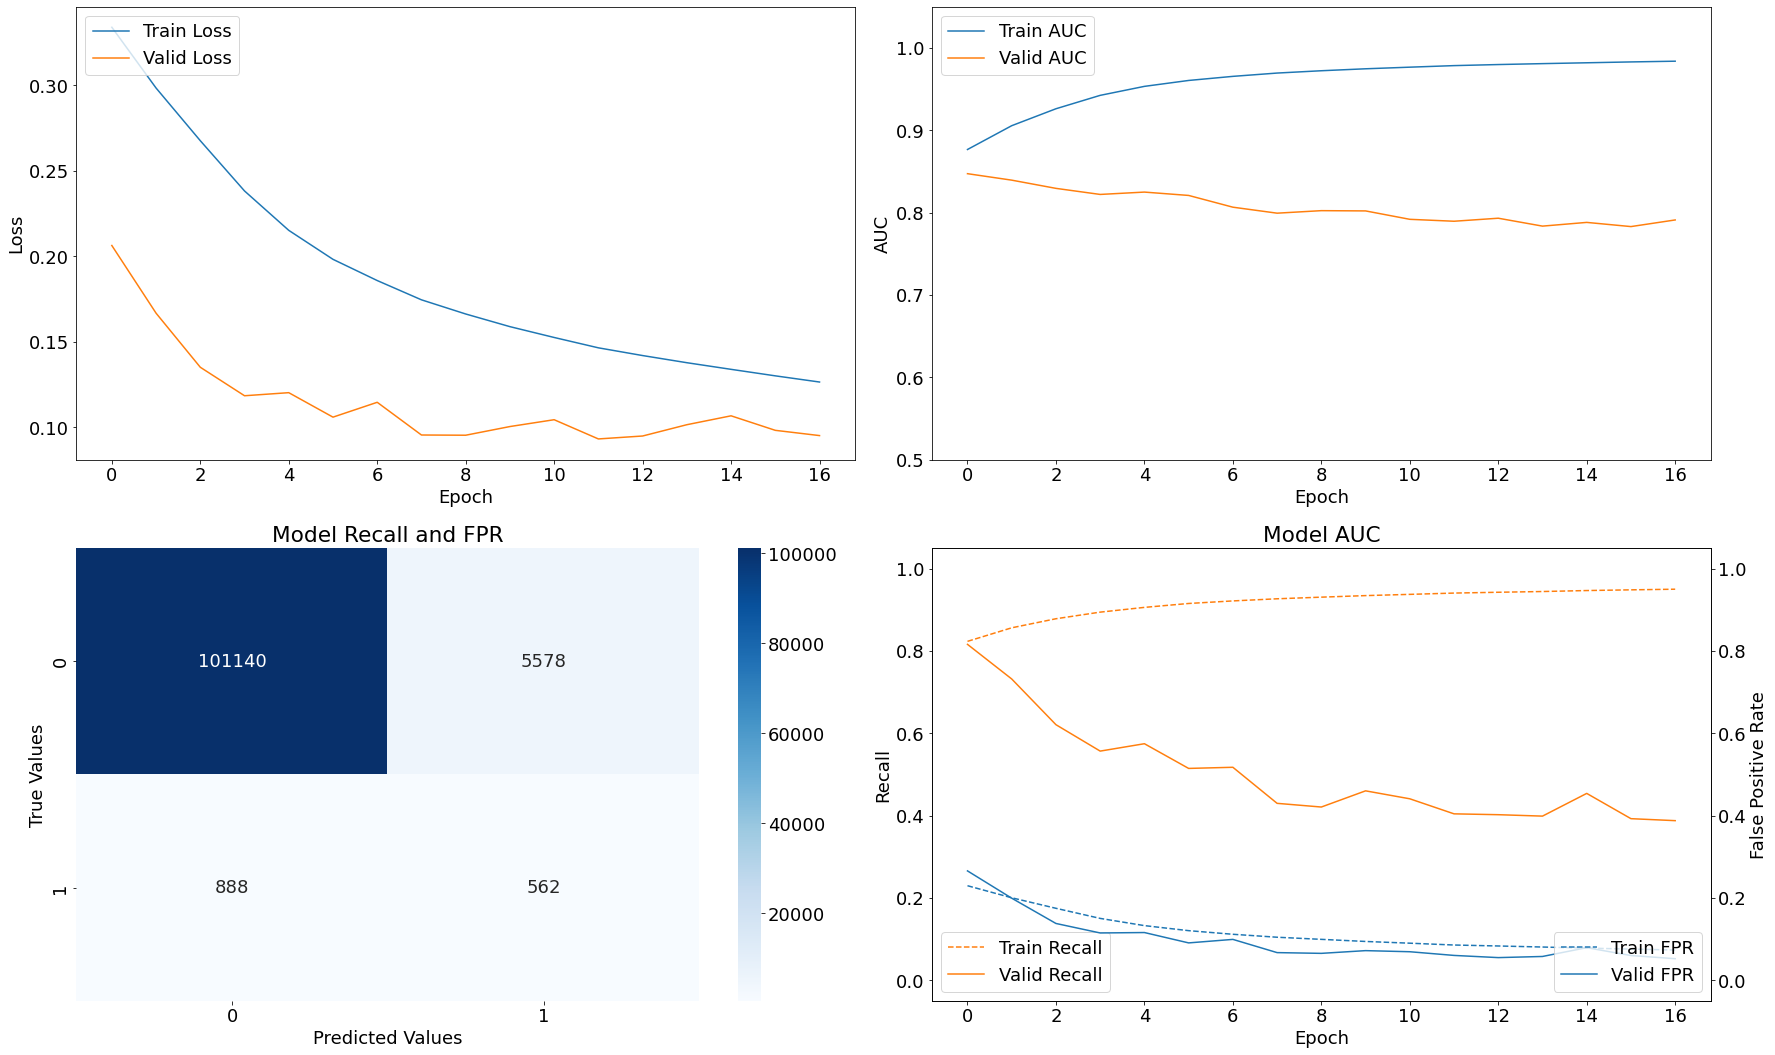

Epoch 00014: early stopping
Results for Poly Feature Model V1 with threshold = 0.1.

 Train f1: 0.7896432832638529 
 Val f1: 0.12372804728727337 

 Train Recall: 0.9697014093399048 
 Val Recall: 0.473793089389801 

 Train FPR: 0.12158665806055069 
 Val FPR: 0.08403455466032028


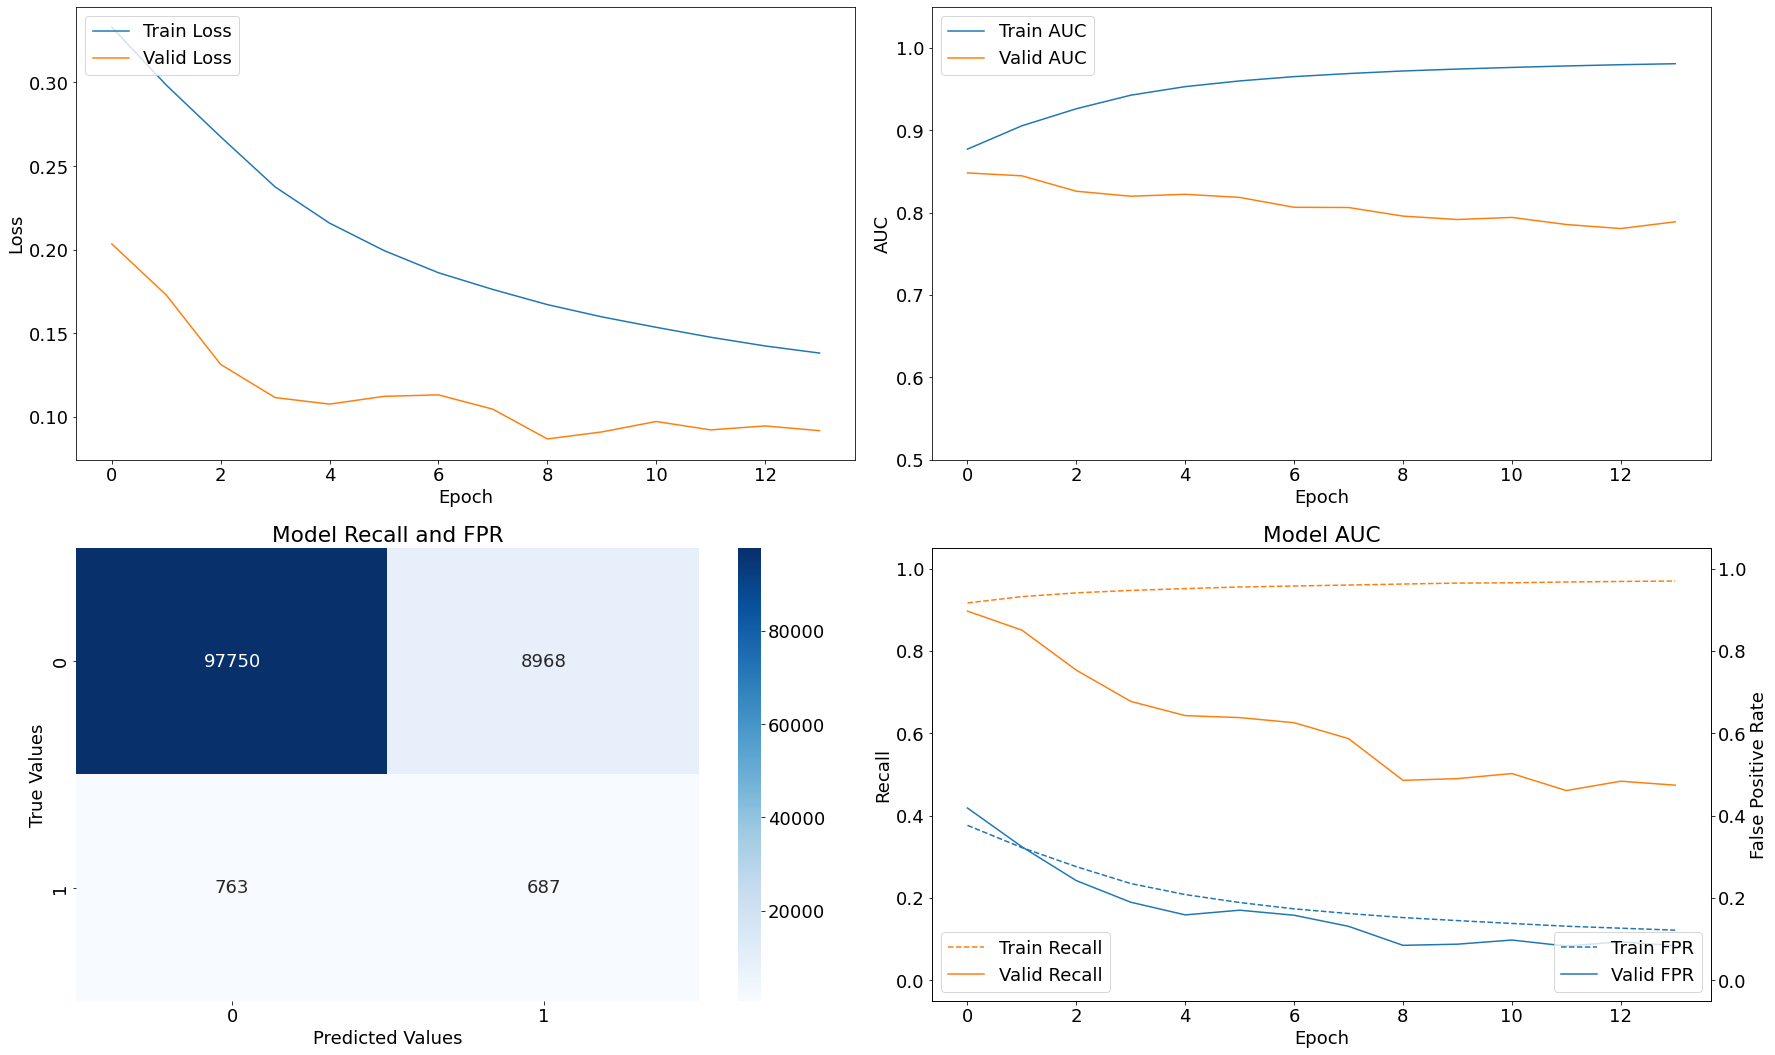

In [15]:
for t in thresholds:

    poly_modelling_v1(X_train_base_poly_scaled_resampled,
                      y_train_base_resampled,
                      X_val_base_poly_scale,
                      y_val_base,
                      'Poly Feature Model V1',
                      threshold=t)

### Second Model Iteration (Polynomial)

This model is adds regularization to the previous model. While this model does a much better job in terms of recall, the false positive rate is much higher than the previous model. The false positive rate also drastically increases as the threshold decreases.

In [16]:
def poly_modelling_v2(X_train, y_train, X_val, y_val, name, epochs=50, batch_size=256, threshold=0.5):
    
    poly_model_v2 = models.Sequential()

    poly_model_v2.add(layers.Input(shape=(poly_n_features, )))
    poly_model_v2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2()))
    poly_model_v2.add(layers.Dropout(0.5))
    poly_model_v2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2()))
    poly_model_v2.add(layers.Dropout(0.5))
    poly_model_v2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2()))
    poly_model_v2.add(layers.Dense(1, activation='sigmoid'))

    poly_model_v2.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['AUC',
                                    tf.keras.metrics.Precision(thresholds=threshold),
                                    tf.keras.metrics.Recall(thresholds=threshold),
                                    FalsePositiveRate(threshold=threshold)])

    poly_model_v2_history = poly_model_v2.fit(X_train,
                                              y_train,
                                              batch_size=batch_size,
                                              validation_data=(X_val, y_val),
                                              class_weight=class_weight,
                                              epochs=epochs,
                                              callbacks=[early_stop],
                                              verbose=0).history
    
    evaluate(poly_model_v2,
             name, 
             poly_model_v2_history,
             X_val,
             y_val,
             threshold=threshold)

Epoch 00006: early stopping
Results for Poly Feature Model V2 with threshold = 0.5.

 Train f1: 0.48413721945363575 
 Val f1: 0.12983749067524616 

 Train Recall: 0.39017534255981445 
 Val Recall: 0.5344827771186829 

 Train FPR: 0.055415473878383636 
 Val FPR: 0.09101557731628418


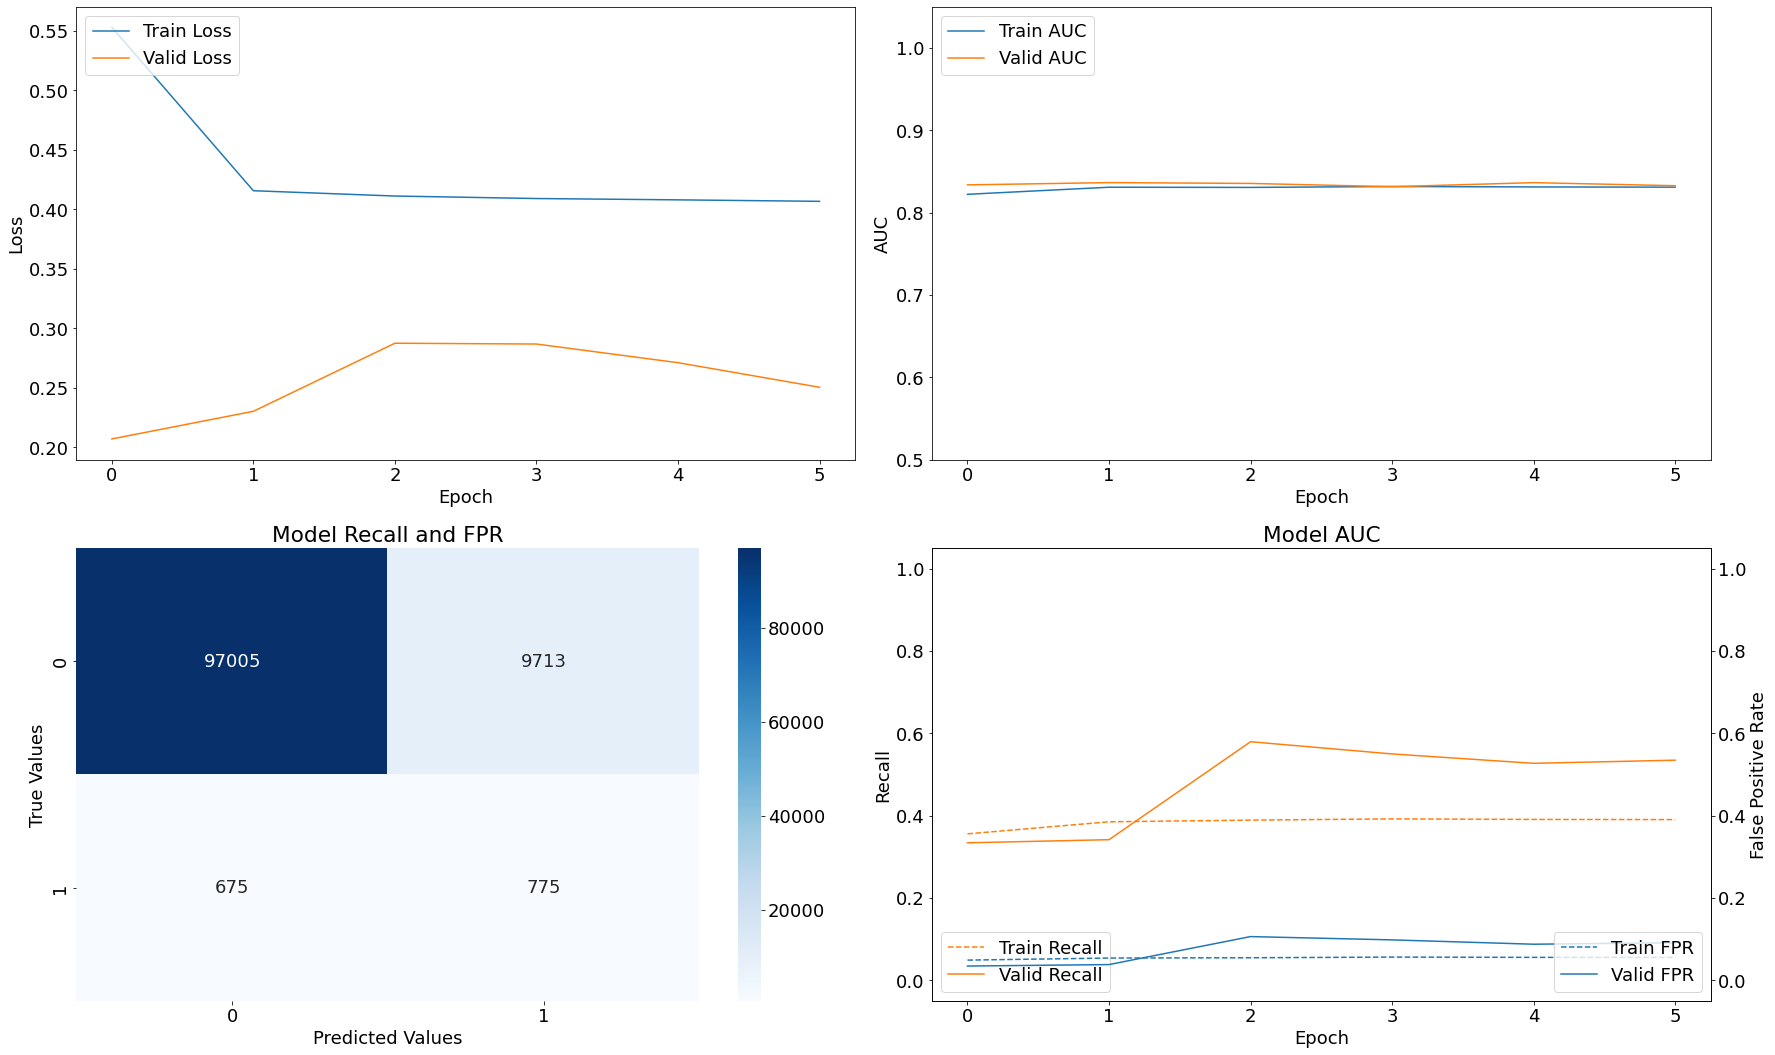

Epoch 00009: early stopping
Results for Poly Feature Model V2 with threshold = 0.4.

 Train f1: 0.5480494005870542 
 Val f1: 0.12885154195629372 

 Train Recall: 0.5215216279029846 
 Val Recall: 0.5551724433898926 

 Train FPR: 0.09541735053062439 
 Val FPR: 0.09595382213592529


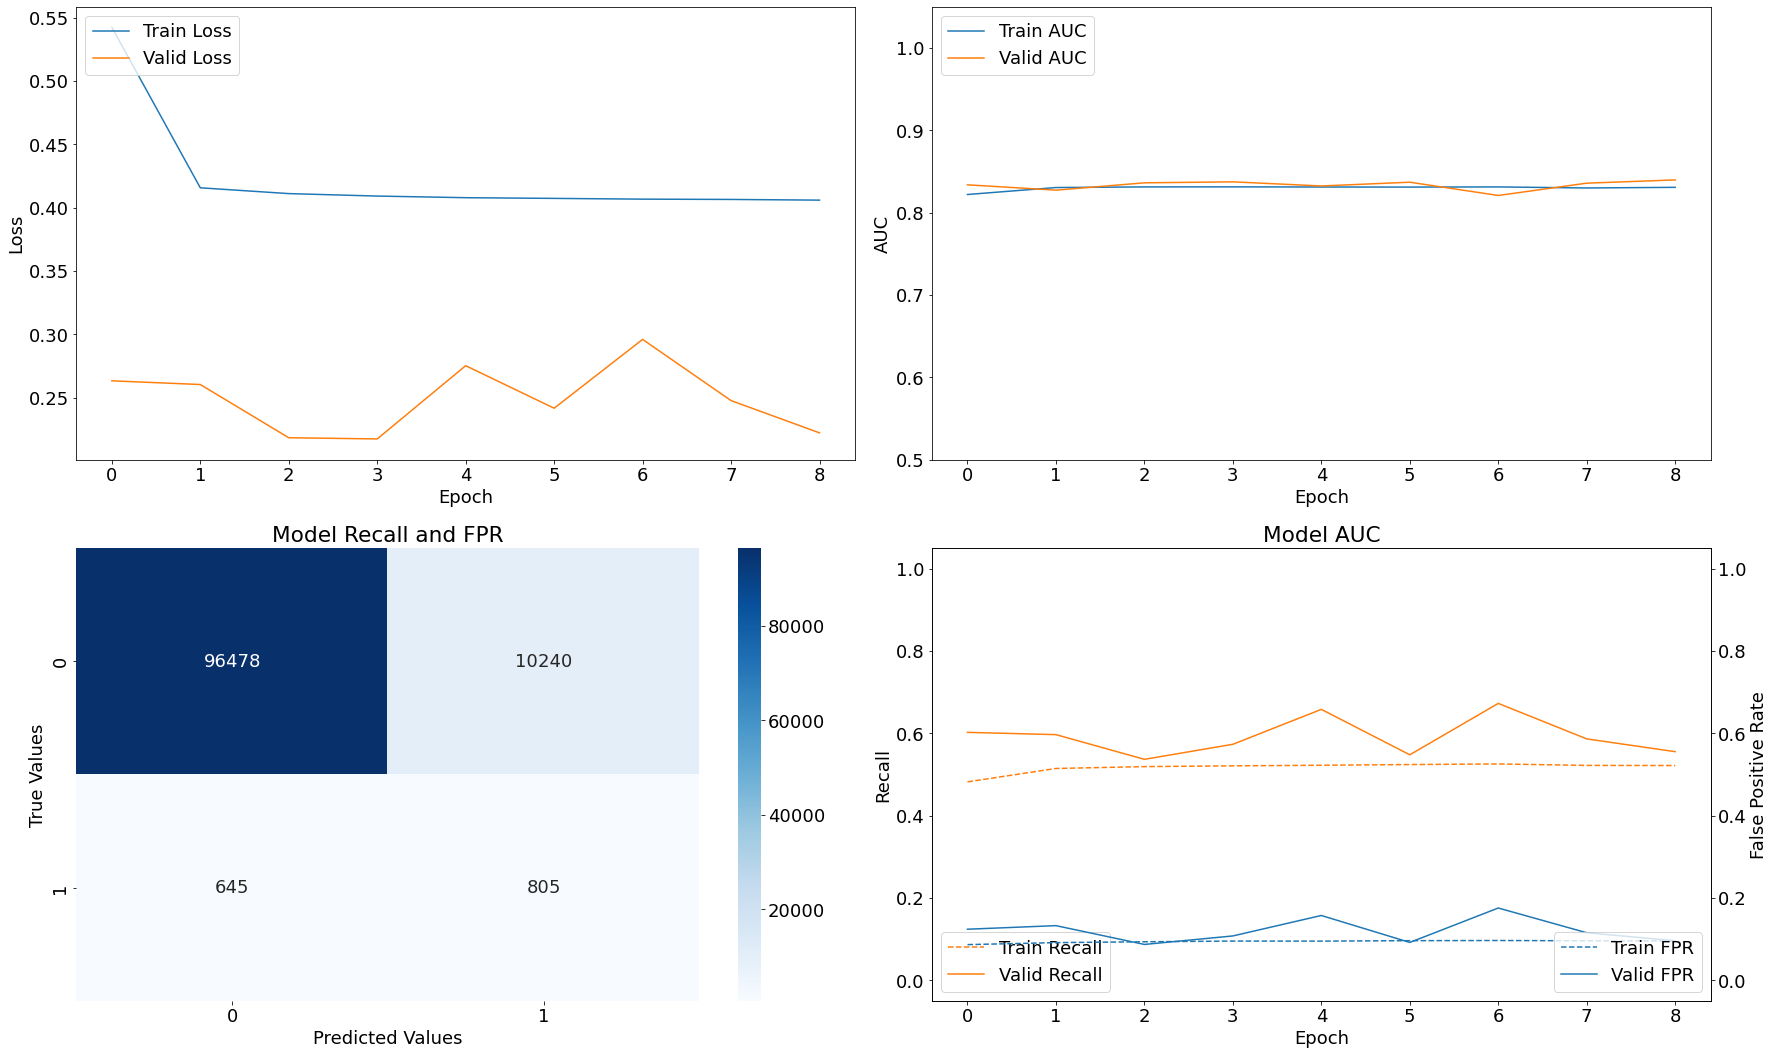

Epoch 00007: early stopping
Results for Poly Feature Model V2 with threshold = 0.3.

 Train f1: 0.5712435653863632 
 Val f1: 0.07943908636025997 

 Train Recall: 0.643585205078125 
 Val Recall: 0.7579310536384583 

 Train FPR: 0.1524227410554886 
 Val FPR: 0.2353867143392563


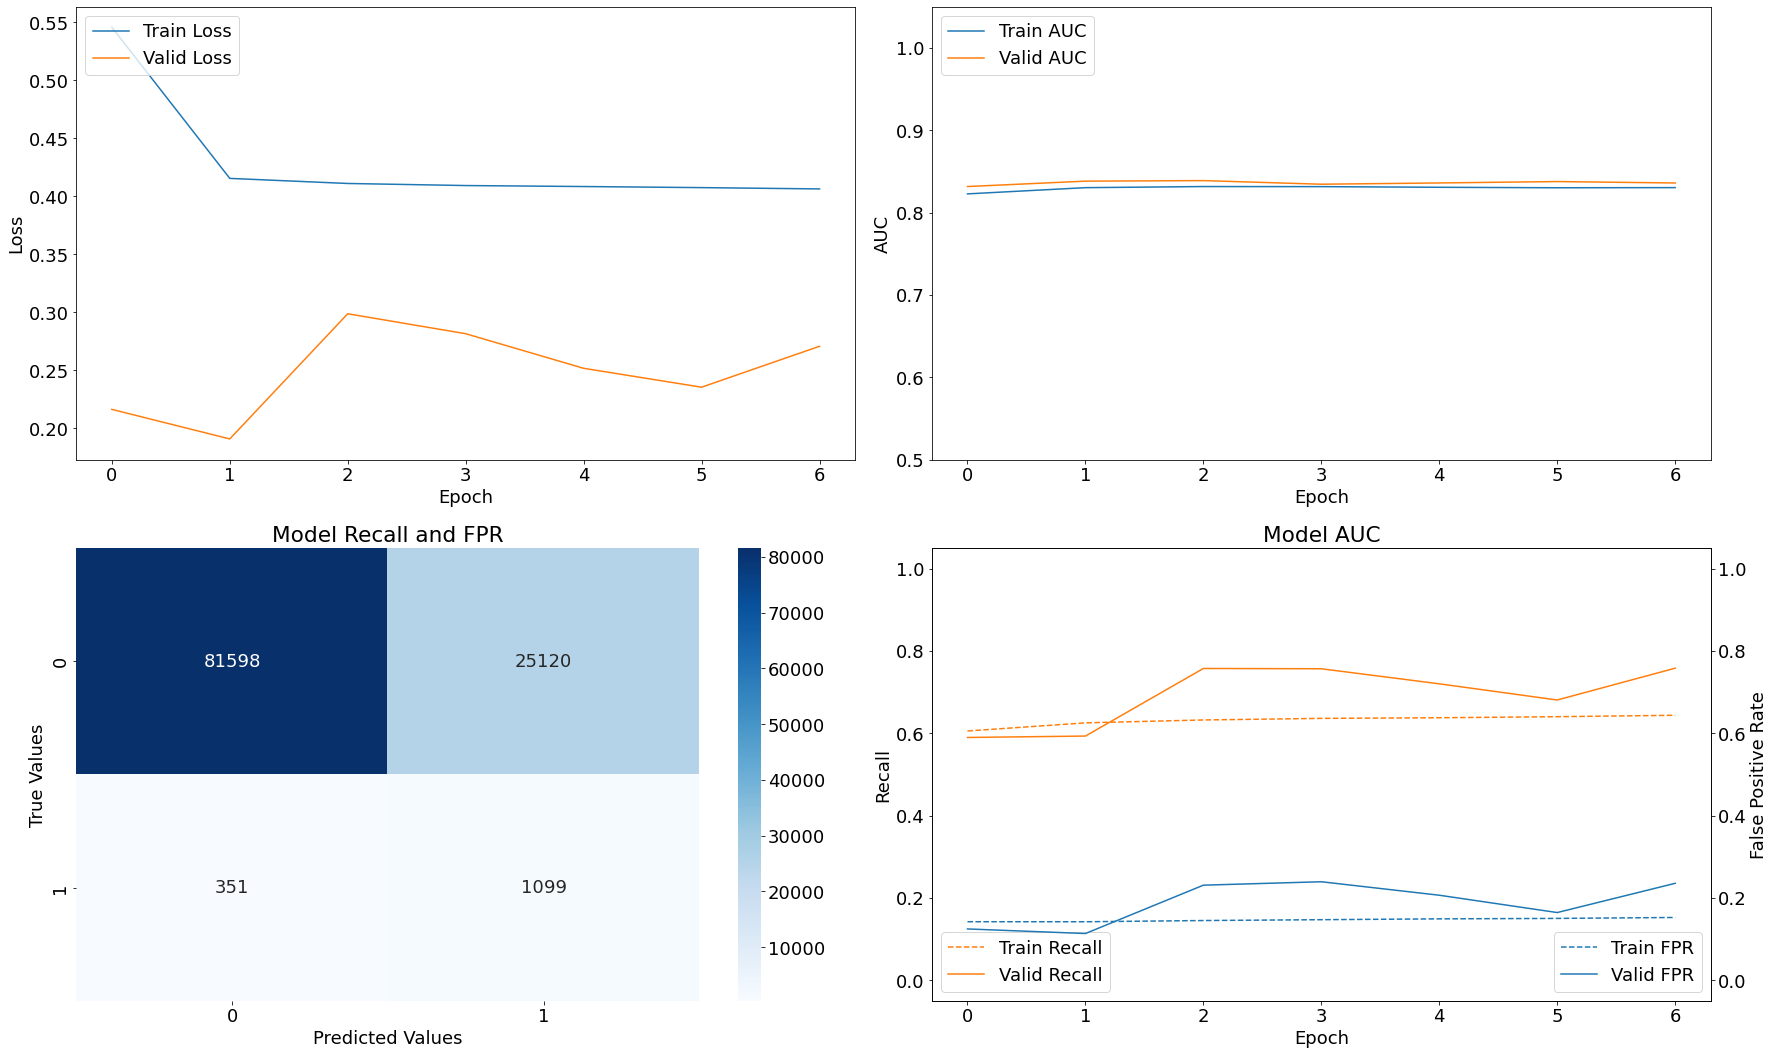

Epoch 00012: early stopping
Results for Poly Feature Model V2 with threshold = 0.2.

 Train f1: 0.5640050014285787 
 Val f1: 0.06652480778573559 

 Train Recall: 0.7429959774017334 
 Val Recall: 0.8193103671073914 

 Train FPR: 0.222928985953331 
 Val FPR: 0.3099570870399475


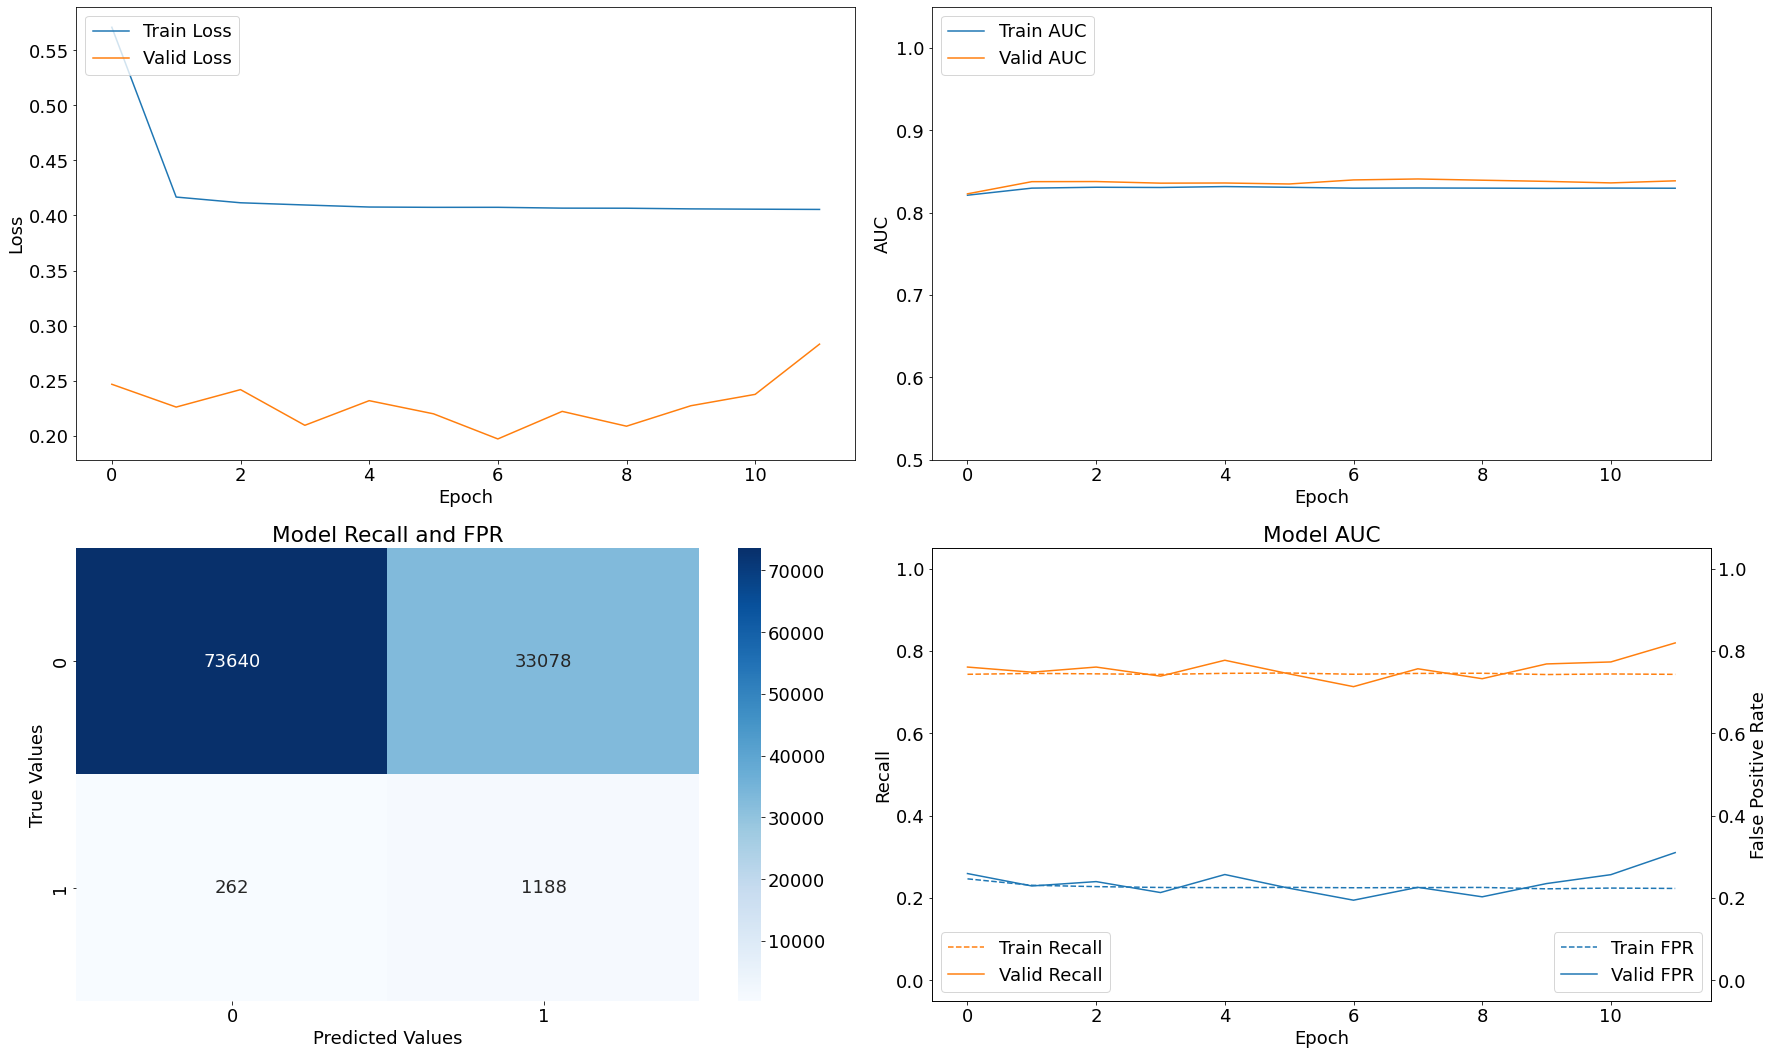

Epoch 00011: early stopping
Results for Poly Feature Model V2 with threshold = 0.1.

 Train f1: 0.49526334437809083 
 Val f1: 0.06055658286505037 

 Train Recall: 0.8733255863189697 
 Val Recall: 0.8441379070281982 

 Train FPR: 0.4133455753326416 
 Val FPR: 0.35374537110328674


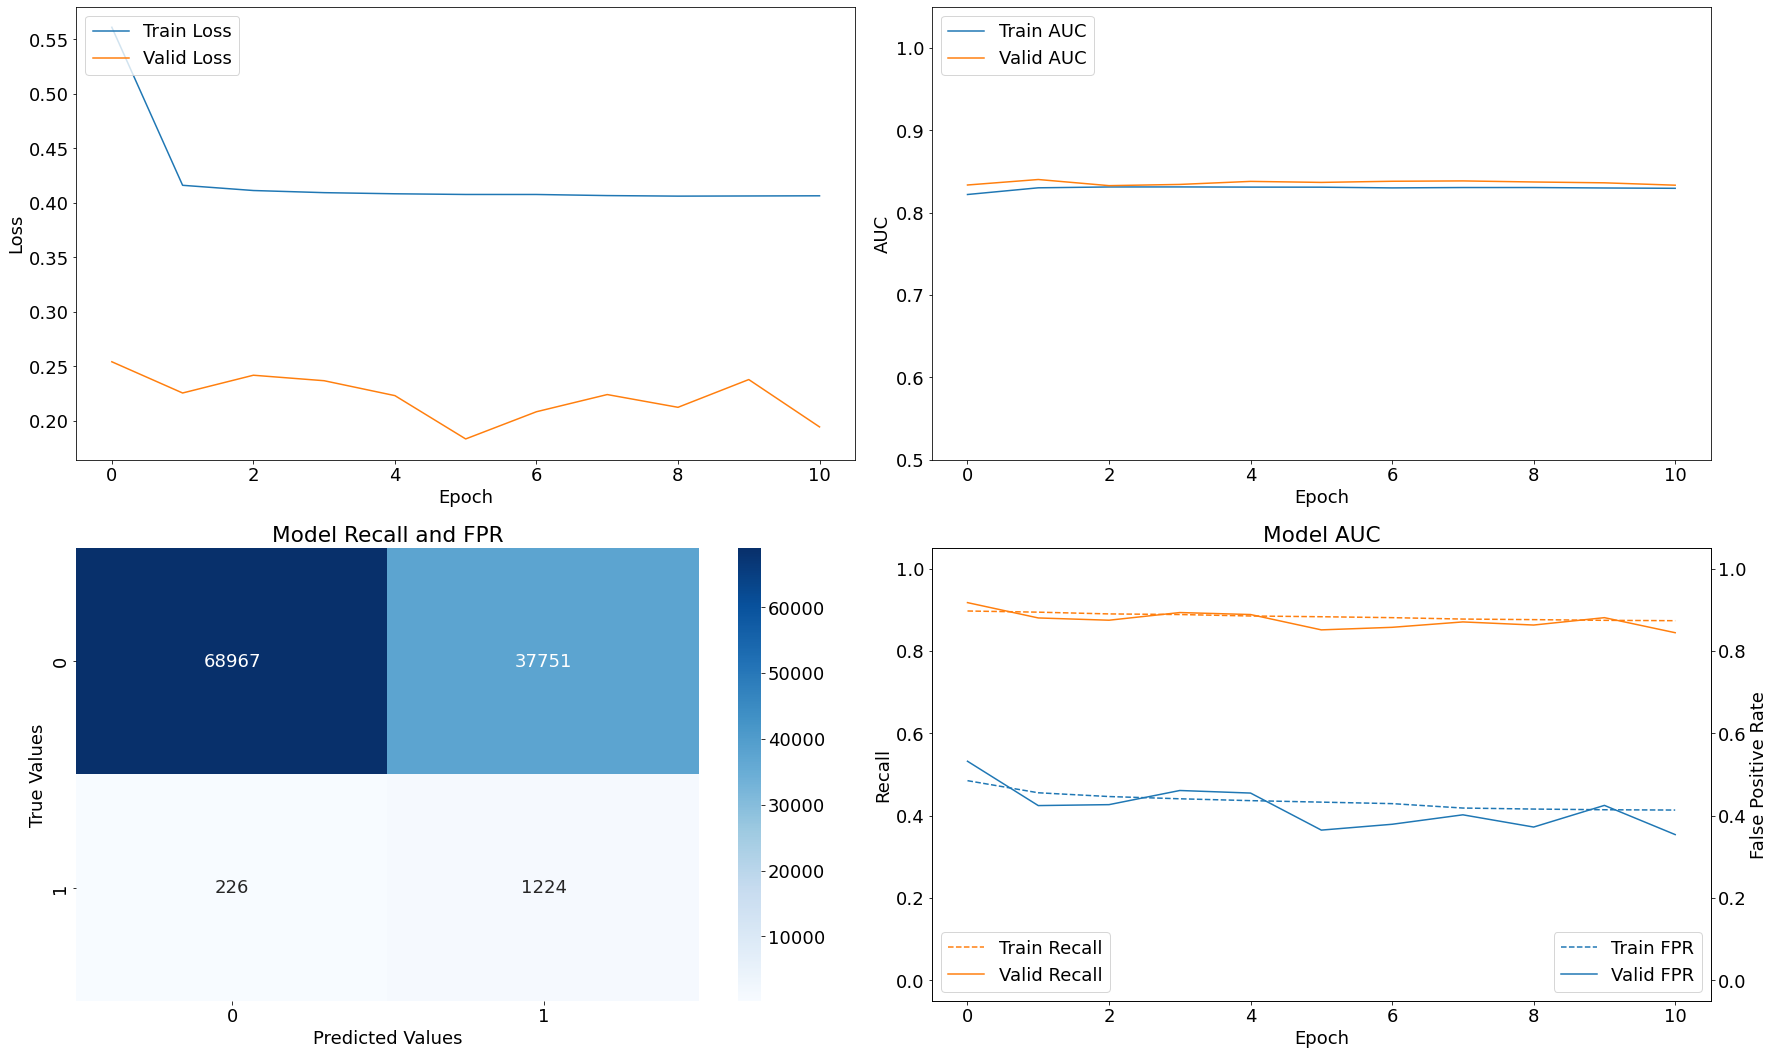

In [17]:
for t in thresholds:

    poly_modelling_v2(X_train_base_poly_scaled_resampled,
                      y_train_base_resampled,
                      X_val_base_poly_scale,
                      y_val_base,
                      'Poly Feature Model V2',
                      threshold=t)

---

# Modelling Conclusions

Overall, it appears that the most consistent and accurate, with regards to false positive rate and recall, model was the eighth iteration of the model. This model performed best across all the datasets, Variant V aside, and will be used for the final model. The details of the final modelling can be found in the `Final Model Results and Analysis` notebook

---